# Analyse von Audio Dateien zur Erkennung des Geschlechts
## 1. Einlesen einer csv Datei
Die Datei enthält alle zuvor extrahierten Audio Features und das Ziellabel Alter.

In [11]:
!pip install boto3
!conda install dask -y
!pip install fsspec
#!pip install pandas==0.22 # für macOS
#!pip install s3fs # wenn S3 Bucket verwendet wird
!pip install sklearn
!pip install keras
!pip install tensorflow

Solving environment: done

# All requested packages already installed.



In [12]:
import os
import boto3
import pandas as pd
import sys
from io import StringIO
import dask.dataframe as dd
import numpy as np

# lokaler CSV-Import
df = pd.read_csv ('/home/sebastian/Schreibtisch/BDC/features_extracted/FeaturesExtracted.csv', delimiter =';')

Für die weitere Verarbeitung werden alle Spaltennamen in eine Liste übernommen. Es werden nur die Spaltennamen der Audio Features beibehalten

In [13]:
list_cn = df.columns.values
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn

array(['zcr', 'energy', 'energy_entropy', 'spectral_centroid',
       'spectral_spread', 'spectral_entropy', 'spectral_flux',
       'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
       'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7',
       'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'chroma_std'], dtype=object)

In der folgenden Schleife wird der DataFrame bearbeitet:
Es werden als String erkannte character ([]) entfernt.
Anschließend werden alle String - Werte eines Elements in ein NumPy Array gewandelt und in eine Liste zwischengespeichert.
Die Liste wird zurück in das Element das DataFrame geschrieben und der Median gebildet.
Dies ist notwendig um das richtige Format zur Eingabe in das Neuronale Netz zu erhalten.

In [14]:
nrows = len(df)

for i in range (0,nrows):
    for j in list_cn:
        list_c = df[j].iloc[i]
        list_c = list_c.replace('[','')
        list_c = list_c.replace(']','')
        list1 = np.fromstring (list_c, sep=' ',dtype=float)
        df[j].iat[i] = list1
        df[j].iat[i] = df[j].iloc[i].mean()
    if (i % 10000 == 0):
        print ("Reihe "+ str(i) + " fertig")
print ("Konvertierung abgeschlossen.")

Reihe 0 fertig
Reihe 10000 fertig
Reihe 20000 fertig
Reihe 30000 fertig
Reihe 40000 fertig
Reihe 50000 fertig
Konvertierung abgeschlossen.


Anschließend werden die nicht benötigten Spalten aus dem DataFrame entfernt

In [15]:
df.head()

Unnamed: 0  index                          path        age  gender  \
0           0      0  common_voice_de_17325303.mp3      teens  female   
1           1      1  common_voice_de_18201555.mp3   thirties  female   
2           2      2  common_voice_de_17340778.mp3  seventies  female   
3           3      3  common_voice_de_17340779.mp3  seventies  female   
4           4      4  common_voice_de_18001112.mp3   thirties  female   

                      file_wave        zcr     energy energy_entropy  \
0  common_voice_de_17325303.wav  0.0642394  0.0135318        3.02116   
1  common_voice_de_18201555.wav  0.0267417  0.0130014        2.77044   
2  common_voice_de_17340778.wav   0.105491  0.0121004        3.03186   
3  common_voice_de_17340779.wav  0.0785068  0.0224792        3.00399   
4  common_voice_de_18001112.wav  0.0639123  0.0228039        2.93814   

  spectral_centroid  ...    chroma_4    chroma_5    chroma_6   chroma_7  \
0           0.16407  ...  0.00934431  0.00991758  0.00562172  0.0287514   
1          0.132734  ...  0.00155354  0.00371185  0.00130747   0.189198   
2          0.152934  ...  0.00936951   0.0113756   0.0128234  0.0129994   
3          0.135851  ...  0.00868118   0.0148549   0.0350073  0.0311008   
4          0.125391  ...   0.0180194   0.0127522  0.00865218  0.0297006   

     chroma_8    chroma_9  chroma_10   chroma_11    chroma_12 chroma_std  
0    0.002562  0.00438808   0.011294   0.0194284   0.00393223  0.0291324  
1  0.00100479  0.00284188  0.0180358   0.0157503  0.000653381  0.0577428  
2  0.00375398   0.0122628  0.0134202  0.00987359   0.00372229  0.0145285  
3  0.00233811   0.0120349  0.0214039    0.023406   0.00720268  0.0240949  
4  0.00205647  0.00680324  0.0193026    0.032946   0.00766575  0.0291375  

[5 rows x 40 columns]

# Daten shuffeln!

In [16]:
df2 = df.sample(frac=1)
df2.head()

Unnamed: 0  index                          path       age  gender  \
36626       36626  36626  common_voice_de_18773460.mp3  thirties    male   
8968         8968   8968  common_voice_de_17642526.mp3   fifties  female   
55865       55865  55865  common_voice_de_17305961.mp3  thirties    male   
47044       47044  47044  common_voice_de_17663273.mp3  fourties    male   
40162       40162  40162  common_voice_de_18537695.mp3  twenties    male   

                          file_wave        zcr      energy energy_entropy  \
36626  common_voice_de_18773460.wav   0.055833   0.0222057        2.74662   
8968   common_voice_de_17642526.wav  0.0501696   0.0388385        2.89103   
55865  common_voice_de_17305961.wav  0.0676931  0.00505764        2.79128   
47044  common_voice_de_17663273.wav  0.0623096  0.00574307        2.80309   
40162  common_voice_de_18537695.wav  0.0936541   0.0281792        2.86748   

      spectral_centroid  ...    chroma_4   chroma_5    chroma_6   chroma_7  \
36626          0.124748  ...    0.013924   0.019107   0.0106583  0.0486069   
8968           0.110012  ...   0.0104007   0.017516   0.0311026  0.0219759   
55865          0.152091  ...   0.0160743  0.0262333  0.00810046  0.0389632   
47044          0.134814  ...   0.0187084  0.0228673   0.0122057  0.0353352   
40162          0.162468  ...  0.00781606   0.029854   0.0149304  0.0571389   

          chroma_8    chroma_9   chroma_10  chroma_11   chroma_12 chroma_std  
36626   0.00230414   0.0122365   0.0103778  0.0113496  0.00533567   0.021333  
8968    0.00260122   0.0154036   0.0106019  0.0269949  0.00376808  0.0290182  
55865   0.00218062  0.00555391   0.0121433  0.0124118  0.00470234  0.0195829  
47044   0.00355579   0.0072999  0.00956907  0.0143232  0.00658985  0.0212429  
40162  0.000865511  0.00418216   0.0160112  0.0255181  0.00213174  0.0258317  

[5 rows x 40 columns]

In [17]:
#!Änderung: gender statt age entfernen
df_gesamt = df2.copy()
del df_gesamt['Unnamed: 0']
del df_gesamt['index']
del df_gesamt['path']
del df_gesamt['gender']
del df_gesamt['file_wave']

In [18]:
df_gesamt.head()

age        zcr      energy energy_entropy spectral_centroid  \
36626  thirties   0.055833   0.0222057        2.74662          0.124748   
8968    fifties  0.0501696   0.0388385        2.89103          0.110012   
55865  thirties  0.0676931  0.00505764        2.79128          0.152091   
47044  fourties  0.0623096  0.00574307        2.80309          0.134814   
40162  twenties  0.0936541   0.0281792        2.86748          0.162468   

      spectral_spread spectral_entropy spectral_flux spectral_rolloff  \
36626        0.150486         0.426138    0.00688141        0.0719674   
8968          0.15209          0.37464    0.00985074        0.0667181   
55865        0.176044          0.64243     0.0064037        0.0615018   
47044        0.157641         0.589356    0.00571996         0.075084   
40162        0.171825         0.603931    0.00508989         0.115737   

        mfcc_1  ...    chroma_4   chroma_5    chroma_6   chroma_7  \
36626 -30.5929  ...    0.013924   0.019107   0.0106583  0.0486069   
8968  -29.0243  ...   0.0104007   0.017516   0.0311026  0.0219759   
55865 -35.4641  ...   0.0160743  0.0262333  0.00810046  0.0389632   
47044 -31.1542  ...   0.0187084  0.0228673   0.0122057  0.0353352   
40162 -30.5821  ...  0.00781606   0.029854   0.0149304  0.0571389   

          chroma_8    chroma_9   chroma_10  chroma_11   chroma_12 chroma_std  
36626   0.00230414   0.0122365   0.0103778  0.0113496  0.00533567   0.021333  
8968    0.00260122   0.0154036   0.0106019  0.0269949  0.00376808  0.0290182  
55865   0.00218062  0.00555391   0.0121433  0.0124118  0.00470234  0.0195829  
47044   0.00355579   0.0072999  0.00956907  0.0143232  0.00658985  0.0212429  
40162  0.000865511  0.00418216   0.0160112  0.0255181  0.00213174  0.0258317  

[5 rows x 35 columns]

In [19]:
#Anderung: age statt gender entfernen
df_data_x = df_gesamt
del df_gesamt['age']
df_data_x.head()

zcr      energy energy_entropy spectral_centroid spectral_spread  \
36626   0.055833   0.0222057        2.74662          0.124748        0.150486   
8968   0.0501696   0.0388385        2.89103          0.110012         0.15209   
55865  0.0676931  0.00505764        2.79128          0.152091        0.176044   
47044  0.0623096  0.00574307        2.80309          0.134814        0.157641   
40162  0.0936541   0.0281792        2.86748          0.162468        0.171825   

      spectral_entropy spectral_flux spectral_rolloff   mfcc_1   mfcc_2  ...  \
36626         0.426138    0.00688141        0.0719674 -30.5929  1.78571  ...   
8968           0.37464    0.00985074        0.0667181 -29.0243  2.02727  ...   
55865          0.64243     0.0064037        0.0615018 -35.4641  1.61277  ...   
47044         0.589356    0.00571996         0.075084 -31.1542  1.55225  ...   
40162         0.603931    0.00508989         0.115737 -30.5821  1.96292  ...   

         chroma_4   chroma_5    chroma_6   chroma_7     chroma_8    chroma_9  \
36626    0.013924   0.019107   0.0106583  0.0486069   0.00230414   0.0122365   
8968    0.0104007   0.017516   0.0311026  0.0219759   0.00260122   0.0154036   
55865   0.0160743  0.0262333  0.00810046  0.0389632   0.00218062  0.00555391   
47044   0.0187084  0.0228673   0.0122057  0.0353352   0.00355579   0.0072999   
40162  0.00781606   0.029854   0.0149304  0.0571389  0.000865511  0.00418216   

        chroma_10  chroma_11   chroma_12 chroma_std  
36626   0.0103778  0.0113496  0.00533567   0.021333  
8968    0.0106019  0.0269949  0.00376808  0.0290182  
55865   0.0121433  0.0124118  0.00470234  0.0195829  
47044  0.00956907  0.0143232  0.00658985  0.0212429  
40162   0.0160112  0.0255181  0.00213174  0.0258317  

[5 rows x 34 columns]

Die Zielvariable (Gender) wird in eine eigene Liste (?) geschrieben. Da das neuronale Netz nur mit Integer bzw. Float als Zieldatentyp arbeiten kann, wir mit Hilfe der Methode LabelEncoder das Geschlacht als 0 und 1 kodiert:

In [20]:
#!Änderung zum UC1: Name des dfs statt df_gender_y in age
# Erstellen eines df mit Zielvariable age
df_age_y = df2.age.copy()
df_age_y.head(30)

36626    thirties
8968      fifties
55865    thirties
47044    fourties
40162    twenties
18806    fourties
21080    fourties
9872     thirties
11137    twenties
26624    fourties
53828    twenties
29127       teens
786      fourties
26204    fourties
27013    fourties
26296    fourties
46544    twenties
15240    thirties
37711    twenties
40088     fifties
5984     twenties
15093    thirties
27815    fourties
24465    fourties
44779    thirties
17645    fourties
1087     thirties
28874    fourties
5780      fifties
4529     fourties
Name: age, dtype: object

In [21]:
#!Änderung zum UC1: Name des dfs statt df_gender_y in age
from sklearn.preprocessing import LabelEncoder
# integer encode
label_encoder = LabelEncoder()
df_age_y = label_encoder.fit_transform(df_age_y)
print(df_age_y[56420])

4


teens: 4
twenties: 6
thirties: 5
fourties: 1
fifties: 0
sixties: 3
seventies: 2

In [74]:
#die loss funktion categorical_crossentropy erwartet als eingabe ein Array, keine int werte, deshalb wurde die Zielvariable umgeformt
#from keras.utils import to_categorical
#df_age_y2 = to_categorical(df_age_y)

In [22]:
#print(df_age_y2[0])

# Modell erstellen, compilieren und trainieren

Für das neuronale Netz verwenden wir Keras.
Folgende Funktionen werden aus Keras verwendet:
- Sequential
- Dense
- Activation

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


# 1. durch Ausprobieren

In [30]:
# model konfigurieren
# softmax

model = Sequential()
#hier muss beim Versuch mit Gender als Trainingsmerkmal eine 35 statt eine 34 stehen!
model.add (Dense (34, input_dim = 34, activation = 'relu'))
model.add (Dense (100, activation = 'relu'))
model.add (Dense (100, activation = 'relu'))
model.add (Dense (7, activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 34)                1190      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               3500      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 707       
Total params: 15,497
Trainable params: 15,497
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile (loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_crossentropy','acc'])

In [32]:
import time

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...')

# Model trainieren
history = model.fit (df_data_x, df_age_y, epochs = 100, validation_split = 0.3, batch_size = 10)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(current_time2, ' Training beendet ...')

12.05.2020 09:05:53  Training gestartet ...
Train on 39512 samples, validate on 16934 samples
Epoch 1/100
39512/39512 [==============================] - 8s 203us/step - loss: 1.3472 - categorical_crossentropy: 65.8136 - acc: 0.4381 - val_loss: 1.2727 - val_categorical_crossentropy: 69.5762 - val_acc: 0.4796
Epoch 2/100
39512/39512 [==============================] - 8s 204us/step - loss: 1.2120 - categorical_crossentropy: 72.4448 - acc: 0.5018 - val_loss: 1.1803 - val_categorical_crossentropy: 73.8733 - val_acc: 0.5215
Epoch 3/100
39512/39512 [==============================] - 7s 181us/step - loss: 1.1537 - categorical_crossentropy: 76.3763 - acc: 0.5348 - val_loss: 1.1063 - val_categorical_crossentropy: 82.1236 - val_acc: 0.5563
Epoch 4/100
39512/39512 [==============================] - 7s 183us/step - loss: 1.0818 - categorical_crossentropy: 80.8079 - acc: 0.5791 - val_loss: 1.0587 - val_categorical_crossentropy: 86.1627 - val_acc: 0.5938
Epoch 5/100
39512/39512 [=====================

Epoch 76/100
39512/39512 [==============================] - 7s 180us/step - loss: 0.4414 - categorical_crossentropy: 259.6433 - acc: 0.8377 - val_loss: 0.6857 - val_categorical_crossentropy: 245.2492 - val_acc: 0.7740
Epoch 77/100
39512/39512 [==============================] - 7s 178us/step - loss: 0.4473 - categorical_crossentropy: 265.5493 - acc: 0.8350 - val_loss: 0.7132 - val_categorical_crossentropy: 275.5952 - val_acc: 0.7725
Epoch 78/100
39512/39512 [==============================] - 7s 181us/step - loss: 0.4414 - categorical_crossentropy: 270.8714 - acc: 0.8400 - val_loss: 0.7325 - val_categorical_crossentropy: 255.4466 - val_acc: 0.7695
Epoch 79/100
39512/39512 [==============================] - 7s 177us/step - loss: 0.4449 - categorical_crossentropy: 268.9352 - acc: 0.8392 - val_loss: 0.6668 - val_categorical_crossentropy: 284.9347 - val_acc: 0.7887
Epoch 80/100
39512/39512 [==============================] - 7s 177us/step - loss: 0.4401 - categorical_crossentropy: 276.5930 - 

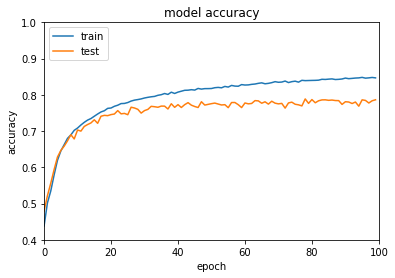

In [35]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.axis([0, 100, 0.4, 1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

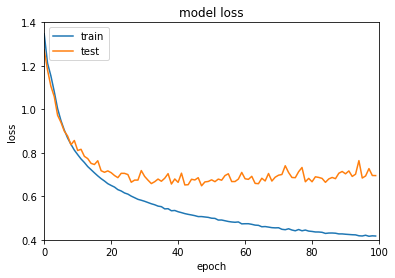

In [38]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.axis([0, 100, 0.4, 1.4])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 2. Optimales Modell finden mittels CV

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
#Optimierungsfunktion für Modell
def c_modelOpti(optimizer, activation):
    model = Sequential()
    model.add(Dense(34, input_dim = 34, activation = activation))
    model.add (Dense (100, activation = activation))
    model.add (Dense (100, activation = activation))
    model.add (Dense (7, activation = 'softmax'))
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["sparse_categorical_crossentropy","acc"])
    return model

In [41]:
from keras.wrappers.scikit_learn import KerasClassifier

In [42]:
model = KerasClassifier(build_fn=c_modelOpti)

epoches = [50, 100, 150]
optimizers = ['Adam', 'Adamax', 'SGD', 'RMSprop', 'Adadelta']
activations = ['softmax', 'relu', 'elu', 'selu', 'linear']

parameters = {'epochs': epoches, 'optimizer': optimizers, 'activation': activations}

clf = GridSearchCV(model, parameters)

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...\n')

# Modell trainieren
clf.fit(df_data_x, df_age_y, validation_split = 0.3)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(' ')
print(current_time2, 'Training beendet ...')

12.05.2020 09:22:00  Training gestartet ...



/home/sebastian/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 26341 samples, validate on 11289 samples
Epoch 1/50
26341/26341 [==============================] - 2s 84us/step - loss: 1.6725 - sparse_categorical_crossentropy: 1.6725 - acc: 0.3257 - val_loss: 1.5576 - val_sparse_categorical_crossentropy: 1.5576 - val_acc: 0.3312
Epoch 2/50
26341/26341 [==============================] - 2s 80us/step - loss: 1.5442 - sparse_categorical_crossentropy: 1.5442 - acc: 0.3335 - val_loss: 1.5313 - val_sparse_categorical_crossentropy: 1.5313 - val_acc: 0.3312
Epoch 3/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.5324 - sparse_categorical_crossentropy: 1.5324 - acc: 0.3335 - val_loss: 1.5262 - val_sparse_categorical_crossentropy: 1.5262 - val_acc: 0.3312
Epoch 4/50
26341/26341 [==============================] - 2s 79us/step - loss: 1.5295 - sparse_categorical_crossentropy: 1.5295 - acc: 0.3335 - val_loss: 1.5251 - val_sparse_categorical_crossentropy: 1.5251 - val_acc: 0.3312
Epoch 5/50
26341/26341 [==========================

Epoch 23/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 24/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3313
Epoch 25/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 26/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3313
Epoch 27/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.5304 - sparse_

Epoch 9/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5260 - val_sparse_categorical_crossentropy: 1.5260 - val_acc: 0.3362
Epoch 10/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5260 - val_sparse_categorical_crossentropy: 1.5260 - val_acc: 0.3362
Epoch 11/50
26341/26341 [==============================] - 2s 81us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5260 - val_sparse_categorical_crossentropy: 1.5260 - val_acc: 0.3362
Epoch 12/50
26341/26341 [==============================] - 2s 80us/step - loss: 1.5309 - sparse_categorical_crossentropy: 1.5309 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 13/50
26341/26341 [==============================] - 2s 80us/step - loss: 1.5308 - sparse_c

Epoch 31/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 32/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 33/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 34/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.5281 - sparse_categorical_crossentropy: 1.5281 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 35/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.5282 - sparse_

Epoch 17/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 18/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 19/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 20/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 21/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.5304 - sparse_

Epoch 3/50
26341/26341 [==============================] - 2s 79us/step - loss: 1.5323 - sparse_categorical_crossentropy: 1.5323 - acc: 0.3316 - val_loss: 1.5271 - val_sparse_categorical_crossentropy: 1.5271 - val_acc: 0.3362
Epoch 4/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.5314 - sparse_categorical_crossentropy: 1.5314 - acc: 0.3316 - val_loss: 1.5263 - val_sparse_categorical_crossentropy: 1.5263 - val_acc: 0.3362
Epoch 5/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.5311 - sparse_categorical_crossentropy: 1.5311 - acc: 0.3316 - val_loss: 1.5263 - val_sparse_categorical_crossentropy: 1.5263 - val_acc: 0.3362
Epoch 6/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.5310 - sparse_categorical_crossentropy: 1.5310 - acc: 0.3316 - val_loss: 1.5263 - val_sparse_categorical_crossentropy: 1.5263 - val_acc: 0.3362
Epoch 7/50
26341/26341 [==============================] - 2s 79us/step - loss: 1.5309 - sparse_categ

Epoch 25/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.5297 - sparse_categorical_crossentropy: 1.5297 - acc: 0.3335 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3312
Epoch 26/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.5296 - sparse_categorical_crossentropy: 1.5296 - acc: 0.3335 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3312
Epoch 27/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.5295 - sparse_categorical_crossentropy: 1.5295 - acc: 0.3335 - val_loss: 1.5256 - val_sparse_categorical_crossentropy: 1.5256 - val_acc: 0.3312
Epoch 28/50
26341/26341 [==============================] - 2s 70us/step - loss: 1.5294 - sparse_categorical_crossentropy: 1.5294 - acc: 0.3335 - val_loss: 1.5254 - val_sparse_categorical_crossentropy: 1.5254 - val_acc: 0.3312
Epoch 29/50
26341/26341 [==============================] - 2s 69us/step - loss: 1.5293 - sparse_

Epoch 11/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.5352 - sparse_categorical_crossentropy: 1.5352 - acc: 0.3305 - val_loss: 1.5289 - val_sparse_categorical_crossentropy: 1.5289 - val_acc: 0.3313
Epoch 12/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.5346 - sparse_categorical_crossentropy: 1.5346 - acc: 0.3305 - val_loss: 1.5284 - val_sparse_categorical_crossentropy: 1.5284 - val_acc: 0.3313
Epoch 13/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.5342 - sparse_categorical_crossentropy: 1.5342 - acc: 0.3305 - val_loss: 1.5280 - val_sparse_categorical_crossentropy: 1.5280 - val_acc: 0.3313
Epoch 14/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.5338 - sparse_categorical_crossentropy: 1.5338 - acc: 0.3305 - val_loss: 1.5277 - val_sparse_categorical_crossentropy: 1.5277 - val_acc: 0.3313
Epoch 15/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.5335 - sparse_

Epoch 33/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.5314 - sparse_categorical_crossentropy: 1.5314 - acc: 0.3316 - val_loss: 1.5269 - val_sparse_categorical_crossentropy: 1.5269 - val_acc: 0.3362
Epoch 34/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.5314 - sparse_categorical_crossentropy: 1.5314 - acc: 0.3316 - val_loss: 1.5267 - val_sparse_categorical_crossentropy: 1.5267 - val_acc: 0.3362
Epoch 35/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.5314 - sparse_categorical_crossentropy: 1.5314 - acc: 0.3316 - val_loss: 1.5266 - val_sparse_categorical_crossentropy: 1.5266 - val_acc: 0.3362
Epoch 36/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.5313 - sparse_categorical_crossentropy: 1.5313 - acc: 0.3316 - val_loss: 1.5266 - val_sparse_categorical_crossentropy: 1.5266 - val_acc: 0.3362
Epoch 37/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.5313 - sparse_

Epoch 19/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.5293 - sparse_categorical_crossentropy: 1.5293 - acc: 0.3335 - val_loss: 1.5250 - val_sparse_categorical_crossentropy: 1.5250 - val_acc: 0.3312
Epoch 20/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.5292 - sparse_categorical_crossentropy: 1.5292 - acc: 0.3335 - val_loss: 1.5251 - val_sparse_categorical_crossentropy: 1.5251 - val_acc: 0.3312
Epoch 21/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.5291 - sparse_categorical_crossentropy: 1.5291 - acc: 0.3335 - val_loss: 1.5252 - val_sparse_categorical_crossentropy: 1.5252 - val_acc: 0.3312
Epoch 22/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.5293 - sparse_categorical_crossentropy: 1.5293 - acc: 0.3335 - val_loss: 1.5247 - val_sparse_categorical_crossentropy: 1.5247 - val_acc: 0.3312
Epoch 23/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.5292 - sparse_

Epoch 5/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.5305 - sparse_categorical_crossentropy: 1.5305 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 6/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.5305 - sparse_categorical_crossentropy: 1.5305 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 7/50
26341/26341 [==============================] - 2s 75us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 8/50
26341/26341 [==============================] - 2s 76us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3305 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3313
Epoch 9/50
26341/26341 [==============================] - 2s 75us/step - loss: 1.5308 - sparse_categ

Epoch 27/50
26341/26341 [==============================] - 2s 75us/step - loss: 1.5315 - sparse_categorical_crossentropy: 1.5315 - acc: 0.3316 - val_loss: 1.5261 - val_sparse_categorical_crossentropy: 1.5261 - val_acc: 0.3362
Epoch 28/50
26341/26341 [==============================] - 2s 76us/step - loss: 1.5314 - sparse_categorical_crossentropy: 1.5314 - acc: 0.3316 - val_loss: 1.5262 - val_sparse_categorical_crossentropy: 1.5262 - val_acc: 0.3362
Epoch 29/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.5315 - sparse_categorical_crossentropy: 1.5315 - acc: 0.3316 - val_loss: 1.5260 - val_sparse_categorical_crossentropy: 1.5260 - val_acc: 0.3362
Epoch 30/50
26341/26341 [==============================] - 2s 76us/step - loss: 1.5315 - sparse_categorical_crossentropy: 1.5315 - acc: 0.3316 - val_loss: 1.5263 - val_sparse_categorical_crossentropy: 1.5263 - val_acc: 0.3362
Epoch 31/50
26341/26341 [==============================] - 2s 76us/step - loss: 1.5314 - sparse_

Epoch 13/50
26341/26341 [==============================] - 2s 79us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 14/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 15/50
26341/26341 [==============================] - 2s 79us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 16/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 17/50
26341/26341 [==============================] - 2s 79us/step - loss: 1.5283 - sparse_

Epoch 35/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 36/50
26341/26341 [==============================] - 2s 76us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3313
Epoch 37/50
26341/26341 [==============================] - 2s 76us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3313
Epoch 38/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 39/50
26341/26341 [==============================] - 2s 75us/step - loss: 1.5304 - sparse_

Epoch 21/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3362
Epoch 22/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 23/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 24/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 25/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.5308 - sparse_

Epoch 7/100
26341/26341 [==============================] - 2s 75us/step - loss: 1.5284 - sparse_categorical_crossentropy: 1.5284 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 8/100
26341/26341 [==============================] - 2s 75us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 9/100
26341/26341 [==============================] - 2s 75us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 10/100
26341/26341 [==============================] - 2s 76us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 11/100
26341/26341 [==============================] - 2s 75us/step - loss: 1.5283 - spars

26341/26341 [==============================] - 2s 73us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 80/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 81/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 82/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3312
Epoch 83/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.5283 - sparse_categori

Epoch 15/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3313
Epoch 16/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 17/100
26341/26341 [==============================] - 2s 76us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3313
Epoch 18/100
26341/26341 [==============================] - 2s 78us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 19/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.5140 - sp

26341/26341 [==============================] - 2s 73us/step - loss: 1.1282 - sparse_categorical_crossentropy: 1.1282 - acc: 0.5582 - val_loss: 1.1271 - val_sparse_categorical_crossentropy: 1.1271 - val_acc: 0.5559
Epoch 88/100
26341/26341 [==============================] - 2s 72us/step - loss: 1.1281 - sparse_categorical_crossentropy: 1.1281 - acc: 0.5597 - val_loss: 1.1282 - val_sparse_categorical_crossentropy: 1.1282 - val_acc: 0.5593
Epoch 89/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.1247 - sparse_categorical_crossentropy: 1.1247 - acc: 0.5589 - val_loss: 1.1267 - val_sparse_categorical_crossentropy: 1.1267 - val_acc: 0.5583
Epoch 90/100
26341/26341 [==============================] - 2s 72us/step - loss: 1.1235 - sparse_categorical_crossentropy: 1.1235 - acc: 0.5598 - val_loss: 1.1244 - val_sparse_categorical_crossentropy: 1.1244 - val_acc: 0.5564
Epoch 91/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.1235 - sparse_categori

Epoch 23/100
26341/26341 [==============================] - 2s 80us/step - loss: 1.5309 - sparse_categorical_crossentropy: 1.5309 - acc: 0.3316 - val_loss: 1.5256 - val_sparse_categorical_crossentropy: 1.5256 - val_acc: 0.3362
Epoch 24/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5309 - sparse_categorical_crossentropy: 1.5309 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 25/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 26/100
26341/26341 [==============================] - 2s 90us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5256 - val_sparse_categorical_crossentropy: 1.5256 - val_acc: 0.3362
Epoch 27/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5309 - sp

26341/26341 [==============================] - 2s 88us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5260 - val_sparse_categorical_crossentropy: 1.5260 - val_acc: 0.3362
Epoch 96/100
26341/26341 [==============================] - 2s 90us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 97/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3362
Epoch 98/100
26341/26341 [==============================] - 2s 92us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 99/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5308 - sparse_categori

Epoch 31/100
26341/26341 [==============================] - 2s 88us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 32/100
26341/26341 [==============================] - 2s 90us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 33/100
26341/26341 [==============================] - 2s 92us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 34/100
26341/26341 [==============================] - 2s 90us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 35/100
26341/26341 [==============================] - 2s 93us/step - loss: 1.5281 - sp

Epoch 3/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5324 - sparse_categorical_crossentropy: 1.5324 - acc: 0.3305 - val_loss: 1.5255 - val_sparse_categorical_crossentropy: 1.5255 - val_acc: 0.3313
Epoch 4/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5313 - sparse_categorical_crossentropy: 1.5313 - acc: 0.3305 - val_loss: 1.5248 - val_sparse_categorical_crossentropy: 1.5248 - val_acc: 0.3313
Epoch 5/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5309 - sparse_categorical_crossentropy: 1.5309 - acc: 0.3305 - val_loss: 1.5245 - val_sparse_categorical_crossentropy: 1.5245 - val_acc: 0.3313
Epoch 6/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3305 - val_loss: 1.5243 - val_sparse_categorical_crossentropy: 1.5243 - val_acc: 0.3313
Epoch 7/100
26341/26341 [==============================] - 2s 90us/step - loss: 1.5305 - sparse_

26341/26341 [==============================] - 2s 89us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3313
Epoch 76/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 77/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 78/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 79/100
26341/26341 [==============================] - 2s 88us/step - loss: 1.5304 - sparse_categori

Epoch 11/100
26341/26341 [==============================] - 2s 82us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 12/100
26341/26341 [==============================] - 2s 84us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3362
Epoch 13/100
26341/26341 [==============================] - 2s 84us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 14/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 15/100
26341/26341 [==============================] - 2s 84us/step - loss: 1.5308 - sp

26341/26341 [==============================] - 2s 82us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 84/100
26341/26341 [==============================] - 2s 82us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 85/100
26341/26341 [==============================] - 2s 83us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5263 - val_sparse_categorical_crossentropy: 1.5263 - val_acc: 0.3362
Epoch 86/100
26341/26341 [==============================] - 2s 81us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 87/100
26341/26341 [==============================] - 2s 83us/step - loss: 1.5307 - sparse_categori

Epoch 19/100
26341/26341 [==============================] - 2s 88us/step - loss: 1.5306 - sparse_categorical_crossentropy: 1.5306 - acc: 0.3335 - val_loss: 1.5265 - val_sparse_categorical_crossentropy: 1.5265 - val_acc: 0.3312
Epoch 20/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3335 - val_loss: 1.5263 - val_sparse_categorical_crossentropy: 1.5263 - val_acc: 0.3312
Epoch 21/100
26341/26341 [==============================] - 2s 86us/step - loss: 1.5302 - sparse_categorical_crossentropy: 1.5302 - acc: 0.3335 - val_loss: 1.5262 - val_sparse_categorical_crossentropy: 1.5262 - val_acc: 0.3312
Epoch 22/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5301 - sparse_categorical_crossentropy: 1.5301 - acc: 0.3335 - val_loss: 1.5260 - val_sparse_categorical_crossentropy: 1.5260 - val_acc: 0.3312
Epoch 23/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5300 - sp

26341/26341 [==============================] - 2s 88us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 92/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 93/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 94/100
26341/26341 [==============================] - 2s 88us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 95/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5282 - sparse_categori

Epoch 27/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5315 - sparse_categorical_crossentropy: 1.5315 - acc: 0.3305 - val_loss: 1.5254 - val_sparse_categorical_crossentropy: 1.5254 - val_acc: 0.3313
Epoch 28/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5314 - sparse_categorical_crossentropy: 1.5314 - acc: 0.3305 - val_loss: 1.5253 - val_sparse_categorical_crossentropy: 1.5253 - val_acc: 0.3313
Epoch 29/100
26341/26341 [==============================] - 2s 90us/step - loss: 1.5314 - sparse_categorical_crossentropy: 1.5314 - acc: 0.3305 - val_loss: 1.5252 - val_sparse_categorical_crossentropy: 1.5252 - val_acc: 0.3313
Epoch 30/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5313 - sparse_categorical_crossentropy: 1.5313 - acc: 0.3305 - val_loss: 1.5251 - val_sparse_categorical_crossentropy: 1.5251 - val_acc: 0.3313
Epoch 31/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5312 - sp

26341/26341 [==============================] - 2s 90us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3313
Epoch 100/100
18815/18815 [==============================] - 1s 40us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 92us/step - loss: 1.7236 - sparse_categorical_crossentropy: 1.7236 - acc: 0.3265 - val_loss: 1.6122 - val_sparse_categorical_crossentropy: 1.6122 - val_acc: 0.3362
Epoch 2/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5872 - sparse_categorical_crossentropy: 1.5872 - acc: 0.3316 - val_loss: 1.5634 - val_sparse_categorical_crossentropy: 1.5634 - val_acc: 0.3362
Epoch 3/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5596 - sparse_categorical_crossentropy: 1.5596 - acc: 0.3316 - val_loss: 1.5484 - val_sparse_categorical_crossentropy: 1.5484 - 

Epoch 35/100
26341/26341 [==============================] - 2s 88us/step - loss: 1.5314 - sparse_categorical_crossentropy: 1.5314 - acc: 0.3316 - val_loss: 1.5266 - val_sparse_categorical_crossentropy: 1.5266 - val_acc: 0.3362
Epoch 36/100
26341/26341 [==============================] - 2s 92us/step - loss: 1.5313 - sparse_categorical_crossentropy: 1.5313 - acc: 0.3316 - val_loss: 1.5266 - val_sparse_categorical_crossentropy: 1.5266 - val_acc: 0.3362
Epoch 37/100
26341/26341 [==============================] - 2s 92us/step - loss: 1.5313 - sparse_categorical_crossentropy: 1.5313 - acc: 0.3316 - val_loss: 1.5265 - val_sparse_categorical_crossentropy: 1.5265 - val_acc: 0.3362
Epoch 38/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.5312 - sparse_categorical_crossentropy: 1.5312 - acc: 0.3316 - val_loss: 1.5266 - val_sparse_categorical_crossentropy: 1.5266 - val_acc: 0.3362
Epoch 39/100
26341/26341 [==============================] - 2s 93us/step - loss: 1.5312 - sp

Epoch 7/100
26341/26341 [==============================] - 2s 90us/step - loss: 1.5285 - sparse_categorical_crossentropy: 1.5285 - acc: 0.3335 - val_loss: 1.5245 - val_sparse_categorical_crossentropy: 1.5245 - val_acc: 0.3312
Epoch 8/100
26341/26341 [==============================] - 2s 88us/step - loss: 1.5285 - sparse_categorical_crossentropy: 1.5285 - acc: 0.3335 - val_loss: 1.5244 - val_sparse_categorical_crossentropy: 1.5244 - val_acc: 0.3312
Epoch 9/100
26341/26341 [==============================] - 2s 90us/step - loss: 1.5287 - sparse_categorical_crossentropy: 1.5287 - acc: 0.3335 - val_loss: 1.5245 - val_sparse_categorical_crossentropy: 1.5245 - val_acc: 0.3312
Epoch 10/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5289 - sparse_categorical_crossentropy: 1.5289 - acc: 0.3335 - val_loss: 1.5246 - val_sparse_categorical_crossentropy: 1.5246 - val_acc: 0.3312
Epoch 11/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5289 - spars

26341/26341 [==============================] - 2s 86us/step - loss: 1.3313 - sparse_categorical_crossentropy: 1.3313 - acc: 0.4573 - val_loss: 1.3277 - val_sparse_categorical_crossentropy: 1.3277 - val_acc: 0.4597
Epoch 80/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.3271 - sparse_categorical_crossentropy: 1.3271 - acc: 0.4581 - val_loss: 1.3248 - val_sparse_categorical_crossentropy: 1.3248 - val_acc: 0.4616
Epoch 81/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.3227 - sparse_categorical_crossentropy: 1.3227 - acc: 0.4603 - val_loss: 1.3217 - val_sparse_categorical_crossentropy: 1.3217 - val_acc: 0.4600
Epoch 82/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.3188 - sparse_categorical_crossentropy: 1.3188 - acc: 0.4614 - val_loss: 1.3165 - val_sparse_categorical_crossentropy: 1.3165 - val_acc: 0.4609
Epoch 83/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.3153 - sparse_categori

Epoch 15/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5312 - sparse_categorical_crossentropy: 1.5312 - acc: 0.3305 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3313
Epoch 16/100
26341/26341 [==============================] - 2s 88us/step - loss: 1.5311 - sparse_categorical_crossentropy: 1.5311 - acc: 0.3305 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3313
Epoch 17/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5312 - sparse_categorical_crossentropy: 1.5312 - acc: 0.3305 - val_loss: 1.5244 - val_sparse_categorical_crossentropy: 1.5244 - val_acc: 0.3313
Epoch 18/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5311 - sparse_categorical_crossentropy: 1.5311 - acc: 0.3305 - val_loss: 1.5243 - val_sparse_categorical_crossentropy: 1.5243 - val_acc: 0.3313
Epoch 19/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5312 - sp

26341/26341 [==============================] - 2s 89us/step - loss: 1.5312 - sparse_categorical_crossentropy: 1.5312 - acc: 0.3305 - val_loss: 1.5244 - val_sparse_categorical_crossentropy: 1.5244 - val_acc: 0.3313
Epoch 88/100
26341/26341 [==============================] - 2s 90us/step - loss: 1.5312 - sparse_categorical_crossentropy: 1.5312 - acc: 0.3305 - val_loss: 1.5243 - val_sparse_categorical_crossentropy: 1.5243 - val_acc: 0.3313
Epoch 89/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5311 - sparse_categorical_crossentropy: 1.5311 - acc: 0.3305 - val_loss: 1.5244 - val_sparse_categorical_crossentropy: 1.5244 - val_acc: 0.3313
Epoch 90/100
26341/26341 [==============================] - 2s 88us/step - loss: 1.5309 - sparse_categorical_crossentropy: 1.5309 - acc: 0.3305 - val_loss: 1.5236 - val_sparse_categorical_crossentropy: 1.5236 - val_acc: 0.3313
Epoch 91/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5216 - sparse_categori

Epoch 23/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5315 - sparse_categorical_crossentropy: 1.5315 - acc: 0.3316 - val_loss: 1.5263 - val_sparse_categorical_crossentropy: 1.5263 - val_acc: 0.3362
Epoch 24/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5315 - sparse_categorical_crossentropy: 1.5315 - acc: 0.3316 - val_loss: 1.5263 - val_sparse_categorical_crossentropy: 1.5263 - val_acc: 0.3362
Epoch 25/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5315 - sparse_categorical_crossentropy: 1.5315 - acc: 0.3316 - val_loss: 1.5266 - val_sparse_categorical_crossentropy: 1.5266 - val_acc: 0.3362
Epoch 26/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5317 - sparse_categorical_crossentropy: 1.5317 - acc: 0.3316 - val_loss: 1.5262 - val_sparse_categorical_crossentropy: 1.5262 - val_acc: 0.3362
Epoch 27/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5317 - sp

26341/26341 [==============================] - 2s 85us/step - loss: 1.5316 - sparse_categorical_crossentropy: 1.5316 - acc: 0.3316 - val_loss: 1.5262 - val_sparse_categorical_crossentropy: 1.5262 - val_acc: 0.3362
Epoch 96/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5315 - sparse_categorical_crossentropy: 1.5315 - acc: 0.3316 - val_loss: 1.5262 - val_sparse_categorical_crossentropy: 1.5262 - val_acc: 0.3362
Epoch 97/100
26341/26341 [==============================] - 2s 84us/step - loss: 1.5316 - sparse_categorical_crossentropy: 1.5316 - acc: 0.3316 - val_loss: 1.5264 - val_sparse_categorical_crossentropy: 1.5264 - val_acc: 0.3362
Epoch 98/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5316 - sparse_categorical_crossentropy: 1.5316 - acc: 0.3316 - val_loss: 1.5262 - val_sparse_categorical_crossentropy: 1.5262 - val_acc: 0.3362
Epoch 99/100
26341/26341 [==============================] - 2s 83us/step - loss: 1.5316 - sparse_categori

Epoch 31/100
26341/26341 [==============================] - 2s 81us/step - loss: 1.5281 - sparse_categorical_crossentropy: 1.5281 - acc: 0.3335 - val_loss: 1.5243 - val_sparse_categorical_crossentropy: 1.5243 - val_acc: 0.3312
Epoch 32/100
26341/26341 [==============================] - 2s 82us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 33/100
26341/26341 [==============================] - 2s 82us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 34/100
26341/26341 [==============================] - 2s 81us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5243 - val_sparse_categorical_crossentropy: 1.5243 - val_acc: 0.3312
Epoch 35/100
26341/26341 [==============================] - 2s 82us/step - loss: 1.5283 - sp

Epoch 3/100
26341/26341 [==============================] - 2s 84us/step - loss: 1.5330 - sparse_categorical_crossentropy: 1.5330 - acc: 0.3305 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3313
Epoch 4/100
26341/26341 [==============================] - 2s 84us/step - loss: 1.5314 - sparse_categorical_crossentropy: 1.5314 - acc: 0.3305 - val_loss: 1.5249 - val_sparse_categorical_crossentropy: 1.5249 - val_acc: 0.3313
Epoch 5/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5309 - sparse_categorical_crossentropy: 1.5309 - acc: 0.3305 - val_loss: 1.5245 - val_sparse_categorical_crossentropy: 1.5245 - val_acc: 0.3313
Epoch 6/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3305 - val_loss: 1.5245 - val_sparse_categorical_crossentropy: 1.5245 - val_acc: 0.3313
Epoch 7/100
26341/26341 [==============================] - 2s 82us/step - loss: 1.5306 - sparse_

26341/26341 [==============================] - 2s 85us/step - loss: 1.5305 - sparse_categorical_crossentropy: 1.5305 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 76/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 77/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 78/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 79/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5304 - sparse_categori

Epoch 11/100
26341/26341 [==============================] - 2s 86us/step - loss: 1.5306 - sparse_categorical_crossentropy: 1.5306 - acc: 0.3316 - val_loss: 1.5261 - val_sparse_categorical_crossentropy: 1.5261 - val_acc: 0.3362
Epoch 12/100
26341/26341 [==============================] - 2s 86us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3362
Epoch 13/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 14/100
26341/26341 [==============================] - 2s 86us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5256 - val_sparse_categorical_crossentropy: 1.5256 - val_acc: 0.3362
Epoch 15/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.5308 - sp

26341/26341 [==============================] - 2s 87us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5261 - val_sparse_categorical_crossentropy: 1.5261 - val_acc: 0.3362
Epoch 84/100
26341/26341 [==============================] - 2s 86us/step - loss: 1.5309 - sparse_categorical_crossentropy: 1.5309 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 85/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5309 - sparse_categorical_crossentropy: 1.5309 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 86/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5309 - sparse_categorical_crossentropy: 1.5309 - acc: 0.3316 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3362
Epoch 87/100
26341/26341 [==============================] - 2s 85us/step - loss: 1.5308 - sparse_categori

Epoch 19/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5243 - val_sparse_categorical_crossentropy: 1.5243 - val_acc: 0.3312
Epoch 20/150
26341/26341 [==============================] - 2s 91us/step - loss: 1.5281 - sparse_categorical_crossentropy: 1.5281 - acc: 0.3335 - val_loss: 1.5246 - val_sparse_categorical_crossentropy: 1.5246 - val_acc: 0.3312
Epoch 21/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 22/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 23/150
26341/26341 [==============================] - 2s 88us/step - loss: 1.5283 - sp

26341/26341 [==============================] - 2s 85us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5246 - val_sparse_categorical_crossentropy: 1.5246 - val_acc: 0.3312
Epoch 92/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 93/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3312
Epoch 94/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 95/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5283 - sparse_categori

26341/26341 [==============================] - 2s 85us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 128/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 129/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5243 - val_sparse_categorical_crossentropy: 1.5243 - val_acc: 0.3312
Epoch 130/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 131/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5283 - sparse_cate

26341/26341 [==============================] - 2s 89us/step - loss: 1.2609 - sparse_categorical_crossentropy: 1.2609 - acc: 0.5037 - val_loss: 1.2730 - val_sparse_categorical_crossentropy: 1.2730 - val_acc: 0.4999
Epoch 49/150
26341/26341 [==============================] - 2s 92us/step - loss: 1.2593 - sparse_categorical_crossentropy: 1.2593 - acc: 0.5053 - val_loss: 1.2583 - val_sparse_categorical_crossentropy: 1.2583 - val_acc: 0.5029
Epoch 50/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.2564 - sparse_categorical_crossentropy: 1.2564 - acc: 0.5049 - val_loss: 1.2622 - val_sparse_categorical_crossentropy: 1.2622 - val_acc: 0.4998
Epoch 51/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.2549 - sparse_categorical_crossentropy: 1.2549 - acc: 0.5045 - val_loss: 1.2632 - val_sparse_categorical_crossentropy: 1.2632 - val_acc: 0.4989
Epoch 52/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.2546 - sparse_categori

26341/26341 [==============================] - 2s 88us/step - loss: 1.0922 - sparse_categorical_crossentropy: 1.0922 - acc: 0.5791 - val_loss: 1.0959 - val_sparse_categorical_crossentropy: 1.0959 - val_acc: 0.5755
Epoch 121/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.0906 - sparse_categorical_crossentropy: 1.0906 - acc: 0.5783 - val_loss: 1.0979 - val_sparse_categorical_crossentropy: 1.0979 - val_acc: 0.5712
Epoch 122/150
26341/26341 [==============================] - 2s 87us/step - loss: 1.0894 - sparse_categorical_crossentropy: 1.0894 - acc: 0.5777 - val_loss: 1.1014 - val_sparse_categorical_crossentropy: 1.1014 - val_acc: 0.5730
Epoch 123/150
26341/26341 [==============================] - 2s 88us/step - loss: 1.0880 - sparse_categorical_crossentropy: 1.0880 - acc: 0.5816 - val_loss: 1.0964 - val_sparse_categorical_crossentropy: 1.0964 - val_acc: 0.5745
Epoch 124/150
26341/26341 [==============================] - 2s 88us/step - loss: 1.0873 - sparse_cate

26341/26341 [==============================] - 2s 81us/step - loss: 1.2586 - sparse_categorical_crossentropy: 1.2586 - acc: 0.4879 - val_loss: 1.2451 - val_sparse_categorical_crossentropy: 1.2451 - val_acc: 0.4973
Epoch 42/150
26341/26341 [==============================] - 2s 83us/step - loss: 1.2577 - sparse_categorical_crossentropy: 1.2577 - acc: 0.4891 - val_loss: 1.2624 - val_sparse_categorical_crossentropy: 1.2624 - val_acc: 0.4903
Epoch 43/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.2562 - sparse_categorical_crossentropy: 1.2562 - acc: 0.4903 - val_loss: 1.2424 - val_sparse_categorical_crossentropy: 1.2424 - val_acc: 0.4991
Epoch 44/150
26341/26341 [==============================] - 2s 83us/step - loss: 1.2550 - sparse_categorical_crossentropy: 1.2550 - acc: 0.4905 - val_loss: 1.2396 - val_sparse_categorical_crossentropy: 1.2396 - val_acc: 0.5015
Epoch 45/150
26341/26341 [==============================] - 2s 83us/step - loss: 1.2536 - sparse_categori

26341/26341 [==============================] - 2s 81us/step - loss: 1.1787 - sparse_categorical_crossentropy: 1.1787 - acc: 0.5168 - val_loss: 1.1791 - val_sparse_categorical_crossentropy: 1.1791 - val_acc: 0.5082
Epoch 114/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.1771 - sparse_categorical_crossentropy: 1.1771 - acc: 0.5171 - val_loss: 1.1683 - val_sparse_categorical_crossentropy: 1.1683 - val_acc: 0.5201
Epoch 115/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.1755 - sparse_categorical_crossentropy: 1.1755 - acc: 0.5202 - val_loss: 1.2106 - val_sparse_categorical_crossentropy: 1.2106 - val_acc: 0.5089
Epoch 116/150
26341/26341 [==============================] - 2s 77us/step - loss: 1.1742 - sparse_categorical_crossentropy: 1.1742 - acc: 0.5202 - val_loss: 1.1663 - val_sparse_categorical_crossentropy: 1.1663 - val_acc: 0.5241
Epoch 117/150
26341/26341 [==============================] - 2s 83us/step - loss: 1.1728 - sparse_cate

Epoch 149/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.1382 - sparse_categorical_crossentropy: 1.1382 - acc: 0.5395 - val_loss: 1.1303 - val_sparse_categorical_crossentropy: 1.1303 - val_acc: 0.5413
Epoch 150/150
18815/18815 [==============================] - 1s 39us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/150
26341/26341 [==============================] - 2s 92us/step - loss: 1.6352 - sparse_categorical_crossentropy: 1.6352 - acc: 0.3324 - val_loss: 1.5398 - val_sparse_categorical_crossentropy: 1.5398 - val_acc: 0.3312
Epoch 2/150
26341/26341 [==============================] - 2s 88us/step - loss: 1.5345 - sparse_categorical_crossentropy: 1.5345 - acc: 0.3335 - val_loss: 1.5269 - val_sparse_categorical_crossentropy: 1.5269 - val_acc: 0.3312
Epoch 3/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.5297 - sparse_categorical_crossentropy: 1.5297 - acc: 0.3335 - val_loss: 1.5251 - val_sparse_categorical_crossentr

Epoch 35/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 36/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 37/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5281 - sparse_categorical_crossentropy: 1.5281 - acc: 0.3335 - val_loss: 1.5243 - val_sparse_categorical_crossentropy: 1.5243 - val_acc: 0.3312
Epoch 38/150
26341/26341 [==============================] - 2s 87us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 39/150
26341/26341 [==============================] - 2s 87us/step - loss: 1.5281 - sp

26341/26341 [==============================] - 2s 85us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 108/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3312
Epoch 109/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 110/150
26341/26341 [==============================] - 2s 83us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 111/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.5282 - sparse_cate

Epoch 143/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.5281 - sparse_categorical_crossentropy: 1.5281 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 144/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.5281 - sparse_categorical_crossentropy: 1.5281 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 145/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 146/150
26341/26341 [==============================] - 2s 83us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3312
Epoch 147/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.5282

Epoch 29/150
26341/26341 [==============================] - 2s 82us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 30/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3313
Epoch 31/150
26341/26341 [==============================] - 2s 83us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 32/150
26341/26341 [==============================] - 2s 83us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 33/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5303 - sp

26341/26341 [==============================] - 2s 86us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 102/150
26341/26341 [==============================] - 2s 83us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 103/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 104/150
26341/26341 [==============================] - 2s 83us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 105/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.5303 - sparse_cate

Epoch 137/150
26341/26341 [==============================] - 2s 82us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 138/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5302 - sparse_categorical_crossentropy: 1.5302 - acc: 0.3305 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3313
Epoch 139/150
26341/26341 [==============================] - 2s 82us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 140/150
26341/26341 [==============================] - 2s 83us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 141/150
26341/26341 [==============================] - 2s 84us/step - loss: 1.5303

26341/26341 [==============================] - 2s 78us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 59/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 60/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5261 - val_sparse_categorical_crossentropy: 1.5261 - val_acc: 0.3362
Epoch 61/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 62/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.5307 - sparse_categori

26341/26341 [==============================] - 2s 79us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3362
Epoch 131/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5260 - val_sparse_categorical_crossentropy: 1.5260 - val_acc: 0.3362
Epoch 132/150
26341/26341 [==============================] - 2s 79us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3362
Epoch 133/150
26341/26341 [==============================] - 2s 79us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3362
Epoch 134/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.5307 - sparse_cate

Epoch 16/150
26341/26341 [==============================] - 2s 91us/step - loss: 1.5313 - sparse_categorical_crossentropy: 1.5313 - acc: 0.3335 - val_loss: 1.5272 - val_sparse_categorical_crossentropy: 1.5272 - val_acc: 0.3312
Epoch 17/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.5310 - sparse_categorical_crossentropy: 1.5310 - acc: 0.3335 - val_loss: 1.5270 - val_sparse_categorical_crossentropy: 1.5270 - val_acc: 0.3312
Epoch 18/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3335 - val_loss: 1.5268 - val_sparse_categorical_crossentropy: 1.5268 - val_acc: 0.3312
Epoch 19/150
26341/26341 [==============================] - 2s 87us/step - loss: 1.5305 - sparse_categorical_crossentropy: 1.5305 - acc: 0.3335 - val_loss: 1.5265 - val_sparse_categorical_crossentropy: 1.5265 - val_acc: 0.3312
Epoch 20/150
26341/26341 [==============================] - 2s 88us/step - loss: 1.5304 - sp

26341/26341 [==============================] - 2s 85us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5243 - val_sparse_categorical_crossentropy: 1.5243 - val_acc: 0.3312
Epoch 89/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 90/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 91/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 92/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5282 - sparse_categori

26341/26341 [==============================] - 2s 86us/step - loss: 1.5281 - sparse_categorical_crossentropy: 1.5281 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 125/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5281 - sparse_categorical_crossentropy: 1.5281 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 126/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5281 - sparse_categorical_crossentropy: 1.5281 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 127/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5281 - sparse_categorical_crossentropy: 1.5281 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 128/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5281 - sparse_cate

26341/26341 [==============================] - 2s 86us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3305 - val_loss: 1.5245 - val_sparse_categorical_crossentropy: 1.5245 - val_acc: 0.3313
Epoch 46/150
26341/26341 [==============================] - 2s 87us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3305 - val_loss: 1.5245 - val_sparse_categorical_crossentropy: 1.5245 - val_acc: 0.3313
Epoch 47/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3305 - val_loss: 1.5244 - val_sparse_categorical_crossentropy: 1.5244 - val_acc: 0.3313
Epoch 48/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5306 - sparse_categorical_crossentropy: 1.5306 - acc: 0.3305 - val_loss: 1.5244 - val_sparse_categorical_crossentropy: 1.5244 - val_acc: 0.3313
Epoch 49/150
26341/26341 [==============================] - 2s 87us/step - loss: 1.5306 - sparse_categori

26341/26341 [==============================] - 2s 88us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 118/150
26341/26341 [==============================] - 2s 87us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3313
Epoch 119/150
26341/26341 [==============================] - 2s 87us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 120/150
26341/26341 [==============================] - 2s 82us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 121/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5302 - sparse_cate

26341/26341 [==============================] - 2s 89us/step - loss: 1.5312 - sparse_categorical_crossentropy: 1.5312 - acc: 0.3316 - val_loss: 1.5265 - val_sparse_categorical_crossentropy: 1.5265 - val_acc: 0.3362
Epoch 39/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.5312 - sparse_categorical_crossentropy: 1.5312 - acc: 0.3316 - val_loss: 1.5265 - val_sparse_categorical_crossentropy: 1.5265 - val_acc: 0.3362
Epoch 40/150
26341/26341 [==============================] - 2s 91us/step - loss: 1.5312 - sparse_categorical_crossentropy: 1.5312 - acc: 0.3316 - val_loss: 1.5265 - val_sparse_categorical_crossentropy: 1.5265 - val_acc: 0.3362
Epoch 41/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.5311 - sparse_categorical_crossentropy: 1.5311 - acc: 0.3316 - val_loss: 1.5264 - val_sparse_categorical_crossentropy: 1.5264 - val_acc: 0.3362
Epoch 42/150
26341/26341 [==============================] - 2s 91us/step - loss: 1.5311 - sparse_categori

26341/26341 [==============================] - 2s 90us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 111/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 112/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 113/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 114/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.5307 - sparse_cate

Epoch 146/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5306 - sparse_categorical_crossentropy: 1.5306 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 147/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 148/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5307 - sparse_categorical_crossentropy: 1.5307 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 149/150
26341/26341 [==============================] - 2s 85us/step - loss: 1.5306 - sparse_categorical_crossentropy: 1.5306 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 150/150
18815/18815 [==============================] - 1s 38us/step
Train on 26341

Epoch 32/150
26341/26341 [==============================] - 2s 88us/step - loss: 1.5294 - sparse_categorical_crossentropy: 1.5294 - acc: 0.3335 - val_loss: 1.5249 - val_sparse_categorical_crossentropy: 1.5249 - val_acc: 0.3312
Epoch 33/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.5293 - sparse_categorical_crossentropy: 1.5293 - acc: 0.3335 - val_loss: 1.5249 - val_sparse_categorical_crossentropy: 1.5249 - val_acc: 0.3312
Epoch 34/150
26341/26341 [==============================] - 2s 91us/step - loss: 1.5291 - sparse_categorical_crossentropy: 1.5291 - acc: 0.3335 - val_loss: 1.5250 - val_sparse_categorical_crossentropy: 1.5250 - val_acc: 0.3312
Epoch 35/150
26341/26341 [==============================] - 2s 88us/step - loss: 1.5290 - sparse_categorical_crossentropy: 1.5290 - acc: 0.3335 - val_loss: 1.5254 - val_sparse_categorical_crossentropy: 1.5254 - val_acc: 0.3312
Epoch 36/150
26341/26341 [==============================] - 2s 91us/step - loss: 1.5293 - sp

26341/26341 [==============================] - 2s 89us/step - loss: 1.3224 - sparse_categorical_crossentropy: 1.3224 - acc: 0.4607 - val_loss: 1.3289 - val_sparse_categorical_crossentropy: 1.3289 - val_acc: 0.4573
Epoch 105/150
26341/26341 [==============================] - 2s 88us/step - loss: 1.3211 - sparse_categorical_crossentropy: 1.3211 - acc: 0.4601 - val_loss: 1.3293 - val_sparse_categorical_crossentropy: 1.3293 - val_acc: 0.4590
Epoch 106/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.3199 - sparse_categorical_crossentropy: 1.3199 - acc: 0.4603 - val_loss: 1.3448 - val_sparse_categorical_crossentropy: 1.3448 - val_acc: 0.4558
Epoch 107/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.3192 - sparse_categorical_crossentropy: 1.3191 - acc: 0.4610 - val_loss: 1.3144 - val_sparse_categorical_crossentropy: 1.3144 - val_acc: 0.4603
Epoch 108/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.3177 - sparse_cate

Epoch 140/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.2599 - sparse_categorical_crossentropy: 1.2599 - acc: 0.4908 - val_loss: 1.2622 - val_sparse_categorical_crossentropy: 1.2622 - val_acc: 0.4899
Epoch 141/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.2598 - sparse_categorical_crossentropy: 1.2598 - acc: 0.4911 - val_loss: 1.2595 - val_sparse_categorical_crossentropy: 1.2595 - val_acc: 0.4907
Epoch 142/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.2594 - sparse_categorical_crossentropy: 1.2594 - acc: 0.4909 - val_loss: 1.2656 - val_sparse_categorical_crossentropy: 1.2656 - val_acc: 0.4876
Epoch 143/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.2583 - sparse_categorical_crossentropy: 1.2583 - acc: 0.4921 - val_loss: 1.2702 - val_sparse_categorical_crossentropy: 1.2702 - val_acc: 0.4864
Epoch 144/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.2573

26341/26341 [==============================] - 2s 81us/step - loss: 1.5311 - sparse_categorical_crossentropy: 1.5311 - acc: 0.3305 - val_loss: 1.5244 - val_sparse_categorical_crossentropy: 1.5244 - val_acc: 0.3313
Epoch 62/150
26341/26341 [==============================] - 2s 79us/step - loss: 1.5313 - sparse_categorical_crossentropy: 1.5313 - acc: 0.3305 - val_loss: 1.5244 - val_sparse_categorical_crossentropy: 1.5244 - val_acc: 0.3313
Epoch 63/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.5313 - sparse_categorical_crossentropy: 1.5313 - acc: 0.3305 - val_loss: 1.5244 - val_sparse_categorical_crossentropy: 1.5244 - val_acc: 0.3313
Epoch 64/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.5313 - sparse_categorical_crossentropy: 1.5313 - acc: 0.3305 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3313
Epoch 65/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.5313 - sparse_categori

26341/26341 [==============================] - 2s 83us/step - loss: 1.3097 - sparse_categorical_crossentropy: 1.3097 - acc: 0.4735 - val_loss: 1.3025 - val_sparse_categorical_crossentropy: 1.3025 - val_acc: 0.4729
Epoch 134/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.3068 - sparse_categorical_crossentropy: 1.3068 - acc: 0.4726 - val_loss: 1.2996 - val_sparse_categorical_crossentropy: 1.2996 - val_acc: 0.4708
Epoch 135/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.3034 - sparse_categorical_crossentropy: 1.3034 - acc: 0.4717 - val_loss: 1.3182 - val_sparse_categorical_crossentropy: 1.3182 - val_acc: 0.4642
Epoch 136/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.2998 - sparse_categorical_crossentropy: 1.2998 - acc: 0.4728 - val_loss: 1.2979 - val_sparse_categorical_crossentropy: 1.2979 - val_acc: 0.4703
Epoch 137/150
26341/26341 [==============================] - 2s 82us/step - loss: 1.2955 - sparse_cate

Epoch 19/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.5316 - sparse_categorical_crossentropy: 1.5316 - acc: 0.3316 - val_loss: 1.5264 - val_sparse_categorical_crossentropy: 1.5264 - val_acc: 0.3362
Epoch 20/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.5315 - sparse_categorical_crossentropy: 1.5315 - acc: 0.3316 - val_loss: 1.5262 - val_sparse_categorical_crossentropy: 1.5262 - val_acc: 0.3362
Epoch 21/150
26341/26341 [==============================] - 2s 87us/step - loss: 1.5315 - sparse_categorical_crossentropy: 1.5315 - acc: 0.3316 - val_loss: 1.5263 - val_sparse_categorical_crossentropy: 1.5263 - val_acc: 0.3362
Epoch 22/150
26341/26341 [==============================] - 2s 89us/step - loss: 1.5315 - sparse_categorical_crossentropy: 1.5315 - acc: 0.3316 - val_loss: 1.5262 - val_sparse_categorical_crossentropy: 1.5262 - val_acc: 0.3362
Epoch 23/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.5315 - sp

26341/26341 [==============================] - 2s 90us/step - loss: 1.5314 - sparse_categorical_crossentropy: 1.5314 - acc: 0.3316 - val_loss: 1.5261 - val_sparse_categorical_crossentropy: 1.5261 - val_acc: 0.3362
Epoch 92/150
26341/26341 [==============================] - 2s 91us/step - loss: 1.5314 - sparse_categorical_crossentropy: 1.5314 - acc: 0.3316 - val_loss: 1.5263 - val_sparse_categorical_crossentropy: 1.5263 - val_acc: 0.3362
Epoch 93/150
26341/26341 [==============================] - 2s 92us/step - loss: 1.5313 - sparse_categorical_crossentropy: 1.5313 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 94/150
26341/26341 [==============================] - 2s 86us/step - loss: 1.5253 - sparse_categorical_crossentropy: 1.5253 - acc: 0.3387 - val_loss: 1.5057 - val_sparse_categorical_crossentropy: 1.5057 - val_acc: 0.4203
Epoch 95/150
26341/26341 [==============================] - 2s 90us/step - loss: 1.4815 - sparse_categori

26341/26341 [==============================] - 2s 67us/step - loss: 1.2884 - sparse_categorical_crossentropy: 1.2884 - acc: 0.4868 - val_loss: 1.2792 - val_sparse_categorical_crossentropy: 1.2792 - val_acc: 0.4934
Epoch 128/150
26341/26341 [==============================] - 2s 72us/step - loss: 1.2864 - sparse_categorical_crossentropy: 1.2864 - acc: 0.4886 - val_loss: 1.2974 - val_sparse_categorical_crossentropy: 1.2974 - val_acc: 0.4851
Epoch 129/150
26341/26341 [==============================] - 2s 70us/step - loss: 1.2860 - sparse_categorical_crossentropy: 1.2860 - acc: 0.4873 - val_loss: 1.3375 - val_sparse_categorical_crossentropy: 1.3375 - val_acc: 0.4678
Epoch 130/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.2859 - sparse_categorical_crossentropy: 1.2859 - acc: 0.4875 - val_loss: 1.2756 - val_sparse_categorical_crossentropy: 1.2756 - val_acc: 0.4925
Epoch 131/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.2854 - sparse_cate

26341/26341 [==============================] - 2s 74us/step - loss: 1.5282 - sparse_categorical_crossentropy: 1.5282 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 49/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 50/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 51/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5243 - val_sparse_categorical_crossentropy: 1.5243 - val_acc: 0.3312
Epoch 52/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.5283 - sparse_categori

26341/26341 [==============================] - 2s 73us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3312
Epoch 121/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 122/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.5284 - sparse_categorical_crossentropy: 1.5284 - acc: 0.3335 - val_loss: 1.5242 - val_sparse_categorical_crossentropy: 1.5242 - val_acc: 0.3312
Epoch 123/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.5283 - sparse_categorical_crossentropy: 1.5283 - acc: 0.3335 - val_loss: 1.5243 - val_sparse_categorical_crossentropy: 1.5243 - val_acc: 0.3312
Epoch 124/150
26341/26341 [==============================] - 2s 72us/step - loss: 1.5283 - sparse_cate

26341/26341 [==============================] - 2s 71us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 42/150
26341/26341 [==============================] - 2s 70us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 43/150
26341/26341 [==============================] - 2s 71us/step - loss: 1.5303 - sparse_categorical_crossentropy: 1.5303 - acc: 0.3305 - val_loss: 1.5240 - val_sparse_categorical_crossentropy: 1.5240 - val_acc: 0.3313
Epoch 44/150
26341/26341 [==============================] - 2s 71us/step - loss: 1.5305 - sparse_categorical_crossentropy: 1.5305 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 45/150
26341/26341 [==============================] - 2s 70us/step - loss: 1.5304 - sparse_categori

26341/26341 [==============================] - 2s 71us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 114/150
26341/26341 [==============================] - 2s 70us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 115/150
26341/26341 [==============================] - 2s 71us/step - loss: 1.5305 - sparse_categorical_crossentropy: 1.5305 - acc: 0.3305 - val_loss: 1.5238 - val_sparse_categorical_crossentropy: 1.5238 - val_acc: 0.3313
Epoch 116/150
26341/26341 [==============================] - 2s 71us/step - loss: 1.5304 - sparse_categorical_crossentropy: 1.5304 - acc: 0.3305 - val_loss: 1.5241 - val_sparse_categorical_crossentropy: 1.5241 - val_acc: 0.3313
Epoch 117/150
26341/26341 [==============================] - 2s 71us/step - loss: 1.5304 - sparse_cate

Epoch 149/150
26341/26341 [==============================] - 2s 71us/step - loss: 1.5305 - sparse_categorical_crossentropy: 1.5305 - acc: 0.3305 - val_loss: 1.5239 - val_sparse_categorical_crossentropy: 1.5239 - val_acc: 0.3313
Epoch 150/150
18815/18815 [==============================] - 1s 28us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/150
26341/26341 [==============================] - 2s 82us/step - loss: 1.6596 - sparse_categorical_crossentropy: 1.6596 - acc: 0.3223 - val_loss: 1.5529 - val_sparse_categorical_crossentropy: 1.5529 - val_acc: 0.3362
Epoch 2/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.5431 - sparse_categorical_crossentropy: 1.5431 - acc: 0.3316 - val_loss: 1.5309 - val_sparse_categorical_crossentropy: 1.5309 - val_acc: 0.3362
Epoch 3/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.5334 - sparse_categorical_crossentropy: 1.5334 - acc: 0.3316 - val_loss: 1.5276 - val_sparse_categorical_crossentr

Epoch 35/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5256 - val_sparse_categorical_crossentropy: 1.5256 - val_acc: 0.3362
Epoch 36/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 37/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 38/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 39/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.5308 - sp

26341/26341 [==============================] - 2s 72us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 108/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5259 - val_sparse_categorical_crossentropy: 1.5259 - val_acc: 0.3362
Epoch 109/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5262 - val_sparse_categorical_crossentropy: 1.5262 - val_acc: 0.3362
Epoch 110/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.5309 - sparse_categorical_crossentropy: 1.5309 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 111/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.5308 - sparse_cate

Epoch 143/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5261 - val_sparse_categorical_crossentropy: 1.5261 - val_acc: 0.3362
Epoch 144/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.5309 - sparse_categorical_crossentropy: 1.5309 - acc: 0.3316 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3362
Epoch 145/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5257 - val_sparse_categorical_crossentropy: 1.5257 - val_acc: 0.3362
Epoch 146/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.5308 - sparse_categorical_crossentropy: 1.5308 - acc: 0.3316 - val_loss: 1.5258 - val_sparse_categorical_crossentropy: 1.5258 - val_acc: 0.3362
Epoch 147/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.5308

Epoch 29/50
26341/26341 [==============================] - 2s 60us/step - loss: 0.7259 - sparse_categorical_crossentropy: 0.7259 - acc: 0.7369 - val_loss: 0.7804 - val_sparse_categorical_crossentropy: 0.7804 - val_acc: 0.7234
Epoch 30/50
26341/26341 [==============================] - 2s 60us/step - loss: 0.7158 - sparse_categorical_crossentropy: 0.7158 - acc: 0.7394 - val_loss: 0.7969 - val_sparse_categorical_crossentropy: 0.7969 - val_acc: 0.7136
Epoch 31/50
26341/26341 [==============================] - 2s 60us/step - loss: 0.7058 - sparse_categorical_crossentropy: 0.7058 - acc: 0.7428 - val_loss: 0.7748 - val_sparse_categorical_crossentropy: 0.7748 - val_acc: 0.7232
Epoch 32/50
26341/26341 [==============================] - 2s 60us/step - loss: 0.7015 - sparse_categorical_crossentropy: 0.7015 - acc: 0.7455 - val_loss: 0.7556 - val_sparse_categorical_crossentropy: 0.7557 - val_acc: 0.7273
Epoch 33/50
26341/26341 [==============================] - 2s 59us/step - loss: 0.6949 - sparse_

Epoch 15/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.8804 - sparse_categorical_crossentropy: 0.8804 - acc: 0.6777 - val_loss: 0.9108 - val_sparse_categorical_crossentropy: 0.9108 - val_acc: 0.6632
Epoch 16/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.8599 - sparse_categorical_crossentropy: 0.8599 - acc: 0.6846 - val_loss: 0.8550 - val_sparse_categorical_crossentropy: 0.8550 - val_acc: 0.6882
Epoch 17/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.8408 - sparse_categorical_crossentropy: 0.8408 - acc: 0.6934 - val_loss: 0.8554 - val_sparse_categorical_crossentropy: 0.8554 - val_acc: 0.6901
Epoch 18/50
26341/26341 [==============================] - 2s 63us/step - loss: 0.8229 - sparse_categorical_crossentropy: 0.8229 - acc: 0.6991 - val_loss: 0.8401 - val_sparse_categorical_crossentropy: 0.8401 - val_acc: 0.6919
Epoch 19/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.8084 - sparse_

Train on 26341 samples, validate on 11290 samples
Epoch 1/50
26341/26341 [==============================] - 2s 75us/step - loss: 1.4566 - sparse_categorical_crossentropy: 1.4566 - acc: 0.3905 - val_loss: 1.3385 - val_sparse_categorical_crossentropy: 1.3385 - val_acc: 0.4369
Epoch 2/50
26341/26341 [==============================] - 2s 69us/step - loss: 1.3123 - sparse_categorical_crossentropy: 1.3123 - acc: 0.4610 - val_loss: 1.2794 - val_sparse_categorical_crossentropy: 1.2794 - val_acc: 0.4830
Epoch 3/50
26341/26341 [==============================] - 2s 70us/step - loss: 1.2633 - sparse_categorical_crossentropy: 1.2633 - acc: 0.4786 - val_loss: 1.2332 - val_sparse_categorical_crossentropy: 1.2332 - val_acc: 0.4853
Epoch 4/50
26341/26341 [==============================] - 2s 70us/step - loss: 1.2307 - sparse_categorical_crossentropy: 1.2307 - acc: 0.4954 - val_loss: 1.2256 - val_sparse_categorical_crossentropy: 1.2256 - val_acc: 0.5118
Epoch 5/50
26341/26341 [==========================

Epoch 23/50
26341/26341 [==============================] - 2s 63us/step - loss: 0.9094 - sparse_categorical_crossentropy: 0.9094 - acc: 0.6651 - val_loss: 0.9349 - val_sparse_categorical_crossentropy: 0.9349 - val_acc: 0.6537
Epoch 24/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.8989 - sparse_categorical_crossentropy: 0.8989 - acc: 0.6664 - val_loss: 0.9178 - val_sparse_categorical_crossentropy: 0.9178 - val_acc: 0.6598
Epoch 25/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.8882 - sparse_categorical_crossentropy: 0.8882 - acc: 0.6749 - val_loss: 0.9239 - val_sparse_categorical_crossentropy: 0.9239 - val_acc: 0.6600
Epoch 26/50
26341/26341 [==============================] - 2s 63us/step - loss: 0.8782 - sparse_categorical_crossentropy: 0.8782 - acc: 0.6786 - val_loss: 0.8919 - val_sparse_categorical_crossentropy: 0.8919 - val_acc: 0.6722
Epoch 27/50
26341/26341 [==============================] - 2s 63us/step - loss: 0.8655 - sparse_

Epoch 9/50
26341/26341 [==============================] - 2s 65us/step - loss: 1.1031 - sparse_categorical_crossentropy: 1.1031 - acc: 0.5696 - val_loss: 1.0776 - val_sparse_categorical_crossentropy: 1.0776 - val_acc: 0.5828
Epoch 10/50
26341/26341 [==============================] - 2s 65us/step - loss: 1.0865 - sparse_categorical_crossentropy: 1.0865 - acc: 0.5789 - val_loss: 1.1085 - val_sparse_categorical_crossentropy: 1.1085 - val_acc: 0.5808
Epoch 11/50
26341/26341 [==============================] - 2s 65us/step - loss: 1.0667 - sparse_categorical_crossentropy: 1.0667 - acc: 0.5912 - val_loss: 1.0706 - val_sparse_categorical_crossentropy: 1.0706 - val_acc: 0.5914
Epoch 12/50
26341/26341 [==============================] - 2s 65us/step - loss: 1.0472 - sparse_categorical_crossentropy: 1.0472 - acc: 0.6026 - val_loss: 1.0575 - val_sparse_categorical_crossentropy: 1.0575 - val_acc: 0.6050
Epoch 13/50
26341/26341 [==============================] - 2s 64us/step - loss: 1.0315 - sparse_c

Epoch 31/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.8061 - sparse_categorical_crossentropy: 0.8061 - acc: 0.7078 - val_loss: 0.8273 - val_sparse_categorical_crossentropy: 0.8273 - val_acc: 0.7009
Epoch 32/50
26341/26341 [==============================] - 2s 63us/step - loss: 0.7943 - sparse_categorical_crossentropy: 0.7943 - acc: 0.7138 - val_loss: 0.8154 - val_sparse_categorical_crossentropy: 0.8154 - val_acc: 0.7093
Epoch 33/50
26341/26341 [==============================] - 2s 63us/step - loss: 0.7847 - sparse_categorical_crossentropy: 0.7847 - acc: 0.7165 - val_loss: 0.8152 - val_sparse_categorical_crossentropy: 0.8152 - val_acc: 0.7081
Epoch 34/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.7755 - sparse_categorical_crossentropy: 0.7755 - acc: 0.7202 - val_loss: 0.8078 - val_sparse_categorical_crossentropy: 0.8078 - val_acc: 0.7084
Epoch 35/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.7693 - sparse_

Epoch 17/50
26341/26341 [==============================] - 2s 64us/step - loss: 1.3374 - sparse_categorical_crossentropy: 1.3374 - acc: 0.4400 - val_loss: 1.4263 - val_sparse_categorical_crossentropy: 1.4263 - val_acc: 0.3848
Epoch 18/50
26341/26341 [==============================] - 2s 65us/step - loss: 1.3328 - sparse_categorical_crossentropy: 1.3328 - acc: 0.4433 - val_loss: 1.7013 - val_sparse_categorical_crossentropy: 1.7013 - val_acc: 0.2575
Epoch 19/50
26341/26341 [==============================] - 2s 64us/step - loss: 1.3242 - sparse_categorical_crossentropy: 1.3242 - acc: 0.4465 - val_loss: 1.3894 - val_sparse_categorical_crossentropy: 1.3894 - val_acc: 0.4295
Epoch 20/50
26341/26341 [==============================] - 2s 65us/step - loss: 1.3274 - sparse_categorical_crossentropy: 1.3274 - acc: 0.4488 - val_loss: 1.4323 - val_sparse_categorical_crossentropy: 1.4323 - val_acc: 0.3688
Epoch 21/50
26341/26341 [==============================] - 2s 65us/step - loss: 1.3156 - sparse_

Epoch 3/50
26341/26341 [==============================] - 2s 63us/step - loss: 1.4949 - sparse_categorical_crossentropy: 1.4949 - acc: 0.3760 - val_loss: 1.4786 - val_sparse_categorical_crossentropy: 1.4786 - val_acc: 0.3860
Epoch 4/50
26341/26341 [==============================] - 2s 63us/step - loss: 1.4822 - sparse_categorical_crossentropy: 1.4822 - acc: 0.3846 - val_loss: 1.5554 - val_sparse_categorical_crossentropy: 1.5554 - val_acc: 0.3209
Epoch 5/50
26341/26341 [==============================] - 2s 61us/step - loss: 1.4700 - sparse_categorical_crossentropy: 1.4700 - acc: 0.3888 - val_loss: 1.7031 - val_sparse_categorical_crossentropy: 1.7031 - val_acc: 0.3313
Epoch 6/50
26341/26341 [==============================] - 2s 59us/step - loss: 1.4555 - sparse_categorical_crossentropy: 1.4555 - acc: 0.3946 - val_loss: 1.5939 - val_sparse_categorical_crossentropy: 1.5939 - val_acc: 0.3366
Epoch 7/50
26341/26341 [==============================] - 2s 59us/step - loss: 1.4498 - sparse_categ

Epoch 25/50
26341/26341 [==============================] - 2s 60us/step - loss: 1.3075 - sparse_categorical_crossentropy: 1.3075 - acc: 0.4588 - val_loss: 1.5286 - val_sparse_categorical_crossentropy: 1.5286 - val_acc: 0.3458
Epoch 26/50
26341/26341 [==============================] - 2s 59us/step - loss: 1.3065 - sparse_categorical_crossentropy: 1.3065 - acc: 0.4617 - val_loss: 1.3648 - val_sparse_categorical_crossentropy: 1.3648 - val_acc: 0.4676
Epoch 27/50
26341/26341 [==============================] - 2s 61us/step - loss: 1.3023 - sparse_categorical_crossentropy: 1.3023 - acc: 0.4641 - val_loss: 1.5201 - val_sparse_categorical_crossentropy: 1.5201 - val_acc: 0.4007
Epoch 28/50
26341/26341 [==============================] - 2s 60us/step - loss: 1.2988 - sparse_categorical_crossentropy: 1.2988 - acc: 0.4668 - val_loss: 1.5533 - val_sparse_categorical_crossentropy: 1.5533 - val_acc: 0.3039
Epoch 29/50
26341/26341 [==============================] - 2s 59us/step - loss: 1.2860 - sparse_

Epoch 11/50
26341/26341 [==============================] - 2s 61us/step - loss: 0.9721 - sparse_categorical_crossentropy: 0.9721 - acc: 0.6351 - val_loss: 0.9775 - val_sparse_categorical_crossentropy: 0.9775 - val_acc: 0.6342
Epoch 12/50
26341/26341 [==============================] - 2s 60us/step - loss: 0.9489 - sparse_categorical_crossentropy: 0.9489 - acc: 0.6442 - val_loss: 1.0505 - val_sparse_categorical_crossentropy: 1.0505 - val_acc: 0.5806
Epoch 13/50
26341/26341 [==============================] - 2s 61us/step - loss: 0.9251 - sparse_categorical_crossentropy: 0.9251 - acc: 0.6555 - val_loss: 0.9899 - val_sparse_categorical_crossentropy: 0.9899 - val_acc: 0.6267
Epoch 14/50
26341/26341 [==============================] - 2s 61us/step - loss: 0.9046 - sparse_categorical_crossentropy: 0.9046 - acc: 0.6668 - val_loss: 0.9556 - val_sparse_categorical_crossentropy: 0.9556 - val_acc: 0.6449
Epoch 15/50
26341/26341 [==============================] - 2s 61us/step - loss: 0.8878 - sparse_

Epoch 33/50
26341/26341 [==============================] - 2s 61us/step - loss: 0.7544 - sparse_categorical_crossentropy: 0.7544 - acc: 0.7277 - val_loss: 0.9179 - val_sparse_categorical_crossentropy: 0.9179 - val_acc: 0.6855
Epoch 34/50
26341/26341 [==============================] - 2s 61us/step - loss: 0.7517 - sparse_categorical_crossentropy: 0.7517 - acc: 0.7352 - val_loss: 0.8689 - val_sparse_categorical_crossentropy: 0.8689 - val_acc: 0.6919
Epoch 35/50
26341/26341 [==============================] - 2s 61us/step - loss: 0.7474 - sparse_categorical_crossentropy: 0.7474 - acc: 0.7321 - val_loss: 0.8654 - val_sparse_categorical_crossentropy: 0.8654 - val_acc: 0.6960
Epoch 36/50
26341/26341 [==============================] - 2s 61us/step - loss: 0.7473 - sparse_categorical_crossentropy: 0.7473 - acc: 0.7318 - val_loss: 0.9189 - val_sparse_categorical_crossentropy: 0.9189 - val_acc: 0.6807
Epoch 37/50
26341/26341 [==============================] - 2s 61us/step - loss: 0.7476 - sparse_

Epoch 19/50
26341/26341 [==============================] - 2s 61us/step - loss: 0.8395 - sparse_categorical_crossentropy: 0.8395 - acc: 0.6939 - val_loss: 0.8859 - val_sparse_categorical_crossentropy: 0.8859 - val_acc: 0.6812
Epoch 20/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.8272 - sparse_categorical_crossentropy: 0.8272 - acc: 0.7008 - val_loss: 0.8540 - val_sparse_categorical_crossentropy: 0.8540 - val_acc: 0.6973
Epoch 21/50
26341/26341 [==============================] - 2s 61us/step - loss: 0.8178 - sparse_categorical_crossentropy: 0.8178 - acc: 0.7013 - val_loss: 0.8891 - val_sparse_categorical_crossentropy: 0.8891 - val_acc: 0.6810
Epoch 22/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.8090 - sparse_categorical_crossentropy: 0.8090 - acc: 0.7095 - val_loss: 0.9241 - val_sparse_categorical_crossentropy: 0.9241 - val_acc: 0.6821
Epoch 23/50
26341/26341 [==============================] - 2s 62us/step - loss: 0.8019 - sparse_

Epoch 5/50
26341/26341 [==============================] - 2s 66us/step - loss: 1.1468 - sparse_categorical_crossentropy: 1.1468 - acc: 0.5442 - val_loss: 1.2320 - val_sparse_categorical_crossentropy: 1.2320 - val_acc: 0.5196
Epoch 6/50
26341/26341 [==============================] - 2s 67us/step - loss: 1.1105 - sparse_categorical_crossentropy: 1.1105 - acc: 0.5617 - val_loss: 1.1934 - val_sparse_categorical_crossentropy: 1.1934 - val_acc: 0.5238
Epoch 7/50
26341/26341 [==============================] - 2s 68us/step - loss: 1.0778 - sparse_categorical_crossentropy: 1.0778 - acc: 0.5845 - val_loss: 1.1264 - val_sparse_categorical_crossentropy: 1.1264 - val_acc: 0.5387
Epoch 8/50
26341/26341 [==============================] - 2s 66us/step - loss: 1.0479 - sparse_categorical_crossentropy: 1.0479 - acc: 0.5969 - val_loss: 1.0792 - val_sparse_categorical_crossentropy: 1.0792 - val_acc: 0.5630
Epoch 9/50
26341/26341 [==============================] - 2s 66us/step - loss: 1.0165 - sparse_categ

Epoch 27/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.8114 - sparse_categorical_crossentropy: 0.8114 - acc: 0.6986 - val_loss: 0.9154 - val_sparse_categorical_crossentropy: 0.9154 - val_acc: 0.6634
Epoch 28/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.8071 - sparse_categorical_crossentropy: 0.8071 - acc: 0.7035 - val_loss: 0.9451 - val_sparse_categorical_crossentropy: 0.9451 - val_acc: 0.6531
Epoch 29/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.8020 - sparse_categorical_crossentropy: 0.8020 - acc: 0.7052 - val_loss: 0.8729 - val_sparse_categorical_crossentropy: 0.8729 - val_acc: 0.6742
Epoch 30/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.7934 - sparse_categorical_crossentropy: 0.7934 - acc: 0.7107 - val_loss: 0.8709 - val_sparse_categorical_crossentropy: 0.8709 - val_acc: 0.6787
Epoch 31/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.7885 - sparse_

Epoch 13/50
26341/26341 [==============================] - 2s 67us/step - loss: 1.0133 - sparse_categorical_crossentropy: 1.0133 - acc: 0.6155 - val_loss: 1.0467 - val_sparse_categorical_crossentropy: 1.0467 - val_acc: 0.5904
Epoch 14/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.9941 - sparse_categorical_crossentropy: 0.9941 - acc: 0.6255 - val_loss: 1.0223 - val_sparse_categorical_crossentropy: 1.0223 - val_acc: 0.6183
Epoch 15/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.9750 - sparse_categorical_crossentropy: 0.9750 - acc: 0.6317 - val_loss: 1.0521 - val_sparse_categorical_crossentropy: 1.0521 - val_acc: 0.5974
Epoch 16/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.9551 - sparse_categorical_crossentropy: 0.9551 - acc: 0.6396 - val_loss: 0.9446 - val_sparse_categorical_crossentropy: 0.9446 - val_acc: 0.6528
Epoch 17/50
26341/26341 [==============================] - 2s 67us/step - loss: 0.9340 - sparse_

Epoch 35/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.7262 - sparse_categorical_crossentropy: 0.7262 - acc: 0.7376 - val_loss: 0.7905 - val_sparse_categorical_crossentropy: 0.7905 - val_acc: 0.7120
Epoch 36/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.7184 - sparse_categorical_crossentropy: 0.7184 - acc: 0.7387 - val_loss: 0.7611 - val_sparse_categorical_crossentropy: 0.7611 - val_acc: 0.7234
Epoch 37/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.7125 - sparse_categorical_crossentropy: 0.7125 - acc: 0.7406 - val_loss: 0.7730 - val_sparse_categorical_crossentropy: 0.7730 - val_acc: 0.7197
Epoch 38/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.7045 - sparse_categorical_crossentropy: 0.7045 - acc: 0.7445 - val_loss: 0.7716 - val_sparse_categorical_crossentropy: 0.7716 - val_acc: 0.7163
Epoch 39/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.6992 - sp

Epoch 7/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.1652 - sparse_categorical_crossentropy: 1.1651 - acc: 0.5322 - val_loss: 1.1377 - val_sparse_categorical_crossentropy: 1.1377 - val_acc: 0.5461
Epoch 8/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.1355 - sparse_categorical_crossentropy: 1.1355 - acc: 0.5515 - val_loss: 1.1355 - val_sparse_categorical_crossentropy: 1.1355 - val_acc: 0.5402
Epoch 9/100
26341/26341 [==============================] - 2s 76us/step - loss: 1.1084 - sparse_categorical_crossentropy: 1.1084 - acc: 0.5665 - val_loss: 1.0897 - val_sparse_categorical_crossentropy: 1.0897 - val_acc: 0.5731
Epoch 10/100
26341/26341 [==============================] - 2s 75us/step - loss: 1.0804 - sparse_categorical_crossentropy: 1.0804 - acc: 0.5842 - val_loss: 1.0739 - val_sparse_categorical_crossentropy: 1.0739 - val_acc: 0.5851
Epoch 11/100
26341/26341 [==============================] - 2s 75us/step - loss: 1.0576 - spars

26341/26341 [==============================] - 2s 68us/step - loss: 0.5184 - sparse_categorical_crossentropy: 0.5184 - acc: 0.8124 - val_loss: 0.7133 - val_sparse_categorical_crossentropy: 0.7133 - val_acc: 0.7583
Epoch 80/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.5165 - sparse_categorical_crossentropy: 0.5165 - acc: 0.8130 - val_loss: 0.7053 - val_sparse_categorical_crossentropy: 0.7053 - val_acc: 0.7563
Epoch 81/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.5135 - sparse_categorical_crossentropy: 0.5135 - acc: 0.8142 - val_loss: 0.7008 - val_sparse_categorical_crossentropy: 0.7008 - val_acc: 0.7568
Epoch 82/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.5110 - sparse_categorical_crossentropy: 0.5110 - acc: 0.8136 - val_loss: 0.6873 - val_sparse_categorical_crossentropy: 0.6873 - val_acc: 0.7643
Epoch 83/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.5061 - sparse_categori

Epoch 15/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.9222 - sparse_categorical_crossentropy: 0.9222 - acc: 0.6535 - val_loss: 0.9233 - val_sparse_categorical_crossentropy: 0.9233 - val_acc: 0.6559
Epoch 16/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.9061 - sparse_categorical_crossentropy: 0.9061 - acc: 0.6628 - val_loss: 0.9341 - val_sparse_categorical_crossentropy: 0.9341 - val_acc: 0.6524
Epoch 17/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.8886 - sparse_categorical_crossentropy: 0.8886 - acc: 0.6664 - val_loss: 0.8968 - val_sparse_categorical_crossentropy: 0.8968 - val_acc: 0.6668
Epoch 18/100
26341/26341 [==============================] - 2s 69us/step - loss: 0.8772 - sparse_categorical_crossentropy: 0.8772 - acc: 0.6713 - val_loss: 0.9263 - val_sparse_categorical_crossentropy: 0.9263 - val_acc: 0.6500
Epoch 19/100
26341/26341 [==============================] - 2s 68us/step - loss: 0.8564 - sp

26341/26341 [==============================] - 2s 66us/step - loss: 0.4705 - sparse_categorical_crossentropy: 0.4705 - acc: 0.8286 - val_loss: 0.7216 - val_sparse_categorical_crossentropy: 0.7216 - val_acc: 0.7594
Epoch 88/100
26341/26341 [==============================] - 2s 65us/step - loss: 0.4730 - sparse_categorical_crossentropy: 0.4730 - acc: 0.8267 - val_loss: 0.7319 - val_sparse_categorical_crossentropy: 0.7319 - val_acc: 0.7607
Epoch 89/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.4642 - sparse_categorical_crossentropy: 0.4642 - acc: 0.8310 - val_loss: 0.7337 - val_sparse_categorical_crossentropy: 0.7337 - val_acc: 0.7582
Epoch 90/100
26341/26341 [==============================] - 2s 65us/step - loss: 0.4677 - sparse_categorical_crossentropy: 0.4677 - acc: 0.8302 - val_loss: 0.7233 - val_sparse_categorical_crossentropy: 0.7233 - val_acc: 0.7586
Epoch 91/100
26341/26341 [==============================] - 2s 65us/step - loss: 0.4608 - sparse_categori

Epoch 23/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.9303 - sparse_categorical_crossentropy: 0.9303 - acc: 0.6549 - val_loss: 0.9225 - val_sparse_categorical_crossentropy: 0.9225 - val_acc: 0.6544
Epoch 24/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.9195 - sparse_categorical_crossentropy: 0.9195 - acc: 0.6594 - val_loss: 0.9231 - val_sparse_categorical_crossentropy: 0.9231 - val_acc: 0.6613
Epoch 25/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.9071 - sparse_categorical_crossentropy: 0.9071 - acc: 0.6630 - val_loss: 0.9085 - val_sparse_categorical_crossentropy: 0.9085 - val_acc: 0.6609
Epoch 26/100
26341/26341 [==============================] - 2s 65us/step - loss: 0.8973 - sparse_categorical_crossentropy: 0.8973 - acc: 0.6707 - val_loss: 0.9016 - val_sparse_categorical_crossentropy: 0.9016 - val_acc: 0.6673
Epoch 27/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.8855 - sp

26341/26341 [==============================] - 2s 67us/step - loss: 0.5543 - sparse_categorical_crossentropy: 0.5543 - acc: 0.8038 - val_loss: 0.6853 - val_sparse_categorical_crossentropy: 0.6853 - val_acc: 0.7545
Epoch 96/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.5493 - sparse_categorical_crossentropy: 0.5493 - acc: 0.8046 - val_loss: 0.6975 - val_sparse_categorical_crossentropy: 0.6975 - val_acc: 0.7563
Epoch 97/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.5461 - sparse_categorical_crossentropy: 0.5461 - acc: 0.8045 - val_loss: 0.7051 - val_sparse_categorical_crossentropy: 0.7051 - val_acc: 0.7560
Epoch 98/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.5459 - sparse_categorical_crossentropy: 0.5459 - acc: 0.8054 - val_loss: 0.6889 - val_sparse_categorical_crossentropy: 0.6889 - val_acc: 0.7578
Epoch 99/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.5401 - sparse_categori

Epoch 31/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.8227 - sparse_categorical_crossentropy: 0.8227 - acc: 0.6959 - val_loss: 0.8703 - val_sparse_categorical_crossentropy: 0.8703 - val_acc: 0.6750
Epoch 32/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.8160 - sparse_categorical_crossentropy: 0.8160 - acc: 0.6999 - val_loss: 0.8388 - val_sparse_categorical_crossentropy: 0.8388 - val_acc: 0.6900
Epoch 33/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.8060 - sparse_categorical_crossentropy: 0.8060 - acc: 0.7031 - val_loss: 0.8419 - val_sparse_categorical_crossentropy: 0.8419 - val_acc: 0.6887
Epoch 34/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.7989 - sparse_categorical_crossentropy: 0.7989 - acc: 0.7058 - val_loss: 0.8329 - val_sparse_categorical_crossentropy: 0.8329 - val_acc: 0.6914
Epoch 35/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.7910 - sp

Epoch 3/100
26341/26341 [==============================] - 2s 67us/step - loss: 1.2505 - sparse_categorical_crossentropy: 1.2505 - acc: 0.4883 - val_loss: 1.2207 - val_sparse_categorical_crossentropy: 1.2207 - val_acc: 0.4994
Epoch 4/100
26341/26341 [==============================] - 2s 76us/step - loss: 1.2167 - sparse_categorical_crossentropy: 1.2167 - acc: 0.5059 - val_loss: 1.1928 - val_sparse_categorical_crossentropy: 1.1928 - val_acc: 0.5236
Epoch 5/100
26341/26341 [==============================] - 2s 70us/step - loss: 1.1871 - sparse_categorical_crossentropy: 1.1871 - acc: 0.5193 - val_loss: 1.1641 - val_sparse_categorical_crossentropy: 1.1641 - val_acc: 0.5325
Epoch 6/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.1612 - sparse_categorical_crossentropy: 1.1612 - acc: 0.5369 - val_loss: 1.1549 - val_sparse_categorical_crossentropy: 1.1549 - val_acc: 0.5406
Epoch 7/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.1385 - sparse_

26341/26341 [==============================] - 3s 97us/step - loss: 0.5580 - sparse_categorical_crossentropy: 0.5580 - acc: 0.7977 - val_loss: 0.6902 - val_sparse_categorical_crossentropy: 0.6902 - val_acc: 0.7563
Epoch 76/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.5531 - sparse_categorical_crossentropy: 0.5531 - acc: 0.8031 - val_loss: 0.7003 - val_sparse_categorical_crossentropy: 0.7003 - val_acc: 0.7560
Epoch 77/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.5544 - sparse_categorical_crossentropy: 0.5544 - acc: 0.8003 - val_loss: 0.7047 - val_sparse_categorical_crossentropy: 0.7047 - val_acc: 0.7556
Epoch 78/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.5482 - sparse_categorical_crossentropy: 0.5482 - acc: 0.8043 - val_loss: 0.7167 - val_sparse_categorical_crossentropy: 0.7167 - val_acc: 0.7545
Epoch 79/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.5489 - sparse_categori

Epoch 11/100
26341/26341 [==============================] - 2s 62us/step - loss: 1.3987 - sparse_categorical_crossentropy: 1.3987 - acc: 0.4154 - val_loss: 1.3960 - val_sparse_categorical_crossentropy: 1.3960 - val_acc: 0.3663
Epoch 12/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.3875 - sparse_categorical_crossentropy: 1.3875 - acc: 0.4191 - val_loss: 1.4896 - val_sparse_categorical_crossentropy: 1.4896 - val_acc: 0.3423
Epoch 13/100
26341/26341 [==============================] - 2s 63us/step - loss: 1.3841 - sparse_categorical_crossentropy: 1.3841 - acc: 0.4204 - val_loss: 1.4234 - val_sparse_categorical_crossentropy: 1.4234 - val_acc: 0.3756
Epoch 14/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.3754 - sparse_categorical_crossentropy: 1.3754 - acc: 0.4251 - val_loss: 1.4672 - val_sparse_categorical_crossentropy: 1.4672 - val_acc: 0.3806
Epoch 15/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.3602 - sp

26341/26341 [==============================] - 2s 60us/step - loss: 1.1268 - sparse_categorical_crossentropy: 1.1268 - acc: 0.5552 - val_loss: 1.1119 - val_sparse_categorical_crossentropy: 1.1119 - val_acc: 0.5548
Epoch 84/100
26341/26341 [==============================] - 2s 60us/step - loss: 1.1245 - sparse_categorical_crossentropy: 1.1245 - acc: 0.5563 - val_loss: 1.3840 - val_sparse_categorical_crossentropy: 1.3840 - val_acc: 0.4914
Epoch 85/100
26341/26341 [==============================] - 2s 60us/step - loss: 1.1251 - sparse_categorical_crossentropy: 1.1252 - acc: 0.5541 - val_loss: 1.4269 - val_sparse_categorical_crossentropy: 1.4269 - val_acc: 0.4488
Epoch 86/100
26341/26341 [==============================] - 2s 59us/step - loss: 1.1240 - sparse_categorical_crossentropy: 1.1240 - acc: 0.5591 - val_loss: 1.2545 - val_sparse_categorical_crossentropy: 1.2545 - val_acc: 0.4984
Epoch 87/100
26341/26341 [==============================] - 2s 59us/step - loss: 1.1222 - sparse_categori

Epoch 19/100
26341/26341 [==============================] - 2s 60us/step - loss: 1.3606 - sparse_categorical_crossentropy: 1.3606 - acc: 0.4317 - val_loss: 1.6555 - val_sparse_categorical_crossentropy: 1.6555 - val_acc: 0.1912
Epoch 20/100
26341/26341 [==============================] - 2s 60us/step - loss: 1.3463 - sparse_categorical_crossentropy: 1.3463 - acc: 0.4415 - val_loss: 1.7035 - val_sparse_categorical_crossentropy: 1.7035 - val_acc: 0.2089
Epoch 21/100
26341/26341 [==============================] - 2s 60us/step - loss: 1.3424 - sparse_categorical_crossentropy: 1.3424 - acc: 0.4394 - val_loss: 1.3627 - val_sparse_categorical_crossentropy: 1.3627 - val_acc: 0.4259
Epoch 22/100
26341/26341 [==============================] - 2s 60us/step - loss: 1.3325 - sparse_categorical_crossentropy: 1.3325 - acc: 0.4434 - val_loss: 1.3816 - val_sparse_categorical_crossentropy: 1.3816 - val_acc: 0.4178
Epoch 23/100
26341/26341 [==============================] - 2s 60us/step - loss: 1.3347 - sp

26341/26341 [==============================] - 2s 60us/step - loss: 1.1294 - sparse_categorical_crossentropy: 1.1294 - acc: 0.5522 - val_loss: 1.6546 - val_sparse_categorical_crossentropy: 1.6546 - val_acc: 0.3491
Epoch 92/100
26341/26341 [==============================] - 2s 60us/step - loss: 1.1264 - sparse_categorical_crossentropy: 1.1264 - acc: 0.5554 - val_loss: 1.1830 - val_sparse_categorical_crossentropy: 1.1830 - val_acc: 0.5254
Epoch 93/100
26341/26341 [==============================] - 2s 60us/step - loss: 1.1245 - sparse_categorical_crossentropy: 1.1245 - acc: 0.5590 - val_loss: 1.4847 - val_sparse_categorical_crossentropy: 1.4847 - val_acc: 0.3799
Epoch 94/100
26341/26341 [==============================] - 2s 59us/step - loss: 1.1195 - sparse_categorical_crossentropy: 1.1195 - acc: 0.5589 - val_loss: 1.5578 - val_sparse_categorical_crossentropy: 1.5578 - val_acc: 0.2883
Epoch 95/100
26341/26341 [==============================] - 2s 59us/step - loss: 1.1202 - sparse_categori

Epoch 27/100
26341/26341 [==============================] - 2s 60us/step - loss: 1.2981 - sparse_categorical_crossentropy: 1.2981 - acc: 0.4617 - val_loss: 1.2687 - val_sparse_categorical_crossentropy: 1.2687 - val_acc: 0.4747
Epoch 28/100
26341/26341 [==============================] - 2s 59us/step - loss: 1.2934 - sparse_categorical_crossentropy: 1.2934 - acc: 0.4637 - val_loss: 1.6195 - val_sparse_categorical_crossentropy: 1.6195 - val_acc: 0.3039
Epoch 29/100
26341/26341 [==============================] - 2s 59us/step - loss: 1.2892 - sparse_categorical_crossentropy: 1.2892 - acc: 0.4657 - val_loss: 2.1069 - val_sparse_categorical_crossentropy: 2.1069 - val_acc: 0.2976
Epoch 30/100
26341/26341 [==============================] - 2s 59us/step - loss: 1.2923 - sparse_categorical_crossentropy: 1.2923 - acc: 0.4640 - val_loss: 1.4399 - val_sparse_categorical_crossentropy: 1.4399 - val_acc: 0.4432
Epoch 31/100
26341/26341 [==============================] - 2s 59us/step - loss: 1.2937 - sp

26341/26341 [==============================] - 2s 59us/step - loss: 1.0940 - sparse_categorical_crossentropy: 1.0940 - acc: 0.5702 - val_loss: 1.2370 - val_sparse_categorical_crossentropy: 1.2370 - val_acc: 0.5065
Epoch 100/100
18815/18815 [==============================] - 0s 23us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.4528 - sparse_categorical_crossentropy: 1.4528 - acc: 0.3985 - val_loss: 1.3828 - val_sparse_categorical_crossentropy: 1.3828 - val_acc: 0.4472
Epoch 2/100
26341/26341 [==============================] - 2s 63us/step - loss: 1.3015 - sparse_categorical_crossentropy: 1.3015 - acc: 0.4618 - val_loss: 1.2595 - val_sparse_categorical_crossentropy: 1.2595 - val_acc: 0.4797
Epoch 3/100
26341/26341 [==============================] - 2s 62us/step - loss: 1.2481 - sparse_categorical_crossentropy: 1.2481 - acc: 0.4888 - val_loss: 1.2580 - val_sparse_categorical_crossentropy: 1.2580 - 

Epoch 35/100
26341/26341 [==============================] - 2s 58us/step - loss: 0.7597 - sparse_categorical_crossentropy: 0.7597 - acc: 0.7277 - val_loss: 0.8285 - val_sparse_categorical_crossentropy: 0.8285 - val_acc: 0.7068
Epoch 36/100
26341/26341 [==============================] - 2s 58us/step - loss: 0.7575 - sparse_categorical_crossentropy: 0.7575 - acc: 0.7296 - val_loss: 1.0570 - val_sparse_categorical_crossentropy: 1.0570 - val_acc: 0.6485
Epoch 37/100
26341/26341 [==============================] - 2s 58us/step - loss: 0.7562 - sparse_categorical_crossentropy: 0.7562 - acc: 0.7299 - val_loss: 0.8664 - val_sparse_categorical_crossentropy: 0.8664 - val_acc: 0.7062
Epoch 38/100
26341/26341 [==============================] - 2s 58us/step - loss: 0.7533 - sparse_categorical_crossentropy: 0.7533 - acc: 0.7303 - val_loss: 0.9585 - val_sparse_categorical_crossentropy: 0.9585 - val_acc: 0.6759
Epoch 39/100
26341/26341 [==============================] - 1s 57us/step - loss: 0.7552 - sp

Epoch 7/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.0527 - sparse_categorical_crossentropy: 1.0527 - acc: 0.6019 - val_loss: 1.3233 - val_sparse_categorical_crossentropy: 1.3233 - val_acc: 0.5215
Epoch 8/100
26341/26341 [==============================] - 2s 66us/step - loss: 1.0203 - sparse_categorical_crossentropy: 1.0203 - acc: 0.6139 - val_loss: 1.1038 - val_sparse_categorical_crossentropy: 1.1038 - val_acc: 0.5601
Epoch 9/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.9949 - sparse_categorical_crossentropy: 0.9949 - acc: 0.6272 - val_loss: 0.9904 - val_sparse_categorical_crossentropy: 0.9904 - val_acc: 0.6258
Epoch 10/100
26341/26341 [==============================] - 2s 64us/step - loss: 0.9673 - sparse_categorical_crossentropy: 0.9673 - acc: 0.6395 - val_loss: 1.0155 - val_sparse_categorical_crossentropy: 1.0155 - val_acc: 0.6103
Epoch 11/100
26341/26341 [==============================] - 2s 64us/step - loss: 0.9453 - spars

26341/26341 [==============================] - 2s 61us/step - loss: 0.7674 - sparse_categorical_crossentropy: 0.7674 - acc: 0.7326 - val_loss: 1.0291 - val_sparse_categorical_crossentropy: 1.0291 - val_acc: 0.6508
Epoch 80/100
26341/26341 [==============================] - 2s 59us/step - loss: 0.7743 - sparse_categorical_crossentropy: 0.7743 - acc: 0.7287 - val_loss: 0.8992 - val_sparse_categorical_crossentropy: 0.8992 - val_acc: 0.7045
Epoch 81/100
26341/26341 [==============================] - 2s 60us/step - loss: 0.7833 - sparse_categorical_crossentropy: 0.7833 - acc: 0.7281 - val_loss: 1.5867 - val_sparse_categorical_crossentropy: 1.5867 - val_acc: 0.5327
Epoch 82/100
26341/26341 [==============================] - 2s 60us/step - loss: 0.7921 - sparse_categorical_crossentropy: 0.7921 - acc: 0.7235 - val_loss: 0.9030 - val_sparse_categorical_crossentropy: 0.9030 - val_acc: 0.6898
Epoch 83/100
26341/26341 [==============================] - 2s 60us/step - loss: 0.7996 - sparse_categori

Epoch 15/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.8880 - sparse_categorical_crossentropy: 0.8880 - acc: 0.6710 - val_loss: 0.9567 - val_sparse_categorical_crossentropy: 0.9567 - val_acc: 0.6531
Epoch 16/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.8749 - sparse_categorical_crossentropy: 0.8749 - acc: 0.6797 - val_loss: 0.9379 - val_sparse_categorical_crossentropy: 0.9379 - val_acc: 0.6578
Epoch 17/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.8595 - sparse_categorical_crossentropy: 0.8595 - acc: 0.6850 - val_loss: 0.9817 - val_sparse_categorical_crossentropy: 0.9817 - val_acc: 0.6402
Epoch 18/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.8497 - sparse_categorical_crossentropy: 0.8497 - acc: 0.6893 - val_loss: 0.8973 - val_sparse_categorical_crossentropy: 0.8973 - val_acc: 0.6727
Epoch 19/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.8388 - sp

26341/26341 [==============================] - 2s 61us/step - loss: 0.8070 - sparse_categorical_crossentropy: 0.8070 - acc: 0.7207 - val_loss: 0.9347 - val_sparse_categorical_crossentropy: 0.9347 - val_acc: 0.6905
Epoch 88/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.7967 - sparse_categorical_crossentropy: 0.7967 - acc: 0.7229 - val_loss: 1.3796 - val_sparse_categorical_crossentropy: 1.3796 - val_acc: 0.6413
Epoch 89/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.8017 - sparse_categorical_crossentropy: 0.8017 - acc: 0.7190 - val_loss: 0.9892 - val_sparse_categorical_crossentropy: 0.9892 - val_acc: 0.6670
Epoch 90/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.8033 - sparse_categorical_crossentropy: 0.8033 - acc: 0.7228 - val_loss: 0.9353 - val_sparse_categorical_crossentropy: 0.9353 - val_acc: 0.6920
Epoch 91/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.8020 - sparse_categori

Epoch 23/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.7461 - sparse_categorical_crossentropy: 0.7461 - acc: 0.7294 - val_loss: 0.8577 - val_sparse_categorical_crossentropy: 0.8577 - val_acc: 0.6885
Epoch 24/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.7340 - sparse_categorical_crossentropy: 0.7340 - acc: 0.7354 - val_loss: 0.7800 - val_sparse_categorical_crossentropy: 0.7800 - val_acc: 0.7158
Epoch 25/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.7225 - sparse_categorical_crossentropy: 0.7225 - acc: 0.7391 - val_loss: 0.7861 - val_sparse_categorical_crossentropy: 0.7861 - val_acc: 0.7140
Epoch 26/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.7152 - sparse_categorical_crossentropy: 0.7152 - acc: 0.7433 - val_loss: 0.7892 - val_sparse_categorical_crossentropy: 0.7892 - val_acc: 0.7157
Epoch 27/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.7065 - sp

26341/26341 [==============================] - 2s 62us/step - loss: 0.4456 - sparse_categorical_crossentropy: 0.4456 - acc: 0.8401 - val_loss: 0.8238 - val_sparse_categorical_crossentropy: 0.8238 - val_acc: 0.7506
Epoch 96/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.4433 - sparse_categorical_crossentropy: 0.4433 - acc: 0.8395 - val_loss: 0.8141 - val_sparse_categorical_crossentropy: 0.8141 - val_acc: 0.7467
Epoch 97/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.4372 - sparse_categorical_crossentropy: 0.4372 - acc: 0.8435 - val_loss: 0.8352 - val_sparse_categorical_crossentropy: 0.8352 - val_acc: 0.7445
Epoch 98/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.4337 - sparse_categorical_crossentropy: 0.4337 - acc: 0.8458 - val_loss: 0.7645 - val_sparse_categorical_crossentropy: 0.7645 - val_acc: 0.7568
Epoch 99/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.4351 - sparse_categori

Epoch 31/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.7276 - sparse_categorical_crossentropy: 0.7276 - acc: 0.7343 - val_loss: 0.8384 - val_sparse_categorical_crossentropy: 0.8384 - val_acc: 0.6916
Epoch 32/100
26341/26341 [==============================] - 2s 62us/step - loss: 0.7196 - sparse_categorical_crossentropy: 0.7196 - acc: 0.7360 - val_loss: 0.7900 - val_sparse_categorical_crossentropy: 0.7900 - val_acc: 0.7142
Epoch 33/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.7136 - sparse_categorical_crossentropy: 0.7136 - acc: 0.7399 - val_loss: 0.7864 - val_sparse_categorical_crossentropy: 0.7864 - val_acc: 0.7171
Epoch 34/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.7099 - sparse_categorical_crossentropy: 0.7099 - acc: 0.7409 - val_loss: 0.8193 - val_sparse_categorical_crossentropy: 0.8193 - val_acc: 0.7018
Epoch 35/100
26341/26341 [==============================] - 2s 63us/step - loss: 0.7021 - sp

Epoch 3/100
26341/26341 [==============================] - 2s 65us/step - loss: 1.2108 - sparse_categorical_crossentropy: 1.2108 - acc: 0.5052 - val_loss: 1.2037 - val_sparse_categorical_crossentropy: 1.2037 - val_acc: 0.4962
Epoch 4/100
26341/26341 [==============================] - 2s 65us/step - loss: 1.1692 - sparse_categorical_crossentropy: 1.1692 - acc: 0.5311 - val_loss: 1.1422 - val_sparse_categorical_crossentropy: 1.1422 - val_acc: 0.5323
Epoch 5/100
26341/26341 [==============================] - 2s 61us/step - loss: 1.1260 - sparse_categorical_crossentropy: 1.1260 - acc: 0.5571 - val_loss: 1.1448 - val_sparse_categorical_crossentropy: 1.1448 - val_acc: 0.5443
Epoch 6/100
26341/26341 [==============================] - 2s 61us/step - loss: 1.0830 - sparse_categorical_crossentropy: 1.0830 - acc: 0.5775 - val_loss: 1.1262 - val_sparse_categorical_crossentropy: 1.1262 - val_acc: 0.5479
Epoch 7/100
26341/26341 [==============================] - 2s 61us/step - loss: 1.0482 - sparse_

26341/26341 [==============================] - 2s 60us/step - loss: 0.4957 - sparse_categorical_crossentropy: 0.4957 - acc: 0.8251 - val_loss: 0.7126 - val_sparse_categorical_crossentropy: 0.7126 - val_acc: 0.7613
Epoch 76/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.4951 - sparse_categorical_crossentropy: 0.4951 - acc: 0.8248 - val_loss: 0.7648 - val_sparse_categorical_crossentropy: 0.7648 - val_acc: 0.7489
Epoch 77/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.4924 - sparse_categorical_crossentropy: 0.4924 - acc: 0.8253 - val_loss: 0.8369 - val_sparse_categorical_crossentropy: 0.8369 - val_acc: 0.7270
Epoch 78/100
26341/26341 [==============================] - 2s 61us/step - loss: 0.4910 - sparse_categorical_crossentropy: 0.4910 - acc: 0.8249 - val_loss: 0.7606 - val_sparse_categorical_crossentropy: 0.7606 - val_acc: 0.7454
Epoch 79/100
26341/26341 [==============================] - 2s 60us/step - loss: 0.4876 - sparse_categori

Epoch 11/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.0383 - sparse_categorical_crossentropy: 1.0383 - acc: 0.5979 - val_loss: 1.0281 - val_sparse_categorical_crossentropy: 1.0281 - val_acc: 0.6094
Epoch 12/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.0184 - sparse_categorical_crossentropy: 1.0184 - acc: 0.6092 - val_loss: 1.0153 - val_sparse_categorical_crossentropy: 1.0153 - val_acc: 0.6111
Epoch 13/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.9981 - sparse_categorical_crossentropy: 0.9981 - acc: 0.6204 - val_loss: 1.0012 - val_sparse_categorical_crossentropy: 1.0012 - val_acc: 0.6148
Epoch 14/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.9794 - sparse_categorical_crossentropy: 0.9794 - acc: 0.6286 - val_loss: 0.9753 - val_sparse_categorical_crossentropy: 0.9753 - val_acc: 0.6348
Epoch 15/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.9621 - sp

26341/26341 [==============================] - 2s 63us/step - loss: 0.5347 - sparse_categorical_crossentropy: 0.5347 - acc: 0.8027 - val_loss: 0.7031 - val_sparse_categorical_crossentropy: 0.7031 - val_acc: 0.7583
Epoch 84/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.5301 - sparse_categorical_crossentropy: 0.5301 - acc: 0.8060 - val_loss: 0.7106 - val_sparse_categorical_crossentropy: 0.7106 - val_acc: 0.7554
Epoch 85/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.5281 - sparse_categorical_crossentropy: 0.5281 - acc: 0.8050 - val_loss: 0.7106 - val_sparse_categorical_crossentropy: 0.7106 - val_acc: 0.7580
Epoch 86/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.5236 - sparse_categorical_crossentropy: 0.5236 - acc: 0.8089 - val_loss: 0.7134 - val_sparse_categorical_crossentropy: 0.7134 - val_acc: 0.7587
Epoch 87/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.5294 - sparse_categori

26341/26341 [==============================] - 2s 65us/step - loss: 1.2026 - sparse_categorical_crossentropy: 1.2026 - acc: 0.5073 - val_loss: 1.1612 - val_sparse_categorical_crossentropy: 1.1612 - val_acc: 0.5256
Epoch 5/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.1658 - sparse_categorical_crossentropy: 1.1658 - acc: 0.5310 - val_loss: 1.1501 - val_sparse_categorical_crossentropy: 1.1501 - val_acc: 0.5349
Epoch 6/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.1294 - sparse_categorical_crossentropy: 1.1294 - acc: 0.5502 - val_loss: 1.1105 - val_sparse_categorical_crossentropy: 1.1105 - val_acc: 0.5622
Epoch 7/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.0943 - sparse_categorical_crossentropy: 1.0943 - acc: 0.5678 - val_loss: 1.0692 - val_sparse_categorical_crossentropy: 1.0692 - val_acc: 0.5795
Epoch 8/150
26341/26341 [==============================] - 2s 66us/step - loss: 1.0600 - sparse_categorical_

26341/26341 [==============================] - 2s 64us/step - loss: 0.4963 - sparse_categorical_crossentropy: 0.4963 - acc: 0.8176 - val_loss: 0.7188 - val_sparse_categorical_crossentropy: 0.7188 - val_acc: 0.7512
Epoch 77/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.4887 - sparse_categorical_crossentropy: 0.4887 - acc: 0.8208 - val_loss: 0.6939 - val_sparse_categorical_crossentropy: 0.6939 - val_acc: 0.7646
Epoch 78/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.4902 - sparse_categorical_crossentropy: 0.4902 - acc: 0.8223 - val_loss: 0.7006 - val_sparse_categorical_crossentropy: 0.7006 - val_acc: 0.7590
Epoch 79/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.4854 - sparse_categorical_crossentropy: 0.4854 - acc: 0.8234 - val_loss: 0.7087 - val_sparse_categorical_crossentropy: 0.7087 - val_acc: 0.7624
Epoch 80/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.4852 - sparse_categori

Epoch 148/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.3741 - sparse_categorical_crossentropy: 0.3741 - acc: 0.8625 - val_loss: 0.7852 - val_sparse_categorical_crossentropy: 0.7852 - val_acc: 0.7675
Epoch 149/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.3731 - sparse_categorical_crossentropy: 0.3731 - acc: 0.8630 - val_loss: 0.7864 - val_sparse_categorical_crossentropy: 0.7864 - val_acc: 0.7592
Epoch 150/150
18815/18815 [==============================] - 1s 31us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.4202 - sparse_categorical_crossentropy: 1.4202 - acc: 0.4146 - val_loss: 1.3321 - val_sparse_categorical_crossentropy: 1.3321 - val_acc: 0.4460
Epoch 2/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.2778 - sparse_categorical_crossentropy: 1.2778 - acc: 0.4646 - val_loss: 1.2486 - val_sparse_categorical_crossen

Epoch 34/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.6991 - sparse_categorical_crossentropy: 0.6991 - acc: 0.7444 - val_loss: 0.7719 - val_sparse_categorical_crossentropy: 0.7719 - val_acc: 0.7194
Epoch 35/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.6900 - sparse_categorical_crossentropy: 0.6900 - acc: 0.7483 - val_loss: 0.7439 - val_sparse_categorical_crossentropy: 0.7439 - val_acc: 0.7311
Epoch 36/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.6849 - sparse_categorical_crossentropy: 0.6849 - acc: 0.7520 - val_loss: 0.7737 - val_sparse_categorical_crossentropy: 0.7737 - val_acc: 0.7198
Epoch 37/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.6785 - sparse_categorical_crossentropy: 0.6785 - acc: 0.7519 - val_loss: 0.7833 - val_sparse_categorical_crossentropy: 0.7833 - val_acc: 0.7114
Epoch 38/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.6674 - sp

26341/26341 [==============================] - 2s 63us/step - loss: 0.4354 - sparse_categorical_crossentropy: 0.4354 - acc: 0.8380 - val_loss: 0.7393 - val_sparse_categorical_crossentropy: 0.7393 - val_acc: 0.7594
Epoch 107/150
26341/26341 [==============================] - 2s 62us/step - loss: 0.4357 - sparse_categorical_crossentropy: 0.4357 - acc: 0.8383 - val_loss: 0.7417 - val_sparse_categorical_crossentropy: 0.7417 - val_acc: 0.7594
Epoch 108/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.4301 - sparse_categorical_crossentropy: 0.4301 - acc: 0.8417 - val_loss: 0.7253 - val_sparse_categorical_crossentropy: 0.7253 - val_acc: 0.7703
Epoch 109/150
26341/26341 [==============================] - 2s 62us/step - loss: 0.4329 - sparse_categorical_crossentropy: 0.4329 - acc: 0.8425 - val_loss: 0.7242 - val_sparse_categorical_crossentropy: 0.7242 - val_acc: 0.7675
Epoch 110/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.4275 - sparse_cate

Epoch 142/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.3812 - sparse_categorical_crossentropy: 0.3812 - acc: 0.8589 - val_loss: 0.7770 - val_sparse_categorical_crossentropy: 0.7770 - val_acc: 0.7641
Epoch 143/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.3803 - sparse_categorical_crossentropy: 0.3803 - acc: 0.8597 - val_loss: 0.7792 - val_sparse_categorical_crossentropy: 0.7792 - val_acc: 0.7629
Epoch 144/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.3745 - sparse_categorical_crossentropy: 0.3745 - acc: 0.8633 - val_loss: 0.7908 - val_sparse_categorical_crossentropy: 0.7908 - val_acc: 0.7601
Epoch 145/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.3750 - sparse_categorical_crossentropy: 0.3750 - acc: 0.8632 - val_loss: 0.7837 - val_sparse_categorical_crossentropy: 0.7837 - val_acc: 0.7631
Epoch 146/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.3742

26341/26341 [==============================] - 2s 64us/step - loss: 0.6186 - sparse_categorical_crossentropy: 0.6186 - acc: 0.7786 - val_loss: 0.7127 - val_sparse_categorical_crossentropy: 0.7127 - val_acc: 0.7484
Epoch 64/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.6152 - sparse_categorical_crossentropy: 0.6152 - acc: 0.7797 - val_loss: 0.7174 - val_sparse_categorical_crossentropy: 0.7174 - val_acc: 0.7421
Epoch 65/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.6117 - sparse_categorical_crossentropy: 0.6117 - acc: 0.7817 - val_loss: 0.7144 - val_sparse_categorical_crossentropy: 0.7144 - val_acc: 0.7473
Epoch 66/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.6098 - sparse_categorical_crossentropy: 0.6098 - acc: 0.7814 - val_loss: 0.7288 - val_sparse_categorical_crossentropy: 0.7288 - val_acc: 0.7423
Epoch 67/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.6037 - sparse_categori

Epoch 135/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.4354 - sparse_categorical_crossentropy: 0.4354 - acc: 0.8425 - val_loss: 0.6924 - val_sparse_categorical_crossentropy: 0.6924 - val_acc: 0.7690
Epoch 136/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.4335 - sparse_categorical_crossentropy: 0.4335 - acc: 0.8435 - val_loss: 0.7113 - val_sparse_categorical_crossentropy: 0.7113 - val_acc: 0.7660
Epoch 137/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.4321 - sparse_categorical_crossentropy: 0.4321 - acc: 0.8439 - val_loss: 0.6735 - val_sparse_categorical_crossentropy: 0.6735 - val_acc: 0.7763
Epoch 138/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.4305 - sparse_categorical_crossentropy: 0.4305 - acc: 0.8442 - val_loss: 0.6797 - val_sparse_categorical_crossentropy: 0.6797 - val_acc: 0.7708
Epoch 139/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.4253

26341/26341 [==============================] - 2s 76us/step - loss: 0.6317 - sparse_categorical_crossentropy: 0.6317 - acc: 0.7736 - val_loss: 0.7209 - val_sparse_categorical_crossentropy: 0.7209 - val_acc: 0.7398
Epoch 57/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.6263 - sparse_categorical_crossentropy: 0.6263 - acc: 0.7753 - val_loss: 0.7131 - val_sparse_categorical_crossentropy: 0.7131 - val_acc: 0.7407
Epoch 58/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.6248 - sparse_categorical_crossentropy: 0.6248 - acc: 0.7767 - val_loss: 0.7111 - val_sparse_categorical_crossentropy: 0.7111 - val_acc: 0.7479
Epoch 59/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.6192 - sparse_categorical_crossentropy: 0.6192 - acc: 0.7784 - val_loss: 0.7194 - val_sparse_categorical_crossentropy: 0.7194 - val_acc: 0.7399
Epoch 60/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.6128 - sparse_categori

26341/26341 [==============================] - 2s 70us/step - loss: 0.4281 - sparse_categorical_crossentropy: 0.4281 - acc: 0.8475 - val_loss: 0.6787 - val_sparse_categorical_crossentropy: 0.6787 - val_acc: 0.7687
Epoch 129/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.4268 - sparse_categorical_crossentropy: 0.4268 - acc: 0.8489 - val_loss: 0.6805 - val_sparse_categorical_crossentropy: 0.6805 - val_acc: 0.7732
Epoch 130/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.4246 - sparse_categorical_crossentropy: 0.4246 - acc: 0.8482 - val_loss: 0.6770 - val_sparse_categorical_crossentropy: 0.6770 - val_acc: 0.7723
Epoch 131/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.4267 - sparse_categorical_crossentropy: 0.4267 - acc: 0.8492 - val_loss: 0.6826 - val_sparse_categorical_crossentropy: 0.6826 - val_acc: 0.7720
Epoch 132/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.4263 - sparse_cate

26341/26341 [==============================] - 2s 74us/step - loss: 0.7281 - sparse_categorical_crossentropy: 0.7281 - acc: 0.7379 - val_loss: 0.7947 - val_sparse_categorical_crossentropy: 0.7947 - val_acc: 0.7099
Epoch 50/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.7237 - sparse_categorical_crossentropy: 0.7237 - acc: 0.7362 - val_loss: 0.7846 - val_sparse_categorical_crossentropy: 0.7846 - val_acc: 0.7151
Epoch 51/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.7199 - sparse_categorical_crossentropy: 0.7199 - acc: 0.7403 - val_loss: 0.7810 - val_sparse_categorical_crossentropy: 0.7810 - val_acc: 0.7195
Epoch 52/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.7171 - sparse_categorical_crossentropy: 0.7171 - acc: 0.7389 - val_loss: 0.7663 - val_sparse_categorical_crossentropy: 0.7663 - val_acc: 0.7243
Epoch 53/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.7095 - sparse_categori

26341/26341 [==============================] - 2s 69us/step - loss: 0.5099 - sparse_categorical_crossentropy: 0.5099 - acc: 0.8190 - val_loss: 0.7123 - val_sparse_categorical_crossentropy: 0.7123 - val_acc: 0.7565
Epoch 122/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.5086 - sparse_categorical_crossentropy: 0.5086 - acc: 0.8195 - val_loss: 0.7206 - val_sparse_categorical_crossentropy: 0.7206 - val_acc: 0.7525
Epoch 123/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.5070 - sparse_categorical_crossentropy: 0.5070 - acc: 0.8177 - val_loss: 0.7163 - val_sparse_categorical_crossentropy: 0.7163 - val_acc: 0.7518
Epoch 124/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.5050 - sparse_categorical_crossentropy: 0.5050 - acc: 0.8189 - val_loss: 0.6995 - val_sparse_categorical_crossentropy: 0.6995 - val_acc: 0.7557
Epoch 125/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.5021 - sparse_cate

26341/26341 [==============================] - 2s 72us/step - loss: 1.2160 - sparse_categorical_crossentropy: 1.2160 - acc: 0.5078 - val_loss: 1.6617 - val_sparse_categorical_crossentropy: 1.6617 - val_acc: 0.3750
Epoch 43/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.2127 - sparse_categorical_crossentropy: 1.2127 - acc: 0.5070 - val_loss: 1.9397 - val_sparse_categorical_crossentropy: 1.9397 - val_acc: 0.4192
Epoch 44/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.2093 - sparse_categorical_crossentropy: 1.2093 - acc: 0.5101 - val_loss: 1.3748 - val_sparse_categorical_crossentropy: 1.3748 - val_acc: 0.4404
Epoch 45/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.2067 - sparse_categorical_crossentropy: 1.2067 - acc: 0.5129 - val_loss: 1.3150 - val_sparse_categorical_crossentropy: 1.3150 - val_acc: 0.4409
Epoch 46/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.2029 - sparse_categori

26341/26341 [==============================] - 2s 73us/step - loss: 1.0467 - sparse_categorical_crossentropy: 1.0467 - acc: 0.5915 - val_loss: 1.1556 - val_sparse_categorical_crossentropy: 1.1556 - val_acc: 0.5464
Epoch 115/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.0481 - sparse_categorical_crossentropy: 1.0481 - acc: 0.5930 - val_loss: 1.2671 - val_sparse_categorical_crossentropy: 1.2671 - val_acc: 0.5054
Epoch 116/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.0430 - sparse_categorical_crossentropy: 1.0430 - acc: 0.5942 - val_loss: 1.0481 - val_sparse_categorical_crossentropy: 1.0481 - val_acc: 0.5869
Epoch 117/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.0393 - sparse_categorical_crossentropy: 1.0393 - acc: 0.5933 - val_loss: 1.3102 - val_sparse_categorical_crossentropy: 1.3102 - val_acc: 0.5127
Epoch 118/150
26341/26341 [==============================] - 2s 72us/step - loss: 1.0370 - sparse_cate

Epoch 150/150
18816/18816 [==============================] - 1s 33us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/150
26341/26341 [==============================] - 2s 79us/step - loss: 1.5409 - sparse_categorical_crossentropy: 1.5409 - acc: 0.3350 - val_loss: 1.6511 - val_sparse_categorical_crossentropy: 1.6511 - val_acc: 0.2876
Epoch 2/150
26341/26341 [==============================] - 2s 77us/step - loss: 1.5046 - sparse_categorical_crossentropy: 1.5046 - acc: 0.3645 - val_loss: 1.4943 - val_sparse_categorical_crossentropy: 1.4943 - val_acc: 0.4066
Epoch 3/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.4843 - sparse_categorical_crossentropy: 1.4843 - acc: 0.3788 - val_loss: 1.5260 - val_sparse_categorical_crossentropy: 1.5260 - val_acc: 0.3610
Epoch 4/150
26341/26341 [==============================] - 2s 77us/step - loss: 1.4709 - sparse_categorical_crossentropy: 1.4709 - acc: 0.3899 - val_loss: 1.4411 - val_sparse_categorical_crossentrop

Epoch 36/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.2517 - sparse_categorical_crossentropy: 1.2517 - acc: 0.4887 - val_loss: 1.4776 - val_sparse_categorical_crossentropy: 1.4776 - val_acc: 0.3619
Epoch 37/150
26341/26341 [==============================] - 2s 79us/step - loss: 1.2543 - sparse_categorical_crossentropy: 1.2543 - acc: 0.4857 - val_loss: 1.2524 - val_sparse_categorical_crossentropy: 1.2524 - val_acc: 0.4891
Epoch 38/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.2448 - sparse_categorical_crossentropy: 1.2448 - acc: 0.4909 - val_loss: 1.5957 - val_sparse_categorical_crossentropy: 1.5957 - val_acc: 0.3275
Epoch 39/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.2402 - sparse_categorical_crossentropy: 1.2402 - acc: 0.4918 - val_loss: 1.4284 - val_sparse_categorical_crossentropy: 1.4284 - val_acc: 0.3816
Epoch 40/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.2402 - sp

26341/26341 [==============================] - 2s 73us/step - loss: 1.0667 - sparse_categorical_crossentropy: 1.0667 - acc: 0.5839 - val_loss: 1.2595 - val_sparse_categorical_crossentropy: 1.2595 - val_acc: 0.5095
Epoch 109/150
26341/26341 [==============================] - 2s 72us/step - loss: 1.0593 - sparse_categorical_crossentropy: 1.0593 - acc: 0.5873 - val_loss: 1.2612 - val_sparse_categorical_crossentropy: 1.2612 - val_acc: 0.5040
Epoch 110/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.0565 - sparse_categorical_crossentropy: 1.0565 - acc: 0.5886 - val_loss: 1.0695 - val_sparse_categorical_crossentropy: 1.0695 - val_acc: 0.5817
Epoch 111/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.0560 - sparse_categorical_crossentropy: 1.0560 - acc: 0.5898 - val_loss: 1.4252 - val_sparse_categorical_crossentropy: 1.4252 - val_acc: 0.3872
Epoch 112/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.0564 - sparse_cate

Epoch 144/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.9977 - sparse_categorical_crossentropy: 0.9977 - acc: 0.6181 - val_loss: 1.0999 - val_sparse_categorical_crossentropy: 1.0999 - val_acc: 0.5731
Epoch 145/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.9987 - sparse_categorical_crossentropy: 0.9987 - acc: 0.6145 - val_loss: 1.0635 - val_sparse_categorical_crossentropy: 1.0635 - val_acc: 0.5917
Epoch 146/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.9950 - sparse_categorical_crossentropy: 0.9950 - acc: 0.6169 - val_loss: 1.0411 - val_sparse_categorical_crossentropy: 1.0411 - val_acc: 0.5832
Epoch 147/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.9915 - sparse_categorical_crossentropy: 0.9915 - acc: 0.6156 - val_loss: 1.1182 - val_sparse_categorical_crossentropy: 1.1182 - val_acc: 0.5617
Epoch 148/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.9920

Epoch 30/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.2755 - sparse_categorical_crossentropy: 1.2755 - acc: 0.4742 - val_loss: 1.7843 - val_sparse_categorical_crossentropy: 1.7843 - val_acc: 0.2000
Epoch 31/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.2740 - sparse_categorical_crossentropy: 1.2740 - acc: 0.4740 - val_loss: 1.6887 - val_sparse_categorical_crossentropy: 1.6887 - val_acc: 0.2141
Epoch 32/150
26341/26341 [==============================] - 2s 77us/step - loss: 1.2717 - sparse_categorical_crossentropy: 1.2717 - acc: 0.4787 - val_loss: 1.7442 - val_sparse_categorical_crossentropy: 1.7442 - val_acc: 0.2367
Epoch 33/150
26341/26341 [==============================] - 2s 77us/step - loss: 1.2634 - sparse_categorical_crossentropy: 1.2634 - acc: 0.4813 - val_loss: 1.3935 - val_sparse_categorical_crossentropy: 1.3935 - val_acc: 0.4350
Epoch 34/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.2598 - sp

26341/26341 [==============================] - 2s 72us/step - loss: 1.0821 - sparse_categorical_crossentropy: 1.0821 - acc: 0.5762 - val_loss: 1.3245 - val_sparse_categorical_crossentropy: 1.3245 - val_acc: 0.4988
Epoch 103/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.0804 - sparse_categorical_crossentropy: 1.0804 - acc: 0.5799 - val_loss: 1.0488 - val_sparse_categorical_crossentropy: 1.0488 - val_acc: 0.5885
Epoch 104/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.0790 - sparse_categorical_crossentropy: 1.0790 - acc: 0.5804 - val_loss: 3.1945 - val_sparse_categorical_crossentropy: 3.1945 - val_acc: 0.2486
Epoch 105/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.0917 - sparse_categorical_crossentropy: 1.0917 - acc: 0.5732 - val_loss: 1.1123 - val_sparse_categorical_crossentropy: 1.1123 - val_acc: 0.5616
Epoch 106/150
26341/26341 [==============================] - 2s 72us/step - loss: 1.0760 - sparse_cate

Epoch 138/150
26341/26341 [==============================] - 2s 72us/step - loss: 1.0196 - sparse_categorical_crossentropy: 1.0196 - acc: 0.6056 - val_loss: 1.4786 - val_sparse_categorical_crossentropy: 1.4786 - val_acc: 0.4009
Epoch 139/150
26341/26341 [==============================] - 2s 72us/step - loss: 1.0174 - sparse_categorical_crossentropy: 1.0174 - acc: 0.6055 - val_loss: 1.3426 - val_sparse_categorical_crossentropy: 1.3426 - val_acc: 0.4836
Epoch 140/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.0173 - sparse_categorical_crossentropy: 1.0173 - acc: 0.6066 - val_loss: 1.2565 - val_sparse_categorical_crossentropy: 1.2565 - val_acc: 0.4980
Epoch 141/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.0150 - sparse_categorical_crossentropy: 1.0150 - acc: 0.6064 - val_loss: 1.0658 - val_sparse_categorical_crossentropy: 1.0658 - val_acc: 0.5786
Epoch 142/150
26341/26341 [==============================] - 2s 72us/step - loss: 1.0057

26341/26341 [==============================] - 2s 73us/step - loss: 0.7715 - sparse_categorical_crossentropy: 0.7715 - acc: 0.7257 - val_loss: 1.0795 - val_sparse_categorical_crossentropy: 1.0795 - val_acc: 0.6531
Epoch 60/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.7755 - sparse_categorical_crossentropy: 0.7755 - acc: 0.7250 - val_loss: 0.9702 - val_sparse_categorical_crossentropy: 0.9702 - val_acc: 0.7067
Epoch 61/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.7789 - sparse_categorical_crossentropy: 0.7789 - acc: 0.7253 - val_loss: 0.9567 - val_sparse_categorical_crossentropy: 0.9567 - val_acc: 0.6446
Epoch 62/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.7873 - sparse_categorical_crossentropy: 0.7873 - acc: 0.7267 - val_loss: 1.0068 - val_sparse_categorical_crossentropy: 1.0068 - val_acc: 0.6692
Epoch 63/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.7805 - sparse_categori

26341/26341 [==============================] - 2s 72us/step - loss: 1.0224 - sparse_categorical_crossentropy: 1.0224 - acc: 0.6456 - val_loss: 1.0250 - val_sparse_categorical_crossentropy: 1.0250 - val_acc: 0.6609
Epoch 132/150
26341/26341 [==============================] - 2s 71us/step - loss: 1.0103 - sparse_categorical_crossentropy: 1.0103 - acc: 0.6444 - val_loss: 1.1168 - val_sparse_categorical_crossentropy: 1.1168 - val_acc: 0.6138
Epoch 133/150
26341/26341 [==============================] - 2s 71us/step - loss: 1.0067 - sparse_categorical_crossentropy: 1.0067 - acc: 0.6474 - val_loss: 1.0176 - val_sparse_categorical_crossentropy: 1.0176 - val_acc: 0.6426
Epoch 134/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.0174 - sparse_categorical_crossentropy: 1.0174 - acc: 0.6399 - val_loss: 1.0727 - val_sparse_categorical_crossentropy: 1.0727 - val_acc: 0.6087
Epoch 135/150
26341/26341 [==============================] - 2s 72us/step - loss: 1.0156 - sparse_cate

Epoch 17/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.8431 - sparse_categorical_crossentropy: 0.8431 - acc: 0.6939 - val_loss: 0.9432 - val_sparse_categorical_crossentropy: 0.9432 - val_acc: 0.6478
Epoch 18/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.8325 - sparse_categorical_crossentropy: 0.8325 - acc: 0.6986 - val_loss: 0.9238 - val_sparse_categorical_crossentropy: 0.9238 - val_acc: 0.6612
Epoch 19/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.8232 - sparse_categorical_crossentropy: 0.8232 - acc: 0.7023 - val_loss: 0.9043 - val_sparse_categorical_crossentropy: 0.9043 - val_acc: 0.6742
Epoch 20/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.8106 - sparse_categorical_crossentropy: 0.8106 - acc: 0.7054 - val_loss: 0.8375 - val_sparse_categorical_crossentropy: 0.8375 - val_acc: 0.6916
Epoch 21/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.8002 - sp

26341/26341 [==============================] - 2s 76us/step - loss: 0.7786 - sparse_categorical_crossentropy: 0.7786 - acc: 0.7319 - val_loss: 1.0927 - val_sparse_categorical_crossentropy: 1.0927 - val_acc: 0.6956
Epoch 90/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.7933 - sparse_categorical_crossentropy: 0.7933 - acc: 0.7269 - val_loss: 0.9695 - val_sparse_categorical_crossentropy: 0.9695 - val_acc: 0.6842
Epoch 91/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.7986 - sparse_categorical_crossentropy: 0.7986 - acc: 0.7240 - val_loss: 0.9471 - val_sparse_categorical_crossentropy: 0.9471 - val_acc: 0.7121
Epoch 92/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.7922 - sparse_categorical_crossentropy: 0.7922 - acc: 0.7251 - val_loss: 0.9792 - val_sparse_categorical_crossentropy: 0.9792 - val_acc: 0.6752
Epoch 93/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.7881 - sparse_categori

26341/26341 [==============================] - 2s 70us/step - loss: 0.9206 - sparse_categorical_crossentropy: 0.9206 - acc: 0.6897 - val_loss: 1.0990 - val_sparse_categorical_crossentropy: 1.0990 - val_acc: 0.6288
Epoch 126/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.9096 - sparse_categorical_crossentropy: 0.9096 - acc: 0.6890 - val_loss: 1.4023 - val_sparse_categorical_crossentropy: 1.4023 - val_acc: 0.6107
Epoch 127/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.9239 - sparse_categorical_crossentropy: 0.9239 - acc: 0.6848 - val_loss: 1.1723 - val_sparse_categorical_crossentropy: 1.1723 - val_acc: 0.6567
Epoch 128/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.9095 - sparse_categorical_crossentropy: 0.9095 - acc: 0.6903 - val_loss: 1.0082 - val_sparse_categorical_crossentropy: 1.0082 - val_acc: 0.6648
Epoch 129/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.9182 - sparse_cate

26341/26341 [==============================] - 2s 72us/step - loss: 0.7014 - sparse_categorical_crossentropy: 0.7014 - acc: 0.7512 - val_loss: 0.7939 - val_sparse_categorical_crossentropy: 0.7939 - val_acc: 0.7277
Epoch 47/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.6996 - sparse_categorical_crossentropy: 0.6996 - acc: 0.7519 - val_loss: 0.8519 - val_sparse_categorical_crossentropy: 0.8519 - val_acc: 0.7136
Epoch 48/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.7025 - sparse_categorical_crossentropy: 0.7025 - acc: 0.7526 - val_loss: 0.8208 - val_sparse_categorical_crossentropy: 0.8208 - val_acc: 0.7172
Epoch 49/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.7016 - sparse_categorical_crossentropy: 0.7016 - acc: 0.7525 - val_loss: 0.9140 - val_sparse_categorical_crossentropy: 0.9140 - val_acc: 0.6978
Epoch 50/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.7007 - sparse_categori

26341/26341 [==============================] - 2s 69us/step - loss: 0.8928 - sparse_categorical_crossentropy: 0.8928 - acc: 0.6905 - val_loss: 2.1869 - val_sparse_categorical_crossentropy: 2.1869 - val_acc: 0.5706
Epoch 119/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.9017 - sparse_categorical_crossentropy: 0.9017 - acc: 0.6857 - val_loss: 1.1593 - val_sparse_categorical_crossentropy: 1.1593 - val_acc: 0.6275
Epoch 120/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.8856 - sparse_categorical_crossentropy: 0.8856 - acc: 0.6939 - val_loss: 1.0296 - val_sparse_categorical_crossentropy: 1.0296 - val_acc: 0.6820
Epoch 121/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.8994 - sparse_categorical_crossentropy: 0.8994 - acc: 0.6911 - val_loss: 1.0509 - val_sparse_categorical_crossentropy: 1.0509 - val_acc: 0.6606
Epoch 122/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.9063 - sparse_cate

26341/26341 [==============================] - 2s 68us/step - loss: 0.6271 - sparse_categorical_crossentropy: 0.6271 - acc: 0.7756 - val_loss: 0.7728 - val_sparse_categorical_crossentropy: 0.7728 - val_acc: 0.7286
Epoch 40/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.6202 - sparse_categorical_crossentropy: 0.6202 - acc: 0.7781 - val_loss: 0.7297 - val_sparse_categorical_crossentropy: 0.7297 - val_acc: 0.7449
Epoch 41/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.6139 - sparse_categorical_crossentropy: 0.6139 - acc: 0.7803 - val_loss: 0.7539 - val_sparse_categorical_crossentropy: 0.7539 - val_acc: 0.7370
Epoch 42/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.6110 - sparse_categorical_crossentropy: 0.6110 - acc: 0.7822 - val_loss: 0.7513 - val_sparse_categorical_crossentropy: 0.7513 - val_acc: 0.7397
Epoch 43/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.6043 - sparse_categori

26341/26341 [==============================] - 2s 62us/step - loss: 0.4183 - sparse_categorical_crossentropy: 0.4183 - acc: 0.8506 - val_loss: 0.8038 - val_sparse_categorical_crossentropy: 0.8038 - val_acc: 0.7589
Epoch 112/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.4165 - sparse_categorical_crossentropy: 0.4165 - acc: 0.8498 - val_loss: 0.8401 - val_sparse_categorical_crossentropy: 0.8401 - val_acc: 0.7467
Epoch 113/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.4162 - sparse_categorical_crossentropy: 0.4162 - acc: 0.8506 - val_loss: 0.7533 - val_sparse_categorical_crossentropy: 0.7533 - val_acc: 0.7749
Epoch 114/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.4131 - sparse_categorical_crossentropy: 0.4131 - acc: 0.8504 - val_loss: 0.9792 - val_sparse_categorical_crossentropy: 0.9792 - val_acc: 0.7309
Epoch 115/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.4131 - sparse_cate

Epoch 147/150
26341/26341 [==============================] - 2s 63us/step - loss: 0.3699 - sparse_categorical_crossentropy: 0.3699 - acc: 0.8678 - val_loss: 0.9000 - val_sparse_categorical_crossentropy: 0.9000 - val_acc: 0.7525
Epoch 148/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.3697 - sparse_categorical_crossentropy: 0.3697 - acc: 0.8665 - val_loss: 0.8687 - val_sparse_categorical_crossentropy: 0.8687 - val_acc: 0.7622
Epoch 149/150
26341/26341 [==============================] - 2s 62us/step - loss: 0.3685 - sparse_categorical_crossentropy: 0.3685 - acc: 0.8683 - val_loss: 0.9089 - val_sparse_categorical_crossentropy: 0.9089 - val_acc: 0.7417
Epoch 150/150
18816/18816 [==============================] - 1s 29us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.4447 - sparse_categorical_crossentropy: 1.4447 - acc: 0.4067 - val_loss: 1.3869 - val_sparse_categorical_cross

Epoch 33/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.6796 - sparse_categorical_crossentropy: 0.6796 - acc: 0.7540 - val_loss: 0.7497 - val_sparse_categorical_crossentropy: 0.7497 - val_acc: 0.7304
Epoch 34/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.6725 - sparse_categorical_crossentropy: 0.6725 - acc: 0.7584 - val_loss: 0.7472 - val_sparse_categorical_crossentropy: 0.7472 - val_acc: 0.7318
Epoch 35/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.6659 - sparse_categorical_crossentropy: 0.6659 - acc: 0.7592 - val_loss: 0.7637 - val_sparse_categorical_crossentropy: 0.7637 - val_acc: 0.7283
Epoch 36/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.6592 - sparse_categorical_crossentropy: 0.6592 - acc: 0.7607 - val_loss: 0.7535 - val_sparse_categorical_crossentropy: 0.7535 - val_acc: 0.7252
Epoch 37/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.6565 - sp

26341/26341 [==============================] - 2s 69us/step - loss: 0.4447 - sparse_categorical_crossentropy: 0.4447 - acc: 0.8405 - val_loss: 0.7819 - val_sparse_categorical_crossentropy: 0.7819 - val_acc: 0.7467
Epoch 106/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.4429 - sparse_categorical_crossentropy: 0.4429 - acc: 0.8415 - val_loss: 0.7156 - val_sparse_categorical_crossentropy: 0.7156 - val_acc: 0.7663
Epoch 107/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.4411 - sparse_categorical_crossentropy: 0.4411 - acc: 0.8419 - val_loss: 0.7942 - val_sparse_categorical_crossentropy: 0.7942 - val_acc: 0.7485
Epoch 108/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.4423 - sparse_categorical_crossentropy: 0.4423 - acc: 0.8419 - val_loss: 0.7463 - val_sparse_categorical_crossentropy: 0.7463 - val_acc: 0.7579
Epoch 109/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.4378 - sparse_cate

Epoch 141/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3952 - sparse_categorical_crossentropy: 0.3952 - acc: 0.8583 - val_loss: 0.8560 - val_sparse_categorical_crossentropy: 0.8560 - val_acc: 0.7390
Epoch 142/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.3893 - sparse_categorical_crossentropy: 0.3893 - acc: 0.8604 - val_loss: 0.8328 - val_sparse_categorical_crossentropy: 0.8328 - val_acc: 0.7589
Epoch 143/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.3896 - sparse_categorical_crossentropy: 0.3896 - acc: 0.8578 - val_loss: 0.7921 - val_sparse_categorical_crossentropy: 0.7921 - val_acc: 0.7609
Epoch 144/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.3881 - sparse_categorical_crossentropy: 0.3881 - acc: 0.8619 - val_loss: 0.8363 - val_sparse_categorical_crossentropy: 0.8363 - val_acc: 0.7588
Epoch 145/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.3866

26341/26341 [==============================] - 2s 70us/step - loss: 0.5543 - sparse_categorical_crossentropy: 0.5543 - acc: 0.7999 - val_loss: 0.8336 - val_sparse_categorical_crossentropy: 0.8336 - val_acc: 0.7230
Epoch 63/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.5502 - sparse_categorical_crossentropy: 0.5502 - acc: 0.8026 - val_loss: 0.7175 - val_sparse_categorical_crossentropy: 0.7175 - val_acc: 0.7516
Epoch 64/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.5463 - sparse_categorical_crossentropy: 0.5463 - acc: 0.8043 - val_loss: 0.7575 - val_sparse_categorical_crossentropy: 0.7575 - val_acc: 0.7412
Epoch 65/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.5447 - sparse_categorical_crossentropy: 0.5447 - acc: 0.8042 - val_loss: 0.7368 - val_sparse_categorical_crossentropy: 0.7368 - val_acc: 0.7436
Epoch 66/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.5395 - sparse_categori

Epoch 134/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3965 - sparse_categorical_crossentropy: 0.3965 - acc: 0.8596 - val_loss: 0.7724 - val_sparse_categorical_crossentropy: 0.7724 - val_acc: 0.7700
Epoch 135/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3955 - sparse_categorical_crossentropy: 0.3955 - acc: 0.8580 - val_loss: 0.8463 - val_sparse_categorical_crossentropy: 0.8463 - val_acc: 0.7522
Epoch 136/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.3955 - sparse_categorical_crossentropy: 0.3955 - acc: 0.8583 - val_loss: 0.7787 - val_sparse_categorical_crossentropy: 0.7787 - val_acc: 0.7609
Epoch 137/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3924 - sparse_categorical_crossentropy: 0.3924 - acc: 0.8591 - val_loss: 0.8561 - val_sparse_categorical_crossentropy: 0.8561 - val_acc: 0.7512
Epoch 138/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3949

Epoch 20/50
26341/26341 [==============================] - 1s 51us/step - loss: 0.7758 - sparse_categorical_crossentropy: 0.7758 - acc: 0.7182 - val_loss: 0.8318 - val_sparse_categorical_crossentropy: 0.8318 - val_acc: 0.6963
Epoch 21/50
26341/26341 [==============================] - 1s 52us/step - loss: 0.7664 - sparse_categorical_crossentropy: 0.7664 - acc: 0.7217 - val_loss: 0.7843 - val_sparse_categorical_crossentropy: 0.7843 - val_acc: 0.7174
Epoch 22/50
26341/26341 [==============================] - 1s 50us/step - loss: 0.7501 - sparse_categorical_crossentropy: 0.7501 - acc: 0.7239 - val_loss: 0.7709 - val_sparse_categorical_crossentropy: 0.7709 - val_acc: 0.7244
Epoch 23/50
26341/26341 [==============================] - 1s 50us/step - loss: 0.7399 - sparse_categorical_crossentropy: 0.7399 - acc: 0.7303 - val_loss: 0.7872 - val_sparse_categorical_crossentropy: 0.7872 - val_acc: 0.7168
Epoch 24/50
26341/26341 [==============================] - 1s 50us/step - loss: 0.7274 - sparse_

Epoch 6/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.1096 - sparse_categorical_crossentropy: 1.1096 - acc: 0.5606 - val_loss: 1.0791 - val_sparse_categorical_crossentropy: 1.0791 - val_acc: 0.5807
Epoch 7/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.0734 - sparse_categorical_crossentropy: 1.0734 - acc: 0.5811 - val_loss: 1.0704 - val_sparse_categorical_crossentropy: 1.0704 - val_acc: 0.5742
Epoch 8/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.0381 - sparse_categorical_crossentropy: 1.0381 - acc: 0.5960 - val_loss: 1.0642 - val_sparse_categorical_crossentropy: 1.0642 - val_acc: 0.5791
Epoch 9/50
26341/26341 [==============================] - 2s 79us/step - loss: 1.0158 - sparse_categorical_crossentropy: 1.0158 - acc: 0.6111 - val_loss: 0.9869 - val_sparse_categorical_crossentropy: 0.9869 - val_acc: 0.6154
Epoch 10/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.9818 - sparse_cate

Epoch 28/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6848 - sparse_categorical_crossentropy: 0.6848 - acc: 0.7505 - val_loss: 0.7545 - val_sparse_categorical_crossentropy: 0.7545 - val_acc: 0.7275
Epoch 29/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6785 - sparse_categorical_crossentropy: 0.6785 - acc: 0.7528 - val_loss: 0.7313 - val_sparse_categorical_crossentropy: 0.7313 - val_acc: 0.7376
Epoch 30/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6693 - sparse_categorical_crossentropy: 0.6693 - acc: 0.7549 - val_loss: 0.7255 - val_sparse_categorical_crossentropy: 0.7255 - val_acc: 0.7425
Epoch 31/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6564 - sparse_categorical_crossentropy: 0.6564 - acc: 0.7591 - val_loss: 0.7268 - val_sparse_categorical_crossentropy: 0.7268 - val_acc: 0.7386
Epoch 32/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.6502 - sparse_

Epoch 14/50
26341/26341 [==============================] - 2s 81us/step - loss: 0.9864 - sparse_categorical_crossentropy: 0.9864 - acc: 0.6304 - val_loss: 0.9794 - val_sparse_categorical_crossentropy: 0.9794 - val_acc: 0.6308
Epoch 15/50
26341/26341 [==============================] - 2s 81us/step - loss: 0.9690 - sparse_categorical_crossentropy: 0.9690 - acc: 0.6368 - val_loss: 0.9668 - val_sparse_categorical_crossentropy: 0.9668 - val_acc: 0.6365
Epoch 16/50
26341/26341 [==============================] - 2s 79us/step - loss: 0.9521 - sparse_categorical_crossentropy: 0.9521 - acc: 0.6421 - val_loss: 0.9602 - val_sparse_categorical_crossentropy: 0.9602 - val_acc: 0.6339
Epoch 17/50
26341/26341 [==============================] - 2s 83us/step - loss: 0.9397 - sparse_categorical_crossentropy: 0.9397 - acc: 0.6506 - val_loss: 0.9448 - val_sparse_categorical_crossentropy: 0.9448 - val_acc: 0.6448
Epoch 18/50
26341/26341 [==============================] - 2s 79us/step - loss: 0.9272 - sparse_

Epoch 36/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.7431 - sparse_categorical_crossentropy: 0.7431 - acc: 0.7295 - val_loss: 0.7823 - val_sparse_categorical_crossentropy: 0.7823 - val_acc: 0.7162
Epoch 37/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.7341 - sparse_categorical_crossentropy: 0.7341 - acc: 0.7334 - val_loss: 0.7783 - val_sparse_categorical_crossentropy: 0.7783 - val_acc: 0.7181
Epoch 38/50
26341/26341 [==============================] - 2s 80us/step - loss: 0.7270 - sparse_categorical_crossentropy: 0.7270 - acc: 0.7358 - val_loss: 0.7817 - val_sparse_categorical_crossentropy: 0.7817 - val_acc: 0.7191
Epoch 39/50
26341/26341 [==============================] - 2s 81us/step - loss: 0.7199 - sparse_categorical_crossentropy: 0.7199 - acc: 0.7355 - val_loss: 0.7709 - val_sparse_categorical_crossentropy: 0.7709 - val_acc: 0.7216
Epoch 40/50
26341/26341 [==============================] - 2s 79us/step - loss: 0.7152 - sparse_

Epoch 22/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.8831 - sparse_categorical_crossentropy: 0.8831 - acc: 0.6751 - val_loss: 0.9010 - val_sparse_categorical_crossentropy: 0.9010 - val_acc: 0.6693
Epoch 23/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.8707 - sparse_categorical_crossentropy: 0.8707 - acc: 0.6801 - val_loss: 0.8740 - val_sparse_categorical_crossentropy: 0.8740 - val_acc: 0.6821
Epoch 24/50
26341/26341 [==============================] - 2s 71us/step - loss: 0.8605 - sparse_categorical_crossentropy: 0.8605 - acc: 0.6825 - val_loss: 0.8734 - val_sparse_categorical_crossentropy: 0.8734 - val_acc: 0.6808
Epoch 25/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.8466 - sparse_categorical_crossentropy: 0.8466 - acc: 0.6896 - val_loss: 0.8508 - val_sparse_categorical_crossentropy: 0.8508 - val_acc: 0.6954
Epoch 26/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.8341 - sparse_

Epoch 8/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.4195 - sparse_categorical_crossentropy: 1.4195 - acc: 0.4073 - val_loss: 1.5119 - val_sparse_categorical_crossentropy: 1.5119 - val_acc: 0.3228
Epoch 9/50
26341/26341 [==============================] - 2s 82us/step - loss: 1.4117 - sparse_categorical_crossentropy: 1.4117 - acc: 0.4080 - val_loss: 1.7973 - val_sparse_categorical_crossentropy: 1.7973 - val_acc: 0.1849
Epoch 10/50
26341/26341 [==============================] - 2s 81us/step - loss: 1.4046 - sparse_categorical_crossentropy: 1.4046 - acc: 0.4113 - val_loss: 1.5128 - val_sparse_categorical_crossentropy: 1.5128 - val_acc: 0.4151
Epoch 11/50
26341/26341 [==============================] - 2s 81us/step - loss: 1.4021 - sparse_categorical_crossentropy: 1.4021 - acc: 0.4108 - val_loss: 1.4064 - val_sparse_categorical_crossentropy: 1.4064 - val_acc: 0.4007
Epoch 12/50
26341/26341 [==============================] - 2s 84us/step - loss: 1.3946 - sparse_ca

Epoch 30/50
26341/26341 [==============================] - 2s 79us/step - loss: 1.2897 - sparse_categorical_crossentropy: 1.2897 - acc: 0.4634 - val_loss: 1.6549 - val_sparse_categorical_crossentropy: 1.6549 - val_acc: 0.3621
Epoch 31/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.2834 - sparse_categorical_crossentropy: 1.2834 - acc: 0.4695 - val_loss: 1.3613 - val_sparse_categorical_crossentropy: 1.3613 - val_acc: 0.4408
Epoch 32/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.2810 - sparse_categorical_crossentropy: 1.2810 - acc: 0.4693 - val_loss: 1.3964 - val_sparse_categorical_crossentropy: 1.3964 - val_acc: 0.4478
Epoch 33/50
26341/26341 [==============================] - 2s 75us/step - loss: 1.2770 - sparse_categorical_crossentropy: 1.2770 - acc: 0.4751 - val_loss: 1.3207 - val_sparse_categorical_crossentropy: 1.3207 - val_acc: 0.4571
Epoch 34/50
26341/26341 [==============================] - 2s 76us/step - loss: 1.2746 - sparse_

Epoch 16/50
26341/26341 [==============================] - 2s 76us/step - loss: 1.3408 - sparse_categorical_crossentropy: 1.3408 - acc: 0.4406 - val_loss: 1.4163 - val_sparse_categorical_crossentropy: 1.4163 - val_acc: 0.3880
Epoch 17/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.3376 - sparse_categorical_crossentropy: 1.3376 - acc: 0.4420 - val_loss: 1.7515 - val_sparse_categorical_crossentropy: 1.7515 - val_acc: 0.2412
Epoch 18/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.3327 - sparse_categorical_crossentropy: 1.3327 - acc: 0.4462 - val_loss: 2.3331 - val_sparse_categorical_crossentropy: 2.3331 - val_acc: 0.2624
Epoch 19/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.3212 - sparse_categorical_crossentropy: 1.3212 - acc: 0.4508 - val_loss: 1.8108 - val_sparse_categorical_crossentropy: 1.8108 - val_acc: 0.3148
Epoch 20/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.3220 - sparse_

Epoch 2/50
26341/26341 [==============================] - 2s 79us/step - loss: 1.3161 - sparse_categorical_crossentropy: 1.3161 - acc: 0.4531 - val_loss: 1.4908 - val_sparse_categorical_crossentropy: 1.4908 - val_acc: 0.3293
Epoch 3/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.2562 - sparse_categorical_crossentropy: 1.2562 - acc: 0.4772 - val_loss: 1.2858 - val_sparse_categorical_crossentropy: 1.2858 - val_acc: 0.4373
Epoch 4/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.2097 - sparse_categorical_crossentropy: 1.2097 - acc: 0.5042 - val_loss: 1.2068 - val_sparse_categorical_crossentropy: 1.2068 - val_acc: 0.4984
Epoch 5/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.1597 - sparse_categorical_crossentropy: 1.1597 - acc: 0.5375 - val_loss: 1.2167 - val_sparse_categorical_crossentropy: 1.2167 - val_acc: 0.5194
Epoch 6/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.1156 - sparse_categ

Epoch 24/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.7754 - sparse_categorical_crossentropy: 0.7754 - acc: 0.7167 - val_loss: 0.8563 - val_sparse_categorical_crossentropy: 0.8563 - val_acc: 0.6857
Epoch 25/50
26341/26341 [==============================] - 2s 77us/step - loss: 0.7650 - sparse_categorical_crossentropy: 0.7650 - acc: 0.7203 - val_loss: 0.8597 - val_sparse_categorical_crossentropy: 0.8597 - val_acc: 0.6867
Epoch 26/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.7567 - sparse_categorical_crossentropy: 0.7567 - acc: 0.7222 - val_loss: 0.8273 - val_sparse_categorical_crossentropy: 0.8273 - val_acc: 0.7000
Epoch 27/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.7476 - sparse_categorical_crossentropy: 0.7476 - acc: 0.7301 - val_loss: 0.8356 - val_sparse_categorical_crossentropy: 0.8356 - val_acc: 0.7004
Epoch 28/50
26341/26341 [==============================] - 2s 77us/step - loss: 0.7382 - sparse_

Epoch 10/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.9900 - sparse_categorical_crossentropy: 0.9900 - acc: 0.6255 - val_loss: 1.0446 - val_sparse_categorical_crossentropy: 1.0446 - val_acc: 0.6053
Epoch 11/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.9693 - sparse_categorical_crossentropy: 0.9693 - acc: 0.6349 - val_loss: 0.9990 - val_sparse_categorical_crossentropy: 0.9990 - val_acc: 0.6280
Epoch 12/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.9465 - sparse_categorical_crossentropy: 0.9465 - acc: 0.6466 - val_loss: 0.9808 - val_sparse_categorical_crossentropy: 0.9808 - val_acc: 0.6229
Epoch 13/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.9280 - sparse_categorical_crossentropy: 0.9280 - acc: 0.6543 - val_loss: 0.9548 - val_sparse_categorical_crossentropy: 0.9548 - val_acc: 0.6468
Epoch 14/50
26341/26341 [==============================] - 2s 78us/step - loss: 0.9086 - sparse_

Epoch 32/50
26341/26341 [==============================] - 2s 77us/step - loss: 0.7134 - sparse_categorical_crossentropy: 0.7134 - acc: 0.7433 - val_loss: 0.8594 - val_sparse_categorical_crossentropy: 0.8594 - val_acc: 0.6938
Epoch 33/50
26341/26341 [==============================] - 2s 76us/step - loss: 0.7095 - sparse_categorical_crossentropy: 0.7095 - acc: 0.7450 - val_loss: 0.9039 - val_sparse_categorical_crossentropy: 0.9039 - val_acc: 0.6886
Epoch 34/50
26341/26341 [==============================] - 2s 77us/step - loss: 0.6987 - sparse_categorical_crossentropy: 0.6987 - acc: 0.7500 - val_loss: 0.7835 - val_sparse_categorical_crossentropy: 0.7835 - val_acc: 0.7163
Epoch 35/50
26341/26341 [==============================] - 2s 77us/step - loss: 0.6918 - sparse_categorical_crossentropy: 0.6918 - acc: 0.7510 - val_loss: 0.8259 - val_sparse_categorical_crossentropy: 0.8259 - val_acc: 0.6943
Epoch 36/50
26341/26341 [==============================] - 2s 75us/step - loss: 0.6856 - sparse_

Epoch 18/50
26341/26341 [==============================] - 2s 74us/step - loss: 0.8506 - sparse_categorical_crossentropy: 0.8506 - acc: 0.6869 - val_loss: 0.9316 - val_sparse_categorical_crossentropy: 0.9316 - val_acc: 0.6527
Epoch 19/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.8369 - sparse_categorical_crossentropy: 0.8369 - acc: 0.6947 - val_loss: 0.9112 - val_sparse_categorical_crossentropy: 0.9112 - val_acc: 0.6575
Epoch 20/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.8241 - sparse_categorical_crossentropy: 0.8241 - acc: 0.6989 - val_loss: 0.9396 - val_sparse_categorical_crossentropy: 0.9396 - val_acc: 0.6562
Epoch 21/50
26341/26341 [==============================] - 2s 73us/step - loss: 0.8110 - sparse_categorical_crossentropy: 0.8110 - acc: 0.7035 - val_loss: 0.8781 - val_sparse_categorical_crossentropy: 0.8781 - val_acc: 0.6783
Epoch 22/50
26341/26341 [==============================] - 2s 72us/step - loss: 0.8008 - sparse_

Epoch 4/50
26341/26341 [==============================] - 2s 75us/step - loss: 1.2281 - sparse_categorical_crossentropy: 1.2281 - acc: 0.4931 - val_loss: 1.3163 - val_sparse_categorical_crossentropy: 1.3163 - val_acc: 0.4525
Epoch 5/50
26341/26341 [==============================] - 2s 78us/step - loss: 1.1910 - sparse_categorical_crossentropy: 1.1910 - acc: 0.5186 - val_loss: 1.3952 - val_sparse_categorical_crossentropy: 1.3952 - val_acc: 0.4188
Epoch 6/50
26341/26341 [==============================] - 2s 76us/step - loss: 1.1536 - sparse_categorical_crossentropy: 1.1536 - acc: 0.5401 - val_loss: 1.2549 - val_sparse_categorical_crossentropy: 1.2549 - val_acc: 0.4658
Epoch 7/50
26341/26341 [==============================] - 2s 77us/step - loss: 1.1214 - sparse_categorical_crossentropy: 1.1214 - acc: 0.5573 - val_loss: 1.1508 - val_sparse_categorical_crossentropy: 1.1508 - val_acc: 0.5354
Epoch 8/50
26341/26341 [==============================] - 2s 75us/step - loss: 1.0899 - sparse_categ

Epoch 26/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.7098 - sparse_categorical_crossentropy: 0.7098 - acc: 0.7431 - val_loss: 0.7461 - val_sparse_categorical_crossentropy: 0.7461 - val_acc: 0.7311
Epoch 27/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.6978 - sparse_categorical_crossentropy: 0.6978 - acc: 0.7472 - val_loss: 0.7717 - val_sparse_categorical_crossentropy: 0.7717 - val_acc: 0.7253
Epoch 28/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.6869 - sparse_categorical_crossentropy: 0.6869 - acc: 0.7511 - val_loss: 0.7506 - val_sparse_categorical_crossentropy: 0.7506 - val_acc: 0.7304
Epoch 29/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.6808 - sparse_categorical_crossentropy: 0.6808 - acc: 0.7552 - val_loss: 0.7408 - val_sparse_categorical_crossentropy: 0.7408 - val_acc: 0.7366
Epoch 30/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.6718 - sp

26341/26341 [==============================] - 2s 66us/step - loss: 0.3595 - sparse_categorical_crossentropy: 0.3595 - acc: 0.8673 - val_loss: 0.7868 - val_sparse_categorical_crossentropy: 0.7868 - val_acc: 0.7648
Epoch 99/100
26341/26341 [==============================] - 2s 64us/step - loss: 0.3605 - sparse_categorical_crossentropy: 0.3605 - acc: 0.8679 - val_loss: 0.7410 - val_sparse_categorical_crossentropy: 0.7410 - val_acc: 0.7793
Epoch 100/100
18816/18816 [==============================] - 1s 30us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 79us/step - loss: 1.4097 - sparse_categorical_crossentropy: 1.4097 - acc: 0.4177 - val_loss: 1.2869 - val_sparse_categorical_crossentropy: 1.2869 - val_acc: 0.4631
Epoch 2/100
26341/26341 [==============================] - 2s 72us/step - loss: 1.2709 - sparse_categorical_crossentropy: 1.2709 - acc: 0.4731 - val_loss: 1.2086 - val_sparse_categorical_crossentropy: 1.2086 -

Epoch 34/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.6382 - sparse_categorical_crossentropy: 0.6382 - acc: 0.7681 - val_loss: 0.7081 - val_sparse_categorical_crossentropy: 0.7081 - val_acc: 0.7447
Epoch 35/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.6327 - sparse_categorical_crossentropy: 0.6327 - acc: 0.7689 - val_loss: 0.7120 - val_sparse_categorical_crossentropy: 0.7120 - val_acc: 0.7479
Epoch 36/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.6274 - sparse_categorical_crossentropy: 0.6274 - acc: 0.7737 - val_loss: 0.7256 - val_sparse_categorical_crossentropy: 0.7256 - val_acc: 0.7441
Epoch 37/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.6201 - sparse_categorical_crossentropy: 0.6201 - acc: 0.7726 - val_loss: 0.7405 - val_sparse_categorical_crossentropy: 0.7405 - val_acc: 0.7321
Epoch 38/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.6129 - sp

Epoch 6/100
26341/26341 [==============================] - 2s 72us/step - loss: 1.1052 - sparse_categorical_crossentropy: 1.1052 - acc: 0.5633 - val_loss: 1.0701 - val_sparse_categorical_crossentropy: 1.0701 - val_acc: 0.5870
Epoch 7/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.0644 - sparse_categorical_crossentropy: 1.0644 - acc: 0.5885 - val_loss: 1.0510 - val_sparse_categorical_crossentropy: 1.0510 - val_acc: 0.5979
Epoch 8/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.0332 - sparse_categorical_crossentropy: 1.0332 - acc: 0.6073 - val_loss: 1.0218 - val_sparse_categorical_crossentropy: 1.0218 - val_acc: 0.6085
Epoch 9/100
26341/26341 [==============================] - 2s 72us/step - loss: 1.0012 - sparse_categorical_crossentropy: 1.0012 - acc: 0.6202 - val_loss: 0.9692 - val_sparse_categorical_crossentropy: 0.9692 - val_acc: 0.6403
Epoch 10/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.9706 - sparse

26341/26341 [==============================] - 2s 72us/step - loss: 0.4302 - sparse_categorical_crossentropy: 0.4302 - acc: 0.8426 - val_loss: 0.6912 - val_sparse_categorical_crossentropy: 0.6912 - val_acc: 0.7659
Epoch 79/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.4278 - sparse_categorical_crossentropy: 0.4278 - acc: 0.8406 - val_loss: 0.6863 - val_sparse_categorical_crossentropy: 0.6863 - val_acc: 0.7744
Epoch 80/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.4207 - sparse_categorical_crossentropy: 0.4207 - acc: 0.8453 - val_loss: 0.6942 - val_sparse_categorical_crossentropy: 0.6942 - val_acc: 0.7720
Epoch 81/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.4167 - sparse_categorical_crossentropy: 0.4167 - acc: 0.8468 - val_loss: 0.7091 - val_sparse_categorical_crossentropy: 0.7091 - val_acc: 0.7711
Epoch 82/100
26341/26341 [==============================] - 2s 71us/step - loss: 0.4131 - sparse_categori

Epoch 14/100
26341/26341 [==============================] - 2s 80us/step - loss: 0.9728 - sparse_categorical_crossentropy: 0.9728 - acc: 0.6359 - val_loss: 0.9704 - val_sparse_categorical_crossentropy: 0.9704 - val_acc: 0.6397
Epoch 15/100
26341/26341 [==============================] - 2s 81us/step - loss: 0.9533 - sparse_categorical_crossentropy: 0.9533 - acc: 0.6461 - val_loss: 0.9718 - val_sparse_categorical_crossentropy: 0.9718 - val_acc: 0.6372
Epoch 16/100
26341/26341 [==============================] - 2s 81us/step - loss: 0.9382 - sparse_categorical_crossentropy: 0.9382 - acc: 0.6518 - val_loss: 0.9665 - val_sparse_categorical_crossentropy: 0.9665 - val_acc: 0.6369
Epoch 17/100
26341/26341 [==============================] - 2s 82us/step - loss: 0.9263 - sparse_categorical_crossentropy: 0.9263 - acc: 0.6548 - val_loss: 0.9410 - val_sparse_categorical_crossentropy: 0.9410 - val_acc: 0.6477
Epoch 18/100
26341/26341 [==============================] - 2s 80us/step - loss: 0.9103 - sp

26341/26341 [==============================] - 2s 77us/step - loss: 0.5245 - sparse_categorical_crossentropy: 0.5245 - acc: 0.8120 - val_loss: 0.6524 - val_sparse_categorical_crossentropy: 0.6524 - val_acc: 0.7722
Epoch 87/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.5217 - sparse_categorical_crossentropy: 0.5217 - acc: 0.8138 - val_loss: 0.6636 - val_sparse_categorical_crossentropy: 0.6636 - val_acc: 0.7706
Epoch 88/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.5199 - sparse_categorical_crossentropy: 0.5199 - acc: 0.8139 - val_loss: 0.6816 - val_sparse_categorical_crossentropy: 0.6816 - val_acc: 0.7652
Epoch 89/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.5182 - sparse_categorical_crossentropy: 0.5182 - acc: 0.8156 - val_loss: 0.6635 - val_sparse_categorical_crossentropy: 0.6635 - val_acc: 0.7715
Epoch 90/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.5139 - sparse_categori

Epoch 22/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.8787 - sparse_categorical_crossentropy: 0.8787 - acc: 0.6773 - val_loss: 0.9041 - val_sparse_categorical_crossentropy: 0.9041 - val_acc: 0.6598
Epoch 23/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.8689 - sparse_categorical_crossentropy: 0.8689 - acc: 0.6820 - val_loss: 0.8761 - val_sparse_categorical_crossentropy: 0.8761 - val_acc: 0.6751
Epoch 24/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.8554 - sparse_categorical_crossentropy: 0.8554 - acc: 0.6847 - val_loss: 0.8785 - val_sparse_categorical_crossentropy: 0.8785 - val_acc: 0.6742
Epoch 25/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.8479 - sparse_categorical_crossentropy: 0.8479 - acc: 0.6884 - val_loss: 0.8632 - val_sparse_categorical_crossentropy: 0.8632 - val_acc: 0.6830
Epoch 26/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.8348 - sp

26341/26341 [==============================] - 2s 77us/step - loss: 0.5118 - sparse_categorical_crossentropy: 0.5118 - acc: 0.8183 - val_loss: 0.6852 - val_sparse_categorical_crossentropy: 0.6852 - val_acc: 0.7684
Epoch 95/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.5121 - sparse_categorical_crossentropy: 0.5121 - acc: 0.8160 - val_loss: 0.6610 - val_sparse_categorical_crossentropy: 0.6610 - val_acc: 0.7758
Epoch 96/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.5077 - sparse_categorical_crossentropy: 0.5077 - acc: 0.8175 - val_loss: 0.6647 - val_sparse_categorical_crossentropy: 0.6647 - val_acc: 0.7698
Epoch 97/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.5091 - sparse_categorical_crossentropy: 0.5091 - acc: 0.8158 - val_loss: 0.6770 - val_sparse_categorical_crossentropy: 0.6770 - val_acc: 0.7657
Epoch 98/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.5016 - sparse_categori

Epoch 30/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.7972 - sparse_categorical_crossentropy: 0.7972 - acc: 0.7109 - val_loss: 0.8741 - val_sparse_categorical_crossentropy: 0.8741 - val_acc: 0.6795
Epoch 31/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.7901 - sparse_categorical_crossentropy: 0.7901 - acc: 0.7111 - val_loss: 0.8498 - val_sparse_categorical_crossentropy: 0.8498 - val_acc: 0.6905
Epoch 32/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.7833 - sparse_categorical_crossentropy: 0.7833 - acc: 0.7160 - val_loss: 0.8579 - val_sparse_categorical_crossentropy: 0.8579 - val_acc: 0.6840
Epoch 33/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.7759 - sparse_categorical_crossentropy: 0.7759 - acc: 0.7162 - val_loss: 0.8085 - val_sparse_categorical_crossentropy: 0.8085 - val_acc: 0.7121
Epoch 34/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.7654 - sp

Epoch 2/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.4942 - sparse_categorical_crossentropy: 1.4942 - acc: 0.3734 - val_loss: 1.5095 - val_sparse_categorical_crossentropy: 1.5095 - val_acc: 0.3987
Epoch 3/100
26341/26341 [==============================] - 2s 78us/step - loss: 1.4761 - sparse_categorical_crossentropy: 1.4761 - acc: 0.3869 - val_loss: 1.9164 - val_sparse_categorical_crossentropy: 1.9164 - val_acc: 0.3312
Epoch 4/100
26341/26341 [==============================] - 2s 78us/step - loss: 1.4667 - sparse_categorical_crossentropy: 1.4667 - acc: 0.3887 - val_loss: 1.4524 - val_sparse_categorical_crossentropy: 1.4524 - val_acc: 0.3672
Epoch 5/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.4551 - sparse_categorical_crossentropy: 1.4551 - acc: 0.3934 - val_loss: 1.7134 - val_sparse_categorical_crossentropy: 1.7134 - val_acc: 0.2958
Epoch 6/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.4456 - sparse_

26341/26341 [==============================] - 2s 79us/step - loss: 1.1694 - sparse_categorical_crossentropy: 1.1694 - acc: 0.5297 - val_loss: 1.2579 - val_sparse_categorical_crossentropy: 1.2579 - val_acc: 0.4998
Epoch 75/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.1657 - sparse_categorical_crossentropy: 1.1657 - acc: 0.5289 - val_loss: 1.3185 - val_sparse_categorical_crossentropy: 1.3185 - val_acc: 0.4510
Epoch 76/100
26341/26341 [==============================] - 2s 79us/step - loss: 1.1658 - sparse_categorical_crossentropy: 1.1658 - acc: 0.5307 - val_loss: 1.2360 - val_sparse_categorical_crossentropy: 1.2360 - val_acc: 0.4868
Epoch 77/100
26341/26341 [==============================] - 2s 78us/step - loss: 1.1619 - sparse_categorical_crossentropy: 1.1619 - acc: 0.5379 - val_loss: 1.2380 - val_sparse_categorical_crossentropy: 1.2380 - val_acc: 0.4801
Epoch 78/100
26341/26341 [==============================] - 2s 79us/step - loss: 1.1601 - sparse_categori

Epoch 10/100
26341/26341 [==============================] - 2s 76us/step - loss: 1.3939 - sparse_categorical_crossentropy: 1.3939 - acc: 0.4196 - val_loss: 1.3580 - val_sparse_categorical_crossentropy: 1.3580 - val_acc: 0.4466
Epoch 11/100
26341/26341 [==============================] - 2s 75us/step - loss: 1.3834 - sparse_categorical_crossentropy: 1.3834 - acc: 0.4238 - val_loss: 2.2818 - val_sparse_categorical_crossentropy: 2.2818 - val_acc: 0.1244
Epoch 12/100
26341/26341 [==============================] - 2s 75us/step - loss: 1.3803 - sparse_categorical_crossentropy: 1.3803 - acc: 0.4266 - val_loss: 1.6631 - val_sparse_categorical_crossentropy: 1.6631 - val_acc: 0.2754
Epoch 13/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.3676 - sparse_categorical_crossentropy: 1.3676 - acc: 0.4280 - val_loss: 1.5004 - val_sparse_categorical_crossentropy: 1.5004 - val_acc: 0.3042
Epoch 14/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.3624 - sp

26341/26341 [==============================] - 2s 76us/step - loss: 1.1423 - sparse_categorical_crossentropy: 1.1423 - acc: 0.5495 - val_loss: 1.2033 - val_sparse_categorical_crossentropy: 1.2033 - val_acc: 0.5158
Epoch 83/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.1350 - sparse_categorical_crossentropy: 1.1350 - acc: 0.5476 - val_loss: 1.1520 - val_sparse_categorical_crossentropy: 1.1520 - val_acc: 0.5337
Epoch 84/100
26341/26341 [==============================] - 2s 76us/step - loss: 1.1352 - sparse_categorical_crossentropy: 1.1352 - acc: 0.5495 - val_loss: 1.4599 - val_sparse_categorical_crossentropy: 1.4599 - val_acc: 0.4485
Epoch 85/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.1289 - sparse_categorical_crossentropy: 1.1289 - acc: 0.5529 - val_loss: 2.1319 - val_sparse_categorical_crossentropy: 2.1319 - val_acc: 0.3060
Epoch 86/100
26341/26341 [==============================] - 2s 75us/step - loss: 1.1316 - sparse_categori

Epoch 18/100
26341/26341 [==============================] - 2s 78us/step - loss: 1.3387 - sparse_categorical_crossentropy: 1.3387 - acc: 0.4428 - val_loss: 1.4102 - val_sparse_categorical_crossentropy: 1.4102 - val_acc: 0.4690
Epoch 19/100
26341/26341 [==============================] - 2s 79us/step - loss: 1.3311 - sparse_categorical_crossentropy: 1.3311 - acc: 0.4466 - val_loss: 1.3116 - val_sparse_categorical_crossentropy: 1.3116 - val_acc: 0.4638
Epoch 20/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.3298 - sparse_categorical_crossentropy: 1.3298 - acc: 0.4479 - val_loss: 1.4520 - val_sparse_categorical_crossentropy: 1.4520 - val_acc: 0.3330
Epoch 21/100
26341/26341 [==============================] - 2s 66us/step - loss: 1.3171 - sparse_categorical_crossentropy: 1.3171 - acc: 0.4569 - val_loss: 1.3298 - val_sparse_categorical_crossentropy: 1.3298 - val_acc: 0.4262
Epoch 22/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.3188 - sp

26341/26341 [==============================] - 2s 74us/step - loss: 1.1288 - sparse_categorical_crossentropy: 1.1288 - acc: 0.5540 - val_loss: 1.3741 - val_sparse_categorical_crossentropy: 1.3741 - val_acc: 0.4216
Epoch 91/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.1225 - sparse_categorical_crossentropy: 1.1225 - acc: 0.5574 - val_loss: 1.8051 - val_sparse_categorical_crossentropy: 1.8051 - val_acc: 0.3936
Epoch 92/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.1253 - sparse_categorical_crossentropy: 1.1253 - acc: 0.5572 - val_loss: 1.4745 - val_sparse_categorical_crossentropy: 1.4745 - val_acc: 0.4094
Epoch 93/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.1190 - sparse_categorical_crossentropy: 1.1190 - acc: 0.5594 - val_loss: 1.3022 - val_sparse_categorical_crossentropy: 1.3022 - val_acc: 0.4826
Epoch 94/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.1180 - sparse_categori

Epoch 26/100
26341/26341 [==============================] - 2s 79us/step - loss: 0.7532 - sparse_categorical_crossentropy: 0.7532 - acc: 0.7270 - val_loss: 0.8803 - val_sparse_categorical_crossentropy: 0.8803 - val_acc: 0.6811
Epoch 27/100
26341/26341 [==============================] - 2s 80us/step - loss: 0.7411 - sparse_categorical_crossentropy: 0.7411 - acc: 0.7316 - val_loss: 0.8304 - val_sparse_categorical_crossentropy: 0.8304 - val_acc: 0.7004
Epoch 28/100
26341/26341 [==============================] - 2s 79us/step - loss: 0.7346 - sparse_categorical_crossentropy: 0.7346 - acc: 0.7355 - val_loss: 0.8021 - val_sparse_categorical_crossentropy: 0.8021 - val_acc: 0.7152
Epoch 29/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.7262 - sparse_categorical_crossentropy: 0.7262 - acc: 0.7397 - val_loss: 0.7743 - val_sparse_categorical_crossentropy: 0.7743 - val_acc: 0.7290
Epoch 30/100
26341/26341 [==============================] - 2s 79us/step - loss: 0.7162 - sp

26341/26341 [==============================] - 2s 78us/step - loss: 0.4445 - sparse_categorical_crossentropy: 0.4445 - acc: 0.8420 - val_loss: 0.7854 - val_sparse_categorical_crossentropy: 0.7854 - val_acc: 0.7533
Epoch 99/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.4417 - sparse_categorical_crossentropy: 0.4417 - acc: 0.8444 - val_loss: 0.7476 - val_sparse_categorical_crossentropy: 0.7476 - val_acc: 0.7716
Epoch 100/100
18816/18816 [==============================] - 1s 34us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 81us/step - loss: 1.4729 - sparse_categorical_crossentropy: 1.4729 - acc: 0.3842 - val_loss: 1.3475 - val_sparse_categorical_crossentropy: 1.3475 - val_acc: 0.4517
Epoch 2/100
26341/26341 [==============================] - 2s 77us/step - loss: 1.3067 - sparse_categorical_crossentropy: 1.3067 - acc: 0.4570 - val_loss: 1.3278 - val_sparse_categorical_crossentropy: 1.3278 -

Epoch 34/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.6858 - sparse_categorical_crossentropy: 0.6858 - acc: 0.7524 - val_loss: 0.7769 - val_sparse_categorical_crossentropy: 0.7769 - val_acc: 0.7291
Epoch 35/100
26341/26341 [==============================] - 2s 79us/step - loss: 0.6784 - sparse_categorical_crossentropy: 0.6784 - acc: 0.7559 - val_loss: 0.7795 - val_sparse_categorical_crossentropy: 0.7795 - val_acc: 0.7197
Epoch 36/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.6721 - sparse_categorical_crossentropy: 0.6721 - acc: 0.7565 - val_loss: 0.7549 - val_sparse_categorical_crossentropy: 0.7549 - val_acc: 0.7325
Epoch 37/100
26341/26341 [==============================] - 2s 78us/step - loss: 0.6678 - sparse_categorical_crossentropy: 0.6678 - acc: 0.7600 - val_loss: 0.7520 - val_sparse_categorical_crossentropy: 0.7520 - val_acc: 0.7335
Epoch 38/100
26341/26341 [==============================] - 2s 79us/step - loss: 0.6606 - sp

Epoch 6/100
26341/26341 [==============================] - 2s 81us/step - loss: 1.1032 - sparse_categorical_crossentropy: 1.1032 - acc: 0.5723 - val_loss: 1.0964 - val_sparse_categorical_crossentropy: 1.0964 - val_acc: 0.5734
Epoch 7/100
26341/26341 [==============================] - 2s 80us/step - loss: 1.0684 - sparse_categorical_crossentropy: 1.0684 - acc: 0.5871 - val_loss: 1.1337 - val_sparse_categorical_crossentropy: 1.1337 - val_acc: 0.5667
Epoch 8/100
26341/26341 [==============================] - 2s 81us/step - loss: 1.0378 - sparse_categorical_crossentropy: 1.0378 - acc: 0.6034 - val_loss: 1.1255 - val_sparse_categorical_crossentropy: 1.1255 - val_acc: 0.5387
Epoch 9/100
26341/26341 [==============================] - 2s 78us/step - loss: 1.0122 - sparse_categorical_crossentropy: 1.0122 - acc: 0.6165 - val_loss: 1.0471 - val_sparse_categorical_crossentropy: 1.0471 - val_acc: 0.6074
Epoch 10/100
26341/26341 [==============================] - 2s 79us/step - loss: 0.9853 - sparse

26341/26341 [==============================] - 2s 75us/step - loss: 0.5064 - sparse_categorical_crossentropy: 0.5064 - acc: 0.8184 - val_loss: 0.8333 - val_sparse_categorical_crossentropy: 0.8333 - val_acc: 0.7362
Epoch 79/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.5024 - sparse_categorical_crossentropy: 0.5024 - acc: 0.8220 - val_loss: 0.8274 - val_sparse_categorical_crossentropy: 0.8274 - val_acc: 0.7253
Epoch 80/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.4992 - sparse_categorical_crossentropy: 0.4992 - acc: 0.8232 - val_loss: 0.7354 - val_sparse_categorical_crossentropy: 0.7354 - val_acc: 0.7562
Epoch 81/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.4979 - sparse_categorical_crossentropy: 0.4979 - acc: 0.8202 - val_loss: 0.7620 - val_sparse_categorical_crossentropy: 0.7620 - val_acc: 0.7647
Epoch 82/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.4958 - sparse_categori

Epoch 14/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.9296 - sparse_categorical_crossentropy: 0.9296 - acc: 0.6508 - val_loss: 0.9500 - val_sparse_categorical_crossentropy: 0.9500 - val_acc: 0.6396
Epoch 15/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.9117 - sparse_categorical_crossentropy: 0.9117 - acc: 0.6580 - val_loss: 0.9543 - val_sparse_categorical_crossentropy: 0.9543 - val_acc: 0.6369
Epoch 16/100
26341/26341 [==============================] - 2s 70us/step - loss: 0.8975 - sparse_categorical_crossentropy: 0.8975 - acc: 0.6671 - val_loss: 0.9168 - val_sparse_categorical_crossentropy: 0.9168 - val_acc: 0.6544
Epoch 17/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.8814 - sparse_categorical_crossentropy: 0.8814 - acc: 0.6712 - val_loss: 1.0572 - val_sparse_categorical_crossentropy: 1.0572 - val_acc: 0.5781
Epoch 18/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.8665 - sp

26341/26341 [==============================] - 2s 67us/step - loss: 0.4676 - sparse_categorical_crossentropy: 0.4676 - acc: 0.8332 - val_loss: 0.7677 - val_sparse_categorical_crossentropy: 0.7677 - val_acc: 0.7466
Epoch 87/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.4660 - sparse_categorical_crossentropy: 0.4660 - acc: 0.8335 - val_loss: 0.7237 - val_sparse_categorical_crossentropy: 0.7237 - val_acc: 0.7610
Epoch 88/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.4625 - sparse_categorical_crossentropy: 0.4625 - acc: 0.8332 - val_loss: 0.6891 - val_sparse_categorical_crossentropy: 0.6891 - val_acc: 0.7770
Epoch 89/100
26341/26341 [==============================] - 2s 66us/step - loss: 0.4580 - sparse_categorical_crossentropy: 0.4580 - acc: 0.8370 - val_loss: 0.7339 - val_sparse_categorical_crossentropy: 0.7339 - val_acc: 0.7503
Epoch 90/100
26341/26341 [==============================] - 2s 67us/step - loss: 0.4543 - sparse_categori

Epoch 22/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.8198 - sparse_categorical_crossentropy: 0.8198 - acc: 0.6992 - val_loss: 0.9612 - val_sparse_categorical_crossentropy: 0.9612 - val_acc: 0.6436
Epoch 23/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.8047 - sparse_categorical_crossentropy: 0.8047 - acc: 0.7043 - val_loss: 1.0562 - val_sparse_categorical_crossentropy: 1.0562 - val_acc: 0.5906
Epoch 24/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.7939 - sparse_categorical_crossentropy: 0.7939 - acc: 0.7098 - val_loss: 0.8373 - val_sparse_categorical_crossentropy: 0.8373 - val_acc: 0.6932
Epoch 25/100
26341/26341 [==============================] - 2s 72us/step - loss: 0.7847 - sparse_categorical_crossentropy: 0.7847 - acc: 0.7106 - val_loss: 0.9096 - val_sparse_categorical_crossentropy: 0.9096 - val_acc: 0.6509
Epoch 26/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.7754 - sp

26341/26341 [==============================] - 2s 73us/step - loss: 0.4647 - sparse_categorical_crossentropy: 0.4647 - acc: 0.8322 - val_loss: 0.6915 - val_sparse_categorical_crossentropy: 0.6915 - val_acc: 0.7691
Epoch 95/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.4609 - sparse_categorical_crossentropy: 0.4609 - acc: 0.8327 - val_loss: 0.7217 - val_sparse_categorical_crossentropy: 0.7217 - val_acc: 0.7584
Epoch 96/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.4594 - sparse_categorical_crossentropy: 0.4594 - acc: 0.8344 - val_loss: 0.7261 - val_sparse_categorical_crossentropy: 0.7261 - val_acc: 0.7614
Epoch 97/100
26341/26341 [==============================] - 2s 73us/step - loss: 0.4540 - sparse_categorical_crossentropy: 0.4540 - acc: 0.8342 - val_loss: 0.7426 - val_sparse_categorical_crossentropy: 0.7426 - val_acc: 0.7616
Epoch 98/100
26341/26341 [==============================] - 2s 74us/step - loss: 0.4530 - sparse_categori

Epoch 30/100
26341/26341 [==============================] - 2s 76us/step - loss: 0.7044 - sparse_categorical_crossentropy: 0.7044 - acc: 0.7455 - val_loss: 0.8157 - val_sparse_categorical_crossentropy: 0.8157 - val_acc: 0.7148
Epoch 31/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.6963 - sparse_categorical_crossentropy: 0.6963 - acc: 0.7483 - val_loss: 0.8225 - val_sparse_categorical_crossentropy: 0.8225 - val_acc: 0.7084
Epoch 32/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.6880 - sparse_categorical_crossentropy: 0.6880 - acc: 0.7533 - val_loss: 0.7723 - val_sparse_categorical_crossentropy: 0.7723 - val_acc: 0.7244
Epoch 33/100
26341/26341 [==============================] - 2s 77us/step - loss: 0.6806 - sparse_categorical_crossentropy: 0.6806 - acc: 0.7546 - val_loss: 0.8427 - val_sparse_categorical_crossentropy: 0.8427 - val_acc: 0.6892
Epoch 34/100
26341/26341 [==============================] - 2s 75us/step - loss: 0.6741 - sp

Epoch 2/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.2942 - sparse_categorical_crossentropy: 1.2942 - acc: 0.4621 - val_loss: 1.2657 - val_sparse_categorical_crossentropy: 1.2657 - val_acc: 0.4815
Epoch 3/150
26341/26341 [==============================] - 2s 79us/step - loss: 1.2336 - sparse_categorical_crossentropy: 1.2336 - acc: 0.4890 - val_loss: 1.2812 - val_sparse_categorical_crossentropy: 1.2812 - val_acc: 0.4295
Epoch 4/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.1891 - sparse_categorical_crossentropy: 1.1891 - acc: 0.5121 - val_loss: 1.1686 - val_sparse_categorical_crossentropy: 1.1686 - val_acc: 0.5392
Epoch 5/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.1506 - sparse_categorical_crossentropy: 1.1506 - acc: 0.5371 - val_loss: 1.1092 - val_sparse_categorical_crossentropy: 1.1092 - val_acc: 0.5595
Epoch 6/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.1138 - sparse_

26341/26341 [==============================] - 2s 80us/step - loss: 0.4306 - sparse_categorical_crossentropy: 0.4306 - acc: 0.8441 - val_loss: 0.6999 - val_sparse_categorical_crossentropy: 0.6999 - val_acc: 0.7759
Epoch 75/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.4306 - sparse_categorical_crossentropy: 0.4306 - acc: 0.8441 - val_loss: 0.6811 - val_sparse_categorical_crossentropy: 0.6811 - val_acc: 0.7801
Epoch 76/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.4270 - sparse_categorical_crossentropy: 0.4270 - acc: 0.8460 - val_loss: 0.6766 - val_sparse_categorical_crossentropy: 0.6766 - val_acc: 0.7815
Epoch 77/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.4240 - sparse_categorical_crossentropy: 0.4240 - acc: 0.8456 - val_loss: 0.6875 - val_sparse_categorical_crossentropy: 0.6875 - val_acc: 0.7793
Epoch 78/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.4201 - sparse_categori

Epoch 146/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.2677 - sparse_categorical_crossentropy: 0.2677 - acc: 0.9002 - val_loss: 0.9154 - val_sparse_categorical_crossentropy: 0.9154 - val_acc: 0.7812
Epoch 147/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.2704 - sparse_categorical_crossentropy: 0.2704 - acc: 0.9002 - val_loss: 0.9253 - val_sparse_categorical_crossentropy: 0.9253 - val_acc: 0.7766
Epoch 148/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.2701 - sparse_categorical_crossentropy: 0.2701 - acc: 0.8992 - val_loss: 0.9185 - val_sparse_categorical_crossentropy: 0.9185 - val_acc: 0.7692
Epoch 149/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.2672 - sparse_categorical_crossentropy: 0.2672 - acc: 0.9010 - val_loss: 0.9140 - val_sparse_categorical_crossentropy: 0.9140 - val_acc: 0.7737
Epoch 150/150
18816/18816 [==============================] - 1s 38us/step
Train on 26341

Epoch 32/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.6407 - sparse_categorical_crossentropy: 0.6407 - acc: 0.7644 - val_loss: 0.7229 - val_sparse_categorical_crossentropy: 0.7229 - val_acc: 0.7457
Epoch 33/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.6342 - sparse_categorical_crossentropy: 0.6342 - acc: 0.7691 - val_loss: 0.7474 - val_sparse_categorical_crossentropy: 0.7474 - val_acc: 0.7407
Epoch 34/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.6231 - sparse_categorical_crossentropy: 0.6231 - acc: 0.7738 - val_loss: 0.7041 - val_sparse_categorical_crossentropy: 0.7041 - val_acc: 0.7484
Epoch 35/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.6179 - sparse_categorical_crossentropy: 0.6179 - acc: 0.7762 - val_loss: 0.7181 - val_sparse_categorical_crossentropy: 0.7181 - val_acc: 0.7447
Epoch 36/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.6130 - sp

26341/26341 [==============================] - 2s 64us/step - loss: 0.3381 - sparse_categorical_crossentropy: 0.3381 - acc: 0.8794 - val_loss: 0.7313 - val_sparse_categorical_crossentropy: 0.7313 - val_acc: 0.7808
Epoch 105/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.3381 - sparse_categorical_crossentropy: 0.3381 - acc: 0.8752 - val_loss: 0.7546 - val_sparse_categorical_crossentropy: 0.7546 - val_acc: 0.7802
Epoch 106/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.3330 - sparse_categorical_crossentropy: 0.3330 - acc: 0.8769 - val_loss: 0.7430 - val_sparse_categorical_crossentropy: 0.7430 - val_acc: 0.7818
Epoch 107/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.3357 - sparse_categorical_crossentropy: 0.3357 - acc: 0.8753 - val_loss: 0.7330 - val_sparse_categorical_crossentropy: 0.7330 - val_acc: 0.7831
Epoch 108/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.3274 - sparse_cate

Epoch 140/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.2697 - sparse_categorical_crossentropy: 0.2697 - acc: 0.9007 - val_loss: 0.8751 - val_sparse_categorical_crossentropy: 0.8751 - val_acc: 0.7792
Epoch 141/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.2693 - sparse_categorical_crossentropy: 0.2693 - acc: 0.8997 - val_loss: 0.8409 - val_sparse_categorical_crossentropy: 0.8409 - val_acc: 0.7781
Epoch 142/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.2746 - sparse_categorical_crossentropy: 0.2746 - acc: 0.8972 - val_loss: 0.8487 - val_sparse_categorical_crossentropy: 0.8487 - val_acc: 0.7797
Epoch 143/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.2633 - sparse_categorical_crossentropy: 0.2633 - acc: 0.9023 - val_loss: 0.8609 - val_sparse_categorical_crossentropy: 0.8609 - val_acc: 0.7742
Epoch 144/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.2647

26341/26341 [==============================] - 2s 69us/step - loss: 0.4986 - sparse_categorical_crossentropy: 0.4986 - acc: 0.8207 - val_loss: 0.7123 - val_sparse_categorical_crossentropy: 0.7123 - val_acc: 0.7659
Epoch 62/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.4930 - sparse_categorical_crossentropy: 0.4930 - acc: 0.8218 - val_loss: 0.6927 - val_sparse_categorical_crossentropy: 0.6927 - val_acc: 0.7647
Epoch 63/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.4900 - sparse_categorical_crossentropy: 0.4900 - acc: 0.8223 - val_loss: 0.6956 - val_sparse_categorical_crossentropy: 0.6956 - val_acc: 0.7605
Epoch 64/150
26341/26341 [==============================] - 2s 64us/step - loss: 0.4856 - sparse_categorical_crossentropy: 0.4856 - acc: 0.8255 - val_loss: 0.6881 - val_sparse_categorical_crossentropy: 0.6881 - val_acc: 0.7665
Epoch 65/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.4817 - sparse_categori

26341/26341 [==============================] - 2s 67us/step - loss: 0.3078 - sparse_categorical_crossentropy: 0.3078 - acc: 0.8867 - val_loss: 0.7997 - val_sparse_categorical_crossentropy: 0.7997 - val_acc: 0.7817
Epoch 134/150
26341/26341 [==============================] - 2s 65us/step - loss: 0.3004 - sparse_categorical_crossentropy: 0.3004 - acc: 0.8908 - val_loss: 0.7976 - val_sparse_categorical_crossentropy: 0.7976 - val_acc: 0.7753
Epoch 135/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.3005 - sparse_categorical_crossentropy: 0.3005 - acc: 0.8887 - val_loss: 0.8084 - val_sparse_categorical_crossentropy: 0.8084 - val_acc: 0.7823
Epoch 136/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.3042 - sparse_categorical_crossentropy: 0.3042 - acc: 0.8885 - val_loss: 0.7979 - val_sparse_categorical_crossentropy: 0.7979 - val_acc: 0.7817
Epoch 137/150
26341/26341 [==============================] - 2s 67us/step - loss: 0.2972 - sparse_cate

Epoch 19/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.9365 - sparse_categorical_crossentropy: 0.9365 - acc: 0.6512 - val_loss: 0.9417 - val_sparse_categorical_crossentropy: 0.9417 - val_acc: 0.6467
Epoch 20/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.9211 - sparse_categorical_crossentropy: 0.9211 - acc: 0.6609 - val_loss: 0.9314 - val_sparse_categorical_crossentropy: 0.9314 - val_acc: 0.6499
Epoch 21/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.9103 - sparse_categorical_crossentropy: 0.9103 - acc: 0.6618 - val_loss: 0.9203 - val_sparse_categorical_crossentropy: 0.9203 - val_acc: 0.6549
Epoch 22/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.9012 - sparse_categorical_crossentropy: 0.9012 - acc: 0.6674 - val_loss: 0.9170 - val_sparse_categorical_crossentropy: 0.9170 - val_acc: 0.6592
Epoch 23/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.8875 - sp

26341/26341 [==============================] - 2s 74us/step - loss: 0.5255 - sparse_categorical_crossentropy: 0.5255 - acc: 0.8112 - val_loss: 0.6710 - val_sparse_categorical_crossentropy: 0.6710 - val_acc: 0.7717
Epoch 92/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.5168 - sparse_categorical_crossentropy: 0.5168 - acc: 0.8145 - val_loss: 0.6594 - val_sparse_categorical_crossentropy: 0.6594 - val_acc: 0.7754
Epoch 93/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.5158 - sparse_categorical_crossentropy: 0.5158 - acc: 0.8176 - val_loss: 0.6664 - val_sparse_categorical_crossentropy: 0.6664 - val_acc: 0.7715
Epoch 94/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.5118 - sparse_categorical_crossentropy: 0.5118 - acc: 0.8171 - val_loss: 0.6506 - val_sparse_categorical_crossentropy: 0.6506 - val_acc: 0.7799
Epoch 95/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.5100 - sparse_categori

26341/26341 [==============================] - 2s 73us/step - loss: 0.4390 - sparse_categorical_crossentropy: 0.4390 - acc: 0.8421 - val_loss: 0.6544 - val_sparse_categorical_crossentropy: 0.6544 - val_acc: 0.7853
Epoch 128/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4426 - sparse_categorical_crossentropy: 0.4426 - acc: 0.8403 - val_loss: 0.6571 - val_sparse_categorical_crossentropy: 0.6571 - val_acc: 0.7841
Epoch 129/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4355 - sparse_categorical_crossentropy: 0.4355 - acc: 0.8432 - val_loss: 0.6518 - val_sparse_categorical_crossentropy: 0.6518 - val_acc: 0.7890
Epoch 130/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4343 - sparse_categorical_crossentropy: 0.4343 - acc: 0.8446 - val_loss: 0.6606 - val_sparse_categorical_crossentropy: 0.6606 - val_acc: 0.7829
Epoch 131/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4325 - sparse_cate

26341/26341 [==============================] - 2s 73us/step - loss: 0.6801 - sparse_categorical_crossentropy: 0.6801 - acc: 0.7527 - val_loss: 0.7354 - val_sparse_categorical_crossentropy: 0.7354 - val_acc: 0.7362
Epoch 49/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.6725 - sparse_categorical_crossentropy: 0.6725 - acc: 0.7566 - val_loss: 0.7472 - val_sparse_categorical_crossentropy: 0.7472 - val_acc: 0.7295
Epoch 50/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.6657 - sparse_categorical_crossentropy: 0.6657 - acc: 0.7579 - val_loss: 0.7316 - val_sparse_categorical_crossentropy: 0.7316 - val_acc: 0.7374
Epoch 51/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.6636 - sparse_categorical_crossentropy: 0.6636 - acc: 0.7594 - val_loss: 0.7248 - val_sparse_categorical_crossentropy: 0.7248 - val_acc: 0.7395
Epoch 52/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.6559 - sparse_categori

26341/26341 [==============================] - 2s 74us/step - loss: 0.4469 - sparse_categorical_crossentropy: 0.4469 - acc: 0.8392 - val_loss: 0.6516 - val_sparse_categorical_crossentropy: 0.6516 - val_acc: 0.7817
Epoch 121/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.4436 - sparse_categorical_crossentropy: 0.4436 - acc: 0.8403 - val_loss: 0.6482 - val_sparse_categorical_crossentropy: 0.6482 - val_acc: 0.7826
Epoch 122/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.4425 - sparse_categorical_crossentropy: 0.4425 - acc: 0.8389 - val_loss: 0.6651 - val_sparse_categorical_crossentropy: 0.6651 - val_acc: 0.7745
Epoch 123/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.4388 - sparse_categorical_crossentropy: 0.4388 - acc: 0.8421 - val_loss: 0.6701 - val_sparse_categorical_crossentropy: 0.6701 - val_acc: 0.7776
Epoch 124/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4380 - sparse_cate

26341/26341 [==============================] - 2s 79us/step - loss: 0.7058 - sparse_categorical_crossentropy: 0.7058 - acc: 0.7454 - val_loss: 0.7460 - val_sparse_categorical_crossentropy: 0.7460 - val_acc: 0.7341
Epoch 42/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.6978 - sparse_categorical_crossentropy: 0.6978 - acc: 0.7459 - val_loss: 0.7646 - val_sparse_categorical_crossentropy: 0.7646 - val_acc: 0.7237
Epoch 43/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.6937 - sparse_categorical_crossentropy: 0.6937 - acc: 0.7494 - val_loss: 0.7502 - val_sparse_categorical_crossentropy: 0.7502 - val_acc: 0.7321
Epoch 44/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.6842 - sparse_categorical_crossentropy: 0.6842 - acc: 0.7522 - val_loss: 0.7519 - val_sparse_categorical_crossentropy: 0.7519 - val_acc: 0.7336
Epoch 45/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.6795 - sparse_categori

26341/26341 [==============================] - 2s 78us/step - loss: 0.4466 - sparse_categorical_crossentropy: 0.4466 - acc: 0.8390 - val_loss: 0.6647 - val_sparse_categorical_crossentropy: 0.6647 - val_acc: 0.7764
Epoch 114/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.4367 - sparse_categorical_crossentropy: 0.4367 - acc: 0.8447 - val_loss: 0.6836 - val_sparse_categorical_crossentropy: 0.6836 - val_acc: 0.7747
Epoch 115/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.4383 - sparse_categorical_crossentropy: 0.4383 - acc: 0.8419 - val_loss: 0.6652 - val_sparse_categorical_crossentropy: 0.6652 - val_acc: 0.7786
Epoch 116/150
26341/26341 [==============================] - 2s 80us/step - loss: 0.4412 - sparse_categorical_crossentropy: 0.4412 - acc: 0.8395 - val_loss: 0.6768 - val_sparse_categorical_crossentropy: 0.6768 - val_acc: 0.7755
Epoch 117/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.4371 - sparse_cate

Epoch 149/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.3826 - sparse_categorical_crossentropy: 0.3826 - acc: 0.8609 - val_loss: 0.7028 - val_sparse_categorical_crossentropy: 0.7028 - val_acc: 0.7793
Epoch 150/150
18815/18815 [==============================] - 1s 35us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.5433 - sparse_categorical_crossentropy: 1.5433 - acc: 0.3435 - val_loss: 1.5372 - val_sparse_categorical_crossentropy: 1.5372 - val_acc: 0.2886
Epoch 2/150
26341/26341 [==============================] - 2s 77us/step - loss: 1.4882 - sparse_categorical_crossentropy: 1.4882 - acc: 0.3747 - val_loss: 1.4745 - val_sparse_categorical_crossentropy: 1.4745 - val_acc: 0.3987
Epoch 3/150
26341/26341 [==============================] - 2s 77us/step - loss: 1.4675 - sparse_categorical_crossentropy: 1.4675 - acc: 0.3888 - val_loss: 1.4805 - val_sparse_categorical_crossentr

Epoch 35/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.2547 - sparse_categorical_crossentropy: 1.2547 - acc: 0.4852 - val_loss: 1.2326 - val_sparse_categorical_crossentropy: 1.2326 - val_acc: 0.4749
Epoch 36/150
26341/26341 [==============================] - 2s 73us/step - loss: 1.2495 - sparse_categorical_crossentropy: 1.2495 - acc: 0.4901 - val_loss: 1.6420 - val_sparse_categorical_crossentropy: 1.6420 - val_acc: 0.3166
Epoch 37/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.2476 - sparse_categorical_crossentropy: 1.2476 - acc: 0.4925 - val_loss: 1.4065 - val_sparse_categorical_crossentropy: 1.4065 - val_acc: 0.4449
Epoch 38/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.2438 - sparse_categorical_crossentropy: 1.2438 - acc: 0.4918 - val_loss: 1.4638 - val_sparse_categorical_crossentropy: 1.4638 - val_acc: 0.4647
Epoch 39/150
26341/26341 [==============================] - 2s 74us/step - loss: 1.2442 - sp

26341/26341 [==============================] - 2s 76us/step - loss: 1.0853 - sparse_categorical_crossentropy: 1.0852 - acc: 0.5746 - val_loss: 1.4883 - val_sparse_categorical_crossentropy: 1.4883 - val_acc: 0.4663
Epoch 108/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.0864 - sparse_categorical_crossentropy: 1.0864 - acc: 0.5718 - val_loss: 1.2988 - val_sparse_categorical_crossentropy: 1.2988 - val_acc: 0.4861
Epoch 109/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.0872 - sparse_categorical_crossentropy: 1.0872 - acc: 0.5700 - val_loss: 1.4884 - val_sparse_categorical_crossentropy: 1.4884 - val_acc: 0.3534
Epoch 110/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.0842 - sparse_categorical_crossentropy: 1.0842 - acc: 0.5728 - val_loss: 1.1857 - val_sparse_categorical_crossentropy: 1.1857 - val_acc: 0.5360
Epoch 111/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.0770 - sparse_cate

Epoch 143/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.0127 - sparse_categorical_crossentropy: 1.0127 - acc: 0.6083 - val_loss: 1.4529 - val_sparse_categorical_crossentropy: 1.4529 - val_acc: 0.4274
Epoch 144/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.0102 - sparse_categorical_crossentropy: 1.0102 - acc: 0.6082 - val_loss: 1.2886 - val_sparse_categorical_crossentropy: 1.2886 - val_acc: 0.4673
Epoch 145/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.0096 - sparse_categorical_crossentropy: 1.0096 - acc: 0.6068 - val_loss: 1.3807 - val_sparse_categorical_crossentropy: 1.3807 - val_acc: 0.5069
Epoch 146/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.0092 - sparse_categorical_crossentropy: 1.0092 - acc: 0.6089 - val_loss: 1.2061 - val_sparse_categorical_crossentropy: 1.2061 - val_acc: 0.5113
Epoch 147/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.0067

Epoch 29/150
26341/26341 [==============================] - 2s 79us/step - loss: 1.2867 - sparse_categorical_crossentropy: 1.2867 - acc: 0.4684 - val_loss: 1.4217 - val_sparse_categorical_crossentropy: 1.4217 - val_acc: 0.4128
Epoch 30/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.2764 - sparse_categorical_crossentropy: 1.2764 - acc: 0.4739 - val_loss: 1.3207 - val_sparse_categorical_crossentropy: 1.3207 - val_acc: 0.4619
Epoch 31/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.2706 - sparse_categorical_crossentropy: 1.2706 - acc: 0.4774 - val_loss: 1.2947 - val_sparse_categorical_crossentropy: 1.2947 - val_acc: 0.4584
Epoch 32/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.2691 - sparse_categorical_crossentropy: 1.2691 - acc: 0.4761 - val_loss: 1.4332 - val_sparse_categorical_crossentropy: 1.4332 - val_acc: 0.4477
Epoch 33/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.2685 - sp

26341/26341 [==============================] - 2s 78us/step - loss: 1.0991 - sparse_categorical_crossentropy: 1.0991 - acc: 0.5691 - val_loss: 1.1626 - val_sparse_categorical_crossentropy: 1.1626 - val_acc: 0.5392
Epoch 102/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.0978 - sparse_categorical_crossentropy: 1.0978 - acc: 0.5697 - val_loss: 1.2934 - val_sparse_categorical_crossentropy: 1.2934 - val_acc: 0.4708
Epoch 103/150
26341/26341 [==============================] - 2s 77us/step - loss: 1.0904 - sparse_categorical_crossentropy: 1.0904 - acc: 0.5725 - val_loss: 1.2320 - val_sparse_categorical_crossentropy: 1.2320 - val_acc: 0.4857
Epoch 104/150
26341/26341 [==============================] - 2s 79us/step - loss: 1.0912 - sparse_categorical_crossentropy: 1.0912 - acc: 0.5741 - val_loss: 1.1572 - val_sparse_categorical_crossentropy: 1.1572 - val_acc: 0.5379
Epoch 105/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.0897 - sparse_cate

Epoch 137/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.0230 - sparse_categorical_crossentropy: 1.0230 - acc: 0.6039 - val_loss: 1.3259 - val_sparse_categorical_crossentropy: 1.3259 - val_acc: 0.4839
Epoch 138/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.0189 - sparse_categorical_crossentropy: 1.0189 - acc: 0.6042 - val_loss: 1.5535 - val_sparse_categorical_crossentropy: 1.5535 - val_acc: 0.4841
Epoch 139/150
26341/26341 [==============================] - 2s 77us/step - loss: 1.0187 - sparse_categorical_crossentropy: 1.0187 - acc: 0.6042 - val_loss: 1.4139 - val_sparse_categorical_crossentropy: 1.4139 - val_acc: 0.4768
Epoch 140/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.0120 - sparse_categorical_crossentropy: 1.0120 - acc: 0.6105 - val_loss: 1.2920 - val_sparse_categorical_crossentropy: 1.2920 - val_acc: 0.4689
Epoch 141/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.0148

26341/26341 [==============================] - 2s 83us/step - loss: 1.1950 - sparse_categorical_crossentropy: 1.1950 - acc: 0.5201 - val_loss: 1.4378 - val_sparse_categorical_crossentropy: 1.4378 - val_acc: 0.3890
Epoch 59/150
26341/26341 [==============================] - 2s 82us/step - loss: 1.1970 - sparse_categorical_crossentropy: 1.1970 - acc: 0.5179 - val_loss: 1.4936 - val_sparse_categorical_crossentropy: 1.4936 - val_acc: 0.3456
Epoch 60/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.1879 - sparse_categorical_crossentropy: 1.1879 - acc: 0.5244 - val_loss: 1.3012 - val_sparse_categorical_crossentropy: 1.3012 - val_acc: 0.4516
Epoch 61/150
26341/26341 [==============================] - 2s 81us/step - loss: 1.1901 - sparse_categorical_crossentropy: 1.1901 - acc: 0.5231 - val_loss: 1.7107 - val_sparse_categorical_crossentropy: 1.7107 - val_acc: 0.3077
Epoch 62/150
26341/26341 [==============================] - 2s 80us/step - loss: 1.1855 - sparse_categori

26341/26341 [==============================] - 2s 77us/step - loss: 1.0405 - sparse_categorical_crossentropy: 1.0405 - acc: 0.5947 - val_loss: 1.5492 - val_sparse_categorical_crossentropy: 1.5492 - val_acc: 0.3781
Epoch 131/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.0439 - sparse_categorical_crossentropy: 1.0439 - acc: 0.5968 - val_loss: 1.1494 - val_sparse_categorical_crossentropy: 1.1494 - val_acc: 0.5451
Epoch 132/150
26341/26341 [==============================] - 2s 77us/step - loss: 1.0381 - sparse_categorical_crossentropy: 1.0381 - acc: 0.5968 - val_loss: 1.3846 - val_sparse_categorical_crossentropy: 1.3846 - val_acc: 0.4961
Epoch 133/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.0347 - sparse_categorical_crossentropy: 1.0347 - acc: 0.5974 - val_loss: 1.1999 - val_sparse_categorical_crossentropy: 1.1999 - val_acc: 0.5187
Epoch 134/150
26341/26341 [==============================] - 2s 75us/step - loss: 1.0294 - sparse_cate

Epoch 16/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.8706 - sparse_categorical_crossentropy: 0.8706 - acc: 0.6751 - val_loss: 0.9397 - val_sparse_categorical_crossentropy: 0.9397 - val_acc: 0.6510
Epoch 17/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.8548 - sparse_categorical_crossentropy: 0.8548 - acc: 0.6836 - val_loss: 0.9707 - val_sparse_categorical_crossentropy: 0.9707 - val_acc: 0.6462
Epoch 18/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.8431 - sparse_categorical_crossentropy: 0.8431 - acc: 0.6916 - val_loss: 0.9025 - val_sparse_categorical_crossentropy: 0.9025 - val_acc: 0.6625
Epoch 19/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.8301 - sparse_categorical_crossentropy: 0.8301 - acc: 0.6944 - val_loss: 0.8629 - val_sparse_categorical_crossentropy: 0.8629 - val_acc: 0.6798
Epoch 20/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.8138 - sp

26341/26341 [==============================] - 2s 75us/step - loss: 0.4714 - sparse_categorical_crossentropy: 0.4714 - acc: 0.8305 - val_loss: 0.7228 - val_sparse_categorical_crossentropy: 0.7228 - val_acc: 0.7681
Epoch 89/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.4681 - sparse_categorical_crossentropy: 0.4681 - acc: 0.8341 - val_loss: 0.7520 - val_sparse_categorical_crossentropy: 0.7520 - val_acc: 0.7642
Epoch 90/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.4707 - sparse_categorical_crossentropy: 0.4707 - acc: 0.8318 - val_loss: 0.7463 - val_sparse_categorical_crossentropy: 0.7463 - val_acc: 0.7627
Epoch 91/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.4633 - sparse_categorical_crossentropy: 0.4633 - acc: 0.8340 - val_loss: 0.7178 - val_sparse_categorical_crossentropy: 0.7178 - val_acc: 0.7714
Epoch 92/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.4577 - sparse_categori

26341/26341 [==============================] - 2s 75us/step - loss: 0.3969 - sparse_categorical_crossentropy: 0.3969 - acc: 0.8583 - val_loss: 0.7848 - val_sparse_categorical_crossentropy: 0.7848 - val_acc: 0.7749
Epoch 125/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.3923 - sparse_categorical_crossentropy: 0.3923 - acc: 0.8600 - val_loss: 0.8008 - val_sparse_categorical_crossentropy: 0.8008 - val_acc: 0.7679
Epoch 126/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.3929 - sparse_categorical_crossentropy: 0.3929 - acc: 0.8598 - val_loss: 0.8126 - val_sparse_categorical_crossentropy: 0.8126 - val_acc: 0.7710
Epoch 127/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.3893 - sparse_categorical_crossentropy: 0.3893 - acc: 0.8614 - val_loss: 0.8640 - val_sparse_categorical_crossentropy: 0.8640 - val_acc: 0.7683
Epoch 128/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.3908 - sparse_cate

26341/26341 [==============================] - 2s 75us/step - loss: 0.6253 - sparse_categorical_crossentropy: 0.6253 - acc: 0.7752 - val_loss: 0.8212 - val_sparse_categorical_crossentropy: 0.8212 - val_acc: 0.7111
Epoch 46/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.6187 - sparse_categorical_crossentropy: 0.6187 - acc: 0.7770 - val_loss: 0.8087 - val_sparse_categorical_crossentropy: 0.8087 - val_acc: 0.7176
Epoch 47/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.6115 - sparse_categorical_crossentropy: 0.6115 - acc: 0.7794 - val_loss: 0.8029 - val_sparse_categorical_crossentropy: 0.8029 - val_acc: 0.7277
Epoch 48/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.6075 - sparse_categorical_crossentropy: 0.6075 - acc: 0.7820 - val_loss: 0.8750 - val_sparse_categorical_crossentropy: 0.8750 - val_acc: 0.6948
Epoch 49/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.6050 - sparse_categori

26341/26341 [==============================] - 2s 76us/step - loss: 0.3985 - sparse_categorical_crossentropy: 0.3985 - acc: 0.8573 - val_loss: 0.9029 - val_sparse_categorical_crossentropy: 0.9029 - val_acc: 0.7524
Epoch 118/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.4010 - sparse_categorical_crossentropy: 0.4010 - acc: 0.8560 - val_loss: 0.8291 - val_sparse_categorical_crossentropy: 0.8291 - val_acc: 0.7732
Epoch 119/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.3993 - sparse_categorical_crossentropy: 0.3993 - acc: 0.8574 - val_loss: 0.8197 - val_sparse_categorical_crossentropy: 0.8197 - val_acc: 0.7614
Epoch 120/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.3977 - sparse_categorical_crossentropy: 0.3977 - acc: 0.8565 - val_loss: 0.8119 - val_sparse_categorical_crossentropy: 0.8119 - val_acc: 0.7655
Epoch 121/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.3917 - sparse_cate

26341/26341 [==============================] - 2s 80us/step - loss: 0.6724 - sparse_categorical_crossentropy: 0.6724 - acc: 0.7571 - val_loss: 0.8011 - val_sparse_categorical_crossentropy: 0.8011 - val_acc: 0.7193
Epoch 39/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.6645 - sparse_categorical_crossentropy: 0.6645 - acc: 0.7618 - val_loss: 0.8063 - val_sparse_categorical_crossentropy: 0.8063 - val_acc: 0.7235
Epoch 40/150
26341/26341 [==============================] - 2s 81us/step - loss: 0.6617 - sparse_categorical_crossentropy: 0.6617 - acc: 0.7611 - val_loss: 0.7452 - val_sparse_categorical_crossentropy: 0.7452 - val_acc: 0.7419
Epoch 41/150
26341/26341 [==============================] - 2s 79us/step - loss: 0.6539 - sparse_categorical_crossentropy: 0.6539 - acc: 0.7631 - val_loss: 0.7679 - val_sparse_categorical_crossentropy: 0.7679 - val_acc: 0.7355
Epoch 42/150
26341/26341 [==============================] - 2s 81us/step - loss: 0.6491 - sparse_categori

26341/26341 [==============================] - 2s 76us/step - loss: 0.4289 - sparse_categorical_crossentropy: 0.4289 - acc: 0.8468 - val_loss: 0.8118 - val_sparse_categorical_crossentropy: 0.8118 - val_acc: 0.7505
Epoch 111/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.4292 - sparse_categorical_crossentropy: 0.4292 - acc: 0.8447 - val_loss: 0.8272 - val_sparse_categorical_crossentropy: 0.8272 - val_acc: 0.7535
Epoch 112/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.4229 - sparse_categorical_crossentropy: 0.4229 - acc: 0.8459 - val_loss: 0.7526 - val_sparse_categorical_crossentropy: 0.7526 - val_acc: 0.7732
Epoch 113/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.4202 - sparse_categorical_crossentropy: 0.4202 - acc: 0.8506 - val_loss: 0.8237 - val_sparse_categorical_crossentropy: 0.8237 - val_acc: 0.7628
Epoch 114/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.4230 - sparse_cate

Epoch 146/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.3688 - sparse_categorical_crossentropy: 0.3688 - acc: 0.8697 - val_loss: 0.8576 - val_sparse_categorical_crossentropy: 0.8576 - val_acc: 0.7788
Epoch 147/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.3662 - sparse_categorical_crossentropy: 0.3662 - acc: 0.8690 - val_loss: 0.9233 - val_sparse_categorical_crossentropy: 0.9233 - val_acc: 0.7558
Epoch 148/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.3676 - sparse_categorical_crossentropy: 0.3676 - acc: 0.8682 - val_loss: 0.9483 - val_sparse_categorical_crossentropy: 0.9483 - val_acc: 0.7614
Epoch 149/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.3676 - sparse_categorical_crossentropy: 0.3676 - acc: 0.8694 - val_loss: 0.9422 - val_sparse_categorical_crossentropy: 0.9422 - val_acc: 0.7559
Epoch 150/150
18815/18815 [==============================] - 1s 32us/step
Train on 26341

Epoch 32/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.6930 - sparse_categorical_crossentropy: 0.6930 - acc: 0.7483 - val_loss: 0.7412 - val_sparse_categorical_crossentropy: 0.7412 - val_acc: 0.7378
Epoch 33/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.6854 - sparse_categorical_crossentropy: 0.6854 - acc: 0.7556 - val_loss: 0.8602 - val_sparse_categorical_crossentropy: 0.8602 - val_acc: 0.6865
Epoch 34/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.6781 - sparse_categorical_crossentropy: 0.6781 - acc: 0.7575 - val_loss: 0.8012 - val_sparse_categorical_crossentropy: 0.8012 - val_acc: 0.7164
Epoch 35/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.6689 - sparse_categorical_crossentropy: 0.6689 - acc: 0.7600 - val_loss: 0.7771 - val_sparse_categorical_crossentropy: 0.7771 - val_acc: 0.7234
Epoch 36/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.6646 - sp

26341/26341 [==============================] - 2s 70us/step - loss: 0.4074 - sparse_categorical_crossentropy: 0.4074 - acc: 0.8563 - val_loss: 0.7152 - val_sparse_categorical_crossentropy: 0.7152 - val_acc: 0.7790
Epoch 105/150
26341/26341 [==============================] - 2s 70us/step - loss: 0.4070 - sparse_categorical_crossentropy: 0.4070 - acc: 0.8543 - val_loss: 0.8013 - val_sparse_categorical_crossentropy: 0.8013 - val_acc: 0.7523
Epoch 106/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.4052 - sparse_categorical_crossentropy: 0.4052 - acc: 0.8561 - val_loss: 0.7235 - val_sparse_categorical_crossentropy: 0.7235 - val_acc: 0.7714
Epoch 107/150
26341/26341 [==============================] - 2s 68us/step - loss: 0.4032 - sparse_categorical_crossentropy: 0.4032 - acc: 0.8571 - val_loss: 0.8337 - val_sparse_categorical_crossentropy: 0.8337 - val_acc: 0.7580
Epoch 108/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.4022 - sparse_cate

Epoch 140/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3464 - sparse_categorical_crossentropy: 0.3464 - acc: 0.8734 - val_loss: 0.7616 - val_sparse_categorical_crossentropy: 0.7616 - val_acc: 0.7865
Epoch 141/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.3457 - sparse_categorical_crossentropy: 0.3457 - acc: 0.8762 - val_loss: 0.7749 - val_sparse_categorical_crossentropy: 0.7749 - val_acc: 0.7826
Epoch 142/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3462 - sparse_categorical_crossentropy: 0.3462 - acc: 0.8766 - val_loss: 0.7512 - val_sparse_categorical_crossentropy: 0.7512 - val_acc: 0.7862
Epoch 143/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3431 - sparse_categorical_crossentropy: 0.3431 - acc: 0.8779 - val_loss: 0.7402 - val_sparse_categorical_crossentropy: 0.7402 - val_acc: 0.7839
Epoch 144/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3412

26341/26341 [==============================] - 2s 76us/step - loss: 0.5464 - sparse_categorical_crossentropy: 0.5464 - acc: 0.7997 - val_loss: 0.7366 - val_sparse_categorical_crossentropy: 0.7366 - val_acc: 0.7423
Epoch 62/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.5422 - sparse_categorical_crossentropy: 0.5422 - acc: 0.8040 - val_loss: 0.7258 - val_sparse_categorical_crossentropy: 0.7258 - val_acc: 0.7450
Epoch 63/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.5386 - sparse_categorical_crossentropy: 0.5386 - acc: 0.8039 - val_loss: 0.7257 - val_sparse_categorical_crossentropy: 0.7257 - val_acc: 0.7457
Epoch 64/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.5344 - sparse_categorical_crossentropy: 0.5344 - acc: 0.8047 - val_loss: 0.7085 - val_sparse_categorical_crossentropy: 0.7085 - val_acc: 0.7537
Epoch 65/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.5299 - sparse_categori

26341/26341 [==============================] - 2s 71us/step - loss: 0.3534 - sparse_categorical_crossentropy: 0.3534 - acc: 0.8725 - val_loss: 0.7618 - val_sparse_categorical_crossentropy: 0.7618 - val_acc: 0.7817
Epoch 134/150
26341/26341 [==============================] - 2s 69us/step - loss: 0.3488 - sparse_categorical_crossentropy: 0.3488 - acc: 0.8732 - val_loss: 0.7884 - val_sparse_categorical_crossentropy: 0.7884 - val_acc: 0.7669
Epoch 135/150
26341/26341 [==============================] - 2s 73us/step - loss: 0.3490 - sparse_categorical_crossentropy: 0.3490 - acc: 0.8746 - val_loss: 0.7759 - val_sparse_categorical_crossentropy: 0.7759 - val_acc: 0.7787
Epoch 136/150
26341/26341 [==============================] - 2s 71us/step - loss: 0.3513 - sparse_categorical_crossentropy: 0.3513 - acc: 0.8715 - val_loss: 0.7814 - val_sparse_categorical_crossentropy: 0.7814 - val_acc: 0.7729
Epoch 137/150
26341/26341 [==============================] - 2s 72us/step - loss: 0.3477 - sparse_cate

Epoch 19/150
26341/26341 [==============================] - 2s 77us/step - loss: 0.8532 - sparse_categorical_crossentropy: 0.8532 - acc: 0.6841 - val_loss: 1.0158 - val_sparse_categorical_crossentropy: 1.0158 - val_acc: 0.6136
Epoch 20/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.8398 - sparse_categorical_crossentropy: 0.8398 - acc: 0.6893 - val_loss: 0.8871 - val_sparse_categorical_crossentropy: 0.8871 - val_acc: 0.6717
Epoch 21/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.8268 - sparse_categorical_crossentropy: 0.8268 - acc: 0.6942 - val_loss: 0.8810 - val_sparse_categorical_crossentropy: 0.8810 - val_acc: 0.6785
Epoch 22/150
26341/26341 [==============================] - 2s 78us/step - loss: 0.8165 - sparse_categorical_crossentropy: 0.8165 - acc: 0.7003 - val_loss: 0.9187 - val_sparse_categorical_crossentropy: 0.9187 - val_acc: 0.6564
Epoch 23/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.8007 - sp

26341/26341 [==============================] - 2s 75us/step - loss: 0.4516 - sparse_categorical_crossentropy: 0.4516 - acc: 0.8382 - val_loss: 0.8154 - val_sparse_categorical_crossentropy: 0.8154 - val_acc: 0.7380
Epoch 92/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.4500 - sparse_categorical_crossentropy: 0.4500 - acc: 0.8369 - val_loss: 0.9756 - val_sparse_categorical_crossentropy: 0.9756 - val_acc: 0.6872
Epoch 93/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.4457 - sparse_categorical_crossentropy: 0.4457 - acc: 0.8390 - val_loss: 0.8421 - val_sparse_categorical_crossentropy: 0.8421 - val_acc: 0.7343
Epoch 94/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.4476 - sparse_categorical_crossentropy: 0.4476 - acc: 0.8379 - val_loss: 0.7186 - val_sparse_categorical_crossentropy: 0.7186 - val_acc: 0.7736
Epoch 95/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.4429 - sparse_categori

26341/26341 [==============================] - 2s 77us/step - loss: 0.3724 - sparse_categorical_crossentropy: 0.3724 - acc: 0.8651 - val_loss: 0.7768 - val_sparse_categorical_crossentropy: 0.7768 - val_acc: 0.7709
Epoch 128/150
26341/26341 [==============================] - 2s 75us/step - loss: 0.3682 - sparse_categorical_crossentropy: 0.3682 - acc: 0.8672 - val_loss: 0.7987 - val_sparse_categorical_crossentropy: 0.7987 - val_acc: 0.7659
Epoch 129/150
26341/26341 [==============================] - 2s 74us/step - loss: 0.3701 - sparse_categorical_crossentropy: 0.3701 - acc: 0.8648 - val_loss: 0.8682 - val_sparse_categorical_crossentropy: 0.8682 - val_acc: 0.7484
Epoch 130/150
26341/26341 [==============================] - 2s 76us/step - loss: 0.3670 - sparse_categorical_crossentropy: 0.3670 - acc: 0.8679 - val_loss: 0.8299 - val_sparse_categorical_crossentropy: 0.8299 - val_acc: 0.7479
Epoch 131/150
26341/26341 [==============================] - 2s 66us/step - loss: 0.3644 - sparse_cate

26341/26341 [==============================] - 3s 107us/step - loss: 0.6195 - sparse_categorical_crossentropy: 0.6195 - acc: 0.7747 - val_loss: 0.7205 - val_sparse_categorical_crossentropy: 0.7205 - val_acc: 0.7454
Epoch 49/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.6151 - sparse_categorical_crossentropy: 0.6151 - acc: 0.7797 - val_loss: 0.7687 - val_sparse_categorical_crossentropy: 0.7687 - val_acc: 0.7340
Epoch 50/50
18816/18816 [==============================] - 1s 38us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/50
26341/26341 [==============================] - 3s 107us/step - loss: 1.4319 - sparse_categorical_crossentropy: 1.4319 - acc: 0.4102 - val_loss: 1.3133 - val_sparse_categorical_crossentropy: 1.3133 - val_acc: 0.4595
Epoch 2/50
26341/26341 [==============================] - 3s 105us/step - loss: 1.2880 - sparse_categorical_crossentropy: 1.2880 - acc: 0.4679 - val_loss: 1.2358 - val_sparse_categorical_crossentropy: 1.2358 - 

Epoch 34/50
26341/26341 [==============================] - 3s 106us/step - loss: 0.6899 - sparse_categorical_crossentropy: 0.6899 - acc: 0.7485 - val_loss: 0.7448 - val_sparse_categorical_crossentropy: 0.7448 - val_acc: 0.7328
Epoch 35/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.6828 - sparse_categorical_crossentropy: 0.6828 - acc: 0.7514 - val_loss: 0.7405 - val_sparse_categorical_crossentropy: 0.7405 - val_acc: 0.7377
Epoch 36/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.6772 - sparse_categorical_crossentropy: 0.6772 - acc: 0.7544 - val_loss: 0.7552 - val_sparse_categorical_crossentropy: 0.7552 - val_acc: 0.7333
Epoch 37/50
26341/26341 [==============================] - 3s 106us/step - loss: 0.6721 - sparse_categorical_crossentropy: 0.6721 - acc: 0.7562 - val_loss: 0.7477 - val_sparse_categorical_crossentropy: 0.7477 - val_acc: 0.7337
Epoch 38/50
26341/26341 [==============================] - 3s 106us/step - loss: 0.6657 - sp

Epoch 20/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.8171 - sparse_categorical_crossentropy: 0.8171 - acc: 0.7005 - val_loss: 0.8438 - val_sparse_categorical_crossentropy: 0.8438 - val_acc: 0.6915
Epoch 21/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.8085 - sparse_categorical_crossentropy: 0.8085 - acc: 0.7021 - val_loss: 0.8328 - val_sparse_categorical_crossentropy: 0.8328 - val_acc: 0.6980
Epoch 22/50
26341/26341 [==============================] - 3s 106us/step - loss: 0.7976 - sparse_categorical_crossentropy: 0.7976 - acc: 0.7074 - val_loss: 0.8136 - val_sparse_categorical_crossentropy: 0.8136 - val_acc: 0.7092
Epoch 23/50
26341/26341 [==============================] - 3s 107us/step - loss: 0.7837 - sparse_categorical_crossentropy: 0.7837 - acc: 0.7127 - val_loss: 0.8119 - val_sparse_categorical_crossentropy: 0.8119 - val_acc: 0.7078
Epoch 24/50
26341/26341 [==============================] - 3s 106us/step - loss: 0.7750 - sp

Epoch 6/50
26341/26341 [==============================] - 3s 103us/step - loss: 1.1540 - sparse_categorical_crossentropy: 1.1540 - acc: 0.5371 - val_loss: 1.1241 - val_sparse_categorical_crossentropy: 1.1241 - val_acc: 0.5478
Epoch 7/50
26341/26341 [==============================] - 3s 102us/step - loss: 1.1210 - sparse_categorical_crossentropy: 1.1210 - acc: 0.5592 - val_loss: 1.1295 - val_sparse_categorical_crossentropy: 1.1295 - val_acc: 0.5400
Epoch 8/50
26341/26341 [==============================] - 3s 105us/step - loss: 1.0961 - sparse_categorical_crossentropy: 1.0961 - acc: 0.5698 - val_loss: 1.1109 - val_sparse_categorical_crossentropy: 1.1109 - val_acc: 0.5605
Epoch 9/50
26341/26341 [==============================] - 3s 103us/step - loss: 1.0714 - sparse_categorical_crossentropy: 1.0714 - acc: 0.5840 - val_loss: 1.0609 - val_sparse_categorical_crossentropy: 1.0609 - val_acc: 0.5892
Epoch 10/50
26341/26341 [==============================] - 3s 105us/step - loss: 1.0444 - sparse

Epoch 28/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.8071 - sparse_categorical_crossentropy: 0.8071 - acc: 0.7062 - val_loss: 0.8518 - val_sparse_categorical_crossentropy: 0.8518 - val_acc: 0.6864
Epoch 29/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.8008 - sparse_categorical_crossentropy: 0.8008 - acc: 0.7078 - val_loss: 0.8810 - val_sparse_categorical_crossentropy: 0.8810 - val_acc: 0.6713
Epoch 30/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.7946 - sparse_categorical_crossentropy: 0.7946 - acc: 0.7097 - val_loss: 0.8100 - val_sparse_categorical_crossentropy: 0.8100 - val_acc: 0.7029
Epoch 31/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.7861 - sparse_categorical_crossentropy: 0.7861 - acc: 0.7104 - val_loss: 0.8151 - val_sparse_categorical_crossentropy: 0.8151 - val_acc: 0.7008
Epoch 32/50
26341/26341 [==============================] - 3s 102us/step - loss: 0.7775 - sp

Epoch 14/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.9769 - sparse_categorical_crossentropy: 0.9769 - acc: 0.6362 - val_loss: 1.0083 - val_sparse_categorical_crossentropy: 1.0083 - val_acc: 0.6158
Epoch 15/50
26341/26341 [==============================] - 3s 105us/step - loss: 0.9654 - sparse_categorical_crossentropy: 0.9654 - acc: 0.6411 - val_loss: 0.9620 - val_sparse_categorical_crossentropy: 0.9620 - val_acc: 0.6521
Epoch 16/50
26341/26341 [==============================] - 3s 105us/step - loss: 0.9485 - sparse_categorical_crossentropy: 0.9485 - acc: 0.6469 - val_loss: 0.9332 - val_sparse_categorical_crossentropy: 0.9332 - val_acc: 0.6578
Epoch 17/50
26341/26341 [==============================] - 3s 106us/step - loss: 0.9367 - sparse_categorical_crossentropy: 0.9367 - acc: 0.6558 - val_loss: 0.9224 - val_sparse_categorical_crossentropy: 0.9224 - val_acc: 0.6624
Epoch 18/50
26341/26341 [==============================] - 3s 103us/step - loss: 0.9260 - sp

Epoch 36/50
26341/26341 [==============================] - 3s 103us/step - loss: 1.2509 - sparse_categorical_crossentropy: 1.2509 - acc: 0.4891 - val_loss: 1.5006 - val_sparse_categorical_crossentropy: 1.5006 - val_acc: 0.3475
Epoch 37/50
26341/26341 [==============================] - 3s 104us/step - loss: 1.2440 - sparse_categorical_crossentropy: 1.2440 - acc: 0.4889 - val_loss: 1.4401 - val_sparse_categorical_crossentropy: 1.4401 - val_acc: 0.4271
Epoch 38/50
26341/26341 [==============================] - 3s 104us/step - loss: 1.2354 - sparse_categorical_crossentropy: 1.2354 - acc: 0.4944 - val_loss: 1.5990 - val_sparse_categorical_crossentropy: 1.5990 - val_acc: 0.3417
Epoch 39/50
26341/26341 [==============================] - 3s 105us/step - loss: 1.2402 - sparse_categorical_crossentropy: 1.2402 - acc: 0.4935 - val_loss: 1.4832 - val_sparse_categorical_crossentropy: 1.4832 - val_acc: 0.4390
Epoch 40/50
26341/26341 [==============================] - 3s 105us/step - loss: 1.2342 - sp

Epoch 22/50
26341/26341 [==============================] - 3s 102us/step - loss: 1.2988 - sparse_categorical_crossentropy: 1.2988 - acc: 0.4664 - val_loss: 1.6018 - val_sparse_categorical_crossentropy: 1.6018 - val_acc: 0.3437
Epoch 23/50
26341/26341 [==============================] - 2s 95us/step - loss: 1.2866 - sparse_categorical_crossentropy: 1.2866 - acc: 0.4723 - val_loss: 1.3623 - val_sparse_categorical_crossentropy: 1.3623 - val_acc: 0.4590
Epoch 24/50
26341/26341 [==============================] - 3s 98us/step - loss: 1.2803 - sparse_categorical_crossentropy: 1.2803 - acc: 0.4727 - val_loss: 1.4608 - val_sparse_categorical_crossentropy: 1.4608 - val_acc: 0.3998
Epoch 25/50
26341/26341 [==============================] - 3s 106us/step - loss: 1.2785 - sparse_categorical_crossentropy: 1.2785 - acc: 0.4780 - val_loss: 1.2759 - val_sparse_categorical_crossentropy: 1.2759 - val_acc: 0.4738
Epoch 26/50
26341/26341 [==============================] - 3s 106us/step - loss: 1.2770 - spar

Epoch 8/50
26341/26341 [==============================] - 3s 105us/step - loss: 1.4214 - sparse_categorical_crossentropy: 1.4214 - acc: 0.4017 - val_loss: 2.1087 - val_sparse_categorical_crossentropy: 2.1087 - val_acc: 0.1174
Epoch 9/50
26341/26341 [==============================] - 3s 107us/step - loss: 1.4068 - sparse_categorical_crossentropy: 1.4068 - acc: 0.4081 - val_loss: 1.5601 - val_sparse_categorical_crossentropy: 1.5601 - val_acc: 0.3095
Epoch 10/50
26341/26341 [==============================] - 3s 107us/step - loss: 1.3975 - sparse_categorical_crossentropy: 1.3975 - acc: 0.4127 - val_loss: 1.6022 - val_sparse_categorical_crossentropy: 1.6022 - val_acc: 0.3624
Epoch 11/50
26341/26341 [==============================] - 3s 107us/step - loss: 1.3861 - sparse_categorical_crossentropy: 1.3861 - acc: 0.4211 - val_loss: 1.5817 - val_sparse_categorical_crossentropy: 1.5817 - val_acc: 0.3496
Epoch 12/50
26341/26341 [==============================] - 3s 106us/step - loss: 1.3750 - spar

Epoch 30/50
26341/26341 [==============================] - 3s 105us/step - loss: 0.7323 - sparse_categorical_crossentropy: 0.7323 - acc: 0.7361 - val_loss: 0.8300 - val_sparse_categorical_crossentropy: 0.8300 - val_acc: 0.6984
Epoch 31/50
26341/26341 [==============================] - 3s 106us/step - loss: 0.7242 - sparse_categorical_crossentropy: 0.7242 - acc: 0.7382 - val_loss: 0.8299 - val_sparse_categorical_crossentropy: 0.8299 - val_acc: 0.6902
Epoch 32/50
26341/26341 [==============================] - 3s 105us/step - loss: 0.7184 - sparse_categorical_crossentropy: 0.7184 - acc: 0.7414 - val_loss: 0.8630 - val_sparse_categorical_crossentropy: 0.8630 - val_acc: 0.6842
Epoch 33/50
26341/26341 [==============================] - 3s 106us/step - loss: 0.7112 - sparse_categorical_crossentropy: 0.7112 - acc: 0.7429 - val_loss: 0.9198 - val_sparse_categorical_crossentropy: 0.9198 - val_acc: 0.6763
Epoch 34/50
26341/26341 [==============================] - 3s 106us/step - loss: 0.7060 - sp

Epoch 16/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.8651 - sparse_categorical_crossentropy: 0.8651 - acc: 0.6821 - val_loss: 0.8994 - val_sparse_categorical_crossentropy: 0.8994 - val_acc: 0.6678
Epoch 17/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.8487 - sparse_categorical_crossentropy: 0.8487 - acc: 0.6882 - val_loss: 0.9714 - val_sparse_categorical_crossentropy: 0.9714 - val_acc: 0.6386
Epoch 18/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.8334 - sparse_categorical_crossentropy: 0.8334 - acc: 0.6981 - val_loss: 0.8700 - val_sparse_categorical_crossentropy: 0.8700 - val_acc: 0.6815
Epoch 19/50
26341/26341 [==============================] - 3s 102us/step - loss: 0.8225 - sparse_categorical_crossentropy: 0.8225 - acc: 0.6977 - val_loss: 0.9021 - val_sparse_categorical_crossentropy: 0.9021 - val_acc: 0.6689
Epoch 20/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.8097 - sp

Epoch 2/50
26341/26341 [==============================] - 3s 102us/step - loss: 1.2776 - sparse_categorical_crossentropy: 1.2776 - acc: 0.4696 - val_loss: 1.6175 - val_sparse_categorical_crossentropy: 1.6175 - val_acc: 0.3890
Epoch 3/50
26341/26341 [==============================] - 3s 101us/step - loss: 1.2052 - sparse_categorical_crossentropy: 1.2052 - acc: 0.5124 - val_loss: 1.2189 - val_sparse_categorical_crossentropy: 1.2189 - val_acc: 0.5091
Epoch 4/50
26341/26341 [==============================] - 3s 102us/step - loss: 1.1443 - sparse_categorical_crossentropy: 1.1443 - acc: 0.5472 - val_loss: 1.1856 - val_sparse_categorical_crossentropy: 1.1856 - val_acc: 0.5331
Epoch 5/50
26341/26341 [==============================] - 3s 102us/step - loss: 1.0953 - sparse_categorical_crossentropy: 1.0953 - acc: 0.5740 - val_loss: 1.1769 - val_sparse_categorical_crossentropy: 1.1769 - val_acc: 0.5484
Epoch 6/50
26341/26341 [==============================] - 3s 102us/step - loss: 1.0593 - sparse_

Epoch 24/50
26341/26341 [==============================] - 3s 98us/step - loss: 0.7841 - sparse_categorical_crossentropy: 0.7841 - acc: 0.7135 - val_loss: 0.9832 - val_sparse_categorical_crossentropy: 0.9832 - val_acc: 0.6282
Epoch 25/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.7746 - sparse_categorical_crossentropy: 0.7746 - acc: 0.7182 - val_loss: 1.0703 - val_sparse_categorical_crossentropy: 1.0703 - val_acc: 0.5986
Epoch 26/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.7650 - sparse_categorical_crossentropy: 0.7650 - acc: 0.7215 - val_loss: 0.8212 - val_sparse_categorical_crossentropy: 0.8212 - val_acc: 0.7047
Epoch 27/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.7574 - sparse_categorical_crossentropy: 0.7574 - acc: 0.7253 - val_loss: 0.8910 - val_sparse_categorical_crossentropy: 0.8910 - val_acc: 0.6811
Epoch 28/50
26341/26341 [==============================] - 3s 99us/step - loss: 0.7479 - spar

Epoch 10/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.9916 - sparse_categorical_crossentropy: 0.9916 - acc: 0.6221 - val_loss: 1.0980 - val_sparse_categorical_crossentropy: 1.0980 - val_acc: 0.5743
Epoch 11/50
26341/26341 [==============================] - 3s 102us/step - loss: 0.9717 - sparse_categorical_crossentropy: 0.9717 - acc: 0.6315 - val_loss: 0.9991 - val_sparse_categorical_crossentropy: 0.9991 - val_acc: 0.6178
Epoch 12/50
26341/26341 [==============================] - 3s 99us/step - loss: 0.9536 - sparse_categorical_crossentropy: 0.9536 - acc: 0.6408 - val_loss: 1.0042 - val_sparse_categorical_crossentropy: 1.0042 - val_acc: 0.6208
Epoch 13/50
26341/26341 [==============================] - 3s 99us/step - loss: 0.9322 - sparse_categorical_crossentropy: 0.9322 - acc: 0.6511 - val_loss: 1.0298 - val_sparse_categorical_crossentropy: 1.0298 - val_acc: 0.6139
Epoch 14/50
26341/26341 [==============================] - 3s 101us/step - loss: 0.9210 - spar

Epoch 32/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.7235 - sparse_categorical_crossentropy: 0.7235 - acc: 0.7349 - val_loss: 0.8133 - val_sparse_categorical_crossentropy: 0.8133 - val_acc: 0.7170
Epoch 33/50
26341/26341 [==============================] - 3s 99us/step - loss: 0.7144 - sparse_categorical_crossentropy: 0.7144 - acc: 0.7406 - val_loss: 0.8623 - val_sparse_categorical_crossentropy: 0.8623 - val_acc: 0.6831
Epoch 34/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.7068 - sparse_categorical_crossentropy: 0.7068 - acc: 0.7422 - val_loss: 0.9474 - val_sparse_categorical_crossentropy: 0.9474 - val_acc: 0.6447
Epoch 35/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.7002 - sparse_categorical_crossentropy: 0.7002 - acc: 0.7481 - val_loss: 0.7961 - val_sparse_categorical_crossentropy: 0.7961 - val_acc: 0.7097
Epoch 36/50
26341/26341 [==============================] - 3s 100us/step - loss: 0.6948 - spa

Epoch 18/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.8310 - sparse_categorical_crossentropy: 0.8310 - acc: 0.6948 - val_loss: 0.8492 - val_sparse_categorical_crossentropy: 0.8492 - val_acc: 0.6877
Epoch 19/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.8185 - sparse_categorical_crossentropy: 0.8185 - acc: 0.7003 - val_loss: 0.8348 - val_sparse_categorical_crossentropy: 0.8348 - val_acc: 0.6952
Epoch 20/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.8061 - sparse_categorical_crossentropy: 0.8061 - acc: 0.7060 - val_loss: 0.8287 - val_sparse_categorical_crossentropy: 0.8287 - val_acc: 0.6928
Epoch 21/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.8007 - sparse_categorical_crossentropy: 0.8007 - acc: 0.7088 - val_loss: 0.8292 - val_sparse_categorical_crossentropy: 0.8292 - val_acc: 0.6978
Epoch 22/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.7913

Epoch 54/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.5961 - sparse_categorical_crossentropy: 0.5961 - acc: 0.7845 - val_loss: 0.7416 - val_sparse_categorical_crossentropy: 0.7416 - val_acc: 0.7399
Epoch 55/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.5918 - sparse_categorical_crossentropy: 0.5918 - acc: 0.7861 - val_loss: 0.7088 - val_sparse_categorical_crossentropy: 0.7088 - val_acc: 0.7537
Epoch 56/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.5832 - sparse_categorical_crossentropy: 0.5832 - acc: 0.7879 - val_loss: 0.7465 - val_sparse_categorical_crossentropy: 0.7465 - val_acc: 0.7425
Epoch 57/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.5861 - sparse_categorical_crossentropy: 0.5861 - acc: 0.7877 - val_loss: 0.7050 - val_sparse_categorical_crossentropy: 0.7050 - val_acc: 0.7561
Epoch 58/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.5784

Epoch 90/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.4821 - sparse_categorical_crossentropy: 0.4821 - acc: 0.8248 - val_loss: 0.6852 - val_sparse_categorical_crossentropy: 0.6852 - val_acc: 0.7755
Epoch 91/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.4767 - sparse_categorical_crossentropy: 0.4767 - acc: 0.8294 - val_loss: 0.6890 - val_sparse_categorical_crossentropy: 0.6890 - val_acc: 0.7712
Epoch 92/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.4748 - sparse_categorical_crossentropy: 0.4748 - acc: 0.8281 - val_loss: 0.7091 - val_sparse_categorical_crossentropy: 0.7091 - val_acc: 0.7644
Epoch 93/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.4693 - sparse_categorical_crossentropy: 0.4693 - acc: 0.8298 - val_loss: 0.7107 - val_sparse_categorical_crossentropy: 0.7107 - val_acc: 0.7655
Epoch 94/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.4710

Epoch 61/100
26341/26341 [==============================] - 3s 111us/step - loss: 0.5702 - sparse_categorical_crossentropy: 0.5702 - acc: 0.7951 - val_loss: 0.6817 - val_sparse_categorical_crossentropy: 0.6817 - val_acc: 0.7606
Epoch 62/100
26341/26341 [==============================] - 3s 111us/step - loss: 0.5679 - sparse_categorical_crossentropy: 0.5679 - acc: 0.7966 - val_loss: 0.6849 - val_sparse_categorical_crossentropy: 0.6849 - val_acc: 0.7550
Epoch 63/100
26341/26341 [==============================] - 3s 108us/step - loss: 0.5583 - sparse_categorical_crossentropy: 0.5583 - acc: 0.7992 - val_loss: 0.7068 - val_sparse_categorical_crossentropy: 0.7068 - val_acc: 0.7509
Epoch 64/100
26341/26341 [==============================] - 3s 109us/step - loss: 0.5581 - sparse_categorical_crossentropy: 0.5581 - acc: 0.7976 - val_loss: 0.6937 - val_sparse_categorical_crossentropy: 0.6937 - val_acc: 0.7598
Epoch 65/100
26341/26341 [==============================] - 3s 111us/step - loss: 0.5612

Epoch 97/100
26341/26341 [==============================] - 3s 107us/step - loss: 0.4659 - sparse_categorical_crossentropy: 0.4659 - acc: 0.8320 - val_loss: 0.6874 - val_sparse_categorical_crossentropy: 0.6874 - val_acc: 0.7727
Epoch 98/100
26341/26341 [==============================] - 3s 110us/step - loss: 0.4613 - sparse_categorical_crossentropy: 0.4613 - acc: 0.8314 - val_loss: 0.6856 - val_sparse_categorical_crossentropy: 0.6856 - val_acc: 0.7749
Epoch 99/100
26341/26341 [==============================] - 3s 110us/step - loss: 0.4615 - sparse_categorical_crossentropy: 0.4615 - acc: 0.8329 - val_loss: 0.6635 - val_sparse_categorical_crossentropy: 0.6635 - val_acc: 0.7825
Epoch 100/100
18815/18815 [==============================] - 1s 39us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 3s 107us/step - loss: 1.4095 - sparse_categorical_crossentropy: 1.4095 - acc: 0.4177 - val_loss: 1.3166 - val_sparse_categorical_cros

Epoch 68/100
26341/26341 [==============================] - 3s 107us/step - loss: 0.5595 - sparse_categorical_crossentropy: 0.5595 - acc: 0.7972 - val_loss: 0.7135 - val_sparse_categorical_crossentropy: 0.7135 - val_acc: 0.7547
Epoch 69/100
26341/26341 [==============================] - 3s 108us/step - loss: 0.5512 - sparse_categorical_crossentropy: 0.5512 - acc: 0.8013 - val_loss: 0.7022 - val_sparse_categorical_crossentropy: 0.7022 - val_acc: 0.7596
Epoch 70/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.5492 - sparse_categorical_crossentropy: 0.5492 - acc: 0.8030 - val_loss: 0.6938 - val_sparse_categorical_crossentropy: 0.6938 - val_acc: 0.7581
Epoch 71/100
26341/26341 [==============================] - 3s 108us/step - loss: 0.5443 - sparse_categorical_crossentropy: 0.5443 - acc: 0.8038 - val_loss: 0.6910 - val_sparse_categorical_crossentropy: 0.6910 - val_acc: 0.7603
Epoch 72/100
26341/26341 [==============================] - 3s 108us/step - loss: 0.5405

26341/26341 [==============================] - 3s 105us/step - loss: 0.7482 - sparse_categorical_crossentropy: 0.7482 - acc: 0.7280 - val_loss: 0.7923 - val_sparse_categorical_crossentropy: 0.7923 - val_acc: 0.7141
Epoch 40/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.7424 - sparse_categorical_crossentropy: 0.7424 - acc: 0.7292 - val_loss: 0.7952 - val_sparse_categorical_crossentropy: 0.7952 - val_acc: 0.7097
Epoch 41/100
26341/26341 [==============================] - 3s 105us/step - loss: 0.7377 - sparse_categorical_crossentropy: 0.7377 - acc: 0.7325 - val_loss: 0.7986 - val_sparse_categorical_crossentropy: 0.7986 - val_acc: 0.7076
Epoch 42/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.7338 - sparse_categorical_crossentropy: 0.7338 - acc: 0.7371 - val_loss: 0.8209 - val_sparse_categorical_crossentropy: 0.8209 - val_acc: 0.7079
Epoch 43/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.7288 - sparse_cat

Epoch 75/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.6024 - sparse_categorical_crossentropy: 0.6024 - acc: 0.7812 - val_loss: 0.7086 - val_sparse_categorical_crossentropy: 0.7086 - val_acc: 0.7455
Epoch 76/100
26341/26341 [==============================] - 3s 104us/step - loss: 0.5994 - sparse_categorical_crossentropy: 0.5994 - acc: 0.7824 - val_loss: 0.7149 - val_sparse_categorical_crossentropy: 0.7149 - val_acc: 0.7436
Epoch 77/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.5893 - sparse_categorical_crossentropy: 0.5893 - acc: 0.7874 - val_loss: 0.6814 - val_sparse_categorical_crossentropy: 0.6814 - val_acc: 0.7612
Epoch 78/100
26341/26341 [==============================] - 3s 106us/step - loss: 0.5934 - sparse_categorical_crossentropy: 0.5934 - acc: 0.7862 - val_loss: 0.7126 - val_sparse_categorical_crossentropy: 0.7126 - val_acc: 0.7498
Epoch 79/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.5926

26341/26341 [==============================] - 2s 84us/step - loss: 0.7049 - sparse_categorical_crossentropy: 0.7049 - acc: 0.7441 - val_loss: 0.7732 - val_sparse_categorical_crossentropy: 0.7732 - val_acc: 0.7240
Epoch 47/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.6974 - sparse_categorical_crossentropy: 0.6974 - acc: 0.7472 - val_loss: 0.7687 - val_sparse_categorical_crossentropy: 0.7687 - val_acc: 0.7245
Epoch 48/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.6959 - sparse_categorical_crossentropy: 0.6959 - acc: 0.7500 - val_loss: 0.7545 - val_sparse_categorical_crossentropy: 0.7545 - val_acc: 0.7280
Epoch 49/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.6930 - sparse_categorical_crossentropy: 0.6930 - acc: 0.7493 - val_loss: 0.7574 - val_sparse_categorical_crossentropy: 0.7574 - val_acc: 0.7283
Epoch 50/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.6830 - sparse_categori

Epoch 18/100
26341/26341 [==============================] - 2s 91us/step - loss: 0.9222 - sparse_categorical_crossentropy: 0.9222 - acc: 0.6618 - val_loss: 0.9099 - val_sparse_categorical_crossentropy: 0.9099 - val_acc: 0.6716
Epoch 19/100
26341/26341 [==============================] - 2s 91us/step - loss: 0.9083 - sparse_categorical_crossentropy: 0.9083 - acc: 0.6699 - val_loss: 0.9106 - val_sparse_categorical_crossentropy: 0.9106 - val_acc: 0.6715
Epoch 20/100
26341/26341 [==============================] - 2s 91us/step - loss: 0.8926 - sparse_categorical_crossentropy: 0.8926 - acc: 0.6748 - val_loss: 0.9102 - val_sparse_categorical_crossentropy: 0.9102 - val_acc: 0.6771
Epoch 21/100
26341/26341 [==============================] - 2s 83us/step - loss: 0.8864 - sparse_categorical_crossentropy: 0.8864 - acc: 0.6767 - val_loss: 0.9247 - val_sparse_categorical_crossentropy: 0.9247 - val_acc: 0.6601
Epoch 22/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.8789 - sp

26341/26341 [==============================] - 2s 90us/step - loss: 0.5710 - sparse_categorical_crossentropy: 0.5710 - acc: 0.7951 - val_loss: 0.6999 - val_sparse_categorical_crossentropy: 0.6999 - val_acc: 0.7571
Epoch 91/100
26341/26341 [==============================] - 2s 90us/step - loss: 0.5641 - sparse_categorical_crossentropy: 0.5641 - acc: 0.7966 - val_loss: 0.6837 - val_sparse_categorical_crossentropy: 0.6837 - val_acc: 0.7596
Epoch 92/100
26341/26341 [==============================] - 2s 89us/step - loss: 0.5672 - sparse_categorical_crossentropy: 0.5672 - acc: 0.7959 - val_loss: 0.6933 - val_sparse_categorical_crossentropy: 0.6933 - val_acc: 0.7551
Epoch 93/100
26341/26341 [==============================] - 2s 89us/step - loss: 0.5620 - sparse_categorical_crossentropy: 0.5620 - acc: 0.7989 - val_loss: 0.6720 - val_sparse_categorical_crossentropy: 0.6720 - val_acc: 0.7681
Epoch 94/100
26341/26341 [==============================] - 2s 89us/step - loss: 0.5586 - sparse_categori

Epoch 26/100
26341/26341 [==============================] - 2s 79us/step - loss: 1.2749 - sparse_categorical_crossentropy: 1.2749 - acc: 0.4706 - val_loss: 1.6689 - val_sparse_categorical_crossentropy: 1.6689 - val_acc: 0.4121
Epoch 27/100
26341/26341 [==============================] - 2s 81us/step - loss: 1.2737 - sparse_categorical_crossentropy: 1.2737 - acc: 0.4755 - val_loss: 1.4289 - val_sparse_categorical_crossentropy: 1.4289 - val_acc: 0.3906
Epoch 28/100
26341/26341 [==============================] - 2s 81us/step - loss: 1.2670 - sparse_categorical_crossentropy: 1.2670 - acc: 0.4810 - val_loss: 1.4489 - val_sparse_categorical_crossentropy: 1.4489 - val_acc: 0.4065
Epoch 29/100
26341/26341 [==============================] - 2s 80us/step - loss: 1.2623 - sparse_categorical_crossentropy: 1.2623 - acc: 0.4803 - val_loss: 1.4960 - val_sparse_categorical_crossentropy: 1.4960 - val_acc: 0.3612
Epoch 30/100
26341/26341 [==============================] - 2s 80us/step - loss: 1.2639 - sp

26341/26341 [==============================] - 2s 82us/step - loss: 1.0842 - sparse_categorical_crossentropy: 1.0842 - acc: 0.5748 - val_loss: 1.4744 - val_sparse_categorical_crossentropy: 1.4744 - val_acc: 0.4221
Epoch 99/100
26341/26341 [==============================] - 2s 81us/step - loss: 1.0830 - sparse_categorical_crossentropy: 1.0830 - acc: 0.5723 - val_loss: 1.4979 - val_sparse_categorical_crossentropy: 1.4979 - val_acc: 0.3650
Epoch 100/100
18816/18816 [==============================] - 0s 26us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 87us/step - loss: 1.5687 - sparse_categorical_crossentropy: 1.5687 - acc: 0.3341 - val_loss: 2.0442 - val_sparse_categorical_crossentropy: 2.0442 - val_acc: 0.3314
Epoch 2/100
26341/26341 [==============================] - 2s 82us/step - loss: 1.5060 - sparse_categorical_crossentropy: 1.5060 - acc: 0.3587 - val_loss: 1.5796 - val_sparse_categorical_crossentropy: 1.5796 -

Epoch 34/100
26341/26341 [==============================] - 2s 84us/step - loss: 1.2486 - sparse_categorical_crossentropy: 1.2486 - acc: 0.4908 - val_loss: 1.5906 - val_sparse_categorical_crossentropy: 1.5906 - val_acc: 0.4241
Epoch 35/100
26341/26341 [==============================] - 2s 84us/step - loss: 1.2464 - sparse_categorical_crossentropy: 1.2464 - acc: 0.4944 - val_loss: 1.6162 - val_sparse_categorical_crossentropy: 1.6162 - val_acc: 0.2508
Epoch 36/100
26341/26341 [==============================] - 2s 84us/step - loss: 1.2419 - sparse_categorical_crossentropy: 1.2419 - acc: 0.4915 - val_loss: 1.4116 - val_sparse_categorical_crossentropy: 1.4116 - val_acc: 0.4120
Epoch 37/100
26341/26341 [==============================] - 2s 76us/step - loss: 1.2355 - sparse_categorical_crossentropy: 1.2355 - acc: 0.4966 - val_loss: 1.3722 - val_sparse_categorical_crossentropy: 1.3722 - val_acc: 0.4401
Epoch 38/100
26341/26341 [==============================] - 2s 81us/step - loss: 1.2340 - sp

Epoch 6/100
26341/26341 [==============================] - 2s 83us/step - loss: 1.4374 - sparse_categorical_crossentropy: 1.4374 - acc: 0.3945 - val_loss: 1.6620 - val_sparse_categorical_crossentropy: 1.6620 - val_acc: 0.1538
Epoch 7/100
26341/26341 [==============================] - 2s 83us/step - loss: 1.4227 - sparse_categorical_crossentropy: 1.4227 - acc: 0.4017 - val_loss: 1.5492 - val_sparse_categorical_crossentropy: 1.5492 - val_acc: 0.3179
Epoch 8/100
26341/26341 [==============================] - 2s 83us/step - loss: 1.4111 - sparse_categorical_crossentropy: 1.4111 - acc: 0.4084 - val_loss: 1.4504 - val_sparse_categorical_crossentropy: 1.4504 - val_acc: 0.3924
Epoch 9/100
26341/26341 [==============================] - 2s 84us/step - loss: 1.3953 - sparse_categorical_crossentropy: 1.3953 - acc: 0.4170 - val_loss: 1.6438 - val_sparse_categorical_crossentropy: 1.6438 - val_acc: 0.2138
Epoch 10/100
26341/26341 [==============================] - 2s 84us/step - loss: 1.3876 - sparse

26341/26341 [==============================] - 2s 80us/step - loss: 1.1358 - sparse_categorical_crossentropy: 1.1358 - acc: 0.5523 - val_loss: 1.2554 - val_sparse_categorical_crossentropy: 1.2554 - val_acc: 0.4643
Epoch 79/100
26341/26341 [==============================] - 2s 82us/step - loss: 1.1367 - sparse_categorical_crossentropy: 1.1367 - acc: 0.5505 - val_loss: 1.8025 - val_sparse_categorical_crossentropy: 1.8025 - val_acc: 0.3059
Epoch 80/100
26341/26341 [==============================] - 2s 81us/step - loss: 1.1383 - sparse_categorical_crossentropy: 1.1383 - acc: 0.5475 - val_loss: 1.3096 - val_sparse_categorical_crossentropy: 1.3096 - val_acc: 0.4902
Epoch 81/100
26341/26341 [==============================] - 2s 82us/step - loss: 1.1328 - sparse_categorical_crossentropy: 1.1328 - acc: 0.5509 - val_loss: 1.4738 - val_sparse_categorical_crossentropy: 1.4738 - val_acc: 0.4298
Epoch 82/100
26341/26341 [==============================] - 2s 80us/step - loss: 1.1334 - sparse_categori

Epoch 14/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.9165 - sparse_categorical_crossentropy: 0.9165 - acc: 0.6600 - val_loss: 1.0030 - val_sparse_categorical_crossentropy: 1.0030 - val_acc: 0.6112
Epoch 15/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.9041 - sparse_categorical_crossentropy: 0.9041 - acc: 0.6630 - val_loss: 0.9250 - val_sparse_categorical_crossentropy: 0.9250 - val_acc: 0.6528
Epoch 16/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.8897 - sparse_categorical_crossentropy: 0.8897 - acc: 0.6707 - val_loss: 0.9680 - val_sparse_categorical_crossentropy: 0.9680 - val_acc: 0.6232
Epoch 17/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.8725 - sparse_categorical_crossentropy: 0.8725 - acc: 0.6771 - val_loss: 1.0215 - val_sparse_categorical_crossentropy: 1.0215 - val_acc: 0.6050
Epoch 18/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.8635 - sp

26341/26341 [==============================] - 2s 84us/step - loss: 0.5241 - sparse_categorical_crossentropy: 0.5241 - acc: 0.8107 - val_loss: 0.7290 - val_sparse_categorical_crossentropy: 0.7289 - val_acc: 0.7581
Epoch 87/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.5250 - sparse_categorical_crossentropy: 0.5250 - acc: 0.8121 - val_loss: 0.7200 - val_sparse_categorical_crossentropy: 0.7200 - val_acc: 0.7640
Epoch 88/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.5202 - sparse_categorical_crossentropy: 0.5202 - acc: 0.8145 - val_loss: 0.7654 - val_sparse_categorical_crossentropy: 0.7654 - val_acc: 0.7576
Epoch 89/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.5213 - sparse_categorical_crossentropy: 0.5213 - acc: 0.8120 - val_loss: 0.7413 - val_sparse_categorical_crossentropy: 0.7413 - val_acc: 0.7574
Epoch 90/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.5166 - sparse_categori

Epoch 22/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.7942 - sparse_categorical_crossentropy: 0.7942 - acc: 0.7123 - val_loss: 0.8590 - val_sparse_categorical_crossentropy: 0.8590 - val_acc: 0.6859
Epoch 23/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.7831 - sparse_categorical_crossentropy: 0.7831 - acc: 0.7176 - val_loss: 0.9385 - val_sparse_categorical_crossentropy: 0.9385 - val_acc: 0.6542
Epoch 24/100
26341/26341 [==============================] - 2s 87us/step - loss: 0.7757 - sparse_categorical_crossentropy: 0.7757 - acc: 0.7186 - val_loss: 1.0461 - val_sparse_categorical_crossentropy: 1.0461 - val_acc: 0.6112
Epoch 25/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.7713 - sparse_categorical_crossentropy: 0.7713 - acc: 0.7225 - val_loss: 0.8724 - val_sparse_categorical_crossentropy: 0.8724 - val_acc: 0.6790
Epoch 26/100
26341/26341 [==============================] - 2s 87us/step - loss: 0.7588 - sp

26341/26341 [==============================] - 2s 85us/step - loss: 0.4885 - sparse_categorical_crossentropy: 0.4885 - acc: 0.8245 - val_loss: 0.7895 - val_sparse_categorical_crossentropy: 0.7895 - val_acc: 0.7368
Epoch 95/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.4847 - sparse_categorical_crossentropy: 0.4847 - acc: 0.8251 - val_loss: 0.7158 - val_sparse_categorical_crossentropy: 0.7158 - val_acc: 0.7575
Epoch 96/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.4819 - sparse_categorical_crossentropy: 0.4819 - acc: 0.8262 - val_loss: 0.7397 - val_sparse_categorical_crossentropy: 0.7397 - val_acc: 0.7560
Epoch 97/100
26341/26341 [==============================] - 2s 85us/step - loss: 0.4793 - sparse_categorical_crossentropy: 0.4793 - acc: 0.8286 - val_loss: 0.7601 - val_sparse_categorical_crossentropy: 0.7601 - val_acc: 0.7570
Epoch 98/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.4747 - sparse_categori

Epoch 30/100
26341/26341 [==============================] - 2s 84us/step - loss: 0.7293 - sparse_categorical_crossentropy: 0.7293 - acc: 0.7346 - val_loss: 0.8202 - val_sparse_categorical_crossentropy: 0.8202 - val_acc: 0.7085
Epoch 31/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.7241 - sparse_categorical_crossentropy: 0.7241 - acc: 0.7365 - val_loss: 0.8219 - val_sparse_categorical_crossentropy: 0.8219 - val_acc: 0.7116
Epoch 32/100
26341/26341 [==============================] - 2s 88us/step - loss: 0.7145 - sparse_categorical_crossentropy: 0.7145 - acc: 0.7375 - val_loss: 0.8218 - val_sparse_categorical_crossentropy: 0.8218 - val_acc: 0.7055
Epoch 33/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.7075 - sparse_categorical_crossentropy: 0.7075 - acc: 0.7413 - val_loss: 0.8350 - val_sparse_categorical_crossentropy: 0.8350 - val_acc: 0.7009
Epoch 34/100
26341/26341 [==============================] - 2s 86us/step - loss: 0.7003 - sp

Epoch 2/100
26341/26341 [==============================] - 2s 91us/step - loss: 1.3356 - sparse_categorical_crossentropy: 1.3356 - acc: 0.4426 - val_loss: 1.5229 - val_sparse_categorical_crossentropy: 1.5229 - val_acc: 0.4434
Epoch 3/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.2547 - sparse_categorical_crossentropy: 1.2547 - acc: 0.4771 - val_loss: 1.2326 - val_sparse_categorical_crossentropy: 1.2326 - val_acc: 0.4832
Epoch 4/100
26341/26341 [==============================] - 2s 90us/step - loss: 1.1981 - sparse_categorical_crossentropy: 1.1981 - acc: 0.5143 - val_loss: 1.3894 - val_sparse_categorical_crossentropy: 1.3894 - val_acc: 0.3747
Epoch 5/100
26341/26341 [==============================] - 2s 90us/step - loss: 1.1499 - sparse_categorical_crossentropy: 1.1499 - acc: 0.5398 - val_loss: 1.2919 - val_sparse_categorical_crossentropy: 1.2919 - val_acc: 0.4634
Epoch 6/100
26341/26341 [==============================] - 2s 89us/step - loss: 1.1115 - sparse_

26341/26341 [==============================] - 3s 104us/step - loss: 0.5242 - sparse_categorical_crossentropy: 0.5242 - acc: 0.8108 - val_loss: 0.7615 - val_sparse_categorical_crossentropy: 0.7615 - val_acc: 0.7496
Epoch 75/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.5183 - sparse_categorical_crossentropy: 0.5183 - acc: 0.8131 - val_loss: 0.7794 - val_sparse_categorical_crossentropy: 0.7794 - val_acc: 0.7445
Epoch 76/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.5178 - sparse_categorical_crossentropy: 0.5178 - acc: 0.8120 - val_loss: 0.8241 - val_sparse_categorical_crossentropy: 0.8241 - val_acc: 0.7179
Epoch 77/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.5147 - sparse_categorical_crossentropy: 0.5147 - acc: 0.8133 - val_loss: 0.7679 - val_sparse_categorical_crossentropy: 0.7679 - val_acc: 0.7455
Epoch 78/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.5103 - sparse_cat

26341/26341 [==============================] - 3s 99us/step - loss: 0.6852 - sparse_categorical_crossentropy: 0.6852 - acc: 0.7533 - val_loss: 0.7770 - val_sparse_categorical_crossentropy: 0.7770 - val_acc: 0.7252
Epoch 46/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.6808 - sparse_categorical_crossentropy: 0.6808 - acc: 0.7533 - val_loss: 0.8262 - val_sparse_categorical_crossentropy: 0.8262 - val_acc: 0.7030
Epoch 47/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.6734 - sparse_categorical_crossentropy: 0.6734 - acc: 0.7597 - val_loss: 0.7735 - val_sparse_categorical_crossentropy: 0.7735 - val_acc: 0.7246
Epoch 48/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.6703 - sparse_categorical_crossentropy: 0.6703 - acc: 0.7577 - val_loss: 0.8109 - val_sparse_categorical_crossentropy: 0.8109 - val_acc: 0.7110
Epoch 49/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.6636 - sparse_cate

26341/26341 [==============================] - 3s 101us/step - loss: 0.5397 - sparse_categorical_crossentropy: 0.5397 - acc: 0.8070 - val_loss: 0.7374 - val_sparse_categorical_crossentropy: 0.7374 - val_acc: 0.7453
Epoch 82/100
26341/26341 [==============================] - 3s 101us/step - loss: 0.5389 - sparse_categorical_crossentropy: 0.5389 - acc: 0.8073 - val_loss: 0.8146 - val_sparse_categorical_crossentropy: 0.8146 - val_acc: 0.7209
Epoch 83/100
26341/26341 [==============================] - 3s 103us/step - loss: 0.5331 - sparse_categorical_crossentropy: 0.5331 - acc: 0.8100 - val_loss: 0.7800 - val_sparse_categorical_crossentropy: 0.7800 - val_acc: 0.7418
Epoch 84/100
26341/26341 [==============================] - 3s 98us/step - loss: 0.5305 - sparse_categorical_crossentropy: 0.5305 - acc: 0.8107 - val_loss: 0.7189 - val_sparse_categorical_crossentropy: 0.7189 - val_acc: 0.7590
Epoch 85/100
26341/26341 [==============================] - 3s 102us/step - loss: 0.5277 - sparse_cate

26341/26341 [==============================] - 3s 100us/step - loss: 0.6214 - sparse_categorical_crossentropy: 0.6214 - acc: 0.7750 - val_loss: 0.7736 - val_sparse_categorical_crossentropy: 0.7736 - val_acc: 0.7370
Epoch 53/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.6119 - sparse_categorical_crossentropy: 0.6119 - acc: 0.7812 - val_loss: 0.7913 - val_sparse_categorical_crossentropy: 0.7913 - val_acc: 0.7280
Epoch 54/100
26341/26341 [==============================] - 3s 99us/step - loss: 0.6097 - sparse_categorical_crossentropy: 0.6097 - acc: 0.7793 - val_loss: 0.8034 - val_sparse_categorical_crossentropy: 0.8034 - val_acc: 0.7228
Epoch 55/100
26341/26341 [==============================] - 3s 100us/step - loss: 0.6062 - sparse_categorical_crossentropy: 0.6062 - acc: 0.7825 - val_loss: 0.8166 - val_sparse_categorical_crossentropy: 0.8166 - val_acc: 0.7213
Epoch 56/100
26341/26341 [==============================] - 3s 98us/step - loss: 0.6036 - sparse_categ

26341/26341 [==============================] - 3s 107us/step - loss: 0.7679 - sparse_categorical_crossentropy: 0.7679 - acc: 0.7203 - val_loss: 0.8115 - val_sparse_categorical_crossentropy: 0.8115 - val_acc: 0.7030
Epoch 24/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.7588 - sparse_categorical_crossentropy: 0.7588 - acc: 0.7228 - val_loss: 0.7785 - val_sparse_categorical_crossentropy: 0.7785 - val_acc: 0.7133
Epoch 25/150
26341/26341 [==============================] - 3s 108us/step - loss: 0.7537 - sparse_categorical_crossentropy: 0.7537 - acc: 0.7259 - val_loss: 0.7971 - val_sparse_categorical_crossentropy: 0.7971 - val_acc: 0.7122
Epoch 26/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.7419 - sparse_categorical_crossentropy: 0.7419 - acc: 0.7330 - val_loss: 0.7733 - val_sparse_categorical_crossentropy: 0.7733 - val_acc: 0.7179
Epoch 27/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.7325 - sparse_cat

Epoch 59/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.5495 - sparse_categorical_crossentropy: 0.5495 - acc: 0.8008 - val_loss: 0.6907 - val_sparse_categorical_crossentropy: 0.6907 - val_acc: 0.7618
Epoch 60/150
26341/26341 [==============================] - 3s 108us/step - loss: 0.5477 - sparse_categorical_crossentropy: 0.5477 - acc: 0.8030 - val_loss: 0.6982 - val_sparse_categorical_crossentropy: 0.6982 - val_acc: 0.7560
Epoch 61/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.5438 - sparse_categorical_crossentropy: 0.5438 - acc: 0.8043 - val_loss: 0.6954 - val_sparse_categorical_crossentropy: 0.6954 - val_acc: 0.7622
Epoch 62/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.5375 - sparse_categorical_crossentropy: 0.5375 - acc: 0.8062 - val_loss: 0.6941 - val_sparse_categorical_crossentropy: 0.6941 - val_acc: 0.7659
Epoch 63/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.5393

Epoch 95/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.4449 - sparse_categorical_crossentropy: 0.4449 - acc: 0.8408 - val_loss: 0.6994 - val_sparse_categorical_crossentropy: 0.6993 - val_acc: 0.7721
Epoch 96/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.4401 - sparse_categorical_crossentropy: 0.4401 - acc: 0.8405 - val_loss: 0.7030 - val_sparse_categorical_crossentropy: 0.7030 - val_acc: 0.7696
Epoch 97/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.4387 - sparse_categorical_crossentropy: 0.4387 - acc: 0.8410 - val_loss: 0.7092 - val_sparse_categorical_crossentropy: 0.7092 - val_acc: 0.7691
Epoch 98/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.4318 - sparse_categorical_crossentropy: 0.4318 - acc: 0.8418 - val_loss: 0.6835 - val_sparse_categorical_crossentropy: 0.6835 - val_acc: 0.7796
Epoch 99/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.4405

Epoch 131/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.3712 - sparse_categorical_crossentropy: 0.3712 - acc: 0.8660 - val_loss: 0.7384 - val_sparse_categorical_crossentropy: 0.7384 - val_acc: 0.7777
Epoch 132/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.3714 - sparse_categorical_crossentropy: 0.3714 - acc: 0.8647 - val_loss: 0.7270 - val_sparse_categorical_crossentropy: 0.7270 - val_acc: 0.7826
Epoch 133/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.3673 - sparse_categorical_crossentropy: 0.3673 - acc: 0.8661 - val_loss: 0.7360 - val_sparse_categorical_crossentropy: 0.7360 - val_acc: 0.7813
Epoch 134/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.3654 - sparse_categorical_crossentropy: 0.3654 - acc: 0.8654 - val_loss: 0.7375 - val_sparse_categorical_crossentropy: 0.7375 - val_acc: 0.7815
Epoch 135/150
26341/26341 [==============================] - 3s 106us/step - loss: 0

26341/26341 [==============================] - 3s 104us/step - loss: 0.5697 - sparse_categorical_crossentropy: 0.5697 - acc: 0.7928 - val_loss: 0.6785 - val_sparse_categorical_crossentropy: 0.6785 - val_acc: 0.7584
Epoch 53/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.5639 - sparse_categorical_crossentropy: 0.5639 - acc: 0.7962 - val_loss: 0.6888 - val_sparse_categorical_crossentropy: 0.6888 - val_acc: 0.7616
Epoch 54/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.5572 - sparse_categorical_crossentropy: 0.5572 - acc: 0.7997 - val_loss: 0.7236 - val_sparse_categorical_crossentropy: 0.7236 - val_acc: 0.7476
Epoch 55/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.5587 - sparse_categorical_crossentropy: 0.5587 - acc: 0.7985 - val_loss: 0.7245 - val_sparse_categorical_crossentropy: 0.7245 - val_acc: 0.7406
Epoch 56/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.5499 - sparse_cat

Epoch 88/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4442 - sparse_categorical_crossentropy: 0.4442 - acc: 0.8383 - val_loss: 0.7068 - val_sparse_categorical_crossentropy: 0.7068 - val_acc: 0.7704
Epoch 89/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4464 - sparse_categorical_crossentropy: 0.4464 - acc: 0.8388 - val_loss: 0.7259 - val_sparse_categorical_crossentropy: 0.7259 - val_acc: 0.7592
Epoch 90/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.4431 - sparse_categorical_crossentropy: 0.4431 - acc: 0.8382 - val_loss: 0.7407 - val_sparse_categorical_crossentropy: 0.7407 - val_acc: 0.7588
Epoch 91/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4392 - sparse_categorical_crossentropy: 0.4392 - acc: 0.8389 - val_loss: 0.6674 - val_sparse_categorical_crossentropy: 0.6674 - val_acc: 0.7807
Epoch 92/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4383

Epoch 124/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.3718 - sparse_categorical_crossentropy: 0.3718 - acc: 0.8639 - val_loss: 0.6944 - val_sparse_categorical_crossentropy: 0.6944 - val_acc: 0.7787
Epoch 125/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.3749 - sparse_categorical_crossentropy: 0.3749 - acc: 0.8628 - val_loss: 0.7250 - val_sparse_categorical_crossentropy: 0.7250 - val_acc: 0.7772
Epoch 126/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.3734 - sparse_categorical_crossentropy: 0.3734 - acc: 0.8630 - val_loss: 0.7531 - val_sparse_categorical_crossentropy: 0.7531 - val_acc: 0.7706
Epoch 127/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.3712 - sparse_categorical_crossentropy: 0.3712 - acc: 0.8648 - val_loss: 0.7382 - val_sparse_categorical_crossentropy: 0.7382 - val_acc: 0.7756
Epoch 128/150
26341/26341 [==============================] - 3s 103us/step - loss: 0

Epoch 45/150
26341/26341 [==============================] - 3s 97us/step - loss: 0.6322 - sparse_categorical_crossentropy: 0.6322 - acc: 0.7737 - val_loss: 0.7664 - val_sparse_categorical_crossentropy: 0.7664 - val_acc: 0.7343
Epoch 46/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.6280 - sparse_categorical_crossentropy: 0.6280 - acc: 0.7745 - val_loss: 0.7159 - val_sparse_categorical_crossentropy: 0.7159 - val_acc: 0.7456
Epoch 47/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.6234 - sparse_categorical_crossentropy: 0.6234 - acc: 0.7765 - val_loss: 0.7507 - val_sparse_categorical_crossentropy: 0.7507 - val_acc: 0.7313
Epoch 48/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.6208 - sparse_categorical_crossentropy: 0.6208 - acc: 0.7742 - val_loss: 0.7071 - val_sparse_categorical_crossentropy: 0.7071 - val_acc: 0.7500
Epoch 49/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.6178 

Epoch 81/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.5013 - sparse_categorical_crossentropy: 0.5013 - acc: 0.8179 - val_loss: 0.6962 - val_sparse_categorical_crossentropy: 0.6962 - val_acc: 0.7637
Epoch 82/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.5008 - sparse_categorical_crossentropy: 0.5008 - acc: 0.8191 - val_loss: 0.6929 - val_sparse_categorical_crossentropy: 0.6929 - val_acc: 0.7652
Epoch 83/150
26341/26341 [==============================] - 3s 108us/step - loss: 0.4921 - sparse_categorical_crossentropy: 0.4921 - acc: 0.8209 - val_loss: 0.6989 - val_sparse_categorical_crossentropy: 0.6989 - val_acc: 0.7625
Epoch 84/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.4979 - sparse_categorical_crossentropy: 0.4979 - acc: 0.8197 - val_loss: 0.6876 - val_sparse_categorical_crossentropy: 0.6876 - val_acc: 0.7713
Epoch 85/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.4920

Epoch 117/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4141 - sparse_categorical_crossentropy: 0.4141 - acc: 0.8508 - val_loss: 0.7085 - val_sparse_categorical_crossentropy: 0.7085 - val_acc: 0.7775
Epoch 118/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.4169 - sparse_categorical_crossentropy: 0.4169 - acc: 0.8495 - val_loss: 0.7024 - val_sparse_categorical_crossentropy: 0.7024 - val_acc: 0.7745
Epoch 119/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4083 - sparse_categorical_crossentropy: 0.4083 - acc: 0.8510 - val_loss: 0.7197 - val_sparse_categorical_crossentropy: 0.7197 - val_acc: 0.7715
Epoch 120/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4080 - sparse_categorical_crossentropy: 0.4080 - acc: 0.8515 - val_loss: 0.7245 - val_sparse_categorical_crossentropy: 0.7245 - val_acc: 0.7718
Epoch 121/150
26341/26341 [==============================] - 3s 105us/step - loss: 0

26341/26341 [==============================] - 3s 102us/step - loss: 0.7762 - sparse_categorical_crossentropy: 0.7762 - acc: 0.7182 - val_loss: 0.8207 - val_sparse_categorical_crossentropy: 0.8207 - val_acc: 0.7021
Epoch 39/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.7628 - sparse_categorical_crossentropy: 0.7628 - acc: 0.7227 - val_loss: 0.8064 - val_sparse_categorical_crossentropy: 0.8064 - val_acc: 0.7074
Epoch 40/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.7584 - sparse_categorical_crossentropy: 0.7584 - acc: 0.7240 - val_loss: 0.7929 - val_sparse_categorical_crossentropy: 0.7929 - val_acc: 0.7181
Epoch 41/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.7567 - sparse_categorical_crossentropy: 0.7567 - acc: 0.7246 - val_loss: 0.8144 - val_sparse_categorical_crossentropy: 0.8144 - val_acc: 0.7054
Epoch 42/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.7531 - sparse_cat

Epoch 74/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.6291 - sparse_categorical_crossentropy: 0.6291 - acc: 0.7749 - val_loss: 0.7398 - val_sparse_categorical_crossentropy: 0.7398 - val_acc: 0.7400
Epoch 75/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.6207 - sparse_categorical_crossentropy: 0.6207 - acc: 0.7771 - val_loss: 0.7479 - val_sparse_categorical_crossentropy: 0.7479 - val_acc: 0.7349
Epoch 76/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.6222 - sparse_categorical_crossentropy: 0.6222 - acc: 0.7762 - val_loss: 0.7608 - val_sparse_categorical_crossentropy: 0.7608 - val_acc: 0.7348
Epoch 77/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.6158 - sparse_categorical_crossentropy: 0.6158 - acc: 0.7809 - val_loss: 0.7421 - val_sparse_categorical_crossentropy: 0.7421 - val_acc: 0.7413
Epoch 78/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.6144

Epoch 110/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.5294 - sparse_categorical_crossentropy: 0.5294 - acc: 0.8094 - val_loss: 0.6888 - val_sparse_categorical_crossentropy: 0.6888 - val_acc: 0.7638
Epoch 111/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.5300 - sparse_categorical_crossentropy: 0.5300 - acc: 0.8089 - val_loss: 0.6793 - val_sparse_categorical_crossentropy: 0.6793 - val_acc: 0.7685
Epoch 112/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.5212 - sparse_categorical_crossentropy: 0.5212 - acc: 0.8132 - val_loss: 0.6917 - val_sparse_categorical_crossentropy: 0.6917 - val_acc: 0.7625
Epoch 113/150
26341/26341 [==============================] - 2s 93us/step - loss: 0.5228 - sparse_categorical_crossentropy: 0.5228 - acc: 0.8122 - val_loss: 0.6795 - val_sparse_categorical_crossentropy: 0.6795 - val_acc: 0.7691
Epoch 114/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.

Epoch 146/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.4593 - sparse_categorical_crossentropy: 0.4593 - acc: 0.8343 - val_loss: 0.6721 - val_sparse_categorical_crossentropy: 0.6721 - val_acc: 0.7751
Epoch 147/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4584 - sparse_categorical_crossentropy: 0.4584 - acc: 0.8354 - val_loss: 0.6547 - val_sparse_categorical_crossentropy: 0.6547 - val_acc: 0.7803
Epoch 148/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.4576 - sparse_categorical_crossentropy: 0.4576 - acc: 0.8350 - val_loss: 0.6825 - val_sparse_categorical_crossentropy: 0.6825 - val_acc: 0.7760
Epoch 149/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.4547 - sparse_categorical_crossentropy: 0.4547 - acc: 0.8362 - val_loss: 0.7141 - val_sparse_categorical_crossentropy: 0.7141 - val_acc: 0.7648
Epoch 150/150
18816/18816 [==============================] - 1s 39us/step
Train on 2

Epoch 67/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.6440 - sparse_categorical_crossentropy: 0.6440 - acc: 0.7690 - val_loss: 0.7172 - val_sparse_categorical_crossentropy: 0.7172 - val_acc: 0.7430
Epoch 68/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.6414 - sparse_categorical_crossentropy: 0.6414 - acc: 0.7675 - val_loss: 0.7206 - val_sparse_categorical_crossentropy: 0.7206 - val_acc: 0.7413
Epoch 69/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.6395 - sparse_categorical_crossentropy: 0.6395 - acc: 0.7693 - val_loss: 0.7224 - val_sparse_categorical_crossentropy: 0.7224 - val_acc: 0.7430
Epoch 70/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.6353 - sparse_categorical_crossentropy: 0.6353 - acc: 0.7701 - val_loss: 0.7452 - val_sparse_categorical_crossentropy: 0.7452 - val_acc: 0.7330
Epoch 71/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.6299

Epoch 103/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.5508 - sparse_categorical_crossentropy: 0.5508 - acc: 0.8014 - val_loss: 0.7267 - val_sparse_categorical_crossentropy: 0.7267 - val_acc: 0.7489
Epoch 104/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.5522 - sparse_categorical_crossentropy: 0.5522 - acc: 0.8013 - val_loss: 0.6854 - val_sparse_categorical_crossentropy: 0.6854 - val_acc: 0.7571
Epoch 105/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.5475 - sparse_categorical_crossentropy: 0.5475 - acc: 0.8019 - val_loss: 0.7279 - val_sparse_categorical_crossentropy: 0.7279 - val_acc: 0.7492
Epoch 106/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.5487 - sparse_categorical_crossentropy: 0.5487 - acc: 0.8023 - val_loss: 0.6796 - val_sparse_categorical_crossentropy: 0.6796 - val_acc: 0.7602
Epoch 107/150
26341/26341 [==============================] - 3s 99us/step - loss: 0.

Epoch 139/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.4838 - sparse_categorical_crossentropy: 0.4838 - acc: 0.8257 - val_loss: 0.6916 - val_sparse_categorical_crossentropy: 0.6916 - val_acc: 0.7663
Epoch 140/150
26341/26341 [==============================] - 3s 99us/step - loss: 0.4802 - sparse_categorical_crossentropy: 0.4802 - acc: 0.8273 - val_loss: 0.6933 - val_sparse_categorical_crossentropy: 0.6933 - val_acc: 0.7650
Epoch 141/150
26341/26341 [==============================] - 3s 99us/step - loss: 0.4756 - sparse_categorical_crossentropy: 0.4756 - acc: 0.8290 - val_loss: 0.6723 - val_sparse_categorical_crossentropy: 0.6723 - val_acc: 0.7705
Epoch 142/150
26341/26341 [==============================] - 2s 88us/step - loss: 0.4781 - sparse_categorical_crossentropy: 0.4781 - acc: 0.8283 - val_loss: 0.6512 - val_sparse_categorical_crossentropy: 0.6512 - val_acc: 0.7795
Epoch 143/150
26341/26341 [==============================] - 3s 96us/step - loss: 0.475

26341/26341 [==============================] - 3s 98us/step - loss: 0.6634 - sparse_categorical_crossentropy: 0.6634 - acc: 0.7615 - val_loss: 0.7706 - val_sparse_categorical_crossentropy: 0.7706 - val_acc: 0.7323
Epoch 61/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.6620 - sparse_categorical_crossentropy: 0.6620 - acc: 0.7578 - val_loss: 0.7471 - val_sparse_categorical_crossentropy: 0.7471 - val_acc: 0.7380
Epoch 62/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.6577 - sparse_categorical_crossentropy: 0.6577 - acc: 0.7614 - val_loss: 0.7319 - val_sparse_categorical_crossentropy: 0.7319 - val_acc: 0.7399
Epoch 63/150
26341/26341 [==============================] - 3s 97us/step - loss: 0.6565 - sparse_categorical_crossentropy: 0.6565 - acc: 0.7633 - val_loss: 0.7352 - val_sparse_categorical_crossentropy: 0.7352 - val_acc: 0.7395
Epoch 64/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.6501 - sparse_categori

Epoch 132/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.4760 - sparse_categorical_crossentropy: 0.4760 - acc: 0.8266 - val_loss: 0.6715 - val_sparse_categorical_crossentropy: 0.6715 - val_acc: 0.7767
Epoch 133/150
26341/26341 [==============================] - 3s 99us/step - loss: 0.4764 - sparse_categorical_crossentropy: 0.4764 - acc: 0.8272 - val_loss: 0.6767 - val_sparse_categorical_crossentropy: 0.6767 - val_acc: 0.7729
Epoch 134/150
26341/26341 [==============================] - 3s 97us/step - loss: 0.4754 - sparse_categorical_crossentropy: 0.4754 - acc: 0.8274 - val_loss: 0.6748 - val_sparse_categorical_crossentropy: 0.6748 - val_acc: 0.7747
Epoch 135/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.4703 - sparse_categorical_crossentropy: 0.4703 - acc: 0.8265 - val_loss: 0.6906 - val_sparse_categorical_crossentropy: 0.6906 - val_acc: 0.7726
Epoch 136/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.4722

Epoch 53/150
26341/26341 [==============================] - 3s 102us/step - loss: 1.1884 - sparse_categorical_crossentropy: 1.1884 - acc: 0.5188 - val_loss: 1.5302 - val_sparse_categorical_crossentropy: 1.5302 - val_acc: 0.3417
Epoch 54/150
26341/26341 [==============================] - 3s 103us/step - loss: 1.1891 - sparse_categorical_crossentropy: 1.1891 - acc: 0.5215 - val_loss: 1.3426 - val_sparse_categorical_crossentropy: 1.3426 - val_acc: 0.4427
Epoch 55/150
26341/26341 [==============================] - 3s 103us/step - loss: 1.1856 - sparse_categorical_crossentropy: 1.1856 - acc: 0.5204 - val_loss: 2.0892 - val_sparse_categorical_crossentropy: 2.0892 - val_acc: 0.2384
Epoch 56/150
26341/26341 [==============================] - 3s 102us/step - loss: 1.1842 - sparse_categorical_crossentropy: 1.1842 - acc: 0.5254 - val_loss: 1.6034 - val_sparse_categorical_crossentropy: 1.6034 - val_acc: 0.4187
Epoch 57/150
26341/26341 [==============================] - 3s 105us/step - loss: 1.1834

Epoch 89/150
26341/26341 [==============================] - 3s 101us/step - loss: 1.1090 - sparse_categorical_crossentropy: 1.1090 - acc: 0.5623 - val_loss: 1.6611 - val_sparse_categorical_crossentropy: 1.6611 - val_acc: 0.4010
Epoch 90/150
26341/26341 [==============================] - 3s 101us/step - loss: 1.1008 - sparse_categorical_crossentropy: 1.1008 - acc: 0.5658 - val_loss: 1.4371 - val_sparse_categorical_crossentropy: 1.4371 - val_acc: 0.4209
Epoch 91/150
26341/26341 [==============================] - 3s 102us/step - loss: 1.1026 - sparse_categorical_crossentropy: 1.1026 - acc: 0.5642 - val_loss: 1.2483 - val_sparse_categorical_crossentropy: 1.2483 - val_acc: 0.4875
Epoch 92/150
26341/26341 [==============================] - 3s 102us/step - loss: 1.1036 - sparse_categorical_crossentropy: 1.1036 - acc: 0.5632 - val_loss: 1.6827 - val_sparse_categorical_crossentropy: 1.6827 - val_acc: 0.4149
Epoch 93/150
26341/26341 [==============================] - 3s 101us/step - loss: 1.0999

Epoch 125/150
26341/26341 [==============================] - 3s 99us/step - loss: 1.0361 - sparse_categorical_crossentropy: 1.0361 - acc: 0.5928 - val_loss: 1.0952 - val_sparse_categorical_crossentropy: 1.0952 - val_acc: 0.5705
Epoch 126/150
26341/26341 [==============================] - 3s 102us/step - loss: 1.0382 - sparse_categorical_crossentropy: 1.0382 - acc: 0.5936 - val_loss: 1.2754 - val_sparse_categorical_crossentropy: 1.2754 - val_acc: 0.4968
Epoch 127/150
26341/26341 [==============================] - 3s 101us/step - loss: 1.0385 - sparse_categorical_crossentropy: 1.0385 - acc: 0.5944 - val_loss: 1.2965 - val_sparse_categorical_crossentropy: 1.2965 - val_acc: 0.4730
Epoch 128/150
26341/26341 [==============================] - 3s 100us/step - loss: 1.0379 - sparse_categorical_crossentropy: 1.0379 - acc: 0.5949 - val_loss: 1.0994 - val_sparse_categorical_crossentropy: 1.0994 - val_acc: 0.5767
Epoch 129/150
26341/26341 [==============================] - 3s 102us/step - loss: 1.

Epoch 46/150
26341/26341 [==============================] - 3s 105us/step - loss: 1.2232 - sparse_categorical_crossentropy: 1.2232 - acc: 0.4986 - val_loss: 1.5468 - val_sparse_categorical_crossentropy: 1.5468 - val_acc: 0.4312
Epoch 47/150
26341/26341 [==============================] - 3s 107us/step - loss: 1.2154 - sparse_categorical_crossentropy: 1.2154 - acc: 0.5049 - val_loss: 1.2521 - val_sparse_categorical_crossentropy: 1.2521 - val_acc: 0.4826
Epoch 48/150
26341/26341 [==============================] - 3s 105us/step - loss: 1.2130 - sparse_categorical_crossentropy: 1.2130 - acc: 0.5035 - val_loss: 1.3408 - val_sparse_categorical_crossentropy: 1.3408 - val_acc: 0.4628
Epoch 49/150
26341/26341 [==============================] - 3s 105us/step - loss: 1.2149 - sparse_categorical_crossentropy: 1.2149 - acc: 0.5076 - val_loss: 1.2864 - val_sparse_categorical_crossentropy: 1.2864 - val_acc: 0.4880
Epoch 50/150
26341/26341 [==============================] - 3s 105us/step - loss: 1.2080

Epoch 82/150
26341/26341 [==============================] - 3s 107us/step - loss: 1.1368 - sparse_categorical_crossentropy: 1.1368 - acc: 0.5487 - val_loss: 1.3166 - val_sparse_categorical_crossentropy: 1.3166 - val_acc: 0.4640
Epoch 83/150
26341/26341 [==============================] - 3s 105us/step - loss: 1.1301 - sparse_categorical_crossentropy: 1.1301 - acc: 0.5479 - val_loss: 1.2327 - val_sparse_categorical_crossentropy: 1.2327 - val_acc: 0.5236
Epoch 84/150
26341/26341 [==============================] - 3s 107us/step - loss: 1.1264 - sparse_categorical_crossentropy: 1.1264 - acc: 0.5510 - val_loss: 1.3160 - val_sparse_categorical_crossentropy: 1.3160 - val_acc: 0.4677
Epoch 85/150
26341/26341 [==============================] - 3s 104us/step - loss: 1.1253 - sparse_categorical_crossentropy: 1.1253 - acc: 0.5541 - val_loss: 1.1732 - val_sparse_categorical_crossentropy: 1.1732 - val_acc: 0.5340
Epoch 86/150
26341/26341 [==============================] - 3s 107us/step - loss: 1.1269

Epoch 118/150
26341/26341 [==============================] - 3s 106us/step - loss: 1.0575 - sparse_categorical_crossentropy: 1.0575 - acc: 0.5899 - val_loss: 1.3998 - val_sparse_categorical_crossentropy: 1.3998 - val_acc: 0.4891
Epoch 119/150
26341/26341 [==============================] - 3s 103us/step - loss: 1.0592 - sparse_categorical_crossentropy: 1.0592 - acc: 0.5855 - val_loss: 1.1889 - val_sparse_categorical_crossentropy: 1.1889 - val_acc: 0.5489
Epoch 120/150
26341/26341 [==============================] - 3s 107us/step - loss: 1.0559 - sparse_categorical_crossentropy: 1.0559 - acc: 0.5876 - val_loss: 1.6197 - val_sparse_categorical_crossentropy: 1.6197 - val_acc: 0.4248
Epoch 121/150
26341/26341 [==============================] - 3s 104us/step - loss: 1.0588 - sparse_categorical_crossentropy: 1.0588 - acc: 0.5838 - val_loss: 1.0543 - val_sparse_categorical_crossentropy: 1.0543 - val_acc: 0.5801
Epoch 122/150
26341/26341 [==============================] - 3s 105us/step - loss: 1

26341/26341 [==============================] - 2s 61us/step - loss: 1.2297 - sparse_categorical_crossentropy: 1.2297 - acc: 0.4976 - val_loss: 1.7249 - val_sparse_categorical_crossentropy: 1.7249 - val_acc: 0.3971
Epoch 40/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.2273 - sparse_categorical_crossentropy: 1.2273 - acc: 0.4987 - val_loss: 1.2059 - val_sparse_categorical_crossentropy: 1.2059 - val_acc: 0.5174
Epoch 41/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.2178 - sparse_categorical_crossentropy: 1.2178 - acc: 0.5073 - val_loss: 1.2610 - val_sparse_categorical_crossentropy: 1.2610 - val_acc: 0.4777
Epoch 42/150
26341/26341 [==============================] - 2s 76us/step - loss: 1.2210 - sparse_categorical_crossentropy: 1.2210 - acc: 0.5038 - val_loss: 1.2641 - val_sparse_categorical_crossentropy: 1.2641 - val_acc: 0.4766
Epoch 43/150
26341/26341 [==============================] - 3s 102us/step - loss: 1.2141 - sparse_categor

26341/26341 [==============================] - 3s 101us/step - loss: 1.1348 - sparse_categorical_crossentropy: 1.1348 - acc: 0.5489 - val_loss: 1.2790 - val_sparse_categorical_crossentropy: 1.2790 - val_acc: 0.4789
Epoch 76/150
26341/26341 [==============================] - 3s 104us/step - loss: 1.1258 - sparse_categorical_crossentropy: 1.1258 - acc: 0.5513 - val_loss: 1.5523 - val_sparse_categorical_crossentropy: 1.5523 - val_acc: 0.3635
Epoch 77/150
26341/26341 [==============================] - 3s 101us/step - loss: 1.1299 - sparse_categorical_crossentropy: 1.1299 - acc: 0.5563 - val_loss: 1.4416 - val_sparse_categorical_crossentropy: 1.4416 - val_acc: 0.4626
Epoch 78/150
26341/26341 [==============================] - 3s 104us/step - loss: 1.1274 - sparse_categorical_crossentropy: 1.1274 - acc: 0.5526 - val_loss: 1.1149 - val_sparse_categorical_crossentropy: 1.1149 - val_acc: 0.5657
Epoch 79/150
26341/26341 [==============================] - 2s 87us/step - loss: 1.1215 - sparse_cate

Epoch 111/150
26341/26341 [==============================] - 3s 102us/step - loss: 1.0570 - sparse_categorical_crossentropy: 1.0570 - acc: 0.5876 - val_loss: 1.2099 - val_sparse_categorical_crossentropy: 1.2099 - val_acc: 0.5299
Epoch 112/150
26341/26341 [==============================] - 3s 102us/step - loss: 1.0486 - sparse_categorical_crossentropy: 1.0486 - acc: 0.5921 - val_loss: 1.0966 - val_sparse_categorical_crossentropy: 1.0966 - val_acc: 0.5601
Epoch 113/150
26341/26341 [==============================] - 3s 100us/step - loss: 1.0528 - sparse_categorical_crossentropy: 1.0528 - acc: 0.5906 - val_loss: 1.1762 - val_sparse_categorical_crossentropy: 1.1762 - val_acc: 0.5562
Epoch 114/150
26341/26341 [==============================] - 3s 97us/step - loss: 1.0460 - sparse_categorical_crossentropy: 1.0460 - acc: 0.5934 - val_loss: 1.3197 - val_sparse_categorical_crossentropy: 1.3197 - val_acc: 0.4712
Epoch 115/150
26341/26341 [==============================] - 3s 96us/step - loss: 1.0

Epoch 147/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.9844 - sparse_categorical_crossentropy: 0.9844 - acc: 0.6188 - val_loss: 1.4813 - val_sparse_categorical_crossentropy: 1.4813 - val_acc: 0.4771
Epoch 148/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.9821 - sparse_categorical_crossentropy: 0.9821 - acc: 0.6209 - val_loss: 1.0815 - val_sparse_categorical_crossentropy: 1.0815 - val_acc: 0.5941
Epoch 149/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.9839 - sparse_categorical_crossentropy: 0.9839 - acc: 0.6213 - val_loss: 1.2003 - val_sparse_categorical_crossentropy: 1.2003 - val_acc: 0.5327
Epoch 150/150
18815/18815 [==============================] - 1s 40us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/150
26341/26341 [==============================] - 3s 108us/step - loss: 1.5183 - sparse_categorical_crossentropy: 1.5183 - acc: 0.3778 - val_loss: 1.3557 - val_sparse_categorical_c

Epoch 68/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.5477 - sparse_categorical_crossentropy: 0.5477 - acc: 0.8081 - val_loss: 0.7856 - val_sparse_categorical_crossentropy: 0.7856 - val_acc: 0.7450
Epoch 69/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.5435 - sparse_categorical_crossentropy: 0.5435 - acc: 0.8059 - val_loss: 0.8202 - val_sparse_categorical_crossentropy: 0.8202 - val_acc: 0.7302
Epoch 70/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.5436 - sparse_categorical_crossentropy: 0.5436 - acc: 0.8078 - val_loss: 0.7287 - val_sparse_categorical_crossentropy: 0.7287 - val_acc: 0.7569
Epoch 71/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.5384 - sparse_categorical_crossentropy: 0.5384 - acc: 0.8102 - val_loss: 0.7597 - val_sparse_categorical_crossentropy: 0.7597 - val_acc: 0.7445
Epoch 72/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.5335

Epoch 104/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4554 - sparse_categorical_crossentropy: 0.4554 - acc: 0.8404 - val_loss: 0.7544 - val_sparse_categorical_crossentropy: 0.7544 - val_acc: 0.7638
Epoch 105/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.4550 - sparse_categorical_crossentropy: 0.4550 - acc: 0.8388 - val_loss: 0.8696 - val_sparse_categorical_crossentropy: 0.8696 - val_acc: 0.7336
Epoch 106/150
26341/26341 [==============================] - 2s 91us/step - loss: 0.4491 - sparse_categorical_crossentropy: 0.4491 - acc: 0.8416 - val_loss: 0.7750 - val_sparse_categorical_crossentropy: 0.7750 - val_acc: 0.7623
Epoch 107/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.4488 - sparse_categorical_crossentropy: 0.4488 - acc: 0.8425 - val_loss: 0.7574 - val_sparse_categorical_crossentropy: 0.7574 - val_acc: 0.7647
Epoch 108/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.

Epoch 140/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.3973 - sparse_categorical_crossentropy: 0.3973 - acc: 0.8578 - val_loss: 0.8102 - val_sparse_categorical_crossentropy: 0.8102 - val_acc: 0.7684
Epoch 141/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.3938 - sparse_categorical_crossentropy: 0.3938 - acc: 0.8589 - val_loss: 0.8426 - val_sparse_categorical_crossentropy: 0.8426 - val_acc: 0.7704
Epoch 142/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.3953 - sparse_categorical_crossentropy: 0.3953 - acc: 0.8598 - val_loss: 0.7863 - val_sparse_categorical_crossentropy: 0.7863 - val_acc: 0.7781
Epoch 143/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.3900 - sparse_categorical_crossentropy: 0.3900 - acc: 0.8595 - val_loss: 0.8879 - val_sparse_categorical_crossentropy: 0.8879 - val_acc: 0.7474
Epoch 144/150
26341/26341 [==============================] - 3s 104us/step - loss: 0

26341/26341 [==============================] - 3s 98us/step - loss: 0.5901 - sparse_categorical_crossentropy: 0.5901 - acc: 0.7886 - val_loss: 0.8599 - val_sparse_categorical_crossentropy: 0.8599 - val_acc: 0.7027
Epoch 62/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.5874 - sparse_categorical_crossentropy: 0.5874 - acc: 0.7898 - val_loss: 0.7932 - val_sparse_categorical_crossentropy: 0.7932 - val_acc: 0.7259
Epoch 63/150
26341/26341 [==============================] - 3s 99us/step - loss: 0.5838 - sparse_categorical_crossentropy: 0.5838 - acc: 0.7894 - val_loss: 0.7566 - val_sparse_categorical_crossentropy: 0.7566 - val_acc: 0.7442
Epoch 64/150
26341/26341 [==============================] - 3s 97us/step - loss: 0.5813 - sparse_categorical_crossentropy: 0.5813 - acc: 0.7942 - val_loss: 0.7522 - val_sparse_categorical_crossentropy: 0.7522 - val_acc: 0.7430
Epoch 65/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.5753 - sparse_categori

Epoch 133/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.4298 - sparse_categorical_crossentropy: 0.4298 - acc: 0.8469 - val_loss: 0.7430 - val_sparse_categorical_crossentropy: 0.7430 - val_acc: 0.7712
Epoch 134/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.4280 - sparse_categorical_crossentropy: 0.4280 - acc: 0.8469 - val_loss: 0.7684 - val_sparse_categorical_crossentropy: 0.7684 - val_acc: 0.7663
Epoch 135/150
26341/26341 [==============================] - 3s 99us/step - loss: 0.4262 - sparse_categorical_crossentropy: 0.4262 - acc: 0.8452 - val_loss: 0.7682 - val_sparse_categorical_crossentropy: 0.7682 - val_acc: 0.7664
Epoch 136/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.4219 - sparse_categorical_crossentropy: 0.4219 - acc: 0.8475 - val_loss: 0.7282 - val_sparse_categorical_crossentropy: 0.7282 - val_acc: 0.7782
Epoch 137/150
26341/26341 [==============================] - 3s 95us/step - loss: 0.41

26341/26341 [==============================] - 3s 102us/step - loss: 0.6208 - sparse_categorical_crossentropy: 0.6208 - acc: 0.7749 - val_loss: 0.8164 - val_sparse_categorical_crossentropy: 0.8164 - val_acc: 0.7146
Epoch 55/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.6142 - sparse_categorical_crossentropy: 0.6142 - acc: 0.7766 - val_loss: 0.7960 - val_sparse_categorical_crossentropy: 0.7960 - val_acc: 0.7205
Epoch 56/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.6121 - sparse_categorical_crossentropy: 0.6121 - acc: 0.7792 - val_loss: 0.7657 - val_sparse_categorical_crossentropy: 0.7657 - val_acc: 0.7309
Epoch 57/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.6113 - sparse_categorical_crossentropy: 0.6113 - acc: 0.7798 - val_loss: 0.7978 - val_sparse_categorical_crossentropy: 0.7978 - val_acc: 0.7273
Epoch 58/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.6053 - sparse_cat

26341/26341 [==============================] - 3s 101us/step - loss: 0.5083 - sparse_categorical_crossentropy: 0.5083 - acc: 0.8162 - val_loss: 0.7964 - val_sparse_categorical_crossentropy: 0.7964 - val_acc: 0.7337
Epoch 91/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.5058 - sparse_categorical_crossentropy: 0.5058 - acc: 0.8178 - val_loss: 0.7273 - val_sparse_categorical_crossentropy: 0.7273 - val_acc: 0.7554
Epoch 92/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.5012 - sparse_categorical_crossentropy: 0.5012 - acc: 0.8204 - val_loss: 0.7910 - val_sparse_categorical_crossentropy: 0.7910 - val_acc: 0.7531
Epoch 93/150
26341/26341 [==============================] - 3s 98us/step - loss: 0.4976 - sparse_categorical_crossentropy: 0.4976 - acc: 0.8201 - val_loss: 0.7688 - val_sparse_categorical_crossentropy: 0.7688 - val_acc: 0.7524
Epoch 94/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.4969 - sparse_cate

Epoch 126/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.4326 - sparse_categorical_crossentropy: 0.4326 - acc: 0.8449 - val_loss: 0.8314 - val_sparse_categorical_crossentropy: 0.8314 - val_acc: 0.7494
Epoch 127/150
26341/26341 [==============================] - 3s 101us/step - loss: 0.4312 - sparse_categorical_crossentropy: 0.4312 - acc: 0.8433 - val_loss: 0.7382 - val_sparse_categorical_crossentropy: 0.7382 - val_acc: 0.7729
Epoch 128/150
26341/26341 [==============================] - 3s 99us/step - loss: 0.4261 - sparse_categorical_crossentropy: 0.4261 - acc: 0.8470 - val_loss: 0.7487 - val_sparse_categorical_crossentropy: 0.7487 - val_acc: 0.7779
Epoch 129/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.4287 - sparse_categorical_crossentropy: 0.4287 - acc: 0.8460 - val_loss: 0.7956 - val_sparse_categorical_crossentropy: 0.7956 - val_acc: 0.7673
Epoch 130/150
26341/26341 [==============================] - 3s 100us/step - loss: 0.

Epoch 47/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.6316 - sparse_categorical_crossentropy: 0.6316 - acc: 0.7707 - val_loss: 0.7748 - val_sparse_categorical_crossentropy: 0.7748 - val_acc: 0.7316
Epoch 48/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.6281 - sparse_categorical_crossentropy: 0.6281 - acc: 0.7708 - val_loss: 0.8084 - val_sparse_categorical_crossentropy: 0.8084 - val_acc: 0.7120
Epoch 49/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.6254 - sparse_categorical_crossentropy: 0.6254 - acc: 0.7761 - val_loss: 0.7800 - val_sparse_categorical_crossentropy: 0.7800 - val_acc: 0.7244
Epoch 50/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.6183 - sparse_categorical_crossentropy: 0.6183 - acc: 0.7791 - val_loss: 0.7864 - val_sparse_categorical_crossentropy: 0.7864 - val_acc: 0.7176
Epoch 51/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.6134

Epoch 83/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.4977 - sparse_categorical_crossentropy: 0.4977 - acc: 0.8193 - val_loss: 0.6856 - val_sparse_categorical_crossentropy: 0.6856 - val_acc: 0.7683
Epoch 84/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4972 - sparse_categorical_crossentropy: 0.4972 - acc: 0.8203 - val_loss: 0.7541 - val_sparse_categorical_crossentropy: 0.7541 - val_acc: 0.7379
Epoch 85/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4919 - sparse_categorical_crossentropy: 0.4919 - acc: 0.8209 - val_loss: 0.7000 - val_sparse_categorical_crossentropy: 0.7000 - val_acc: 0.7662
Epoch 86/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.4922 - sparse_categorical_crossentropy: 0.4922 - acc: 0.8233 - val_loss: 0.7414 - val_sparse_categorical_crossentropy: 0.7414 - val_acc: 0.7485
Epoch 87/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.4873

Epoch 119/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.4178 - sparse_categorical_crossentropy: 0.4178 - acc: 0.8494 - val_loss: 0.7197 - val_sparse_categorical_crossentropy: 0.7197 - val_acc: 0.7774
Epoch 120/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.4123 - sparse_categorical_crossentropy: 0.4123 - acc: 0.8488 - val_loss: 0.7638 - val_sparse_categorical_crossentropy: 0.7638 - val_acc: 0.7614
Epoch 121/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.4077 - sparse_categorical_crossentropy: 0.4077 - acc: 0.8519 - val_loss: 0.7157 - val_sparse_categorical_crossentropy: 0.7157 - val_acc: 0.7757
Epoch 122/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.4075 - sparse_categorical_crossentropy: 0.4076 - acc: 0.8524 - val_loss: 0.7209 - val_sparse_categorical_crossentropy: 0.7209 - val_acc: 0.7777
Epoch 123/150
26341/26341 [==============================] - 3s 105us/step - loss: 0

26341/26341 [==============================] - 3s 103us/step - loss: 0.6638 - sparse_categorical_crossentropy: 0.6638 - acc: 0.7619 - val_loss: 0.7518 - val_sparse_categorical_crossentropy: 0.7518 - val_acc: 0.7365
Epoch 41/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.6611 - sparse_categorical_crossentropy: 0.6611 - acc: 0.7622 - val_loss: 0.7927 - val_sparse_categorical_crossentropy: 0.7927 - val_acc: 0.7212
Epoch 42/150
26341/26341 [==============================] - 2s 93us/step - loss: 0.6557 - sparse_categorical_crossentropy: 0.6557 - acc: 0.7646 - val_loss: 0.8539 - val_sparse_categorical_crossentropy: 0.8539 - val_acc: 0.7027
Epoch 43/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.6489 - sparse_categorical_crossentropy: 0.6489 - acc: 0.7696 - val_loss: 0.7892 - val_sparse_categorical_crossentropy: 0.7892 - val_acc: 0.7213
Epoch 44/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.6431 - sparse_cate

Epoch 76/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.5230 - sparse_categorical_crossentropy: 0.5230 - acc: 0.8119 - val_loss: 0.7826 - val_sparse_categorical_crossentropy: 0.7826 - val_acc: 0.7376
Epoch 77/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.5222 - sparse_categorical_crossentropy: 0.5222 - acc: 0.8130 - val_loss: 0.7157 - val_sparse_categorical_crossentropy: 0.7157 - val_acc: 0.7601
Epoch 78/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.5150 - sparse_categorical_crossentropy: 0.5150 - acc: 0.8151 - val_loss: 0.7704 - val_sparse_categorical_crossentropy: 0.7704 - val_acc: 0.7497
Epoch 79/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.5167 - sparse_categorical_crossentropy: 0.5167 - acc: 0.8126 - val_loss: 0.7517 - val_sparse_categorical_crossentropy: 0.7517 - val_acc: 0.7413
Epoch 80/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.5104

Epoch 112/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4361 - sparse_categorical_crossentropy: 0.4361 - acc: 0.8432 - val_loss: 0.7689 - val_sparse_categorical_crossentropy: 0.7689 - val_acc: 0.7531
Epoch 113/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4356 - sparse_categorical_crossentropy: 0.4356 - acc: 0.8422 - val_loss: 0.8206 - val_sparse_categorical_crossentropy: 0.8206 - val_acc: 0.7531
Epoch 114/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.4316 - sparse_categorical_crossentropy: 0.4316 - acc: 0.8453 - val_loss: 0.7251 - val_sparse_categorical_crossentropy: 0.7251 - val_acc: 0.7731
Epoch 115/150
26341/26341 [==============================] - 3s 102us/step - loss: 0.4320 - sparse_categorical_crossentropy: 0.4320 - acc: 0.8429 - val_loss: 0.7535 - val_sparse_categorical_crossentropy: 0.7535 - val_acc: 0.7571
Epoch 116/150
26341/26341 [==============================] - 3s 104us/step - loss: 0

Epoch 148/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.3710 - sparse_categorical_crossentropy: 0.3710 - acc: 0.8641 - val_loss: 0.7675 - val_sparse_categorical_crossentropy: 0.7675 - val_acc: 0.7724
Epoch 149/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.3676 - sparse_categorical_crossentropy: 0.3676 - acc: 0.8665 - val_loss: 0.7520 - val_sparse_categorical_crossentropy: 0.7520 - val_acc: 0.7775
Epoch 150/150
18815/18815 [==============================] - 1s 41us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/150
26341/26341 [==============================] - 3s 103us/step - loss: 1.4687 - sparse_categorical_crossentropy: 1.4687 - acc: 0.3882 - val_loss: 1.6021 - val_sparse_categorical_crossentropy: 1.6021 - val_acc: 0.2885
Epoch 2/150
26341/26341 [==============================] - 3s 99us/step - loss: 1.2991 - sparse_categorical_crossentropy: 1.2991 - acc: 0.4556 - val_loss: 1.5387 - val_sparse_categorical_cros

Epoch 69/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.5321 - sparse_categorical_crossentropy: 0.5321 - acc: 0.8071 - val_loss: 0.7263 - val_sparse_categorical_crossentropy: 0.7263 - val_acc: 0.7514
Epoch 70/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.5258 - sparse_categorical_crossentropy: 0.5258 - acc: 0.8090 - val_loss: 0.8814 - val_sparse_categorical_crossentropy: 0.8814 - val_acc: 0.7044
Epoch 71/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.5258 - sparse_categorical_crossentropy: 0.5258 - acc: 0.8119 - val_loss: 0.7904 - val_sparse_categorical_crossentropy: 0.7904 - val_acc: 0.7318
Epoch 72/150
26341/26341 [==============================] - 3s 106us/step - loss: 0.5207 - sparse_categorical_crossentropy: 0.5207 - acc: 0.8111 - val_loss: 0.8830 - val_sparse_categorical_crossentropy: 0.8830 - val_acc: 0.7178
Epoch 73/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.5191

Epoch 105/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4365 - sparse_categorical_crossentropy: 0.4365 - acc: 0.8454 - val_loss: 0.8236 - val_sparse_categorical_crossentropy: 0.8236 - val_acc: 0.7452
Epoch 106/150
26341/26341 [==============================] - 3s 107us/step - loss: 0.4332 - sparse_categorical_crossentropy: 0.4332 - acc: 0.8431 - val_loss: 0.8341 - val_sparse_categorical_crossentropy: 0.8341 - val_acc: 0.7446
Epoch 107/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.4317 - sparse_categorical_crossentropy: 0.4317 - acc: 0.8443 - val_loss: 0.9207 - val_sparse_categorical_crossentropy: 0.9207 - val_acc: 0.7119
Epoch 108/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.4271 - sparse_categorical_crossentropy: 0.4271 - acc: 0.8469 - val_loss: 0.7784 - val_sparse_categorical_crossentropy: 0.7784 - val_acc: 0.7604
Epoch 109/150
26341/26341 [==============================] - 3s 104us/step - loss: 0

Epoch 141/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.3696 - sparse_categorical_crossentropy: 0.3696 - acc: 0.8650 - val_loss: 0.7859 - val_sparse_categorical_crossentropy: 0.7859 - val_acc: 0.7738
Epoch 142/150
26341/26341 [==============================] - 3s 105us/step - loss: 0.3663 - sparse_categorical_crossentropy: 0.3663 - acc: 0.8676 - val_loss: 0.9180 - val_sparse_categorical_crossentropy: 0.9180 - val_acc: 0.7465
Epoch 143/150
26341/26341 [==============================] - 3s 103us/step - loss: 0.3636 - sparse_categorical_crossentropy: 0.3636 - acc: 0.8673 - val_loss: 0.8927 - val_sparse_categorical_crossentropy: 0.8927 - val_acc: 0.7438
Epoch 144/150
26341/26341 [==============================] - 3s 104us/step - loss: 0.3639 - sparse_categorical_crossentropy: 0.3639 - acc: 0.8671 - val_loss: 0.8725 - val_sparse_categorical_crossentropy: 0.8725 - val_acc: 0.7482
Epoch 145/150
26341/26341 [==============================] - 3s 104us/step - loss: 0

Epoch 27/50
26341/26341 [==============================] - 2s 69us/step - loss: 1.2209 - sparse_categorical_crossentropy: 1.2209 - acc: 0.5065 - val_loss: 1.2355 - val_sparse_categorical_crossentropy: 1.2355 - val_acc: 0.5189
Epoch 28/50
26341/26341 [==============================] - 2s 68us/step - loss: 1.2211 - sparse_categorical_crossentropy: 1.2211 - acc: 0.5095 - val_loss: 1.2170 - val_sparse_categorical_crossentropy: 1.2170 - val_acc: 0.5032
Epoch 29/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.2154 - sparse_categorical_crossentropy: 1.2154 - acc: 0.5099 - val_loss: 1.2310 - val_sparse_categorical_crossentropy: 1.2310 - val_acc: 0.4992
Epoch 30/50
26341/26341 [==============================] - 2s 69us/step - loss: 1.2167 - sparse_categorical_crossentropy: 1.2167 - acc: 0.5076 - val_loss: 1.2071 - val_sparse_categorical_crossentropy: 1.2071 - val_acc: 0.5217
Epoch 31/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.2188 - sparse_

Epoch 13/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.2488 - sparse_categorical_crossentropy: 1.2488 - acc: 0.4951 - val_loss: 1.2336 - val_sparse_categorical_crossentropy: 1.2336 - val_acc: 0.5059
Epoch 14/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.2501 - sparse_categorical_crossentropy: 1.2501 - acc: 0.4949 - val_loss: 1.2289 - val_sparse_categorical_crossentropy: 1.2289 - val_acc: 0.5118
Epoch 15/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.2449 - sparse_categorical_crossentropy: 1.2449 - acc: 0.4983 - val_loss: 1.2276 - val_sparse_categorical_crossentropy: 1.2276 - val_acc: 0.5086
Epoch 16/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.2449 - sparse_categorical_crossentropy: 1.2449 - acc: 0.4982 - val_loss: 1.2262 - val_sparse_categorical_crossentropy: 1.2262 - val_acc: 0.5052
Epoch 17/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.2405 - sparse_

Epoch 35/50
26341/26341 [==============================] - 2s 66us/step - loss: 1.2201 - sparse_categorical_crossentropy: 1.2201 - acc: 0.5115 - val_loss: 1.2044 - val_sparse_categorical_crossentropy: 1.2044 - val_acc: 0.5040
Epoch 36/50
26341/26341 [==============================] - 2s 64us/step - loss: 1.2178 - sparse_categorical_crossentropy: 1.2178 - acc: 0.5125 - val_loss: 1.2095 - val_sparse_categorical_crossentropy: 1.2095 - val_acc: 0.5135
Epoch 37/50
26341/26341 [==============================] - 2s 58us/step - loss: 1.2217 - sparse_categorical_crossentropy: 1.2217 - acc: 0.5106 - val_loss: 1.2046 - val_sparse_categorical_crossentropy: 1.2046 - val_acc: 0.5337
Epoch 38/50
26341/26341 [==============================] - 2s 65us/step - loss: 1.2188 - sparse_categorical_crossentropy: 1.2188 - acc: 0.5137 - val_loss: 1.2026 - val_sparse_categorical_crossentropy: 1.2026 - val_acc: 0.5196
Epoch 39/50
26341/26341 [==============================] - 2s 64us/step - loss: 1.2193 - sparse_

Epoch 21/50
26341/26341 [==============================] - 2s 69us/step - loss: 1.2350 - sparse_categorical_crossentropy: 1.2350 - acc: 0.5004 - val_loss: 1.2293 - val_sparse_categorical_crossentropy: 1.2293 - val_acc: 0.5068
Epoch 22/50
26341/26341 [==============================] - 2s 70us/step - loss: 1.2358 - sparse_categorical_crossentropy: 1.2358 - acc: 0.4979 - val_loss: 1.2226 - val_sparse_categorical_crossentropy: 1.2226 - val_acc: 0.5012
Epoch 23/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.2324 - sparse_categorical_crossentropy: 1.2324 - acc: 0.5025 - val_loss: 1.2311 - val_sparse_categorical_crossentropy: 1.2311 - val_acc: 0.5161
Epoch 24/50
26341/26341 [==============================] - 2s 70us/step - loss: 1.2299 - sparse_categorical_crossentropy: 1.2299 - acc: 0.5048 - val_loss: 1.2278 - val_sparse_categorical_crossentropy: 1.2278 - val_acc: 0.5086
Epoch 25/50
26341/26341 [==============================] - 2s 69us/step - loss: 1.2292 - sparse_

Epoch 7/50
26341/26341 [==============================] - 2s 61us/step - loss: 1.2909 - sparse_categorical_crossentropy: 1.2909 - acc: 0.4764 - val_loss: 1.2979 - val_sparse_categorical_crossentropy: 1.2979 - val_acc: 0.4581
Epoch 8/50
26341/26341 [==============================] - 2s 62us/step - loss: 1.2820 - sparse_categorical_crossentropy: 1.2820 - acc: 0.4852 - val_loss: 1.2741 - val_sparse_categorical_crossentropy: 1.2741 - val_acc: 0.4796
Epoch 9/50
26341/26341 [==============================] - 2s 63us/step - loss: 1.2732 - sparse_categorical_crossentropy: 1.2732 - acc: 0.4879 - val_loss: 1.2778 - val_sparse_categorical_crossentropy: 1.2778 - val_acc: 0.4620
Epoch 10/50
26341/26341 [==============================] - 2s 64us/step - loss: 1.2733 - sparse_categorical_crossentropy: 1.2733 - acc: 0.4860 - val_loss: 1.2738 - val_sparse_categorical_crossentropy: 1.2738 - val_acc: 0.4609
Epoch 11/50
26341/26341 [==============================] - 2s 61us/step - loss: 1.2635 - sparse_cat

Epoch 29/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.2278 - sparse_categorical_crossentropy: 1.2278 - acc: 0.5067 - val_loss: 1.2070 - val_sparse_categorical_crossentropy: 1.2071 - val_acc: 0.5128
Epoch 30/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.2291 - sparse_categorical_crossentropy: 1.2291 - acc: 0.5043 - val_loss: 1.2156 - val_sparse_categorical_crossentropy: 1.2156 - val_acc: 0.5045
Epoch 31/50
26341/26341 [==============================] - 2s 70us/step - loss: 1.2253 - sparse_categorical_crossentropy: 1.2253 - acc: 0.5091 - val_loss: 1.2225 - val_sparse_categorical_crossentropy: 1.2225 - val_acc: 0.5264
Epoch 32/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.2264 - sparse_categorical_crossentropy: 1.2264 - acc: 0.5050 - val_loss: 1.2167 - val_sparse_categorical_crossentropy: 1.2167 - val_acc: 0.5005
Epoch 33/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.2234 - sparse_

Epoch 15/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.3994 - sparse_categorical_crossentropy: 1.3994 - acc: 0.4270 - val_loss: 1.3919 - val_sparse_categorical_crossentropy: 1.3919 - val_acc: 0.4035
Epoch 16/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.3965 - sparse_categorical_crossentropy: 1.3965 - acc: 0.4253 - val_loss: 1.4685 - val_sparse_categorical_crossentropy: 1.4685 - val_acc: 0.3677
Epoch 17/50
26341/26341 [==============================] - 2s 75us/step - loss: 1.3916 - sparse_categorical_crossentropy: 1.3916 - acc: 0.4251 - val_loss: 1.6152 - val_sparse_categorical_crossentropy: 1.6152 - val_acc: 0.3375
Epoch 18/50
26341/26341 [==============================] - 2s 76us/step - loss: 1.3909 - sparse_categorical_crossentropy: 1.3909 - acc: 0.4275 - val_loss: 1.7453 - val_sparse_categorical_crossentropy: 1.7453 - val_acc: 0.3306
Epoch 19/50
26341/26341 [==============================] - 2s 75us/step - loss: 1.3849 - sparse_

Train on 26341 samples, validate on 11290 samples
Epoch 1/50
26341/26341 [==============================] - 2s 75us/step - loss: 1.5987 - sparse_categorical_crossentropy: 1.5987 - acc: 0.3686 - val_loss: 1.5537 - val_sparse_categorical_crossentropy: 1.5537 - val_acc: 0.3402
Epoch 2/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.4807 - sparse_categorical_crossentropy: 1.4807 - acc: 0.3850 - val_loss: 1.5190 - val_sparse_categorical_crossentropy: 1.5190 - val_acc: 0.3324
Epoch 3/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.4672 - sparse_categorical_crossentropy: 1.4672 - acc: 0.3922 - val_loss: 1.9504 - val_sparse_categorical_crossentropy: 1.9504 - val_acc: 0.1221
Epoch 4/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.4531 - sparse_categorical_crossentropy: 1.4531 - acc: 0.3967 - val_loss: 1.4927 - val_sparse_categorical_crossentropy: 1.4927 - val_acc: 0.3713
Epoch 5/50
26341/26341 [==========================

Epoch 23/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.3810 - sparse_categorical_crossentropy: 1.3810 - acc: 0.4355 - val_loss: 1.3560 - val_sparse_categorical_crossentropy: 1.3560 - val_acc: 0.4357
Epoch 24/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.3823 - sparse_categorical_crossentropy: 1.3823 - acc: 0.4360 - val_loss: 1.3948 - val_sparse_categorical_crossentropy: 1.3948 - val_acc: 0.4261
Epoch 25/50
26341/26341 [==============================] - 2s 70us/step - loss: 1.3797 - sparse_categorical_crossentropy: 1.3797 - acc: 0.4364 - val_loss: 1.3911 - val_sparse_categorical_crossentropy: 1.3911 - val_acc: 0.4487
Epoch 26/50
26341/26341 [==============================] - 2s 70us/step - loss: 1.3781 - sparse_categorical_crossentropy: 1.3781 - acc: 0.4368 - val_loss: 1.6484 - val_sparse_categorical_crossentropy: 1.6484 - val_acc: 0.2606
Epoch 27/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.3755 - sparse_

Epoch 9/50
26341/26341 [==============================] - 2s 72us/step - loss: 1.2641 - sparse_categorical_crossentropy: 1.2641 - acc: 0.4888 - val_loss: 1.3364 - val_sparse_categorical_crossentropy: 1.3364 - val_acc: 0.4835
Epoch 10/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.2576 - sparse_categorical_crossentropy: 1.2576 - acc: 0.4914 - val_loss: 1.3300 - val_sparse_categorical_crossentropy: 1.3300 - val_acc: 0.4295
Epoch 11/50
26341/26341 [==============================] - 2s 73us/step - loss: 1.2536 - sparse_categorical_crossentropy: 1.2536 - acc: 0.4920 - val_loss: 1.3109 - val_sparse_categorical_crossentropy: 1.3109 - val_acc: 0.4939
Epoch 12/50
26341/26341 [==============================] - 1s 56us/step - loss: 1.2507 - sparse_categorical_crossentropy: 1.2507 - acc: 0.4926 - val_loss: 1.2468 - val_sparse_categorical_crossentropy: 1.2468 - val_acc: 0.4843
Epoch 13/50
26341/26341 [==============================] - 1s 55us/step - loss: 1.2452 - sparse_c

Epoch 31/50
26341/26341 [==============================] - 2s 67us/step - loss: 1.2306 - sparse_categorical_crossentropy: 1.2306 - acc: 0.5042 - val_loss: 1.2557 - val_sparse_categorical_crossentropy: 1.2557 - val_acc: 0.4854
Epoch 32/50
26341/26341 [==============================] - 2s 67us/step - loss: 1.2295 - sparse_categorical_crossentropy: 1.2295 - acc: 0.5070 - val_loss: 1.2293 - val_sparse_categorical_crossentropy: 1.2293 - val_acc: 0.5289
Epoch 33/50
26341/26341 [==============================] - 2s 68us/step - loss: 1.2289 - sparse_categorical_crossentropy: 1.2289 - acc: 0.5071 - val_loss: 1.2985 - val_sparse_categorical_crossentropy: 1.2985 - val_acc: 0.5092
Epoch 34/50
26341/26341 [==============================] - 2s 67us/step - loss: 1.2283 - sparse_categorical_crossentropy: 1.2283 - acc: 0.5087 - val_loss: 1.3350 - val_sparse_categorical_crossentropy: 1.3350 - val_acc: 0.4602
Epoch 35/50
26341/26341 [==============================] - 2s 68us/step - loss: 1.2275 - sparse_

Epoch 17/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.2467 - sparse_categorical_crossentropy: 1.2467 - acc: 0.4982 - val_loss: 1.2300 - val_sparse_categorical_crossentropy: 1.2300 - val_acc: 0.5022
Epoch 18/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.2438 - sparse_categorical_crossentropy: 1.2438 - acc: 0.5021 - val_loss: 1.2333 - val_sparse_categorical_crossentropy: 1.2333 - val_acc: 0.5090
Epoch 19/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.2427 - sparse_categorical_crossentropy: 1.2427 - acc: 0.5000 - val_loss: 1.2382 - val_sparse_categorical_crossentropy: 1.2382 - val_acc: 0.5008
Epoch 20/50
26341/26341 [==============================] - 2s 71us/step - loss: 1.2409 - sparse_categorical_crossentropy: 1.2409 - acc: 0.5024 - val_loss: 1.2328 - val_sparse_categorical_crossentropy: 1.2328 - val_acc: 0.4894
Epoch 21/50
26341/26341 [==============================] - 2s 74us/step - loss: 1.2390 - sparse_

Epoch 3/50
26341/26341 [==============================] - 2s 66us/step - loss: 1.3474 - sparse_categorical_crossentropy: 1.3474 - acc: 0.4501 - val_loss: 1.3728 - val_sparse_categorical_crossentropy: 1.3728 - val_acc: 0.4678
Epoch 4/50
26341/26341 [==============================] - 2s 66us/step - loss: 1.3290 - sparse_categorical_crossentropy: 1.3290 - acc: 0.4595 - val_loss: 1.3747 - val_sparse_categorical_crossentropy: 1.3747 - val_acc: 0.4537
Epoch 5/50
26341/26341 [==============================] - 2s 69us/step - loss: 1.3150 - sparse_categorical_crossentropy: 1.3150 - acc: 0.4671 - val_loss: 1.5099 - val_sparse_categorical_crossentropy: 1.5099 - val_acc: 0.3693
Epoch 6/50
26341/26341 [==============================] - 2s 66us/step - loss: 1.3064 - sparse_categorical_crossentropy: 1.3064 - acc: 0.4710 - val_loss: 1.3195 - val_sparse_categorical_crossentropy: 1.3195 - val_acc: 0.4577
Epoch 7/50
26341/26341 [==============================] - 2s 67us/step - loss: 1.2972 - sparse_categ

Epoch 25/50
26341/26341 [==============================] - 2s 68us/step - loss: 1.2426 - sparse_categorical_crossentropy: 1.2426 - acc: 0.5002 - val_loss: 1.3963 - val_sparse_categorical_crossentropy: 1.3963 - val_acc: 0.4100
Epoch 26/50
26341/26341 [==============================] - 2s 69us/step - loss: 1.2410 - sparse_categorical_crossentropy: 1.2410 - acc: 0.5031 - val_loss: 1.2873 - val_sparse_categorical_crossentropy: 1.2873 - val_acc: 0.5030
Epoch 27/50
26341/26341 [==============================] - 2s 68us/step - loss: 1.2424 - sparse_categorical_crossentropy: 1.2424 - acc: 0.4985 - val_loss: 1.2348 - val_sparse_categorical_crossentropy: 1.2348 - val_acc: 0.4985
Epoch 28/50
26341/26341 [==============================] - 2s 68us/step - loss: 1.2397 - sparse_categorical_crossentropy: 1.2397 - acc: 0.5012 - val_loss: 1.2431 - val_sparse_categorical_crossentropy: 1.2431 - val_acc: 0.4941
Epoch 29/50
26341/26341 [==============================] - 2s 69us/step - loss: 1.2401 - sparse_

Epoch 11/50
26341/26341 [==============================] - 2s 64us/step - loss: 1.2671 - sparse_categorical_crossentropy: 1.2671 - acc: 0.4905 - val_loss: 1.2526 - val_sparse_categorical_crossentropy: 1.2526 - val_acc: 0.4893
Epoch 12/50
26341/26341 [==============================] - 2s 64us/step - loss: 1.2623 - sparse_categorical_crossentropy: 1.2623 - acc: 0.4900 - val_loss: 1.2421 - val_sparse_categorical_crossentropy: 1.2421 - val_acc: 0.5000
Epoch 13/50
26341/26341 [==============================] - 2s 62us/step - loss: 1.2597 - sparse_categorical_crossentropy: 1.2597 - acc: 0.4897 - val_loss: 1.2435 - val_sparse_categorical_crossentropy: 1.2435 - val_acc: 0.4817
Epoch 14/50
26341/26341 [==============================] - 2s 65us/step - loss: 1.2536 - sparse_categorical_crossentropy: 1.2536 - acc: 0.4960 - val_loss: 1.2893 - val_sparse_categorical_crossentropy: 1.2893 - val_acc: 0.4629
Epoch 15/50
26341/26341 [==============================] - 2s 63us/step - loss: 1.2514 - sparse_

Epoch 33/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.2171 - sparse_categorical_crossentropy: 1.2171 - acc: 0.5103 - val_loss: 1.2159 - val_sparse_categorical_crossentropy: 1.2159 - val_acc: 0.5000
Epoch 34/100
26341/26341 [==============================] - 2s 72us/step - loss: 1.2173 - sparse_categorical_crossentropy: 1.2173 - acc: 0.5123 - val_loss: 1.2132 - val_sparse_categorical_crossentropy: 1.2132 - val_acc: 0.5212
Epoch 35/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.2157 - sparse_categorical_crossentropy: 1.2157 - acc: 0.5109 - val_loss: 1.2086 - val_sparse_categorical_crossentropy: 1.2086 - val_acc: 0.5228
Epoch 36/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.2154 - sparse_categorical_crossentropy: 1.2154 - acc: 0.5116 - val_loss: 1.2143 - val_sparse_categorical_crossentropy: 1.2143 - val_acc: 0.5062
Epoch 37/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.2132 - sp

Epoch 5/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.3040 - sparse_categorical_crossentropy: 1.3040 - acc: 0.4760 - val_loss: 1.2849 - val_sparse_categorical_crossentropy: 1.2849 - val_acc: 0.4973
Epoch 6/100
26341/26341 [==============================] - 2s 62us/step - loss: 1.2974 - sparse_categorical_crossentropy: 1.2974 - acc: 0.4766 - val_loss: 1.3118 - val_sparse_categorical_crossentropy: 1.3118 - val_acc: 0.4957
Epoch 7/100
26341/26341 [==============================] - 1s 52us/step - loss: 1.2848 - sparse_categorical_crossentropy: 1.2848 - acc: 0.4822 - val_loss: 1.2694 - val_sparse_categorical_crossentropy: 1.2694 - val_acc: 0.4908
Epoch 8/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.2755 - sparse_categorical_crossentropy: 1.2755 - acc: 0.4851 - val_loss: 1.2967 - val_sparse_categorical_crossentropy: 1.2967 - val_acc: 0.4539
Epoch 9/100
26341/26341 [==============================] - 2s 62us/step - loss: 1.2717 - sparse_

26341/26341 [==============================] - 2s 69us/step - loss: 1.2063 - sparse_categorical_crossentropy: 1.2063 - acc: 0.5207 - val_loss: 1.1972 - val_sparse_categorical_crossentropy: 1.1972 - val_acc: 0.5170
Epoch 78/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2087 - sparse_categorical_crossentropy: 1.2087 - acc: 0.5203 - val_loss: 1.2096 - val_sparse_categorical_crossentropy: 1.2096 - val_acc: 0.5309
Epoch 79/100
26341/26341 [==============================] - 2s 70us/step - loss: 1.2071 - sparse_categorical_crossentropy: 1.2071 - acc: 0.5213 - val_loss: 1.2088 - val_sparse_categorical_crossentropy: 1.2088 - val_acc: 0.5329
Epoch 80/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2066 - sparse_categorical_crossentropy: 1.2066 - acc: 0.5202 - val_loss: 1.2307 - val_sparse_categorical_crossentropy: 1.2307 - val_acc: 0.4857
Epoch 81/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2091 - sparse_categori

Epoch 13/100
26341/26341 [==============================] - 2s 66us/step - loss: 1.2513 - sparse_categorical_crossentropy: 1.2513 - acc: 0.4963 - val_loss: 1.2351 - val_sparse_categorical_crossentropy: 1.2351 - val_acc: 0.5130
Epoch 14/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2491 - sparse_categorical_crossentropy: 1.2491 - acc: 0.4985 - val_loss: 1.2378 - val_sparse_categorical_crossentropy: 1.2378 - val_acc: 0.4815
Epoch 15/100
26341/26341 [==============================] - 2s 67us/step - loss: 1.2468 - sparse_categorical_crossentropy: 1.2468 - acc: 0.4987 - val_loss: 1.2272 - val_sparse_categorical_crossentropy: 1.2272 - val_acc: 0.5114
Epoch 16/100
26341/26341 [==============================] - 2s 66us/step - loss: 1.2469 - sparse_categorical_crossentropy: 1.2469 - acc: 0.5004 - val_loss: 1.2315 - val_sparse_categorical_crossentropy: 1.2315 - val_acc: 0.5145
Epoch 17/100
26341/26341 [==============================] - 2s 67us/step - loss: 1.2404 - sp

26341/26341 [==============================] - 2s 64us/step - loss: 1.2063 - sparse_categorical_crossentropy: 1.2063 - acc: 0.5226 - val_loss: 1.2041 - val_sparse_categorical_crossentropy: 1.2041 - val_acc: 0.5249
Epoch 86/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.2069 - sparse_categorical_crossentropy: 1.2069 - acc: 0.5223 - val_loss: 1.2033 - val_sparse_categorical_crossentropy: 1.2033 - val_acc: 0.5098
Epoch 87/100
26341/26341 [==============================] - 2s 65us/step - loss: 1.2063 - sparse_categorical_crossentropy: 1.2063 - acc: 0.5220 - val_loss: 1.1955 - val_sparse_categorical_crossentropy: 1.1955 - val_acc: 0.5265
Epoch 88/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.2054 - sparse_categorical_crossentropy: 1.2054 - acc: 0.5188 - val_loss: 1.2287 - val_sparse_categorical_crossentropy: 1.2287 - val_acc: 0.4926
Epoch 89/100
26341/26341 [==============================] - 2s 63us/step - loss: 1.2049 - sparse_categori

Epoch 21/100
26341/26341 [==============================] - 2s 70us/step - loss: 1.2372 - sparse_categorical_crossentropy: 1.2372 - acc: 0.4968 - val_loss: 1.2286 - val_sparse_categorical_crossentropy: 1.2286 - val_acc: 0.5022
Epoch 22/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.2387 - sparse_categorical_crossentropy: 1.2387 - acc: 0.4998 - val_loss: 1.2448 - val_sparse_categorical_crossentropy: 1.2448 - val_acc: 0.4887
Epoch 23/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.2393 - sparse_categorical_crossentropy: 1.2393 - acc: 0.4976 - val_loss: 1.2334 - val_sparse_categorical_crossentropy: 1.2334 - val_acc: 0.5040
Epoch 24/100
26341/26341 [==============================] - 2s 67us/step - loss: 1.2366 - sparse_categorical_crossentropy: 1.2366 - acc: 0.4976 - val_loss: 1.2347 - val_sparse_categorical_crossentropy: 1.2347 - val_acc: 0.5147
Epoch 25/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2322 - sp

26341/26341 [==============================] - 2s 65us/step - loss: 1.1982 - sparse_categorical_crossentropy: 1.1982 - acc: 0.5205 - val_loss: 1.1920 - val_sparse_categorical_crossentropy: 1.1920 - val_acc: 0.5274
Epoch 94/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.1971 - sparse_categorical_crossentropy: 1.1971 - acc: 0.5218 - val_loss: 1.1934 - val_sparse_categorical_crossentropy: 1.1934 - val_acc: 0.5260
Epoch 95/100
26341/26341 [==============================] - 2s 66us/step - loss: 1.1960 - sparse_categorical_crossentropy: 1.1960 - acc: 0.5234 - val_loss: 1.1937 - val_sparse_categorical_crossentropy: 1.1937 - val_acc: 0.5287
Epoch 96/100
26341/26341 [==============================] - 2s 65us/step - loss: 1.1986 - sparse_categorical_crossentropy: 1.1986 - acc: 0.5208 - val_loss: 1.1903 - val_sparse_categorical_crossentropy: 1.1903 - val_acc: 0.5242
Epoch 97/100
26341/26341 [==============================] - 2s 65us/step - loss: 1.1980 - sparse_categori

Epoch 29/100
26341/26341 [==============================] - 2s 72us/step - loss: 1.2318 - sparse_categorical_crossentropy: 1.2318 - acc: 0.5034 - val_loss: 1.2229 - val_sparse_categorical_crossentropy: 1.2229 - val_acc: 0.5151
Epoch 30/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.2311 - sparse_categorical_crossentropy: 1.2311 - acc: 0.5049 - val_loss: 1.2184 - val_sparse_categorical_crossentropy: 1.2184 - val_acc: 0.5009
Epoch 31/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2294 - sparse_categorical_crossentropy: 1.2294 - acc: 0.5070 - val_loss: 1.2268 - val_sparse_categorical_crossentropy: 1.2268 - val_acc: 0.5156
Epoch 32/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.2287 - sparse_categorical_crossentropy: 1.2287 - acc: 0.5081 - val_loss: 1.2413 - val_sparse_categorical_crossentropy: 1.2413 - val_acc: 0.4770
Epoch 33/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.2260 - sp

18815/18815 [==============================] - 1s 32us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.5119 - sparse_categorical_crossentropy: 1.5119 - acc: 0.3954 - val_loss: 1.3926 - val_sparse_categorical_crossentropy: 1.3926 - val_acc: 0.4387
Epoch 2/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.3838 - sparse_categorical_crossentropy: 1.3838 - acc: 0.4400 - val_loss: 1.3814 - val_sparse_categorical_crossentropy: 1.3814 - val_acc: 0.4004
Epoch 3/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.3354 - sparse_categorical_crossentropy: 1.3354 - acc: 0.4595 - val_loss: 1.3072 - val_sparse_categorical_crossentropy: 1.3072 - val_acc: 0.4587
Epoch 4/100
26341/26341 [==============================] - 2s 67us/step - loss: 1.3175 - sparse_categorical_crossentropy: 1.3175 - acc: 0.4703 - val_loss: 1.3176 - val_sparse_categorical_crossentropy: 1.3176 - va

Epoch 37/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.2223 - sparse_categorical_crossentropy: 1.2223 - acc: 0.5110 - val_loss: 1.2128 - val_sparse_categorical_crossentropy: 1.2128 - val_acc: 0.5000
Epoch 38/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.2198 - sparse_categorical_crossentropy: 1.2198 - acc: 0.5122 - val_loss: 1.2091 - val_sparse_categorical_crossentropy: 1.2091 - val_acc: 0.5109
Epoch 39/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.2190 - sparse_categorical_crossentropy: 1.2190 - acc: 0.5125 - val_loss: 1.2031 - val_sparse_categorical_crossentropy: 1.2031 - val_acc: 0.5301
Epoch 40/100
26341/26341 [==============================] - 2s 67us/step - loss: 1.2170 - sparse_categorical_crossentropy: 1.2170 - acc: 0.5141 - val_loss: 1.2356 - val_sparse_categorical_crossentropy: 1.2356 - val_acc: 0.4920
Epoch 41/100
26341/26341 [==============================] - 2s 67us/step - loss: 1.2163 - sp

Epoch 9/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.4248 - sparse_categorical_crossentropy: 1.4248 - acc: 0.4097 - val_loss: 1.4665 - val_sparse_categorical_crossentropy: 1.4665 - val_acc: 0.3929
Epoch 10/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.4161 - sparse_categorical_crossentropy: 1.4161 - acc: 0.4149 - val_loss: 3.3481 - val_sparse_categorical_crossentropy: 3.3481 - val_acc: 0.0368
Epoch 11/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.4165 - sparse_categorical_crossentropy: 1.4165 - acc: 0.4153 - val_loss: 1.5534 - val_sparse_categorical_crossentropy: 1.5534 - val_acc: 0.3159
Epoch 12/100
26341/26341 [==============================] - 2s 72us/step - loss: 1.4077 - sparse_categorical_crossentropy: 1.4077 - acc: 0.4171 - val_loss: 1.7698 - val_sparse_categorical_crossentropy: 1.7698 - val_acc: 0.3316
Epoch 13/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.4060 - spa

26341/26341 [==============================] - 2s 77us/step - loss: 1.3388 - sparse_categorical_crossentropy: 1.3388 - acc: 0.4574 - val_loss: 1.3290 - val_sparse_categorical_crossentropy: 1.3290 - val_acc: 0.4439
Epoch 82/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.3396 - sparse_categorical_crossentropy: 1.3396 - acc: 0.4548 - val_loss: 1.3894 - val_sparse_categorical_crossentropy: 1.3894 - val_acc: 0.4284
Epoch 83/100
26341/26341 [==============================] - 2s 75us/step - loss: 1.3367 - sparse_categorical_crossentropy: 1.3367 - acc: 0.4549 - val_loss: 1.4810 - val_sparse_categorical_crossentropy: 1.4810 - val_acc: 0.3704
Epoch 84/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.3371 - sparse_categorical_crossentropy: 1.3371 - acc: 0.4589 - val_loss: 1.9373 - val_sparse_categorical_crossentropy: 1.9373 - val_acc: 0.3322
Epoch 85/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.3368 - sparse_categori

Epoch 17/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.3975 - sparse_categorical_crossentropy: 1.3975 - acc: 0.4248 - val_loss: 1.3802 - val_sparse_categorical_crossentropy: 1.3802 - val_acc: 0.4484
Epoch 18/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.3927 - sparse_categorical_crossentropy: 1.3927 - acc: 0.4292 - val_loss: 1.4433 - val_sparse_categorical_crossentropy: 1.4433 - val_acc: 0.3812
Epoch 19/100
26341/26341 [==============================] - 2s 70us/step - loss: 1.3902 - sparse_categorical_crossentropy: 1.3902 - acc: 0.4258 - val_loss: 2.1695 - val_sparse_categorical_crossentropy: 2.1695 - val_acc: 0.3316
Epoch 20/100
26341/26341 [==============================] - 2s 70us/step - loss: 1.3890 - sparse_categorical_crossentropy: 1.3890 - acc: 0.4301 - val_loss: 1.3999 - val_sparse_categorical_crossentropy: 1.3999 - val_acc: 0.3875
Epoch 21/100
26341/26341 [==============================] - 2s 72us/step - loss: 1.3856 - sp

26341/26341 [==============================] - 2s 72us/step - loss: 1.3379 - sparse_categorical_crossentropy: 1.3379 - acc: 0.4571 - val_loss: 1.3837 - val_sparse_categorical_crossentropy: 1.3837 - val_acc: 0.4068
Epoch 90/100
26341/26341 [==============================] - 2s 70us/step - loss: 1.3370 - sparse_categorical_crossentropy: 1.3370 - acc: 0.4583 - val_loss: 1.3414 - val_sparse_categorical_crossentropy: 1.3414 - val_acc: 0.4554
Epoch 91/100
26341/26341 [==============================] - 2s 70us/step - loss: 1.3356 - sparse_categorical_crossentropy: 1.3356 - acc: 0.4597 - val_loss: 1.5627 - val_sparse_categorical_crossentropy: 1.5627 - val_acc: 0.3824
Epoch 92/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.3369 - sparse_categorical_crossentropy: 1.3369 - acc: 0.4564 - val_loss: 1.3428 - val_sparse_categorical_crossentropy: 1.3428 - val_acc: 0.4702
Epoch 93/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.3367 - sparse_categori

Epoch 25/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.3813 - sparse_categorical_crossentropy: 1.3813 - acc: 0.4342 - val_loss: 1.7980 - val_sparse_categorical_crossentropy: 1.7980 - val_acc: 0.3360
Epoch 26/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.3770 - sparse_categorical_crossentropy: 1.3770 - acc: 0.4389 - val_loss: 1.4201 - val_sparse_categorical_crossentropy: 1.4201 - val_acc: 0.3926
Epoch 27/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.3772 - sparse_categorical_crossentropy: 1.3772 - acc: 0.4389 - val_loss: 1.3576 - val_sparse_categorical_crossentropy: 1.3576 - val_acc: 0.4236
Epoch 28/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.3768 - sparse_categorical_crossentropy: 1.3768 - acc: 0.4405 - val_loss: 1.3372 - val_sparse_categorical_crossentropy: 1.3372 - val_acc: 0.4489
Epoch 29/100
26341/26341 [==============================] - 2s 73us/step - loss: 1.3728 - sp

26341/26341 [==============================] - 2s 67us/step - loss: 1.3356 - sparse_categorical_crossentropy: 1.3356 - acc: 0.4570 - val_loss: 1.3194 - val_sparse_categorical_crossentropy: 1.3194 - val_acc: 0.4563
Epoch 98/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.3346 - sparse_categorical_crossentropy: 1.3346 - acc: 0.4619 - val_loss: 1.3845 - val_sparse_categorical_crossentropy: 1.3845 - val_acc: 0.4171
Epoch 99/100
26341/26341 [==============================] - 2s 70us/step - loss: 1.3346 - sparse_categorical_crossentropy: 1.3346 - acc: 0.4596 - val_loss: 1.4648 - val_sparse_categorical_crossentropy: 1.4648 - val_acc: 0.3931
Epoch 100/100
18815/18815 [==============================] - 1s 30us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/100
26341/26341 [==============================] - 2s 75us/step - loss: 1.6271 - sparse_categorical_crossentropy: 1.6271 - acc: 0.3751 - val_loss: 1.6845 - val_sparse_categorical_crossentropy: 1.6845 

Epoch 33/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.2223 - sparse_categorical_crossentropy: 1.2223 - acc: 0.5072 - val_loss: 1.2584 - val_sparse_categorical_crossentropy: 1.2584 - val_acc: 0.5094
Epoch 34/100
26341/26341 [==============================] - 2s 67us/step - loss: 1.2203 - sparse_categorical_crossentropy: 1.2203 - acc: 0.5092 - val_loss: 1.2183 - val_sparse_categorical_crossentropy: 1.2183 - val_acc: 0.5216
Epoch 35/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.2212 - sparse_categorical_crossentropy: 1.2212 - acc: 0.5097 - val_loss: 1.2627 - val_sparse_categorical_crossentropy: 1.2627 - val_acc: 0.5115
Epoch 36/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2203 - sparse_categorical_crossentropy: 1.2203 - acc: 0.5069 - val_loss: 1.2571 - val_sparse_categorical_crossentropy: 1.2571 - val_acc: 0.5240
Epoch 37/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.2195 - sp

Epoch 5/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.3069 - sparse_categorical_crossentropy: 1.3069 - acc: 0.4730 - val_loss: 1.4169 - val_sparse_categorical_crossentropy: 1.4169 - val_acc: 0.4064
Epoch 6/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.2980 - sparse_categorical_crossentropy: 1.2980 - acc: 0.4774 - val_loss: 1.3994 - val_sparse_categorical_crossentropy: 1.3994 - val_acc: 0.4331
Epoch 7/100
26341/26341 [==============================] - 2s 70us/step - loss: 1.2893 - sparse_categorical_crossentropy: 1.2893 - acc: 0.4799 - val_loss: 1.2943 - val_sparse_categorical_crossentropy: 1.2943 - val_acc: 0.4589
Epoch 8/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2803 - sparse_categorical_crossentropy: 1.2803 - acc: 0.4844 - val_loss: 1.3281 - val_sparse_categorical_crossentropy: 1.3281 - val_acc: 0.4770
Epoch 9/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2738 - sparse_

26341/26341 [==============================] - 2s 68us/step - loss: 1.2128 - sparse_categorical_crossentropy: 1.2128 - acc: 0.5169 - val_loss: 1.2790 - val_sparse_categorical_crossentropy: 1.2790 - val_acc: 0.4996
Epoch 78/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2147 - sparse_categorical_crossentropy: 1.2147 - acc: 0.5188 - val_loss: 1.2539 - val_sparse_categorical_crossentropy: 1.2539 - val_acc: 0.5195
Epoch 79/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.2119 - sparse_categorical_crossentropy: 1.2119 - acc: 0.5174 - val_loss: 1.2372 - val_sparse_categorical_crossentropy: 1.2372 - val_acc: 0.5183
Epoch 80/100
26341/26341 [==============================] - 2s 66us/step - loss: 1.2130 - sparse_categorical_crossentropy: 1.2130 - acc: 0.5165 - val_loss: 1.2931 - val_sparse_categorical_crossentropy: 1.2931 - val_acc: 0.5013
Epoch 81/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2127 - sparse_categori

Epoch 13/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.2504 - sparse_categorical_crossentropy: 1.2504 - acc: 0.4945 - val_loss: 1.3850 - val_sparse_categorical_crossentropy: 1.3850 - val_acc: 0.4320
Epoch 14/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.2482 - sparse_categorical_crossentropy: 1.2482 - acc: 0.4977 - val_loss: 1.3543 - val_sparse_categorical_crossentropy: 1.3543 - val_acc: 0.4317
Epoch 15/100
26341/26341 [==============================] - 2s 70us/step - loss: 1.2466 - sparse_categorical_crossentropy: 1.2466 - acc: 0.4982 - val_loss: 1.3208 - val_sparse_categorical_crossentropy: 1.3208 - val_acc: 0.4523
Epoch 16/100
26341/26341 [==============================] - 2s 71us/step - loss: 1.2440 - sparse_categorical_crossentropy: 1.2440 - acc: 0.4984 - val_loss: 1.2283 - val_sparse_categorical_crossentropy: 1.2283 - val_acc: 0.5203
Epoch 17/100
26341/26341 [==============================] - 2s 72us/step - loss: 1.2431 - sp

26341/26341 [==============================] - 2s 69us/step - loss: 1.2115 - sparse_categorical_crossentropy: 1.2115 - acc: 0.5189 - val_loss: 1.2476 - val_sparse_categorical_crossentropy: 1.2476 - val_acc: 0.4770
Epoch 86/100
26341/26341 [==============================] - 2s 66us/step - loss: 1.2105 - sparse_categorical_crossentropy: 1.2105 - acc: 0.5191 - val_loss: 1.2116 - val_sparse_categorical_crossentropy: 1.2116 - val_acc: 0.5200
Epoch 87/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.2104 - sparse_categorical_crossentropy: 1.2104 - acc: 0.5200 - val_loss: 1.2138 - val_sparse_categorical_crossentropy: 1.2138 - val_acc: 0.5112
Epoch 88/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2113 - sparse_categorical_crossentropy: 1.2113 - acc: 0.5206 - val_loss: 1.2493 - val_sparse_categorical_crossentropy: 1.2493 - val_acc: 0.4821
Epoch 89/100
26341/26341 [==============================] - 2s 69us/step - loss: 1.2110 - sparse_categori

Epoch 21/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.2384 - sparse_categorical_crossentropy: 1.2384 - acc: 0.4987 - val_loss: 1.2575 - val_sparse_categorical_crossentropy: 1.2575 - val_acc: 0.4885
Epoch 22/100
26341/26341 [==============================] - 2s 62us/step - loss: 1.2393 - sparse_categorical_crossentropy: 1.2393 - acc: 0.4978 - val_loss: 1.3196 - val_sparse_categorical_crossentropy: 1.3196 - val_acc: 0.4415
Epoch 23/100
26341/26341 [==============================] - 2s 58us/step - loss: 1.2370 - sparse_categorical_crossentropy: 1.2370 - acc: 0.4991 - val_loss: 1.2296 - val_sparse_categorical_crossentropy: 1.2296 - val_acc: 0.4964
Epoch 24/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.2367 - sparse_categorical_crossentropy: 1.2367 - acc: 0.4976 - val_loss: 1.3279 - val_sparse_categorical_crossentropy: 1.3279 - val_acc: 0.4272
Epoch 25/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.2355 - sp

26341/26341 [==============================] - 2s 61us/step - loss: 1.2061 - sparse_categorical_crossentropy: 1.2061 - acc: 0.5164 - val_loss: 1.2043 - val_sparse_categorical_crossentropy: 1.2043 - val_acc: 0.5230
Epoch 94/100
26341/26341 [==============================] - 2s 61us/step - loss: 1.2047 - sparse_categorical_crossentropy: 1.2047 - acc: 0.5141 - val_loss: 1.3040 - val_sparse_categorical_crossentropy: 1.3040 - val_acc: 0.5050
Epoch 95/100
26341/26341 [==============================] - 2s 63us/step - loss: 1.2051 - sparse_categorical_crossentropy: 1.2051 - acc: 0.5160 - val_loss: 1.2718 - val_sparse_categorical_crossentropy: 1.2718 - val_acc: 0.5098
Epoch 96/100
26341/26341 [==============================] - 1s 56us/step - loss: 1.2049 - sparse_categorical_crossentropy: 1.2049 - acc: 0.5197 - val_loss: 1.2049 - val_sparse_categorical_crossentropy: 1.2049 - val_acc: 0.5264
Epoch 97/100
26341/26341 [==============================] - 2s 59us/step - loss: 1.2048 - sparse_categori

Epoch 29/100
26341/26341 [==============================] - 2s 61us/step - loss: 1.2383 - sparse_categorical_crossentropy: 1.2383 - acc: 0.5030 - val_loss: 1.2348 - val_sparse_categorical_crossentropy: 1.2348 - val_acc: 0.5020
Epoch 30/100
26341/26341 [==============================] - 2s 61us/step - loss: 1.2374 - sparse_categorical_crossentropy: 1.2374 - acc: 0.5024 - val_loss: 1.2987 - val_sparse_categorical_crossentropy: 1.2987 - val_acc: 0.4531
Epoch 31/100
26341/26341 [==============================] - 2s 63us/step - loss: 1.2354 - sparse_categorical_crossentropy: 1.2354 - acc: 0.5044 - val_loss: 1.3251 - val_sparse_categorical_crossentropy: 1.3251 - val_acc: 0.4243
Epoch 32/100
26341/26341 [==============================] - 2s 61us/step - loss: 1.2351 - sparse_categorical_crossentropy: 1.2351 - acc: 0.5031 - val_loss: 1.2564 - val_sparse_categorical_crossentropy: 1.2564 - val_acc: 0.4998
Epoch 33/100
26341/26341 [==============================] - 2s 61us/step - loss: 1.2342 - sp

18815/18815 [==============================] - 1s 30us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/100
26341/26341 [==============================] - 2s 74us/step - loss: 1.5900 - sparse_categorical_crossentropy: 1.5900 - acc: 0.3682 - val_loss: 1.5933 - val_sparse_categorical_crossentropy: 1.5933 - val_acc: 0.3830
Epoch 2/100
26341/26341 [==============================] - 2s 68us/step - loss: 1.3693 - sparse_categorical_crossentropy: 1.3693 - acc: 0.4425 - val_loss: 1.6347 - val_sparse_categorical_crossentropy: 1.6347 - val_acc: 0.4091
Epoch 3/100
26341/26341 [==============================] - 2s 67us/step - loss: 1.3443 - sparse_categorical_crossentropy: 1.3443 - acc: 0.4544 - val_loss: 1.7553 - val_sparse_categorical_crossentropy: 1.7553 - val_acc: 0.3746
Epoch 4/100
26341/26341 [==============================] - 2s 70us/step - loss: 1.3279 - sparse_categorical_crossentropy: 1.3279 - acc: 0.4649 - val_loss: 1.4672 - val_sparse_categorical_crossentropy: 1.4672 - va

Epoch 37/100
26341/26341 [==============================] - 2s 64us/step - loss: 1.2310 - sparse_categorical_crossentropy: 1.2310 - acc: 0.5082 - val_loss: 1.2473 - val_sparse_categorical_crossentropy: 1.2473 - val_acc: 0.5221
Epoch 38/100
26341/26341 [==============================] - 2s 62us/step - loss: 1.2315 - sparse_categorical_crossentropy: 1.2315 - acc: 0.5030 - val_loss: 1.2138 - val_sparse_categorical_crossentropy: 1.2138 - val_acc: 0.5153
Epoch 39/100
26341/26341 [==============================] - 2s 67us/step - loss: 1.2306 - sparse_categorical_crossentropy: 1.2306 - acc: 0.5047 - val_loss: 1.2579 - val_sparse_categorical_crossentropy: 1.2579 - val_acc: 0.5203
Epoch 40/100
26341/26341 [==============================] - 2s 66us/step - loss: 1.2294 - sparse_categorical_crossentropy: 1.2294 - acc: 0.5083 - val_loss: 1.3546 - val_sparse_categorical_crossentropy: 1.3546 - val_acc: 0.4337
Epoch 41/100
26341/26341 [==============================] - 2s 65us/step - loss: 1.2293 - sp

26341/26341 [==============================] - 2s 68us/step - loss: 1.2768 - sparse_categorical_crossentropy: 1.2768 - acc: 0.4824 - val_loss: 1.2876 - val_sparse_categorical_crossentropy: 1.2876 - val_acc: 0.4676
Epoch 9/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.2650 - sparse_categorical_crossentropy: 1.2650 - acc: 0.4870 - val_loss: 1.2703 - val_sparse_categorical_crossentropy: 1.2703 - val_acc: 0.5061
Epoch 10/150
26341/26341 [==============================] - 2s 68us/step - loss: 1.2625 - sparse_categorical_crossentropy: 1.2625 - acc: 0.4874 - val_loss: 1.2509 - val_sparse_categorical_crossentropy: 1.2509 - val_acc: 0.4827
Epoch 11/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.2514 - sparse_categorical_crossentropy: 1.2514 - acc: 0.4937 - val_loss: 1.2343 - val_sparse_categorical_crossentropy: 1.2343 - val_acc: 0.5057
Epoch 12/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.2533 - sparse_categoric

26341/26341 [==============================] - 2s 68us/step - loss: 1.2013 - sparse_categorical_crossentropy: 1.2013 - acc: 0.5190 - val_loss: 1.1967 - val_sparse_categorical_crossentropy: 1.1967 - val_acc: 0.5177
Epoch 81/150
26341/26341 [==============================] - 2s 68us/step - loss: 1.2008 - sparse_categorical_crossentropy: 1.2008 - acc: 0.5200 - val_loss: 1.1950 - val_sparse_categorical_crossentropy: 1.1950 - val_acc: 0.5330
Epoch 82/150
26341/26341 [==============================] - 2s 67us/step - loss: 1.2008 - sparse_categorical_crossentropy: 1.2008 - acc: 0.5189 - val_loss: 1.1981 - val_sparse_categorical_crossentropy: 1.1981 - val_acc: 0.5138
Epoch 83/150
26341/26341 [==============================] - 2s 67us/step - loss: 1.2001 - sparse_categorical_crossentropy: 1.2001 - acc: 0.5197 - val_loss: 1.2113 - val_sparse_categorical_crossentropy: 1.2113 - val_acc: 0.5113
Epoch 84/150
26341/26341 [==============================] - 2s 70us/step - loss: 1.2006 - sparse_categori

26341/26341 [==============================] - 2s 75us/step - loss: 1.4672 - sparse_categorical_crossentropy: 1.4672 - acc: 0.4081 - val_loss: 1.3481 - val_sparse_categorical_crossentropy: 1.3481 - val_acc: 0.4505
Epoch 2/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.3484 - sparse_categorical_crossentropy: 1.3484 - acc: 0.4565 - val_loss: 1.3591 - val_sparse_categorical_crossentropy: 1.3591 - val_acc: 0.4344
Epoch 3/150
26341/26341 [==============================] - 2s 67us/step - loss: 1.3224 - sparse_categorical_crossentropy: 1.3224 - acc: 0.4666 - val_loss: 1.3966 - val_sparse_categorical_crossentropy: 1.3966 - val_acc: 0.4490
Epoch 4/150
26341/26341 [==============================] - 2s 67us/step - loss: 1.3090 - sparse_categorical_crossentropy: 1.3090 - acc: 0.4747 - val_loss: 1.2936 - val_sparse_categorical_crossentropy: 1.2936 - val_acc: 0.4548
Epoch 5/150
26341/26341 [==============================] - 2s 68us/step - loss: 1.2935 - sparse_categorical_

26341/26341 [==============================] - 1s 51us/step - loss: 1.2094 - sparse_categorical_crossentropy: 1.2094 - acc: 0.5202 - val_loss: 1.2144 - val_sparse_categorical_crossentropy: 1.2144 - val_acc: 0.5084
Epoch 74/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.2110 - sparse_categorical_crossentropy: 1.2110 - acc: 0.5177 - val_loss: 1.2148 - val_sparse_categorical_crossentropy: 1.2148 - val_acc: 0.4961
Epoch 75/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.2087 - sparse_categorical_crossentropy: 1.2087 - acc: 0.5215 - val_loss: 1.1980 - val_sparse_categorical_crossentropy: 1.1980 - val_acc: 0.5322
Epoch 76/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.2072 - sparse_categorical_crossentropy: 1.2072 - acc: 0.5215 - val_loss: 1.2111 - val_sparse_categorical_crossentropy: 1.2111 - val_acc: 0.5152
Epoch 77/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.2088 - sparse_categori

Epoch 145/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.2009 - sparse_categorical_crossentropy: 1.2009 - acc: 0.5245 - val_loss: 1.2214 - val_sparse_categorical_crossentropy: 1.2214 - val_acc: 0.4890
Epoch 146/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.1990 - sparse_categorical_crossentropy: 1.1990 - acc: 0.5295 - val_loss: 1.1871 - val_sparse_categorical_crossentropy: 1.1871 - val_acc: 0.5210
Epoch 147/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.1974 - sparse_categorical_crossentropy: 1.1974 - acc: 0.5255 - val_loss: 1.1940 - val_sparse_categorical_crossentropy: 1.1940 - val_acc: 0.5265
Epoch 148/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.1984 - sparse_categorical_crossentropy: 1.1984 - acc: 0.5258 - val_loss: 1.1987 - val_sparse_categorical_crossentropy: 1.1987 - val_acc: 0.5259
Epoch 149/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.1983

Epoch 31/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.2210 - sparse_categorical_crossentropy: 1.2210 - acc: 0.5104 - val_loss: 1.2002 - val_sparse_categorical_crossentropy: 1.2002 - val_acc: 0.5230
Epoch 32/150
26341/26341 [==============================] - 2s 71us/step - loss: 1.2229 - sparse_categorical_crossentropy: 1.2229 - acc: 0.5106 - val_loss: 1.2031 - val_sparse_categorical_crossentropy: 1.2031 - val_acc: 0.5066
Epoch 33/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.2231 - sparse_categorical_crossentropy: 1.2231 - acc: 0.5095 - val_loss: 1.1995 - val_sparse_categorical_crossentropy: 1.1995 - val_acc: 0.5279
Epoch 34/150
26341/26341 [==============================] - 2s 70us/step - loss: 1.2206 - sparse_categorical_crossentropy: 1.2206 - acc: 0.5136 - val_loss: 1.2082 - val_sparse_categorical_crossentropy: 1.2082 - val_acc: 0.5289
Epoch 35/150
26341/26341 [==============================] - 2s 70us/step - loss: 1.2214 - sp

26341/26341 [==============================] - 2s 65us/step - loss: 1.2044 - sparse_categorical_crossentropy: 1.2044 - acc: 0.5244 - val_loss: 1.1907 - val_sparse_categorical_crossentropy: 1.1907 - val_acc: 0.5178
Epoch 104/150
26341/26341 [==============================] - 2s 66us/step - loss: 1.2025 - sparse_categorical_crossentropy: 1.2025 - acc: 0.5222 - val_loss: 1.2115 - val_sparse_categorical_crossentropy: 1.2115 - val_acc: 0.5403
Epoch 105/150
26341/26341 [==============================] - 2s 67us/step - loss: 1.2052 - sparse_categorical_crossentropy: 1.2052 - acc: 0.5224 - val_loss: 1.1998 - val_sparse_categorical_crossentropy: 1.1998 - val_acc: 0.5169
Epoch 106/150
26341/26341 [==============================] - 2s 78us/step - loss: 1.2035 - sparse_categorical_crossentropy: 1.2035 - acc: 0.5218 - val_loss: 1.1893 - val_sparse_categorical_crossentropy: 1.1893 - val_acc: 0.5331
Epoch 107/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.2014 - sparse_cate

Epoch 139/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.1985 - sparse_categorical_crossentropy: 1.1985 - acc: 0.5274 - val_loss: 1.1938 - val_sparse_categorical_crossentropy: 1.1938 - val_acc: 0.5398
Epoch 140/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.2004 - sparse_categorical_crossentropy: 1.2004 - acc: 0.5277 - val_loss: 1.1810 - val_sparse_categorical_crossentropy: 1.1810 - val_acc: 0.5329
Epoch 141/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.1973 - sparse_categorical_crossentropy: 1.1973 - acc: 0.5239 - val_loss: 1.1947 - val_sparse_categorical_crossentropy: 1.1947 - val_acc: 0.5221
Epoch 142/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.1989 - sparse_categorical_crossentropy: 1.1989 - acc: 0.5257 - val_loss: 1.1894 - val_sparse_categorical_crossentropy: 1.1894 - val_acc: 0.5423
Epoch 143/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.1992

26341/26341 [==============================] - 2s 65us/step - loss: 1.2073 - sparse_categorical_crossentropy: 1.2073 - acc: 0.5138 - val_loss: 1.1975 - val_sparse_categorical_crossentropy: 1.1975 - val_acc: 0.5192
Epoch 61/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2046 - sparse_categorical_crossentropy: 1.2046 - acc: 0.5173 - val_loss: 1.2188 - val_sparse_categorical_crossentropy: 1.2188 - val_acc: 0.5163
Epoch 62/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2045 - sparse_categorical_crossentropy: 1.2045 - acc: 0.5161 - val_loss: 1.2023 - val_sparse_categorical_crossentropy: 1.2023 - val_acc: 0.5303
Epoch 63/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2057 - sparse_categorical_crossentropy: 1.2057 - acc: 0.5169 - val_loss: 1.2063 - val_sparse_categorical_crossentropy: 1.2063 - val_acc: 0.5263
Epoch 64/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.2058 - sparse_categori

26341/26341 [==============================] - 2s 65us/step - loss: 1.1931 - sparse_categorical_crossentropy: 1.1931 - acc: 0.5241 - val_loss: 1.1927 - val_sparse_categorical_crossentropy: 1.1927 - val_acc: 0.5271
Epoch 133/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.1935 - sparse_categorical_crossentropy: 1.1935 - acc: 0.5255 - val_loss: 1.2216 - val_sparse_categorical_crossentropy: 1.2216 - val_acc: 0.4912
Epoch 134/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.1908 - sparse_categorical_crossentropy: 1.1908 - acc: 0.5261 - val_loss: 1.1931 - val_sparse_categorical_crossentropy: 1.1931 - val_acc: 0.5338
Epoch 135/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.1934 - sparse_categorical_crossentropy: 1.1934 - acc: 0.5255 - val_loss: 1.1875 - val_sparse_categorical_crossentropy: 1.1875 - val_acc: 0.5326
Epoch 136/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.1928 - sparse_cate

Epoch 18/150
26341/26341 [==============================] - 2s 66us/step - loss: 1.2432 - sparse_categorical_crossentropy: 1.2432 - acc: 0.4994 - val_loss: 1.2618 - val_sparse_categorical_crossentropy: 1.2618 - val_acc: 0.4917
Epoch 19/150
26341/26341 [==============================] - 2s 68us/step - loss: 1.2459 - sparse_categorical_crossentropy: 1.2459 - acc: 0.4977 - val_loss: 1.2393 - val_sparse_categorical_crossentropy: 1.2393 - val_acc: 0.5105
Epoch 20/150
26341/26341 [==============================] - 2s 67us/step - loss: 1.2430 - sparse_categorical_crossentropy: 1.2430 - acc: 0.4976 - val_loss: 1.2547 - val_sparse_categorical_crossentropy: 1.2547 - val_acc: 0.5166
Epoch 21/150
26341/26341 [==============================] - 2s 66us/step - loss: 1.2385 - sparse_categorical_crossentropy: 1.2385 - acc: 0.4990 - val_loss: 1.2335 - val_sparse_categorical_crossentropy: 1.2335 - val_acc: 0.5098
Epoch 22/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.2375 - sp

26341/26341 [==============================] - 2s 65us/step - loss: 1.2057 - sparse_categorical_crossentropy: 1.2057 - acc: 0.5211 - val_loss: 1.2024 - val_sparse_categorical_crossentropy: 1.2024 - val_acc: 0.5235
Epoch 91/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2063 - sparse_categorical_crossentropy: 1.2063 - acc: 0.5205 - val_loss: 1.2018 - val_sparse_categorical_crossentropy: 1.2018 - val_acc: 0.5207
Epoch 92/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.2075 - sparse_categorical_crossentropy: 1.2075 - acc: 0.5198 - val_loss: 1.1979 - val_sparse_categorical_crossentropy: 1.1979 - val_acc: 0.5282
Epoch 93/150
26341/26341 [==============================] - 2s 66us/step - loss: 1.2042 - sparse_categorical_crossentropy: 1.2042 - acc: 0.5213 - val_loss: 1.2079 - val_sparse_categorical_crossentropy: 1.2079 - val_acc: 0.5240
Epoch 94/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2069 - sparse_categori

26341/26341 [==============================] - 2s 65us/step - loss: 1.1999 - sparse_categorical_crossentropy: 1.1999 - acc: 0.5271 - val_loss: 1.1944 - val_sparse_categorical_crossentropy: 1.1944 - val_acc: 0.5277
Epoch 127/150
26341/26341 [==============================] - 2s 66us/step - loss: 1.2017 - sparse_categorical_crossentropy: 1.2017 - acc: 0.5253 - val_loss: 1.1961 - val_sparse_categorical_crossentropy: 1.1961 - val_acc: 0.5128
Epoch 128/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2031 - sparse_categorical_crossentropy: 1.2031 - acc: 0.5240 - val_loss: 1.1878 - val_sparse_categorical_crossentropy: 1.1878 - val_acc: 0.5275
Epoch 129/150
26341/26341 [==============================] - 2s 66us/step - loss: 1.2009 - sparse_categorical_crossentropy: 1.2009 - acc: 0.5252 - val_loss: 1.2151 - val_sparse_categorical_crossentropy: 1.2151 - val_acc: 0.5015
Epoch 130/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2016 - sparse_cate

26341/26341 [==============================] - 2s 63us/step - loss: 1.2162 - sparse_categorical_crossentropy: 1.2162 - acc: 0.5120 - val_loss: 1.2407 - val_sparse_categorical_crossentropy: 1.2407 - val_acc: 0.5236
Epoch 48/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.2164 - sparse_categorical_crossentropy: 1.2164 - acc: 0.5128 - val_loss: 1.2003 - val_sparse_categorical_crossentropy: 1.2003 - val_acc: 0.5268
Epoch 49/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.2163 - sparse_categorical_crossentropy: 1.2163 - acc: 0.5139 - val_loss: 1.2005 - val_sparse_categorical_crossentropy: 1.2005 - val_acc: 0.5122
Epoch 50/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.2164 - sparse_categorical_crossentropy: 1.2164 - acc: 0.5115 - val_loss: 1.2145 - val_sparse_categorical_crossentropy: 1.2145 - val_acc: 0.5062
Epoch 51/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.2145 - sparse_categori

26341/26341 [==============================] - 2s 61us/step - loss: 1.2014 - sparse_categorical_crossentropy: 1.2014 - acc: 0.5228 - val_loss: 1.2135 - val_sparse_categorical_crossentropy: 1.2135 - val_acc: 0.5333
Epoch 120/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.1995 - sparse_categorical_crossentropy: 1.1995 - acc: 0.5237 - val_loss: 1.2026 - val_sparse_categorical_crossentropy: 1.2026 - val_acc: 0.5181
Epoch 121/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.1987 - sparse_categorical_crossentropy: 1.1987 - acc: 0.5264 - val_loss: 1.1860 - val_sparse_categorical_crossentropy: 1.1860 - val_acc: 0.5372
Epoch 122/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.2007 - sparse_categorical_crossentropy: 1.2007 - acc: 0.5241 - val_loss: 1.1939 - val_sparse_categorical_crossentropy: 1.1939 - val_acc: 0.5353
Epoch 123/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.2007 - sparse_cate

26341/26341 [==============================] - 2s 59us/step - loss: 1.3600 - sparse_categorical_crossentropy: 1.3600 - acc: 0.4445 - val_loss: 1.4548 - val_sparse_categorical_crossentropy: 1.4548 - val_acc: 0.4236
Epoch 41/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3597 - sparse_categorical_crossentropy: 1.3597 - acc: 0.4454 - val_loss: 1.3593 - val_sparse_categorical_crossentropy: 1.3593 - val_acc: 0.4323
Epoch 42/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3573 - sparse_categorical_crossentropy: 1.3573 - acc: 0.4421 - val_loss: 1.4215 - val_sparse_categorical_crossentropy: 1.4215 - val_acc: 0.3795
Epoch 43/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3576 - sparse_categorical_crossentropy: 1.3576 - acc: 0.4458 - val_loss: 1.5357 - val_sparse_categorical_crossentropy: 1.5357 - val_acc: 0.3519
Epoch 44/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3578 - sparse_categori

26341/26341 [==============================] - 2s 60us/step - loss: 1.3305 - sparse_categorical_crossentropy: 1.3305 - acc: 0.4597 - val_loss: 1.4700 - val_sparse_categorical_crossentropy: 1.4700 - val_acc: 0.4098
Epoch 113/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.3305 - sparse_categorical_crossentropy: 1.3305 - acc: 0.4569 - val_loss: 1.5280 - val_sparse_categorical_crossentropy: 1.5280 - val_acc: 0.3505
Epoch 114/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3309 - sparse_categorical_crossentropy: 1.3309 - acc: 0.4604 - val_loss: 1.3753 - val_sparse_categorical_crossentropy: 1.3753 - val_acc: 0.4307
Epoch 115/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3287 - sparse_categorical_crossentropy: 1.3287 - acc: 0.4611 - val_loss: 1.4546 - val_sparse_categorical_crossentropy: 1.4546 - val_acc: 0.3629
Epoch 116/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3291 - sparse_cate

Epoch 148/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3236 - sparse_categorical_crossentropy: 1.3236 - acc: 0.4633 - val_loss: 1.3332 - val_sparse_categorical_crossentropy: 1.3332 - val_acc: 0.4372
Epoch 149/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3229 - sparse_categorical_crossentropy: 1.3229 - acc: 0.4653 - val_loss: 1.3236 - val_sparse_categorical_crossentropy: 1.3236 - val_acc: 0.4790
Epoch 150/150
18816/18816 [==============================] - 0s 22us/step
Train on 26341 samples, validate on 11290 samples
Epoch 1/150
26341/26341 [==============================] - 2s 66us/step - loss: 1.5971 - sparse_categorical_crossentropy: 1.5971 - acc: 0.3619 - val_loss: 1.5822 - val_sparse_categorical_crossentropy: 1.5822 - val_acc: 0.3394
Epoch 2/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.4800 - sparse_categorical_crossentropy: 1.4800 - acc: 0.3864 - val_loss: 2.0332 - val_sparse_categorical_crossen

Epoch 34/150
26341/26341 [==============================] - 2s 58us/step - loss: 1.3683 - sparse_categorical_crossentropy: 1.3683 - acc: 0.4418 - val_loss: 1.3684 - val_sparse_categorical_crossentropy: 1.3684 - val_acc: 0.4347
Epoch 35/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3679 - sparse_categorical_crossentropy: 1.3679 - acc: 0.4402 - val_loss: 1.7888 - val_sparse_categorical_crossentropy: 1.7888 - val_acc: 0.2200
Epoch 36/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3651 - sparse_categorical_crossentropy: 1.3651 - acc: 0.4428 - val_loss: 1.5305 - val_sparse_categorical_crossentropy: 1.5305 - val_acc: 0.3971
Epoch 37/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3630 - sparse_categorical_crossentropy: 1.3630 - acc: 0.4430 - val_loss: 1.5057 - val_sparse_categorical_crossentropy: 1.5057 - val_acc: 0.3669
Epoch 38/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3625 - sp

26341/26341 [==============================] - 2s 60us/step - loss: 1.3337 - sparse_categorical_crossentropy: 1.3337 - acc: 0.4589 - val_loss: 1.4383 - val_sparse_categorical_crossentropy: 1.4383 - val_acc: 0.4276
Epoch 107/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3356 - sparse_categorical_crossentropy: 1.3356 - acc: 0.4575 - val_loss: 1.3404 - val_sparse_categorical_crossentropy: 1.3404 - val_acc: 0.4683
Epoch 108/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3341 - sparse_categorical_crossentropy: 1.3341 - acc: 0.4611 - val_loss: 1.5093 - val_sparse_categorical_crossentropy: 1.5093 - val_acc: 0.3593
Epoch 109/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3348 - sparse_categorical_crossentropy: 1.3348 - acc: 0.4586 - val_loss: 1.3358 - val_sparse_categorical_crossentropy: 1.3358 - val_acc: 0.4341
Epoch 110/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3334 - sparse_cate

Epoch 142/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3272 - sparse_categorical_crossentropy: 1.3272 - acc: 0.4631 - val_loss: 1.4082 - val_sparse_categorical_crossentropy: 1.4082 - val_acc: 0.3943
Epoch 143/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3268 - sparse_categorical_crossentropy: 1.3268 - acc: 0.4650 - val_loss: 1.4674 - val_sparse_categorical_crossentropy: 1.4674 - val_acc: 0.3704
Epoch 144/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3275 - sparse_categorical_crossentropy: 1.3275 - acc: 0.4668 - val_loss: 1.3185 - val_sparse_categorical_crossentropy: 1.3185 - val_acc: 0.4568
Epoch 145/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3272 - sparse_categorical_crossentropy: 1.3272 - acc: 0.4632 - val_loss: 1.4798 - val_sparse_categorical_crossentropy: 1.4798 - val_acc: 0.3743
Epoch 146/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3263

26341/26341 [==============================] - 2s 59us/step - loss: 1.3457 - sparse_categorical_crossentropy: 1.3457 - acc: 0.4559 - val_loss: 1.5207 - val_sparse_categorical_crossentropy: 1.5207 - val_acc: 0.4020
Epoch 64/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3454 - sparse_categorical_crossentropy: 1.3454 - acc: 0.4558 - val_loss: 1.3621 - val_sparse_categorical_crossentropy: 1.3621 - val_acc: 0.4616
Epoch 65/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.3469 - sparse_categorical_crossentropy: 1.3469 - acc: 0.4547 - val_loss: 1.3589 - val_sparse_categorical_crossentropy: 1.3589 - val_acc: 0.4267
Epoch 66/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3472 - sparse_categorical_crossentropy: 1.3472 - acc: 0.4551 - val_loss: 1.4128 - val_sparse_categorical_crossentropy: 1.4128 - val_acc: 0.4397
Epoch 67/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3396 - sparse_categori

Epoch 135/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3259 - sparse_categorical_crossentropy: 1.3259 - acc: 0.4645 - val_loss: 1.4107 - val_sparse_categorical_crossentropy: 1.4107 - val_acc: 0.4323
Epoch 136/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3264 - sparse_categorical_crossentropy: 1.3264 - acc: 0.4648 - val_loss: 1.3746 - val_sparse_categorical_crossentropy: 1.3746 - val_acc: 0.4567
Epoch 137/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.3267 - sparse_categorical_crossentropy: 1.3267 - acc: 0.4634 - val_loss: 1.8461 - val_sparse_categorical_crossentropy: 1.8461 - val_acc: 0.3176
Epoch 138/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3249 - sparse_categorical_crossentropy: 1.3249 - acc: 0.4655 - val_loss: 1.3260 - val_sparse_categorical_crossentropy: 1.3260 - val_acc: 0.4523
Epoch 139/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.3252

26341/26341 [==============================] - 2s 61us/step - loss: 1.2112 - sparse_categorical_crossentropy: 1.2112 - acc: 0.5139 - val_loss: 1.2556 - val_sparse_categorical_crossentropy: 1.2556 - val_acc: 0.5164
Epoch 57/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.2106 - sparse_categorical_crossentropy: 1.2106 - acc: 0.5132 - val_loss: 1.2355 - val_sparse_categorical_crossentropy: 1.2355 - val_acc: 0.4854
Epoch 58/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.2117 - sparse_categorical_crossentropy: 1.2117 - acc: 0.5165 - val_loss: 1.2255 - val_sparse_categorical_crossentropy: 1.2255 - val_acc: 0.5264
Epoch 59/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.2100 - sparse_categorical_crossentropy: 1.2100 - acc: 0.5164 - val_loss: 1.2409 - val_sparse_categorical_crossentropy: 1.2409 - val_acc: 0.5108
Epoch 60/150
26341/26341 [==============================] - 2s 58us/step - loss: 1.2090 - sparse_categori

26341/26341 [==============================] - 2s 59us/step - loss: 1.1981 - sparse_categorical_crossentropy: 1.1981 - acc: 0.5217 - val_loss: 1.2027 - val_sparse_categorical_crossentropy: 1.2027 - val_acc: 0.5263
Epoch 129/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.1984 - sparse_categorical_crossentropy: 1.1984 - acc: 0.5212 - val_loss: 1.2275 - val_sparse_categorical_crossentropy: 1.2275 - val_acc: 0.5298
Epoch 130/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.1989 - sparse_categorical_crossentropy: 1.1989 - acc: 0.5208 - val_loss: 1.2028 - val_sparse_categorical_crossentropy: 1.2028 - val_acc: 0.5248
Epoch 131/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.1982 - sparse_categorical_crossentropy: 1.1982 - acc: 0.5226 - val_loss: 1.2699 - val_sparse_categorical_crossentropy: 1.2699 - val_acc: 0.5171
Epoch 132/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.1988 - sparse_cate

26341/26341 [==============================] - 2s 62us/step - loss: 1.2220 - sparse_categorical_crossentropy: 1.2220 - acc: 0.5142 - val_loss: 1.2396 - val_sparse_categorical_crossentropy: 1.2396 - val_acc: 0.4931
Epoch 50/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.2214 - sparse_categorical_crossentropy: 1.2214 - acc: 0.5133 - val_loss: 1.2845 - val_sparse_categorical_crossentropy: 1.2845 - val_acc: 0.5110
Epoch 51/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.2204 - sparse_categorical_crossentropy: 1.2204 - acc: 0.5107 - val_loss: 1.2916 - val_sparse_categorical_crossentropy: 1.2916 - val_acc: 0.4509
Epoch 52/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.2200 - sparse_categorical_crossentropy: 1.2200 - acc: 0.5132 - val_loss: 1.2692 - val_sparse_categorical_crossentropy: 1.2692 - val_acc: 0.4713
Epoch 53/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.2198 - sparse_categori

26341/26341 [==============================] - 2s 62us/step - loss: 1.2068 - sparse_categorical_crossentropy: 1.2068 - acc: 0.5236 - val_loss: 1.2156 - val_sparse_categorical_crossentropy: 1.2156 - val_acc: 0.5286
Epoch 122/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.2070 - sparse_categorical_crossentropy: 1.2070 - acc: 0.5235 - val_loss: 1.2436 - val_sparse_categorical_crossentropy: 1.2436 - val_acc: 0.5205
Epoch 123/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.2066 - sparse_categorical_crossentropy: 1.2066 - acc: 0.5243 - val_loss: 1.2224 - val_sparse_categorical_crossentropy: 1.2224 - val_acc: 0.5100
Epoch 124/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.2076 - sparse_categorical_crossentropy: 1.2076 - acc: 0.5240 - val_loss: 1.2215 - val_sparse_categorical_crossentropy: 1.2215 - val_acc: 0.5231
Epoch 125/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.2067 - sparse_cate

26341/26341 [==============================] - 2s 60us/step - loss: 1.2234 - sparse_categorical_crossentropy: 1.2234 - acc: 0.5114 - val_loss: 1.2190 - val_sparse_categorical_crossentropy: 1.2190 - val_acc: 0.5048
Epoch 43/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.2232 - sparse_categorical_crossentropy: 1.2232 - acc: 0.5151 - val_loss: 1.2239 - val_sparse_categorical_crossentropy: 1.2239 - val_acc: 0.4969
Epoch 44/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.2231 - sparse_categorical_crossentropy: 1.2231 - acc: 0.5144 - val_loss: 1.2398 - val_sparse_categorical_crossentropy: 1.2398 - val_acc: 0.5136
Epoch 45/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.2218 - sparse_categorical_crossentropy: 1.2218 - acc: 0.5127 - val_loss: 1.2401 - val_sparse_categorical_crossentropy: 1.2401 - val_acc: 0.5244
Epoch 46/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.2216 - sparse_categori

26341/26341 [==============================] - 2s 60us/step - loss: 1.2060 - sparse_categorical_crossentropy: 1.2060 - acc: 0.5229 - val_loss: 1.2043 - val_sparse_categorical_crossentropy: 1.2043 - val_acc: 0.5090
Epoch 115/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.2071 - sparse_categorical_crossentropy: 1.2071 - acc: 0.5213 - val_loss: 1.2675 - val_sparse_categorical_crossentropy: 1.2675 - val_acc: 0.5344
Epoch 116/150
26341/26341 [==============================] - 2s 59us/step - loss: 1.2057 - sparse_categorical_crossentropy: 1.2057 - acc: 0.5239 - val_loss: 1.2219 - val_sparse_categorical_crossentropy: 1.2219 - val_acc: 0.5084
Epoch 117/150
26341/26341 [==============================] - 2s 60us/step - loss: 1.2067 - sparse_categorical_crossentropy: 1.2067 - acc: 0.5256 - val_loss: 1.2056 - val_sparse_categorical_crossentropy: 1.2056 - val_acc: 0.5236
Epoch 118/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.2066 - sparse_cate

Epoch 150/150
18815/18815 [==============================] - 0s 22us/step
Train on 26341 samples, validate on 11289 samples
Epoch 1/150
26341/26341 [==============================] - 2s 72us/step - loss: 1.6330 - sparse_categorical_crossentropy: 1.6330 - acc: 0.3604 - val_loss: 2.3356 - val_sparse_categorical_crossentropy: 2.3356 - val_acc: 0.0768
Epoch 2/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.3707 - sparse_categorical_crossentropy: 1.3707 - acc: 0.4381 - val_loss: 1.3467 - val_sparse_categorical_crossentropy: 1.3467 - val_acc: 0.4589
Epoch 3/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.3460 - sparse_categorical_crossentropy: 1.3460 - acc: 0.4496 - val_loss: 1.4621 - val_sparse_categorical_crossentropy: 1.4621 - val_acc: 0.4006
Epoch 4/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.3308 - sparse_categorical_crossentropy: 1.3308 - acc: 0.4590 - val_loss: 1.4020 - val_sparse_categorical_crossentrop

Epoch 36/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.2265 - sparse_categorical_crossentropy: 1.2265 - acc: 0.5041 - val_loss: 1.2489 - val_sparse_categorical_crossentropy: 1.2489 - val_acc: 0.4756
Epoch 37/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.2250 - sparse_categorical_crossentropy: 1.2250 - acc: 0.5085 - val_loss: 1.3477 - val_sparse_categorical_crossentropy: 1.3477 - val_acc: 0.4208
Epoch 38/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.2260 - sparse_categorical_crossentropy: 1.2260 - acc: 0.5022 - val_loss: 1.2779 - val_sparse_categorical_crossentropy: 1.2779 - val_acc: 0.4593
Epoch 39/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.2257 - sparse_categorical_crossentropy: 1.2257 - acc: 0.5047 - val_loss: 1.2409 - val_sparse_categorical_crossentropy: 1.2409 - val_acc: 0.4809
Epoch 40/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.2244 - sp

26341/26341 [==============================] - 2s 64us/step - loss: 1.2036 - sparse_categorical_crossentropy: 1.2036 - acc: 0.5191 - val_loss: 1.2727 - val_sparse_categorical_crossentropy: 1.2727 - val_acc: 0.5178
Epoch 109/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.2038 - sparse_categorical_crossentropy: 1.2038 - acc: 0.5193 - val_loss: 1.1944 - val_sparse_categorical_crossentropy: 1.1944 - val_acc: 0.5248
Epoch 110/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.2031 - sparse_categorical_crossentropy: 1.2031 - acc: 0.5169 - val_loss: 1.2191 - val_sparse_categorical_crossentropy: 1.2191 - val_acc: 0.4952
Epoch 111/150
26341/26341 [==============================] - 2s 62us/step - loss: 1.2024 - sparse_categorical_crossentropy: 1.2024 - acc: 0.5187 - val_loss: 1.2164 - val_sparse_categorical_crossentropy: 1.2164 - val_acc: 0.5305
Epoch 112/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.2047 - sparse_cate

Epoch 144/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.1994 - sparse_categorical_crossentropy: 1.1994 - acc: 0.5184 - val_loss: 1.2240 - val_sparse_categorical_crossentropy: 1.2240 - val_acc: 0.5307
Epoch 145/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.1987 - sparse_categorical_crossentropy: 1.1987 - acc: 0.5238 - val_loss: 1.3163 - val_sparse_categorical_crossentropy: 1.3163 - val_acc: 0.4837
Epoch 146/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.1982 - sparse_categorical_crossentropy: 1.1982 - acc: 0.5233 - val_loss: 1.2175 - val_sparse_categorical_crossentropy: 1.2175 - val_acc: 0.5103
Epoch 147/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.1983 - sparse_categorical_crossentropy: 1.1983 - acc: 0.5232 - val_loss: 1.2163 - val_sparse_categorical_crossentropy: 1.2163 - val_acc: 0.4935
Epoch 148/150
26341/26341 [==============================] - 2s 63us/step - loss: 1.1988

Epoch 30/150
26341/26341 [==============================] - 2s 66us/step - loss: 1.2391 - sparse_categorical_crossentropy: 1.2391 - acc: 0.5018 - val_loss: 1.2695 - val_sparse_categorical_crossentropy: 1.2695 - val_acc: 0.5043
Epoch 31/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2374 - sparse_categorical_crossentropy: 1.2374 - acc: 0.5018 - val_loss: 1.2860 - val_sparse_categorical_crossentropy: 1.2860 - val_acc: 0.4524
Epoch 32/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2356 - sparse_categorical_crossentropy: 1.2356 - acc: 0.5023 - val_loss: 1.3631 - val_sparse_categorical_crossentropy: 1.3631 - val_acc: 0.4246
Epoch 33/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2344 - sparse_categorical_crossentropy: 1.2344 - acc: 0.5037 - val_loss: 1.2987 - val_sparse_categorical_crossentropy: 1.2987 - val_acc: 0.5005
Epoch 34/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2326 - sp

26341/26341 [==============================] - 2s 67us/step - loss: 1.2116 - sparse_categorical_crossentropy: 1.2116 - acc: 0.5151 - val_loss: 1.2121 - val_sparse_categorical_crossentropy: 1.2121 - val_acc: 0.5263
Epoch 103/150
26341/26341 [==============================] - 2s 70us/step - loss: 1.2107 - sparse_categorical_crossentropy: 1.2107 - acc: 0.5167 - val_loss: 1.2321 - val_sparse_categorical_crossentropy: 1.2321 - val_acc: 0.4988
Epoch 104/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.2115 - sparse_categorical_crossentropy: 1.2115 - acc: 0.5179 - val_loss: 1.2931 - val_sparse_categorical_crossentropy: 1.2931 - val_acc: 0.5034
Epoch 105/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.2097 - sparse_categorical_crossentropy: 1.2097 - acc: 0.5184 - val_loss: 1.2119 - val_sparse_categorical_crossentropy: 1.2119 - val_acc: 0.5151
Epoch 106/150
26341/26341 [==============================] - 2s 68us/step - loss: 1.2114 - sparse_cate

Epoch 138/150
26341/26341 [==============================] - 2s 70us/step - loss: 1.2064 - sparse_categorical_crossentropy: 1.2064 - acc: 0.5222 - val_loss: 1.2156 - val_sparse_categorical_crossentropy: 1.2156 - val_acc: 0.5238
Epoch 139/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.2066 - sparse_categorical_crossentropy: 1.2066 - acc: 0.5203 - val_loss: 1.2742 - val_sparse_categorical_crossentropy: 1.2742 - val_acc: 0.4746
Epoch 140/150
26341/26341 [==============================] - 2s 69us/step - loss: 1.2069 - sparse_categorical_crossentropy: 1.2069 - acc: 0.5198 - val_loss: 1.1966 - val_sparse_categorical_crossentropy: 1.1966 - val_acc: 0.5318
Epoch 141/150
26341/26341 [==============================] - 2s 68us/step - loss: 1.2056 - sparse_categorical_crossentropy: 1.2056 - acc: 0.5227 - val_loss: 1.2169 - val_sparse_categorical_crossentropy: 1.2169 - val_acc: 0.5168
Epoch 142/150
26341/26341 [==============================] - 2s 61us/step - loss: 1.2060

26341/26341 [==============================] - 2s 58us/step - loss: 1.2197 - sparse_categorical_crossentropy: 1.2197 - acc: 0.5130 - val_loss: 1.2639 - val_sparse_categorical_crossentropy: 1.2639 - val_acc: 0.5200
Epoch 60/150
26341/26341 [==============================] - 2s 67us/step - loss: 1.2196 - sparse_categorical_crossentropy: 1.2196 - acc: 0.5133 - val_loss: 1.2861 - val_sparse_categorical_crossentropy: 1.2861 - val_acc: 0.5051
Epoch 61/150
26341/26341 [==============================] - 2s 66us/step - loss: 1.2190 - sparse_categorical_crossentropy: 1.2190 - acc: 0.5130 - val_loss: 1.3951 - val_sparse_categorical_crossentropy: 1.3951 - val_acc: 0.4203
Epoch 62/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2183 - sparse_categorical_crossentropy: 1.2183 - acc: 0.5122 - val_loss: 1.2429 - val_sparse_categorical_crossentropy: 1.2429 - val_acc: 0.4963
Epoch 63/150
26341/26341 [==============================] - 2s 65us/step - loss: 1.2199 - sparse_categori

26341/26341 [==============================] - 2s 65us/step - loss: 1.2059 - sparse_categorical_crossentropy: 1.2059 - acc: 0.5220 - val_loss: 1.1903 - val_sparse_categorical_crossentropy: 1.1903 - val_acc: 0.5184
Epoch 132/150
26341/26341 [==============================] - 2s 67us/step - loss: 1.2077 - sparse_categorical_crossentropy: 1.2077 - acc: 0.5204 - val_loss: 1.2308 - val_sparse_categorical_crossentropy: 1.2308 - val_acc: 0.4911
Epoch 133/150
26341/26341 [==============================] - 2s 66us/step - loss: 1.2064 - sparse_categorical_crossentropy: 1.2064 - acc: 0.5193 - val_loss: 1.2495 - val_sparse_categorical_crossentropy: 1.2495 - val_acc: 0.5208
Epoch 134/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.2050 - sparse_categorical_crossentropy: 1.2050 - acc: 0.5230 - val_loss: 1.2108 - val_sparse_categorical_crossentropy: 1.2108 - val_acc: 0.5200
Epoch 135/150
26341/26341 [==============================] - 2s 64us/step - loss: 1.2070 - sparse_cate

39512/39512 [==============================] - 4s 101us/step - loss: 0.5475 - sparse_categorical_crossentropy: 0.5475 - acc: 0.8017 - val_loss: 0.6511 - val_sparse_categorical_crossentropy: 0.6511 - val_acc: 0.7716
Epoch 53/150
39512/39512 [==============================] - 4s 96us/step - loss: 0.5434 - sparse_categorical_crossentropy: 0.5433 - acc: 0.8035 - val_loss: 0.6363 - val_sparse_categorical_crossentropy: 0.6363 - val_acc: 0.7790
Epoch 54/150
39512/39512 [==============================] - 3s 82us/step - loss: 0.5372 - sparse_categorical_crossentropy: 0.5372 - acc: 0.8076 - val_loss: 0.6395 - val_sparse_categorical_crossentropy: 0.6395 - val_acc: 0.7768
Epoch 55/150
39512/39512 [==============================] - 3s 84us/step - loss: 0.5339 - sparse_categorical_crossentropy: 0.5339 - acc: 0.8066 - val_loss: 0.6584 - val_sparse_categorical_crossentropy: 0.6584 - val_acc: 0.7736
Epoch 56/150
39512/39512 [==============================] - 4s 91us/step - loss: 0.5332 - sparse_categor

39512/39512 [==============================] - 4s 98us/step - loss: 0.3742 - sparse_categorical_crossentropy: 0.3742 - acc: 0.8642 - val_loss: 0.6422 - val_sparse_categorical_crossentropy: 0.6422 - val_acc: 0.8026
Epoch 125/150
39512/39512 [==============================] - 4s 98us/step - loss: 0.3735 - sparse_categorical_crossentropy: 0.3735 - acc: 0.8650 - val_loss: 0.6760 - val_sparse_categorical_crossentropy: 0.6760 - val_acc: 0.7940
Epoch 126/150
39512/39512 [==============================] - 4s 98us/step - loss: 0.3743 - sparse_categorical_crossentropy: 0.3743 - acc: 0.8642 - val_loss: 0.6212 - val_sparse_categorical_crossentropy: 0.6212 - val_acc: 0.8053
Epoch 127/150
39512/39512 [==============================] - 4s 99us/step - loss: 0.3715 - sparse_categorical_crossentropy: 0.3715 - acc: 0.8651 - val_loss: 0.6321 - val_sparse_categorical_crossentropy: 0.6321 - val_acc: 0.8067
Epoch 128/150
39512/39512 [==============================] - 4s 97us/step - loss: 0.3689 - sparse_cate

In [43]:
# Parameter ausgeben
print(clf.best_score_, clf.best_params_)
means = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_['params']

for mean, parameter in zip(means, parameters):
    print(mean, parameter)

0.7839528155051027 {'activation': 'selu', 'epochs': 150, 'optimizer': 'Adam'}
0.332175888608717 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adam'}
0.332175888608717 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adamax'}
0.332175888608717 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'SGD'}
0.332175888608717 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'RMSprop'}
0.332175888608717 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adadelta'}
0.41051624305933027 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adam'}
0.332175888608717 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adamax'}
0.332175888608717 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'SGD'}
0.43023419414770636 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'RMSprop'}
0.332175888608717 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adadelta'}
0.48426814436599974 {'activation': 'softmax', 'epochs': 150, 'optimizer': 'Adam'}
0.332175888608717 {'activ

In [44]:
means = clf.cv_results_['split1_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

0.335 (+/-0.004) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adam'}
0.335 (+/-0.004) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adamax'}
0.335 (+/-0.004) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'SGD'}
0.335 (+/-0.004) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'RMSprop'}
0.335 (+/-0.004) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adadelta'}
0.570 (+/-0.226) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adam'}
0.335 (+/-0.004) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adamax'}
0.335 (+/-0.004) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'SGD'}
0.454 (+/-0.147) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'RMSprop'}
0.335 (+/-0.004) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adadelta'}
0.589 (+/-0.222) for {'activation': 'softmax', 'epochs': 150, 'optimizer': 'Adam'}
0.335 (+/-0.004) for {'activation': 'softmax', 'epochs': 150, 'optimizer': '

## Optimale Parameter eintragen und Modell mit optimalen Parametern trainieren

In [47]:
epochs_opti = 150
optimizer_opti = 'Adam'
activation_opti = 'selu'

In [48]:
# bestes model konfigurieren
model = Sequential()
model.add(Dense (34, input_dim = 34, activation = activation_opti))
model.add (Dense (100, activation = activation_opti))
model.add (Dense (100, activation = activation_opti))
model.add (Dense (7, activation = 'softmax'))
model.summary()

Model: "sequential_228"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_909 (Dense)            (None, 34)                1190      
_________________________________________________________________
dense_910 (Dense)            (None, 100)               3500      
_________________________________________________________________
dense_911 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_912 (Dense)            (None, 7)                 707       
Total params: 15,497
Trainable params: 15,497
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Modell kompilieren
model.compile (loss = "sparse_categorical_crossentropy", optimizer = optimizer_opti, metrics = ["sparse_categorical_crossentropy","acc"])

In [51]:
import time

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...\n')

# Model trainieren
history = model.fit (df_data_x, df_age_y, epochs = epochs_opti, validation_split = 0.3)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(' ')
print(current_time2, 'Training beendet ...')

13.05.2020 08:54:40  Training gestartet ...

Train on 39512 samples, validate on 16934 samples
Epoch 1/150
39512/39512 [==============================] - 4s 103us/step - loss: 1.4004 - sparse_categorical_crossentropy: 1.4004 - acc: 0.4272 - val_loss: 1.2920 - val_sparse_categorical_crossentropy: 1.2920 - val_acc: 0.4923
Epoch 2/150
39512/39512 [==============================] - 4s 97us/step - loss: 1.2499 - sparse_categorical_crossentropy: 1.2499 - acc: 0.4864 - val_loss: 1.2298 - val_sparse_categorical_crossentropy: 1.2298 - val_acc: 0.5031
Epoch 3/150
39512/39512 [==============================] - 4s 96us/step - loss: 1.1882 - sparse_categorical_crossentropy: 1.1882 - acc: 0.5202 - val_loss: 1.1321 - val_sparse_categorical_crossentropy: 1.1321 - val_acc: 0.5494
Epoch 4/150
39512/39512 [==============================] - 4s 98us/step - loss: 1.1243 - sparse_categorical_crossentropy: 1.1243 - acc: 0.5560 - val_loss: 1.0758 - val_sparse_categorical_crossentropy: 1.0758 - val_acc: 0.5852


Epoch 37/150
39512/39512 [==============================] - 4s 91us/step - loss: 0.6080 - sparse_categorical_crossentropy: 0.6080 - acc: 0.7828 - val_loss: 0.6941 - val_sparse_categorical_crossentropy: 0.6941 - val_acc: 0.7537
Epoch 38/150
39512/39512 [==============================] - 4s 94us/step - loss: 0.6067 - sparse_categorical_crossentropy: 0.6067 - acc: 0.7846 - val_loss: 0.6725 - val_sparse_categorical_crossentropy: 0.6725 - val_acc: 0.7632
Epoch 39/150
39512/39512 [==============================] - 4s 95us/step - loss: 0.5950 - sparse_categorical_crossentropy: 0.5950 - acc: 0.7871 - val_loss: 0.6514 - val_sparse_categorical_crossentropy: 0.6514 - val_acc: 0.7699
Epoch 40/150
39512/39512 [==============================] - 4s 95us/step - loss: 0.5915 - sparse_categorical_crossentropy: 0.5915 - acc: 0.7887 - val_loss: 0.6612 - val_sparse_categorical_crossentropy: 0.6612 - val_acc: 0.7651
Epoch 41/150
39512/39512 [==============================] - 4s 95us/step - loss: 0.5865 - sp

39512/39512 [==============================] - 4s 94us/step - loss: 0.3913 - sparse_categorical_crossentropy: 0.3913 - acc: 0.8589 - val_loss: 0.6089 - val_sparse_categorical_crossentropy: 0.6089 - val_acc: 0.8040
Epoch 110/150
39512/39512 [==============================] - 4s 94us/step - loss: 0.3978 - sparse_categorical_crossentropy: 0.3978 - acc: 0.8553 - val_loss: 0.6173 - val_sparse_categorical_crossentropy: 0.6173 - val_acc: 0.8052
Epoch 111/150
39512/39512 [==============================] - 4s 94us/step - loss: 0.3941 - sparse_categorical_crossentropy: 0.3941 - acc: 0.8558 - val_loss: 0.6070 - val_sparse_categorical_crossentropy: 0.6070 - val_acc: 0.8056
Epoch 112/150
39512/39512 [==============================] - 4s 94us/step - loss: 0.3889 - sparse_categorical_crossentropy: 0.3889 - acc: 0.8588 - val_loss: 0.6241 - val_sparse_categorical_crossentropy: 0.6241 - val_acc: 0.7958
Epoch 113/150
39512/39512 [==============================] - 4s 94us/step - loss: 0.3890 - sparse_cate

Epoch 145/150
39512/39512 [==============================] - 4s 94us/step - loss: 0.3479 - sparse_categorical_crossentropy: 0.3479 - acc: 0.8733 - val_loss: 0.6301 - val_sparse_categorical_crossentropy: 0.6301 - val_acc: 0.7988
Epoch 146/150
39512/39512 [==============================] - 4s 94us/step - loss: 0.3441 - sparse_categorical_crossentropy: 0.3441 - acc: 0.8747 - val_loss: 0.6521 - val_sparse_categorical_crossentropy: 0.6521 - val_acc: 0.8014
Epoch 147/150
39512/39512 [==============================] - 4s 94us/step - loss: 0.3430 - sparse_categorical_crossentropy: 0.3430 - acc: 0.8753 - val_loss: 0.6153 - val_sparse_categorical_crossentropy: 0.6153 - val_acc: 0.8097
Epoch 148/150
39512/39512 [==============================] - 4s 94us/step - loss: 0.3485 - sparse_categorical_crossentropy: 0.3485 - acc: 0.8719 - val_loss: 0.6503 - val_sparse_categorical_crossentropy: 0.6503 - val_acc: 0.8031
Epoch 149/150
39512/39512 [==============================] - 4s 94us/step - loss: 0.3422

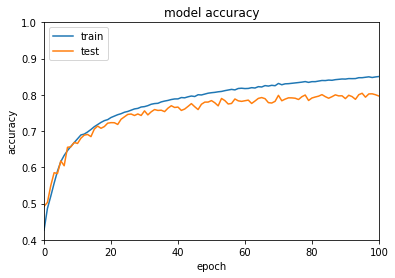

In [52]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.axis([0, 100, 0.4, 1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

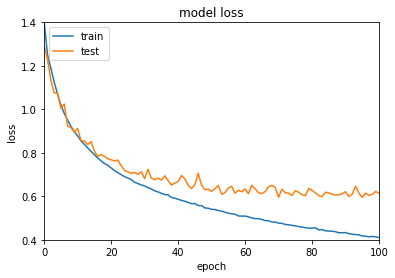

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.axis([0, 100, 0.4, 1.4])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Optimales Modell speichern

In [57]:
# Mit mode.to_json wird nur die Architektur gespeichert.
# Besser: model.save()
## model_json = model.to_json()
## file_name_json = "model.json"
## file_name_h5 = "model.h5"
## with open(file_name_json, "w") as json_file:
    ## json_file.write(model_json)
## serialize weights to HDF5
##model.save_weights(file_name_h5)


save_model = '/home/sebastian/Schreibtisch/BDC/Age_without_Gender_opti/model.h5'
model.save(save_model)
print("Saved model to disk")

Saved model to disk


# Nochmal rumspielen um Anzahl Hidden Layers und Aktivierungsfunktion des OutputLayers zu variieren

In [85]:
model = Sequential()
#hier muss beim Versuch mit Gender als Trainingsmerkmal eine 35 statt eine 34 stehen!
model.add (Dense (34, input_dim = 34, activation = 'relu'))
model.add (Dense (100, activation = 'selu'))
model.add (Dense (100, activation = 'selu'))
model.add (Dense (100, activation = 'selu'))
model.add (Dense (7, activation = 'softmax'))
model.summary()

Model: "sequential_238"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_949 (Dense)            (None, 34)                1190      
_________________________________________________________________
dense_950 (Dense)            (None, 100)               3500      
_________________________________________________________________
dense_951 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_952 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_953 (Dense)            (None, 7)                 707       
Total params: 25,597
Trainable params: 25,597
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile (loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_crossentropy','acc'])

In [87]:
import time

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...')

# Model trainieren
history = model.fit (df_data_x, df_age_y, epochs = 150, validation_split = 0.3)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(current_time2, ' Training beendet ...')

13.05.2020 09:33:01  Training gestartet ...
Train on 39512 samples, validate on 16934 samples
Epoch 1/150
39512/39512 [==============================] - 4s 113us/step - loss: 1.3852 - categorical_crossentropy: 69.2107 - acc: 0.4268 - val_loss: 1.2693 - val_categorical_crossentropy: 69.9949 - val_acc: 0.4719
Epoch 2/150
39512/39512 [==============================] - 4s 110us/step - loss: 1.2464 - categorical_crossentropy: 71.7809 - acc: 0.4849 - val_loss: 1.2158 - val_categorical_crossentropy: 68.8767 - val_acc: 0.4860
Epoch 3/150
39512/39512 [==============================] - 4s 111us/step - loss: 1.1760 - categorical_crossentropy: 74.4130 - acc: 0.5276 - val_loss: 1.1629 - val_categorical_crossentropy: 77.6946 - val_acc: 0.5409
Epoch 4/150
39512/39512 [==============================] - 4s 110us/step - loss: 1.1165 - categorical_crossentropy: 76.6606 - acc: 0.5578 - val_loss: 1.0716 - val_categorical_crossentropy: 79.6027 - val_acc: 0.5706
Epoch 5/150
39512/39512 [=====================

Epoch 76/150
39512/39512 [==============================] - 4s 106us/step - loss: 0.4709 - categorical_crossentropy: 189.0422 - acc: 0.8289 - val_loss: 0.7009 - val_categorical_crossentropy: 193.8031 - val_acc: 0.7635
Epoch 77/150
39512/39512 [==============================] - 4s 107us/step - loss: 0.4629 - categorical_crossentropy: 190.5813 - acc: 0.8317 - val_loss: 0.6372 - val_categorical_crossentropy: 189.6223 - val_acc: 0.7851
Epoch 78/150
39512/39512 [==============================] - 4s 107us/step - loss: 0.4645 - categorical_crossentropy: 192.0842 - acc: 0.8303 - val_loss: 0.7137 - val_categorical_crossentropy: 191.6731 - val_acc: 0.7636
Epoch 79/150
39512/39512 [==============================] - 4s 108us/step - loss: 0.4607 - categorical_crossentropy: 197.7222 - acc: 0.8323 - val_loss: 0.6743 - val_categorical_crossentropy: 183.8490 - val_acc: 0.7689
Epoch 80/150
39512/39512 [==============================] - 4s 106us/step - loss: 0.4574 - categorical_crossentropy: 196.3581 - 

39512/39512 [==============================] - 4s 107us/step - loss: 0.3331 - categorical_crossentropy: 292.7518 - acc: 0.8754 - val_loss: 0.7188 - val_categorical_crossentropy: 296.0685 - val_acc: 0.7938
13.05.2020 09:43:37  Training beendet ...


# Kein besseres gefunden!

# Testen des Modells mit ungelabelten Daten !!!noch nicht durchgeführt! ab hier

In [56]:
# von lokal lesen
df_test = pd.read_csv ('/home/sebastian/Schreibtisch/Gender_Age_Detection/test_final/test_final_FeaturesExtracted.csv', delimiter =';')

Die Input Datei für das Testen des Modells mit nicht gelabelten Daten wird analog zu den Test und Trainingsdatensätzen vorbereitet

In [57]:
list_cn = df_test.columns.values
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn

array(['zcr', 'energy', 'energy_entropy', 'spectral_centroid',
       'spectral_spread', 'spectral_entropy', 'spectral_flux',
       'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
       'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7',
       'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'chroma_std'], dtype=object)

In [58]:
nrows = len(df_test)

for i in range (0,nrows):
    for j in list_cn:
        list_c = df_test[j].iloc[i]
        list_c = list_c.replace('[','')
        list_c = list_c.replace(']','')
        list1 = np.fromstring (list_c, sep=' ',dtype=float)
        df_test[j].iat[i] = list1
        df_test[j].iat[i] = df_test[j].iloc[i].mean()
    if (i % 10000 == 0):
        print ("Reihe "+ str(i) + " fertig")
print ("Konvertierung abgeschlossen.")

Reihe 0 fertig
Konvertierung abgeschlossen.


In [59]:
df_test

Unnamed: 0  index           path       age  gender      file_wave  \
0           0      0  geilerTyp.mp3   fifties    male  geilerTyp.wav   
1           1      1       schr.mp3  fourties    male       schr.wav   
2           2      2        sk1.mp3  thirties    male        sk1.wav   
3           3      3        je1.mp3  thirties  female        je1.wav   
4           4      4        je2.mp3  thirties  female        je1.wav   
5           5      5         me.mp3  twenties  female         me.wav   
6           6      6         ke.mp3  twenties  female         ke.wav   

         zcr     energy energy_entropy spectral_centroid    ...      \
0  0.0435119   0.018574        3.01232          0.105139    ...       
1  0.0518132  0.0221208        2.93502          0.120971    ...       
2  0.0477583  0.0106856        2.93158          0.132843    ...       
3  0.0664128  0.0143529        2.90859          0.156188    ...       
4  0.0664128  0.0143529        2.90859          0.156188    ...       
5  0.0465894   0.017359        2.81086           0.10745    ...       
6  0.0245694  0.0119659        2.84867         0.0958715    ...       

     chroma_4   chroma_5    chroma_6   chroma_7     chroma_8    chroma_9  \
0  0.00782778  0.0158719  0.00797515  0.0751808   0.00166901  0.00864305   
1   0.0153491  0.0231022    0.014726  0.0267639   0.00210171    0.010222   
2   0.0119045  0.0322351  0.00820262  0.0504847    0.0053183  0.00800017   
3    0.010881  0.0139039   0.0106856  0.0644062  0.000928041  0.00568124   
4    0.010881  0.0139039   0.0106856  0.0644062  0.000928041  0.00568124   
5   0.0156644  0.0199885  0.00795671  0.0233293   0.00370495  0.00632902   
6   0.0314948   0.024657   0.0184142  0.0254578   0.00521319   0.0097329   

   chroma_10  chroma_11   chroma_12 chroma_std  
0  0.0120818  0.0374517  0.00636176  0.0302023  
1  0.0264008   0.019774  0.00701332  0.0269046  
2  0.0121582  0.0259356  0.00414674   0.031859  
3  0.0204463  0.0395585  0.00380728  0.0335224  
4  0.0204463  0.0395585  0.00380728  0.0335224  
5  0.0245737  0.0406926  0.00860004  0.0208492  
6  0.0172653  0.0264739  0.00517114  0.0315499  

[7 rows x 40 columns]

In [60]:
df_pred = df_test.copy()
del df_pred['Unnamed: 0']
del df_pred['index']
del df_pred['path']
del df_pred['age']
del df_pred['file_wave']
del df_pred['gender']

## Prediction der Testwerte
Die Ausgabe der Prediction gibt die vorhergesagte Klasse wieder (prediction_class)
0 = Male
1 = Female
Die Variable prediction_proba gibt die errechnete Wahrscheinlichkeit aus, dass es sich um die vorhergesagte Klasse handelt

In [61]:
for i in range (7):
    prediction = model.predict(df_pred.iloc[[i]])
    prediction_class = model.predict_classes(df_pred.iloc[[i]])
    prediction_proba = model.predict_proba(df_pred.iloc[[i]])
    print(prediction)
    print (prediction_class)
    #print (prediction_proba)
    print ("----------")

[[1.0270352]]
[[1]]
----------
[[0.94505775]]
[[1]]
----------
[[1.0122542]]
[[1]]
----------
[[0.12622088]]
[[0]]
----------
[[0.12622088]]
[[0]]
----------
[[0.99708176]]
[[1]]
----------
[[0.13873598]]
[[0]]
----------


/Users/sebastian/anaconda3/lib/python3.6/site-packages/keras/engine/sequential.py:248: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


# Der nachfolgende Code hilft bei der Überprüfung der Prediction

In [34]:
label_encoder = LabelEncoder()
df_test['gender_enc'] = label_encoder.fit_transform(df_test['gender'])
print(df_gender_y)

[0 0 0 ... 1 1 1]


In [35]:
df_test[['gender','gender_enc']]

gender  gender_enc
0    male           1
1    male           1
2    male           1
3  female           0
4  female           0
5  female           0
6  female           0